In [1]:
from Neural_Nets.LaengeNet.Development.LaengeNetTorch import LaengeNet, LaengeNetLossFunc, LaengeDataset
from Neural_Nets.ThermoNetActFuncs.Development.ThermoNetActFuncs import Sigmoid, ChenSundman
from Utils.PlotHandler.Development.PlotHandler import PlotHandler 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop
from Data_Handling.SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def epoch(net: LaengeNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, (temp, g, s, h, c) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)
        
        # Input scaling 
        #temp /= temp.max()

        # Forward pass
        gibbs_energy, entropy, enthalpy, heat_cap = net(temp, temp, temp, temp, debug=False)
        
        # Output scaling
        scale = 100000
        gibbs_energy, entropy, enthalpy, heat_cap = gibbs_energy/scale, entropy/scale, enthalpy/scale, heat_cap/scale
        g, s, h, c = g/scale, s/scale, h/scale, c/scale
        
        # Get the loss
        loss = loss_func(gibbs_energy.float(), g.float(), entropy.float(), s.float(), enthalpy.float(), h.float(),
                         heat_cap.float(), c.float(), debug=True)

        # Backward pass
        net.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 100)
        optimizer.step()
        epoch_losses[i] = loss

    mean_epoch_loss = epoch_losses.mean()
    print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [7]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 100
    lr = 0.01
    batch_size = 16
    std_thresh = 0.05
    loss_weights = [1, 0, 0, 0]

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = Rprop(net.parameters(), lr=lr)
    loss_func = LaengeNetLossFunc()

    losses = []
    
    # Keep track of epoch where learning rate was reduced last
    lr_reduced_last = 0

    for i in range(n_epochs):
        print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss)
        
        # Adapt learning rate if standard deviation over the last 10 epochs is below a threshold
        if np.array(losses[-10:]).std() < std_thresh and (i - lr_reduced_last) >= 10:
            print('Learning rate halfed! \n')
            lr_reduced_last = i
            lr /= 2

In [8]:
net = LaengeNet(init_args=(-0.2, -0.1), act_1=ChenSundman())

element = 'Fe'
phase = ['BCC_A2']
dataset = LaengeDataset(element, phase)

train(net, dataset)

Fe successfully selected!

-----
Epoch 0:

Gibbs loss:  tensor(13.0617, grad_fn=<MseLossBackward>)
g_p:  (-7.269265651702881, -0.04198431968688965) , g_t:  (-1.1453994512557983, -0.11208239942789078)
Entropy loss:  tensor(4.3324e-05, grad_fn=<MseLossBackward>)
s_p:  (0.0005109923076815903, 0.011676491238176823) , s_t:  (0.0003470467636361718, 0.0009396636742167175)
Enthalpy loss:,  tensor(62.2217, grad_fn=<MseLossBackward>)
h_p:  (0.16087962687015533, 14.670862197875977) , h_t:  (0.19508318603038788, 0.8753002882003784)
Heat cap loss:  tensor(0.0002, grad_fn=<MseLossBackward>)
c_p:  (0.0010349353542551398, 0.02341447025537491) , c_t:  (0.00027065412723459303, 0.0005534542724490166)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(7.0618, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(4.6814, grad_fn=<MseLossBackward>)
g_p:  (-4.950761795043945, -0.07506245374679565) , g_t:  (-1.084052324295044, -0.14838607609272003)
Entropy loss:  tensor(1.8530e-05, grad_fn=<MseLossBackward>)
s

Total loss:  tensor(0.0332, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2810, grad_fn=<MseLossBackward>)
g_p:  (-0.5782768726348877, 0.0010867665987461805) , g_t:  (-1.148211121559143, -0.1180797666311264)
Entropy loss:  tensor(1.9873e-07, grad_fn=<MseLossBackward>)
s_p:  (4.4253240048419684e-05, 0.0009361973498016596) , s_t:  (0.00035847126855514944, 0.0009403273579664528)
Enthalpy loss:,  tensor(0.1457, grad_fn=<MseLossBackward>)
h_p:  (0.01940760761499405, 1.183646559715271) , h_t:  (0.19935812056064606, 0.8765485882759094)
Heat cap loss:  tensor(4.8342e-07, grad_fn=<MseLossBackward>)
c_p:  (8.985106251202524e-05, 0.0018785895081236959) , c_t:  (0.0002743117802310735, 0.0005887337028980255)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0290, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2772, grad_fn=<MseLossBackward>)
g_p:  (-0.5829510688781738, -0.006638959515839815) , g_t:  (-1.1698389053344727, -0.17125536501407623)
Entropy loss:  tensor(2.1343e-07, grad_fn=<

Gibbs loss:  tensor(0.3673, grad_fn=<MseLossBackward>)
g_p:  (-0.6332694888114929, -0.004568597301840782) , g_t:  (-1.2575476169586182, -0.142734557390213)
Entropy loss:  tensor(2.1719e-07, grad_fn=<MseLossBackward>)
s_p:  (6.128880340838805e-05, 0.0009408825426362455) , s_t:  (0.00039948755875229836, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.2279, grad_fn=<MseLossBackward>)
h_p:  (0.024788737297058105, 1.2456730604171753) , h_t:  (0.21581660211086273, 0.9255936145782471)
Heat cap loss:  tensor(5.3489e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00011299657489871606, 0.0018432533834129572) , c_t:  (0.00028868429944850504, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0330, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2922, grad_fn=<MseLossBackward>)
g_p:  (-0.47862327098846436, -0.0020087766461074352) , g_t:  (-1.0895886421203613, -0.12133274227380753)
Entropy loss:  tensor(2.0569e-07, grad_fn=<MseLossBackward>)
s_p:  (4.993176116840914e-05, 0

Gibbs loss:  tensor(0.3047, grad_fn=<MseLossBackward>)
g_p:  (-0.8225504755973816, -0.0382358692586422) , g_t:  (-1.2565836906433105, -0.1823996752500534)
Entropy loss:  tensor(1.7721e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00014265597565099597, 0.0011077470844611526) , s_t:  (0.0004526310076471418, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.2673, grad_fn=<MseLossBackward>)
h_p:  (0.04336334764957428, 1.3885126113891602) , h_t:  (0.23939627408981323, 0.9251589179039001)
Heat cap loss:  tensor(5.8185e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00020831008441746235, 0.0019785920158028603) , c_t:  (0.00031159399077296257, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0293, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3531, grad_fn=<MseLossBackward>)
g_p:  (-0.7912361025810242, -0.022214464843273163) , g_t:  (-1.217270016670227, -0.11879796534776688)
Entropy loss:  tensor(2.0199e-07, grad_fn=<MseLossBackward>)
s_p:  (9.465890616411343e-05, 0.0010

Gibbs loss:  tensor(0.2595, grad_fn=<MseLossBackward>)
g_p:  (-0.693091869354248, -0.033198561519384384) , g_t:  (-1.1972802877426147, -0.099398173391819)
Entropy loss:  tensor(1.5543e-07, grad_fn=<MseLossBackward>)
s_p:  (7.508853741455823e-05, 0.0009106825455091894) , s_t:  (0.00032023355015553534, 0.0009518141741864383)
Enthalpy loss:,  tensor(0.1277, grad_fn=<MseLossBackward>)
h_p:  (-0.006241778377443552, 1.0681681632995605) , h_t:  (0.18560169637203217, 0.898465096950531)
Heat cap loss:  tensor(3.4727e-07, grad_fn=<MseLossBackward>)
c_p:  (8.9382789155934e-05, 0.0015706834383308887) , c_t:  (0.0002624515036586672, 0.0005361222429201007)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0229, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2898, grad_fn=<MseLossBackward>)
g_p:  (-0.720000684261322, -0.03249654173851013) , g_t:  (-1.2086905241012573, -0.08953307569026947)
Entropy loss:  tensor(1.9604e-07, grad_fn=<MseLossBackward>)
s_p:  (6.922756438143551e-05, 0.00093892

Total loss:  tensor(0.0269, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3062, grad_fn=<MseLossBackward>)
g_p:  (-0.8598105311393738, -0.05458325147628784) , g_t:  (-1.246960997581482, -0.0971744954586029)
Entropy loss:  tensor(1.5131e-07, grad_fn=<MseLossBackward>)
s_p:  (9.787988528842106e-05, 0.0010502125369384885) , s_t:  (0.00031508083338849247, 0.0009632198489271104)
Enthalpy loss:,  tensor(0.2502, grad_fn=<MseLossBackward>)
h_p:  (-0.020129529759287834, 1.2259116172790527) , h_t:  (0.1838688999414444, 0.9208192825317383)
Heat cap loss:  tensor(6.8327e-07, grad_fn=<MseLossBackward>)
c_p:  (0.0001002850040094927, 0.0017503602430224419) , c_t:  (0.0002609178191050887, 0.0004690658824983984)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0275, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2554, grad_fn=<MseLossBackward>)
g_p:  (-0.7051808834075928, -0.05191504955291748) , g_t:  (-1.0960571765899658, -0.08433204889297485)
Entropy loss:  tensor(2.0370e-07, grad_fn=<M

Gibbs loss:  tensor(0.1757, grad_fn=<MseLossBackward>)
g_p:  (-0.7198811173439026, -0.07578709721565247) , g_t:  (-1.0739253759384155, -0.10428308695554733)
Entropy loss:  tensor(1.4981e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00011405701661715284, 0.0009094402194023132) , s_t:  (0.0003310430911369622, 0.0009226750698871911)
Enthalpy loss:,  tensor(0.1190, grad_fn=<MseLossBackward>)
h_p:  (-0.033129774034023285, 0.9189302325248718) , h_t:  (0.1893303096294403, 0.5779387354850769)
Heat cap loss:  tensor(2.3048e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00011304015060886741, 0.0014635554980486631) , c_t:  (0.0002657061268109828, 0.0005433584447018802)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0202, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2728, grad_fn=<MseLossBackward>)
g_p:  (-0.8795692920684814, -0.07697510719299316) , g_t:  (-1.2239556312561035, -0.10395240038633347)
Entropy loss:  tensor(1.9790e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00011453704792074859, 0.0

Gibbs loss:  tensor(0.2884, grad_fn=<MseLossBackward>)
g_p:  (-0.9434743523597717, -0.08864061534404755) , g_t:  (-1.220133662223816, -0.08433204889297485)
Entropy loss:  tensor(1.8422e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00011110486229881644, 0.0010860959300771356) , s_t:  (0.00028173025930300355, 0.0009570918045938015)
Enthalpy loss:,  tensor(0.2576, grad_fn=<MseLossBackward>)
h_p:  (-0.054309211671352386, 1.1831014156341553) , h_t:  (0.17334824800491333, 0.9087352156639099)
Heat cap loss:  tensor(5.8885e-07, grad_fn=<MseLossBackward>)
c_p:  (9.263870015274733e-05, 0.0017294044373556972) , c_t:  (0.00025109597481787205, 0.00044040355714969337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0298, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1818, grad_fn=<MseLossBackward>)
g_p:  (-0.901049792766571, -0.1128024235367775) , g_t:  (-1.1821162700653076, -0.141936793923378)
Entropy loss:  tensor(1.4634e-07, grad_fn=<MseLossBackward>)
s_p:  (0.0001663245930103585, 0.0010

Gibbs loss:  tensor(0.3046, grad_fn=<MseLossBackward>)
g_p:  (-0.9785720109939575, -0.1156747043132782) , g_t:  (-1.2585116624832153, -0.11035580188035965)
Entropy loss:  tensor(1.7634e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00013995259359944612, 0.0010754684917628765) , s_t:  (0.00034362339647486806, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.2696, grad_fn=<MseLossBackward>)
h_p:  (-0.0608132928609848, 1.170214056968689) , h_t:  (0.19382929801940918, 0.9260282516479492)
Heat cap loss:  tensor(5.6323e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00012531806714832783, 0.0016896991292014718) , c_t:  (0.0002695800503715873, 0.00047398507012985647)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0290, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1584, grad_fn=<MseLossBackward>)
g_p:  (-0.8792846202850342, -0.10946575552225113) , g_t:  (-1.1764447689056396, -0.09436898678541183)
Entropy loss:  tensor(1.3552e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00012345387949608266, 0.00

Gibbs loss:  tensor(0.2254, grad_fn=<MseLossBackward>)
g_p:  (-0.880870521068573, -0.1367095559835434) , g_t:  (-1.1707814931869507, -0.1375923454761505)
Entropy loss:  tensor(1.3515e-07, grad_fn=<MseLossBackward>)
s_p:  (0.0001643583527766168, 0.0009784622816368937) , s_t:  (0.000391585286706686, 0.0009456350817345083)
Enthalpy loss:,  tensor(0.1487, grad_fn=<MseLossBackward>)
h_p:  (-0.06011855602264404, 0.984078586101532) , h_t:  (0.21251578629016876, 0.8866011500358582)
Heat cap loss:  tensor(4.4905e-07, grad_fn=<MseLossBackward>)
c_p:  (0.0001574553461978212, 0.0015115913702175021) , c_t:  (0.0002857341605704278, 0.0005841724923811853)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0217, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2767, grad_fn=<MseLossBackward>)
g_p:  (-0.967443585395813, -0.13442525267601013) , g_t:  (-1.2527319192886353, -0.13064400851726532)
Entropy loss:  tensor(1.5302e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00015839248953852803, 0.001045839

Gibbs loss:  tensor(0.2666, grad_fn=<MseLossBackward>)
g_p:  (-0.9580402374267578, -0.12364277243614197) , g_t:  (-1.2431174516677856, -0.08894257992506027)
Entropy loss:  tensor(1.5563e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00012380038970150054, 0.0010218891547992826) , s_t:  (0.0002945014275610447, 0.0009623465011827648)
Enthalpy loss:,  tensor(0.2277, grad_fn=<MseLossBackward>)
h_p:  (-0.08340764045715332, 1.0673441886901855) , h_t:  (0.17723552882671356, 0.9190868735313416)
Heat cap loss:  tensor(4.0233e-07, grad_fn=<MseLossBackward>)
c_p:  (9.469946235185489e-05, 0.0015717303613200784) , c_t:  (0.0002548548800405115, 0.0005361222429201007)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0245, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1843, grad_fn=<MseLossBackward>)
g_p:  (-0.8009464144706726, -0.12118850648403168) , g_t:  (-1.0895886421203613, -0.08237995952367783)
Entropy loss:  tensor(1.4205e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00011746322707040235, 0.00

Gibbs loss:  tensor(0.2553, grad_fn=<MseLossBackward>)
g_p:  (-1.0614054203033447, -0.17060860991477966) , g_t:  (-1.2488839626312256, -0.14757156372070312)
Entropy loss:  tensor(1.4158e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00021202125935815275, 0.0010874869767576456) , s_t:  (0.0004066647379659116, 0.0009636561735533178)
Enthalpy loss:,  tensor(0.2354, grad_fn=<MseLossBackward>)
h_p:  (-0.06650617718696594, 1.1005187034606934) , h_t:  (0.21886508166790009, 0.9216862320899963)
Heat cap loss:  tensor(4.2185e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00017955397197511047, 0.001598574803210795) , c_t:  (0.0002914524229709059, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0233, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1381, grad_fn=<MseLossBackward>)
g_p:  (-1.0077757835388184, -0.14517898857593536) , g_t:  (-1.2115490436553955, -0.10165756195783615)
Entropy loss:  tensor(1.1128e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00016507624241057783, 0.00

h_p:  (-0.0941987857222557, 0.8564159870147705) , h_t:  (0.1711781620979309, 0.8633403778076172)
Heat cap loss:  tensor(2.5522e-07, grad_fn=<MseLossBackward>)
c_p:  (9.216804755851626e-05, 0.0013541328953579068) , c_t:  (0.00024890407803468406, 0.0005600394797511399)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0215, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1902, grad_fn=<MseLossBackward>)
g_p:  (-0.9407567977905273, -0.14966468513011932) , g_t:  (-1.141652226448059, -0.0971744954586029)
Entropy loss:  tensor(1.3766e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00017169628699775785, 0.0009715905180200934) , s_t:  (0.00031508083338849247, 0.00093877874314785)
Enthalpy loss:,  tensor(0.1675, grad_fn=<MseLossBackward>)
h_p:  (-0.0892275869846344, 0.8809754252433777) , h_t:  (0.1838688999414444, 0.8736390471458435)
Heat cap loss:  tensor(2.2502e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00011251815158175305, 0.0013705941382795572) , c_t:  (0.0002609178191050887, 0.0004789269

Gibbs loss:  tensor(0.1280, grad_fn=<MseLossBackward>)
g_p:  (-0.9001947045326233, -0.228850856423378) , g_t:  (-0.9715131521224976, -0.1283729374408722)
Entropy loss:  tensor(8.5850e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0002731170388869941, 0.0008550853817723691) , s_t:  (0.0003766198642551899, 0.0008974653901532292)
Enthalpy loss:,  tensor(0.0971, grad_fn=<MseLossBackward>)
h_p:  (-0.10813311487436295, 0.544044554233551) , h_t:  (0.20643122494220734, 0.533941924571991)
Heat cap loss:  tensor(1.1245e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00015156989684328437, 0.0009974294807761908) , c_t:  (0.000280400097835809, 0.0004978971555829048)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1407, grad_fn=<MseLossBackward>)
g_p:  (-1.0814303159713745, -0.20879192650318146) , g_t:  (-1.11925208568573, -0.09012679755687714)
Entropy loss:  tensor(7.2046e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0002473568601999432, 0.00097601761

Gibbs loss:  tensor(0.2039, grad_fn=<MseLossBackward>)
g_p:  (-1.1972856521606445, -0.25752079486846924) , g_t:  (-1.2296943664550781, -0.11417688429355621)
Entropy loss:  tensor(9.0867e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00029338145395740867, 0.0009695578482933342) , s_t:  (0.000351116294041276, 0.00095928437076509)
Enthalpy loss:,  tensor(0.1674, grad_fn=<MseLossBackward>)
h_p:  (-0.13928808271884918, 0.7108042240142822) , h_t:  (0.19659000635147095, 0.9130390882492065)
Heat cap loss:  tensor(1.2290e-07, grad_fn=<MseLossBackward>)
c_p:  (0.0001262708829017356, 0.0010841024341061711) , c_t:  (0.00027194348513148725, 0.0004581135290209204)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0140, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0869, grad_fn=<MseLossBackward>)
g_p:  (-0.8292660117149353, -0.27433496713638306) , g_t:  (-0.8377560377120972, -0.13332219421863556)
Entropy loss:  tensor(6.1745e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00031113982549868524, 0.0007

Gibbs loss:  tensor(0.2974, grad_fn=<MseLossBackward>)
g_p:  (-1.2982909679412842, -0.26338955760002136) , g_t:  (-1.226824402809143, -0.08265640586614609)
Entropy loss:  tensor(1.0727e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00030678455368615687, 0.0010013733990490437) , s_t:  (0.0002768207632470876, 0.0009586270898580551)
Enthalpy loss:,  tensor(0.2275, grad_fn=<MseLossBackward>)
h_p:  (-0.17043383419513702, 0.6694077849388123) , h_t:  (0.17190012335777283, 0.9117465019226074)
Heat cap loss:  tensor(1.3184e-07, grad_fn=<MseLossBackward>)
c_p:  (9.233987657353282e-05, 0.0010439865291118622) , c_t:  (0.0002496418310329318, 0.00046999123878777027)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0173, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1726, grad_fn=<MseLossBackward>)
g_p:  (-1.2413018941879272, -0.2975802421569824) , g_t:  (-1.1783342361450195, -0.1180797666311264)
Entropy loss:  tensor(6.5462e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00033999609877355397, 0.0009

Gibbs loss:  tensor(0.2369, grad_fn=<MseLossBackward>)
g_p:  (-1.2776802778244019, -0.34943175315856934) , g_t:  (-1.2508070468902588, -0.18741148710250854)
Entropy loss:  tensor(7.0874e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039038772229105234, 0.0009698634967207909) , s_t:  (0.00045859432430006564, 0.0009640922071412206)
Enthalpy loss:,  tensor(0.1807, grad_fn=<MseLossBackward>)
h_p:  (-0.12183571606874466, 0.6523480415344238) , h_t:  (0.24216687679290771, 0.9225537776947021)
Heat cap loss:  tensor(1.2161e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00018942962924484164, 0.0009926428319886327) , c_t:  (0.00031456604483537376, 0.00044372017146088183)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2068, grad_fn=<MseLossBackward>)
g_p:  (-1.0719438791275024, -0.27642515301704407) , g_t:  (-1.0382426977157593, -0.10561295598745346)
Entropy loss:  tensor(8.9805e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000327437388477847, 0.

Gibbs loss:  tensor(0.1488, grad_fn=<MseLossBackward>)
g_p:  (-1.1296181678771973, -0.29305580258369446) , g_t:  (-1.1155303716659546, -0.136030912399292)
Entropy loss:  tensor(6.7693e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00035296616260893643, 0.0008936053491197526) , s_t:  (0.0003891260421369225, 0.0009325862629339099)
Enthalpy loss:,  tensor(0.1511, grad_fn=<MseLossBackward>)
h_p:  (-0.12998543679714203, 0.5208709239959717) , h_t:  (0.21150070428848267, 0.8621149063110352)
Heat cap loss:  tensor(4.9070e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014178628043737262, 0.0008751961286179721) , c_t:  (0.00028483569622039795, 0.0005280203768052161)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3369, grad_fn=<MseLossBackward>)
g_p:  (-1.266112208366394, -0.25664854049682617) , g_t:  (-1.2556202411651611, -0.09875909239053726)
Entropy loss:  tensor(1.2026e-07, grad_fn=<MseLossBackward>)
s_p:  (0.000321405561408028, 0.00096

Gibbs loss:  tensor(0.3180, grad_fn=<MseLossBackward>)
g_p:  (-1.2019370794296265, -0.2285364866256714) , g_t:  (-1.2048836946487427, -0.08518090844154358)
Entropy loss:  tensor(1.2551e-07, grad_fn=<MseLossBackward>)
s_p:  (0.0003076426510233432, 0.0009392618667334318) , s_t:  (0.0002841598179657012, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.1997, grad_fn=<MseLossBackward>)
h_p:  (-0.13255196809768677, 0.6221094727516174) , h_t:  (0.17407433688640594, 0.9018786549568176)
Heat cap loss:  tensor(1.1502e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00010075493628391996, 0.0009422574657946825) , c_t:  (0.0002518131223041564, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0189, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1045, grad_fn=<MseLossBackward>)
g_p:  (-1.0696943998336792, -0.3197440505027771) , g_t:  (-1.0693312883377075, -0.1846696138381958)
Entropy loss:  tensor(4.9753e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038920677616260946, 0.00087

Enthalpy loss:,  tensor(0.1839, grad_fn=<MseLossBackward>)
h_p:  (-0.10567174106836319, 0.581576943397522) , h_t:  (0.20087078213691711, 0.8765485882759094)
Heat cap loss:  tensor(9.0843e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012718192010652274, 0.000899182865396142) , c_t:  (0.00027560771559365094, 0.0005027311854064465)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0139, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2354, grad_fn=<MseLossBackward>)
g_p:  (-1.1382347345352173, -0.2665814757347107) , g_t:  (-1.1557202339172363, -0.1407446712255478)
Entropy loss:  tensor(8.5474e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00035710487281903625, 0.0009142625494860113) , s_t:  (0.0003964642237406224, 0.0009420974529348314)
Enthalpy loss:,  tensor(0.1512, grad_fn=<MseLossBackward>)
h_p:  (-0.09731373935937881, 0.5897215008735657) , h_t:  (0.2145467847585678, 0.8798865079879761)
Heat cap loss:  tensor(8.3616e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014616746921092272, 0.000

Gibbs loss:  tensor(0.1471, grad_fn=<MseLossBackward>)
g_p:  (-1.0164518356323242, -0.20254375040531158) , g_t:  (-1.0409748554229736, -0.08806260675191879)
Entropy loss:  tensor(6.8946e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003105273935943842, 0.0008567491895519197) , s_t:  (0.00029214099049568176, 0.000914718781132251)
Enthalpy loss:,  tensor(0.1037, grad_fn=<MseLossBackward>)
h_p:  (-0.10255394130945206, 0.4965672492980957) , h_t:  (0.176503986120224, 0.5637450218200684)
Heat cap loss:  tensor(5.2359e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011566418834263459, 0.0008190804510377347) , c_t:  (0.00025416165590286255, 0.0005902757402509451)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0722, grad_fn=<MseLossBackward>)
g_p:  (-0.9057796001434326, -0.29969295859336853) , g_t:  (-0.9218848347663879, -0.19481772184371948)
Entropy loss:  tensor(4.1533e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039748320705257356, 0.000

Gibbs loss:  tensor(0.1337, grad_fn=<MseLossBackward>)
g_p:  (-0.9349466562271118, -0.22304539382457733) , g_t:  (-0.9670513868331909, -0.12242881953716278)
Entropy loss:  tensor(6.2364e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003437280538491905, 0.0008197472197934985) , s_t:  (0.0003663462703116238, 0.0008963337750174105)
Enthalpy loss:,  tensor(0.0970, grad_fn=<MseLossBackward>)
h_p:  (-0.07661723345518112, 0.445507675409317) , h_t:  (0.20238523185253143, 0.5320336222648621)
Heat cap loss:  tensor(4.9110e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012939934094902128, 0.0007645037840120494) , c_t:  (0.00027690769638866186, 0.0005782376974821091)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2606, grad_fn=<MseLossBackward>)
g_p:  (-1.1524838209152222, -0.23568789660930634) , g_t:  (-1.1963307857513428, -0.13720110058784485)
Entropy loss:  tensor(9.6679e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00035566321457736194, 0.00

Entropy loss:  tensor(7.4075e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00036507361801341176, 0.0009559232858009636) , s_t:  (0.0004096234915778041, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.1605, grad_fn=<MseLossBackward>)
h_p:  (-0.05249548330903053, 0.709518313407898) , h_t:  (0.22013545036315918, 0.9156278967857361)
Heat cap loss:  tensor(7.0916e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015429001359734684, 0.0009643699158914387) , c_t:  (0.0002926196320913732, 0.0004877297324128449)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0119, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1489, grad_fn=<MseLossBackward>)
g_p:  (-1.1413235664367676, -0.16752640902996063) , g_t:  (-1.2001299858093262, -0.08237995952367783)
Entropy loss:  tensor(6.9181e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003033199755009264, 0.0009378409013152122) , s_t:  (0.00027599604800343513, 0.0009524751803837717)
Enthalpy loss:,  tensor(0.1228, grad_fn=<MseLossBackward>)
h_p:  (-0.07592377066612

Heat cap loss:  tensor(5.9790e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016277875693049282, 0.000918596750125289) , c_t:  (0.0002981043071486056, 0.00048157203127630055)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1871, grad_fn=<MseLossBackward>)
g_p:  (-1.0658591985702515, -0.15443244576454163) , g_t:  (-1.138845682144165, -0.08433204889297485)
Entropy loss:  tensor(8.4767e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003059771843254566, 0.0009062980534508824) , s_t:  (0.00028173025930300355, 0.0009381150011904538)
Enthalpy loss:,  tensor(0.1267, grad_fn=<MseLossBackward>)
h_p:  (-0.05988548696041107, 0.6307307481765747) , h_t:  (0.17334824800491333, 0.8723954558372498)
Heat cap loss:  tensor(6.9020e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011837138299597427, 0.0008910878095775843) , c_t:  (0.00025109597481787205, 0.0005140587454661727)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0123, grad_fn=<AddBac

Gibbs loss:  tensor(0.2430, grad_fn=<MseLossBackward>)
g_p:  (-1.1356303691864014, -0.15111733973026276) , g_t:  (-1.2258678674697876, -0.09560836106538773)
Entropy loss:  tensor(9.3012e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003191887808497995, 0.0009500980377197266) , s_t:  (0.0003113559214398265, 0.000958407879807055)
Enthalpy loss:,  tensor(0.1542, grad_fn=<MseLossBackward>)
h_p:  (-0.040358830243349075, 0.7303621172904968) , h_t:  (0.18263429403305054, 0.91131591796875)
Heat cap loss:  tensor(9.7147e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001116243438445963, 0.0009559011668898165) , c_t:  (0.0002598145802039653, 0.0004410739929880947)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0142, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2176, grad_fn=<MseLossBackward>)
g_p:  (-1.0564579963684082, -0.1397545039653778) , g_t:  (-1.1463361978530884, -0.08575081825256348)
Entropy loss:  tensor(9.1004e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003077899164054543, 0.0009095

Gibbs loss:  tensor(0.2102, grad_fn=<MseLossBackward>)
g_p:  (-1.1523101329803467, -0.13357526063919067) , g_t:  (-1.2546581029891968, -0.09162458032369614)
Entropy loss:  tensor(8.2890e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003155824961140752, 0.000965714396443218) , s_t:  (0.0003014909161720425, 0.0009649636340327561)
Enthalpy loss:,  tensor(0.1335, grad_fn=<MseLossBackward>)
h_p:  (-0.02817070484161377, 0.7733244299888611) , h_t:  (0.17943714559078217, 0.9242900609970093)
Heat cap loss:  tensor(7.2014e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011168534547323361, 0.000977938063442707) , c_t:  (0.00025690783513709903, 0.0005361222429201007)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0124, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1940, grad_fn=<MseLossBackward>)
g_p:  (-1.0412763357162476, -0.12835802137851715) , g_t:  (-1.1425890922546387, -0.08747980743646622)
Entropy loss:  tensor(8.2540e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003108567907474935, 0.0009

Gibbs loss:  tensor(0.2453, grad_fn=<MseLossBackward>)
g_p:  (-1.1135995388031006, -0.15167708694934845) , g_t:  (-1.2134549617767334, -0.1180797666311264)
Entropy loss:  tensor(8.7886e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003457088896539062, 0.0009531208779662848) , s_t:  (0.00035847126855514944, 0.0009555547148920596)
Enthalpy loss:,  tensor(0.1496, grad_fn=<MseLossBackward>)
h_p:  (-0.008553607389330864, 0.7459392547607422) , h_t:  (0.19935812056064606, 0.9057308435440063)
Heat cap loss:  tensor(9.0784e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012616411549970508, 0.0009506630594842136) , c_t:  (0.0002743117802310735, 0.00043959059985354543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0136, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1704, grad_fn=<MseLossBackward>)
g_p:  (-1.0696020126342773, -0.19108805060386658) , g_t:  (-1.1679538488388062, -0.16088488698005676)
Entropy loss:  tensor(6.4709e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000380247161956504, 0.00

Gibbs loss:  tensor(0.1948, grad_fn=<MseLossBackward>)
g_p:  (-1.0946253538131714, -0.14143680036067963) , g_t:  (-1.1868486404418945, -0.11452838778495789)
Entropy loss:  tensor(6.6048e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00034997769398614764, 0.0009510445524938405) , s_t:  (0.00035179051337763667, 0.0009493889519944787)
Enthalpy loss:,  tensor(0.0997, grad_fn=<MseLossBackward>)
h_p:  (-4.5816264901077375e-05, 0.7342333197593689) , h_t:  (0.19684137403964996, 0.8937880992889404)
Heat cap loss:  tensor(1.0148e-07, grad_fn=<MseLossBackward>)
c_p:  (0.00012413485092110932, 0.0009358078241348267) , c_t:  (0.00027215847512707114, 0.0004683242877945304)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1781, grad_fn=<MseLossBackward>)
g_p:  (-1.1305257081985474, -0.145887553691864) , g_t:  (-1.2220441102981567, -0.11951898783445358)
Entropy loss:  tensor(6.7277e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003547274391166866, 0

Gibbs loss:  tensor(0.1579, grad_fn=<MseLossBackward>)
g_p:  (-0.8486928939819336, -0.1288701593875885) , g_t:  (-0.9104733467102051, -0.10263679921627045)
Entropy loss:  tensor(7.2231e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003527637163642794, 0.0008289628312923014) , s_t:  (0.00032747405930422246, 0.0008817303460091352)
Enthalpy loss:,  tensor(0.0636, grad_fn=<MseLossBackward>)
h_p:  (0.001299642608501017, 0.49422693252563477) , h_t:  (0.18808522820472717, 0.5079095959663391)
Heat cap loss:  tensor(5.6536e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011711732804542407, 0.0007375025888904929) , c_t:  (0.00026462512323632836, 0.0004378133453428745)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1278, grad_fn=<MseLossBackward>)
g_p:  (-1.1632837057113647, -0.13709187507629395) , g_t:  (-1.2287378311157227, -0.11138968914747238)
Entropy loss:  tensor(4.7541e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003608584520407021, 0.0

Gibbs loss:  tensor(0.1748, grad_fn=<MseLossBackward>)
g_p:  (-1.0082197189331055, -0.09991849958896637) , g_t:  (-1.086820125579834, -0.08690035343170166)
Entropy loss:  tensor(6.8592e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003355350636411458, 0.0009196677128784359) , s_t:  (0.00028896983712911606, 0.0009257516358047724)
Enthalpy loss:,  tensor(0.0906, grad_fn=<MseLossBackward>)
h_p:  (0.0067816488444805145, 0.6618968844413757) , h_t:  (0.17553044855594635, 0.8495973348617554)
Heat cap loss:  tensor(7.5443e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011972473294008523, 0.0008677722653374076) , c_t:  (0.0002532295184209943, 0.0005918285460211337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1567, grad_fn=<MseLossBackward>)
g_p:  (-1.0725640058517456, -0.11543124914169312) , g_t:  (-1.151963472366333, -0.10165756195783615)
Entropy loss:  tensor(6.8029e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003518426383379847, 0.000

Gibbs loss:  tensor(0.2452, grad_fn=<MseLossBackward>)
g_p:  (-1.1089051961898804, -0.12381874024868011) , g_t:  (-1.202030897140503, -0.12169747799634933)
Entropy loss:  tensor(8.8227e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00036970042856410146, 0.0009760186658240855) , s_t:  (0.00036504416493698955, 0.0009529152885079384)
Enthalpy loss:,  tensor(0.0999, grad_fn=<MseLossBackward>)
h_p:  (0.032934240996837616, 0.7835950255393982) , h_t:  (0.20188023149967194, 0.9005973935127258)
Heat cap loss:  tensor(9.3602e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013210410543251783, 0.0009499331936240196) , c_t:  (0.0002764738746918738, 0.0004381158505566418)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0132, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2313, grad_fn=<MseLossBackward>)
g_p:  (-1.033787727355957, -0.1172417402267456) , g_t:  (-1.1295030117034912, -0.116295725107193)
Entropy loss:  tensor(8.2664e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00036491977516561747, 0.00093

Gibbs loss:  tensor(0.2256, grad_fn=<MseLossBackward>)
g_p:  (-0.9855554699897766, -0.08411286771297455) , g_t:  (-1.0932836532592773, -0.09436898678541183)
Entropy loss:  tensor(9.2203e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003436439437791705, 0.0009166462114080787) , s_t:  (0.00030834870995022357, 0.0009272916940972209)
Enthalpy loss:,  tensor(0.0855, grad_fn=<MseLossBackward>)
h_p:  (0.03375700116157532, 0.6854905486106873) , h_t:  (0.18164852261543274, 0.852399468421936)
Heat cap loss:  tensor(9.0992e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011439034278737381, 0.0008634152472950518) , c_t:  (0.00025892656412906945, 0.0005753315635956824)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0132, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1488, grad_fn=<MseLossBackward>)
g_p:  (-0.9822257161140442, -0.10323408246040344) , g_t:  (-1.0914357900619507, -0.11312654614448547)
Entropy loss:  tensor(6.6363e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003615347668528557, 0.000

Gibbs loss:  tensor(0.1435, grad_fn=<MseLossBackward>)
g_p:  (-0.87813401222229, -0.05591640621423721) , g_t:  (-1.0047165155410767, -0.08182964473962784)
Entropy loss:  tensor(6.7315e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00032636086689308286, 0.0008620916632935405) , s_t:  (0.0002743405639193952, 0.0009057963034138083)
Enthalpy loss:,  tensor(0.0471, grad_fn=<MseLossBackward>)
h_p:  (0.04199185222387314, 0.609836220741272) , h_t:  (0.1711781620979309, 0.5481665730476379)
Heat cap loss:  tensor(4.8309e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012143104686401784, 0.0007854337454773486) , c_t:  (0.00024890407803468406, 0.0004612827324308455)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2105, grad_fn=<MseLossBackward>)
g_p:  (-1.0109617710113525, -0.06539256125688553) , g_t:  (-1.141652226448059, -0.09072354435920715)
Entropy loss:  tensor(7.7961e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003380464913789183, 0.0009312

s_p:  (0.00032718878355808556, 0.0009581429185345769) , s_t:  (0.0002809166326187551, 0.0009601600468158722)
Enthalpy loss:,  tensor(0.1284, grad_fn=<MseLossBackward>)
h_p:  (0.04318154230713844, 0.8025538921356201) , h_t:  (0.17310650646686554, 0.9147644639015198)
Heat cap loss:  tensor(8.9367e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011086685844929889, 0.0009259615908376873) , c_t:  (0.00025085548986680806, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0160, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2991, grad_fn=<MseLossBackward>)
g_p:  (-1.0739141702651978, -0.11425617337226868) , g_t:  (-1.2258678674697876, -0.13916359841823578)
Entropy loss:  tensor(8.9526e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037642169627361, 0.0009491375531069934) , s_t:  (0.00039403128903359175, 0.000958407879807055)
Enthalpy loss:,  tensor(0.1499, grad_fn=<MseLossBackward>)
h_p:  (0.0626620277762413, 0.7901920676231384) , h_t:  (0.21353113651275635, 0.91131591

Gibbs loss:  tensor(0.2055, grad_fn=<MseLossBackward>)
g_p:  (-1.065515160560608, -0.07156915962696075) , g_t:  (-1.2210888862609863, -0.08293361216783524)
Entropy loss:  tensor(7.6114e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003274912596680224, 0.0009159552864730358) , s_t:  (0.000277643819572404, 0.0009573109564371407)
Enthalpy loss:,  tensor(0.0974, grad_fn=<MseLossBackward>)
h_p:  (0.027988184243440628, 0.7288411855697632) , h_t:  (0.17214109003543854, 0.9091650247573853)
Heat cap loss:  tensor(5.8661e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010779975855257362, 0.0008546108147129416) , c_t:  (0.00024988609948195517, 0.0005314490990713239)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0112, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2203, grad_fn=<MseLossBackward>)
g_p:  (-1.0434269905090332, -0.2391061782836914) , g_t:  (-1.1859022378921509, -0.2546113431453705)
Entropy loss:  tensor(6.1607e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045590949594043195, 0.00090

Gibbs loss:  tensor(0.1766, grad_fn=<MseLossBackward>)
g_p:  (-1.1789218187332153, -0.24274593591690063) , g_t:  (-1.2344834804534912, -0.21003757417201996)
Entropy loss:  tensor(5.1190e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045776591286994517, 0.0009672514861449599) , s_t:  (0.0004840114270336926, 0.0009603787329979241)
Enthalpy loss:,  tensor(0.1038, grad_fn=<MseLossBackward>)
h_p:  (0.04610435664653778, 0.7294653058052063) , h_t:  (0.25416257977485657, 0.9151961207389832)
Heat cap loss:  tensor(4.8304e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00019749643979594111, 0.0008805914549157023) , c_t:  (0.0003283538680989295, 0.0005573790986090899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2154, grad_fn=<MseLossBackward>)
g_p:  (-1.122239351272583, -0.14066405594348907) , g_t:  (-1.1726689338684082, -0.1072910949587822)
Entropy loss:  tensor(6.8788e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003847041225526482, 0.00094

Gibbs loss:  tensor(0.1353, grad_fn=<MseLossBackward>)
g_p:  (-1.1625988483428955, -0.2889953553676605) , g_t:  (-1.2258678674697876, -0.257792592048645)
Entropy loss:  tensor(3.8786e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004862894129473716, 0.0009480482549406588) , s_t:  (0.0005316830356605351, 0.000958407879807055)
Enthalpy loss:,  tensor(0.0846, grad_fn=<MseLossBackward>)
h_p:  (0.06356445699930191, 0.6993678212165833) , h_t:  (0.27694612741470337, 0.91131591796875)
Heat cap loss:  tensor(4.0939e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00022778715356253088, 0.0008468714659102261) , c_t:  (0.00036018347600474954, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0065, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2120, grad_fn=<MseLossBackward>)
g_p:  (-1.101865291595459, -0.14211642742156982) , g_t:  (-1.1594802141189575, -0.10695404559373856)
Entropy loss:  tensor(7.9116e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038550261524505913, 0.000919834

Gibbs loss:  tensor(0.2447, grad_fn=<MseLossBackward>)
g_p:  (-1.1578501462936401, -0.1160246878862381) , g_t:  (-1.2585116624832153, -0.08982951194047928)
Entropy loss:  tensor(7.5713e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003632544830907136, 0.0009230657014995813) , s_t:  (0.0002968462067656219, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.1250, grad_fn=<MseLossBackward>)
h_p:  (0.003122777445241809, 0.6864351630210876) , h_t:  (0.17796826362609863, 0.9260282516479492)
Heat cap loss:  tensor(5.4320e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001052516236086376, 0.000811923120636493) , c_t:  (0.00025554344756528735, 0.0005066997255198658)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0118, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2435, grad_fn=<MseLossBackward>)
g_p:  (-1.143898606300354, -0.10974021255970001) , g_t:  (-1.2440776824951172, -0.08433204889297485)
Entropy loss:  tensor(8.5893e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00035720618325285614, 0.00091

Gibbs loss:  tensor(0.2563, grad_fn=<MseLossBackward>)
g_p:  (-1.1677755117416382, -0.13006123900413513) , g_t:  (-1.2182239294052124, -0.09012679755687714)
Entropy loss:  tensor(7.6734e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003732944023795426, 0.0009300027741119266) , s_t:  (0.00029762444319203496, 0.0009566526277922094)
Enthalpy loss:,  tensor(0.1267, grad_fn=<MseLossBackward>)
h_p:  (-0.007247384637594223, 0.6513099074363708) , h_t:  (0.17821277678012848, 0.9078760743141174)
Heat cap loss:  tensor(6.1032e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001298328279517591, 0.0007924281526356936) , c_t:  (0.0002557719999458641, 0.0005445919232442975)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1793, grad_fn=<MseLossBackward>)
g_p:  (-1.1552700996398926, -0.16265363991260529) , g_t:  (-1.2067869901657104, -0.11843857169151306)
Entropy loss:  tensor(5.6570e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040651095332577825, 0.0

Gibbs loss:  tensor(0.1777, grad_fn=<MseLossBackward>)
g_p:  (-0.9966736435890198, -0.1524704098701477) , g_t:  (-1.0418859720230103, -0.116295725107193)
Entropy loss:  tensor(6.0342e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040900654857978225, 0.0008601940353401005) , s_t:  (0.00035514464252628386, 0.0009149406687356532)
Enthalpy loss:,  tensor(0.0678, grad_fn=<MseLossBackward>)
h_p:  (0.014813268557190895, 0.523289144039154) , h_t:  (0.1980990469455719, 0.5641370415687561)
Heat cap loss:  tensor(4.1140e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011628377978922799, 0.0006887658964842558) , c_t:  (0.0002732342982199043, 0.0005470828036777675)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1525, grad_fn=<MseLossBackward>)
g_p:  (-1.2045321464538574, -0.36827901005744934) , g_t:  (-1.2575476169586182, -0.33705374598503113)
Entropy loss:  tensor(3.5183e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005433562910184264, 0.000952

Gibbs loss:  tensor(0.1716, grad_fn=<MseLossBackward>)
g_p:  (-1.1542320251464844, -0.14731809496879578) , g_t:  (-1.2220441102981567, -0.12612459063529968)
Entropy loss:  tensor(5.1344e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004169932217337191, 0.0009371691849082708) , s_t:  (0.0003727964358404279, 0.000957530690357089)
Enthalpy loss:,  tensor(0.1031, grad_fn=<MseLossBackward>)
h_p:  (0.034490954130887985, 0.682619571685791) , h_t:  (0.20491279661655426, 0.9095948934555054)
Heat cap loss:  tensor(4.0496e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001225919695571065, 0.0007956491899676621) , c_t:  (0.00027908547781407833, 0.0005191820673644543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2567, grad_fn=<MseLossBackward>)
g_p:  (-1.1401209831237793, -0.12702764570713043) , g_t:  (-1.2086905241012573, -0.10932788997888565)
Entropy loss:  tensor(7.5847e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040342388092540205, 0.0009

g_p:  (-1.1668835878372192, -0.08208305388689041) , g_t:  (-1.2546581029891968, -0.08575081825256348)
Entropy loss:  tensor(8.1383e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037221581442281604, 0.0009484403999522328) , s_t:  (0.00028577036573551595, 0.0009649636340327561)
Enthalpy loss:,  tensor(0.1448, grad_fn=<MseLossBackward>)
h_p:  (0.034792713820934296, 0.7243065237998962) , h_t:  (0.17455914616584778, 0.9242900609970093)
Heat cap loss:  tensor(6.9272e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012942585453856736, 0.0008125983295030892) , c_t:  (0.0002522878348827362, 0.0005181073793210089)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0131, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1301, grad_fn=<MseLossBackward>)
g_p:  (-0.9109524488449097, -0.0784769132733345) , g_t:  (-0.9885227084159851, -0.08377019315958023)
Entropy loss:  tensor(5.4417e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000368287117453292, 0.0008353491430170834) , s_t:  (0.0002801013470161706, 0.000

Heat cap loss:  tensor(6.1636e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000128189567476511, 0.0008073656354099512) , c_t:  (0.0002532295184209943, 0.0005224457709118724)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0126, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1363, grad_fn=<MseLossBackward>)
g_p:  (-1.057034969329834, -0.0728500708937645) , g_t:  (-1.1613613367080688, -0.09283670037984848)
Entropy loss:  tensor(4.9355e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003840667777694762, 0.0009083615732379258) , s_t:  (0.0003045546473003924, 0.0009434240637347102)
Enthalpy loss:,  tensor(0.0592, grad_fn=<MseLossBackward>)
h_p:  (0.05696449801325798, 0.6652185320854187) , h_t:  (0.18041878938674927, 0.8823986053466797)
Heat cap loss:  tensor(2.9058e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015092981630004942, 0.0007563557592220604) , c_t:  (0.00025780886062420905, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward

Entropy loss:  tensor(5.0318e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004376828146632761, 0.0009330542525276542) , s_t:  (0.0004201300907880068, 0.0009570918045938015)
Enthalpy loss:,  tensor(0.0613, grad_fn=<MseLossBackward>)
h_p:  (0.0967613011598587, 0.7302294969558716) , h_t:  (0.22470806539058685, 0.9087352156639099)
Heat cap loss:  tensor(3.3850e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014508131425827742, 0.0007911099819466472) , c_t:  (0.0002968949847854674, 0.0004953522002324462)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2372, grad_fn=<MseLossBackward>)
g_p:  (-1.099483609199524, -0.1142072081565857) , g_t:  (-1.2239556312561035, -0.14473946392536163)
Entropy loss:  tensor(6.1019e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004292697412893176, 0.0009347246377728879) , s_t:  (0.0004024913359899074, 0.0009579695761203766)
Enthalpy loss:,  tensor(0.1118, grad_fn=<MseLossBackward>)
h_p:  (0.09355935454368591, 0

Gibbs loss:  tensor(0.1788, grad_fn=<MseLossBackward>)
g_p:  (-0.9650989770889282, -0.07942917197942734) , g_t:  (-1.094207763671875, -0.12133274227380753)
Entropy loss:  tensor(5.8363e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041216437239199877, 0.0008796158363111317) , s_t:  (0.0003643915115389973, 0.0009275118354707956)
Enthalpy loss:,  tensor(0.0599, grad_fn=<MseLossBackward>)
h_p:  (0.09491636604070663, 0.6393203735351562) , h_t:  (0.20162780582904816, 0.8528010249137878)
Heat cap loss:  tensor(3.7861e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011939713294850662, 0.0007162487017922103) , c_t:  (0.0002762571384664625, 0.00043299345998093486)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2646, grad_fn=<MseLossBackward>)
g_p:  (-1.0608152151107788, -0.06814216077327728) , g_t:  (-1.193483591079712, -0.11138968914747238)
Entropy loss:  tensor(7.4647e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040414437535218894, 0.000

Gibbs loss:  tensor(0.2416, grad_fn=<MseLossBackward>)
g_p:  (-1.1135824918746948, -0.08782701939344406) , g_t:  (-1.2488839626312256, -0.12950560450553894)
Entropy loss:  tensor(6.8045e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004181957629043609, 0.0009447822812944651) , s_t:  (0.00037851883098483086, 0.0009636561735533178)
Enthalpy loss:,  tensor(0.0969, grad_fn=<MseLossBackward>)
h_p:  (0.09827008843421936, 0.7646446228027344) , h_t:  (0.20719090104103088, 0.9216862320899963)
Heat cap loss:  tensor(5.1356e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012429238995537162, 0.0008078260580077767) , c_t:  (0.00028105993987992406, 0.0005093986401334405)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3404, grad_fn=<MseLossBackward>)
g_p:  (-1.1097341775894165, -0.05844128876924515) , g_t:  (-1.245038628578186, -0.10395240038633347)
Entropy loss:  tensor(9.7381e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003971226396970451, 0.000

Gibbs loss:  tensor(0.1638, grad_fn=<MseLossBackward>)
g_p:  (-1.034986138343811, -0.17924568057060242) , g_t:  (-1.1688958406448364, -0.2193274050951004)
Entropy loss:  tensor(4.5012e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047644725418649614, 0.0009104755590669811) , s_t:  (0.0004938385100103915, 0.0009451929363422096)
Enthalpy loss:,  tensor(0.0747, grad_fn=<MseLossBackward>)
h_p:  (0.13044501841068268, 0.6985593438148499) , h_t:  (0.25885632634162903, 0.8857592344284058)
Heat cap loss:  tensor(3.6138e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00019060501654166728, 0.0007597028161399066) , c_t:  (0.0003342224226798862, 0.000594967626966536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2690, grad_fn=<MseLossBackward>)
g_p:  (-0.989109992980957, -0.030372988432645798) , g_t:  (-1.121113657951355, -0.08182964473962784)
Entropy loss:  tensor(9.3959e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003637051268015057, 0.0008902

Gibbs loss:  tensor(0.2274, grad_fn=<MseLossBackward>)
g_p:  (-0.9906207919120789, -0.06807360053062439) , g_t:  (-1.1239075660705566, -0.11242984235286713)
Entropy loss:  tensor(6.8059e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004043601220473647, 0.0008904479909688234) , s_t:  (0.0003477279678918421, 0.0009345755097456276)
Enthalpy loss:,  tensor(0.1040, grad_fn=<MseLossBackward>)
h_p:  (0.09286172688007355, 0.662050724029541) , h_t:  (0.19533418118953705, 0.86579829454422)
Heat cap loss:  tensor(4.9723e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011684668425004929, 0.0007320282747969031) , c_t:  (0.0002708689426071942, 0.000552163168322295)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1540, grad_fn=<MseLossBackward>)
g_p:  (-1.0743104219436646, -0.04673348739743233) , g_t:  (-1.210595726966858, -0.09467771649360657)
Entropy loss:  tensor(5.4696e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038601038977503777, 0.00092713

c_p:  (0.00014061307592783123, 0.0007812036201357841) , c_t:  (0.00025780886062420905, 0.0005021041724830866)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0112, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2547, grad_fn=<MseLossBackward>)
g_p:  (-1.080971598625183, -0.029923319816589355) , g_t:  (-1.217270016670227, -0.08155568689107895)
Entropy loss:  tensor(7.7942e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003628790145739913, 0.0009300190140493214) , s_t:  (0.0002735100279096514, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.1133, grad_fn=<MseLossBackward>)
h_p:  (0.07857751101255417, 0.7372155785560608) , h_t:  (0.17093785107135773, 0.9074468016624451)
Heat cap loss:  tensor(5.2166e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012566287477966398, 0.0007874185685068369) , c_t:  (0.00024865646264515817, 0.0005361222429201007)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1967, grad_fn=<MseLossBackward

Gibbs loss:  tensor(0.3004, grad_fn=<MseLossBackward>)
g_p:  (-1.112465500831604, -0.04996057599782944) , g_t:  (-1.2498455047607422, -0.0971744954586029)
Entropy loss:  tensor(7.4575e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038920383667573333, 0.0009433022933080792) , s_t:  (0.00031508083338849247, 0.0009638742776587605)
Enthalpy loss:,  tensor(0.1476, grad_fn=<MseLossBackward>)
h_p:  (0.08703918009996414, 0.7637627720832825) , h_t:  (0.1838688999414444, 0.9221199154853821)
Heat cap loss:  tensor(7.1600e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013648658932652324, 0.0008062172564677894) , c_t:  (0.0002609178191050887, 0.0004575815692078322)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0127, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1592, grad_fn=<MseLossBackward>)
g_p:  (-0.8721839785575867, -0.07594037055969238) , g_t:  (-0.9984101057052612, -0.11915816366672516)
Entropy loss:  tensor(5.3159e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040977736352942884, 0.0008

Gibbs loss:  tensor(0.1733, grad_fn=<MseLossBackward>)
g_p:  (-1.0977263450622559, -0.19335176050662994) , g_t:  (-1.2354419231414795, -0.2343726009130478)
Entropy loss:  tensor(3.8727e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048455994692631066, 0.0009366925805807114) , s_t:  (0.0005091357161290944, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0833, grad_fn=<MseLossBackward>)
h_p:  (0.13614898920059204, 0.7513048648834229) , h_t:  (0.26618582010269165, 0.9156278967857361)
Heat cap loss:  tensor(4.3155e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00020062286057509482, 0.0007970852893777192) , c_t:  (0.00034403213066980243, 0.0005872026085853577)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0069, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2545, grad_fn=<MseLossBackward>)
g_p:  (-1.1072100400924683, -0.03211647644639015) , g_t:  (-1.245038628578186, -0.08321162313222885)
Entropy loss:  tensor(7.2405e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00036615272983908653, 0.000

Heat cap loss:  tensor(3.5491e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011762372741941363, 0.0007360130548477173) , c_t:  (0.000268720556050539, 0.0004904413362964988)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0075, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3254, grad_fn=<MseLossBackward>)
g_p:  (-1.1115397214889526, -0.07988157868385315) , g_t:  (-1.2488839626312256, -0.12242881953716278)
Entropy loss:  tensor(8.7228e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004123557300772518, 0.0009425963507965207) , s_t:  (0.0003663462703116238, 0.0009636561735533178)
Enthalpy loss:,  tensor(0.1363, grad_fn=<MseLossBackward>)
h_p:  (0.09578195959329605, 0.7623417973518372) , h_t:  (0.20238523185253143, 0.9216862320899963)
Heat cap loss:  tensor(6.8036e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001195981603814289, 0.0008051223121583462) , c_t:  (0.00027690769638866186, 0.000492274237331003)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0140, grad_fn=<AddBackwar

Gibbs loss:  tensor(0.2293, grad_fn=<MseLossBackward>)
g_p:  (-0.9632542729377747, -0.03875454142689705) , g_t:  (-1.0951324701309204, -0.08806260675191879)
Entropy loss:  tensor(8.0374e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037566496757790446, 0.0008776508620940149) , s_t:  (0.00029214099049568176, 0.0009277320350520313)
Enthalpy loss:,  tensor(0.0718, grad_fn=<MseLossBackward>)
h_p:  (0.08220958709716797, 0.6384584903717041) , h_t:  (0.176503986120224, 0.853202760219574)
Heat cap loss:  tensor(4.7409e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011885396088473499, 0.0007140020607039332) , c_t:  (0.00025416165590286255, 0.0004218348767608404)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1599, grad_fn=<MseLossBackward>)
g_p:  (-1.0283151865005493, -0.05532011762261391) , g_t:  (-1.1632437705993652, -0.10133273154497147)
Entropy loss:  tensor(5.2057e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003939705202355981, 0.0009

Gibbs loss:  tensor(0.3287, grad_fn=<MseLossBackward>)
g_p:  (-1.0756558179855347, -0.03377048671245575) , g_t:  (-1.2115490436553955, -0.08405078947544098)
Entropy loss:  tensor(9.4602e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003681684611365199, 0.0009270387818105519) , s_t:  (0.0002809166326187551, 0.0009551154216751456)
Enthalpy loss:,  tensor(0.1459, grad_fn=<MseLossBackward>)
h_p:  (0.07962539047002792, 0.7311428189277649) , h_t:  (0.17310650646686554, 0.9048738479614258)
Heat cap loss:  tensor(7.0614e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015102191537152976, 0.0007829092210158706) , c_t:  (0.00025085548986680806, 0.0004393520357552916)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0149, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1494, grad_fn=<MseLossBackward>)
g_p:  (-1.0251976251602173, -0.17677262425422668) , g_t:  (-1.1594802141189575, -0.21637365221977234)
Entropy loss:  tensor(3.8360e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004743415047414601, 0.000

Gibbs loss:  tensor(0.2023, grad_fn=<MseLossBackward>)
g_p:  (-1.1049669981002808, -0.14418376982212067) , g_t:  (-1.242157220840454, -0.18330587446689606)
Entropy loss:  tensor(4.9472e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045394685002975166, 0.000939471647143364) , s_t:  (0.0004537194035947323, 0.0009621280478313565)
Enthalpy loss:,  tensor(0.0977, grad_fn=<MseLossBackward>)
h_p:  (0.1163817048072815, 0.7561264634132385) , h_t:  (0.23990051448345184, 0.9186539649963379)
Heat cap loss:  tensor(4.5988e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016418656741734594, 0.0008006126154214144) , c_t:  (0.0003121295594610274, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2231, grad_fn=<MseLossBackward>)
g_p:  (-1.1172164678573608, -0.051947254687547684) , g_t:  (-1.2546581029891968, -0.0984407588839531)
Entropy loss:  tensor(6.6348e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003907645004801452, 0.000944

Gibbs loss:  tensor(0.2517, grad_fn=<MseLossBackward>)
g_p:  (-1.0810128450393677, -0.09105904400348663) , g_t:  (-1.217270016670227, -0.13217061758041382)
Entropy loss:  tensor(7.1251e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000419719610363245, 0.0009291361202485859) , s_t:  (0.00038291755481623113, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.0930, grad_fn=<MseLossBackward>)
h_p:  (0.09865421801805496, 0.7354482412338257) , h_t:  (0.20896457135677338, 0.9074468016624451)
Heat cap loss:  tensor(5.5158e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001257436815649271, 0.000785892247222364) , c_t:  (0.00028260675026103854, 0.00048418258666060865)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2343, grad_fn=<MseLossBackward>)
g_p:  (-1.1110115051269531, -0.044758956879377365) , g_t:  (-1.2479218244552612, -0.09253252297639847)
Entropy loss:  tensor(7.3069e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003830890345852822, 0.0009

Gibbs loss:  tensor(0.2326, grad_fn=<MseLossBackward>)
g_p:  (-1.0661706924438477, -0.0545700304210186) , g_t:  (-1.201080083847046, -0.10004010796546936)
Entropy loss:  tensor(7.4356e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039295200258493423, 0.0009224987588822842) , s_t:  (0.0003216929908376187, 0.0009526950889267027)
Enthalpy loss:,  tensor(0.0890, grad_fn=<MseLossBackward>)
h_p:  (0.08728564530611038, 0.7216319441795349) , h_t:  (0.186097651720047, 0.900170624256134)
Heat cap loss:  tensor(4.9965e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001166677539004013, 0.0007761060842312872) , c_t:  (0.0002628876827657223, 0.0004988529835827649)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0112, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2169, grad_fn=<MseLossBackward>)
g_p:  (-1.0856401920318604, -0.05932934582233429) , g_t:  (-1.2210888862609863, -0.10395240038633347)
Entropy loss:  tensor(6.5234e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039705101517029107, 0.00093090

Gibbs loss:  tensor(0.2307, grad_fn=<MseLossBackward>)
g_p:  (-1.09712815284729, -0.061592694371938705) , g_t:  (-1.232567548751831, -0.10561295598745346)
Entropy loss:  tensor(6.8877e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003987506788689643, 0.0009356406517326832) , s_t:  (0.0003338741953484714, 0.0009599411860108376)
Enthalpy loss:,  tensor(0.0923, grad_fn=<MseLossBackward>)
h_p:  (0.0891350582242012, 0.7470195293426514) , h_t:  (0.19032789766788483, 0.9143328666687012)
Heat cap loss:  tensor(4.9417e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012005287135252729, 0.0007944089593365788) , c_t:  (0.00026656893896870315, 0.0005710467812605202)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1880, grad_fn=<MseLossBackward>)
g_p:  (-1.025353193283081, -0.04593438655138016) , g_t:  (-1.1585395336151123, -0.09283670037984848)
Entropy loss:  tensor(6.5266e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038386075175367296, 0.000904

Gibbs loss:  tensor(0.2958, grad_fn=<MseLossBackward>)
g_p:  (-1.0766092538833618, -0.04035177826881409) , g_t:  (-1.2096431255340576, -0.08777084201574326)
Entropy loss:  tensor(9.3621e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037612265441566706, 0.0009265880798920989) , s_t:  (0.00029135102522559464, 0.0009546755463816226)
Enthalpy loss:,  tensor(0.1197, grad_fn=<MseLossBackward>)
h_p:  (0.08038359880447388, 0.7274577021598816) , h_t:  (0.17626036703586578, 0.9040172696113586)
Heat cap loss:  tensor(6.2911e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011738323519239202, 0.0007808135123923421) , c_t:  (0.00025392946554347873, 0.0005534542724490166)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0141, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2875, grad_fn=<MseLossBackward>)
g_p:  (-1.1177458763122559, -0.04299543797969818) , g_t:  (-1.251769781112671, -0.08982951194047928)
Entropy loss:  tensor(8.7870e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037968598189763725, 0.0

Gibbs loss:  tensor(0.2626, grad_fn=<MseLossBackward>)
g_p:  (-1.0940699577331543, -0.047566190361976624) , g_t:  (-1.2229998111724854, -0.0919264554977417)
Entropy loss:  tensor(7.1695e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038430278073064983, 0.0009340657852590084) , s_t:  (0.000302259111776948, 0.0009577500750310719)
Enthalpy loss:,  tensor(0.1087, grad_fn=<MseLossBackward>)
h_p:  (0.08117524534463882, 0.7376331090927124) , h_t:  (0.17968235909938812, 0.9100249409675598)
Heat cap loss:  tensor(5.5506e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001546168205095455, 0.0007894014706835151) , c_t:  (0.00025713370996527374, 0.000540915469173342)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0114, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2619, grad_fn=<MseLossBackward>)
g_p:  (-1.0935118198394775, -0.0682622641324997) , g_t:  (-1.2220441102981567, -0.1086462140083313)
Entropy loss:  tensor(7.9884e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040348272887058556, 0.000933

Gibbs loss:  tensor(0.1660, grad_fn=<MseLossBackward>)
g_p:  (-0.9368429183959961, -0.03860956057906151) , g_t:  (-1.0519251823425293, -0.08237995952367783)
Entropy loss:  tensor(5.8212e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003689363074954599, 0.0008644755580462515) , s_t:  (0.00027599604800343513, 0.000917378521990031)
Enthalpy loss:,  tensor(0.0439, grad_fn=<MseLossBackward>)
h_p:  (0.07280921190977097, 0.6001946926116943) , h_t:  (0.17165932059288025, 0.5684582591056824)
Heat cap loss:  tensor(3.4596e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014205172192305326, 0.0006889088544994593) , c_t:  (0.0002493967185728252, 0.00048328094999305904)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2081, grad_fn=<MseLossBackward>)
g_p:  (-0.9944369792938232, -0.037755370140075684) , g_t:  (-1.1118135452270508, -0.08155568689107895)
Entropy loss:  tensor(7.2073e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003673567553050816, 0.00

Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2194, grad_fn=<MseLossBackward>)
g_p:  (-0.9663786888122559, -0.04389900341629982) , g_t:  (-1.0822093486785889, -0.08603698015213013)
Entropy loss:  tensor(7.5180e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037655761116184294, 0.0008775211172178388) , s_t:  (0.0002865729038603604, 0.0009246531408280134)
Enthalpy loss:,  tensor(0.0587, grad_fn=<MseLossBackward>)
h_p:  (0.07471664994955063, 0.6228121519088745) , h_t:  (0.1748017519712448, 0.581512451171875)
Heat cap loss:  tensor(4.9493e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001183692438644357, 0.0007066041580401361) , c_t:  (0.0002525242161937058, 0.0005797059857286513)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2752, grad_fn=<MseLossBackward>)
g_p:  (-1.057944416999817, -0.03870623931288719) , g_t:  (-1.1773898601531982, -0.08210432529449463)
Entropy loss:  tensor(8.6715e-08, grad_fn=<Mse

s_p:  (0.00041679435526020825, 0.0009419129346497357) , s_t:  (0.00036569565418176353, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0882, grad_fn=<MseLossBackward>)
h_p:  (0.0892387330532074, 0.744850754737854) , h_t:  (0.2021327018737793, 0.9156278967857361)
Heat cap loss:  tensor(3.9414e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011965382873313501, 0.0007966590928845108) , c_t:  (0.0002766907273326069, 0.0004850621335208416)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2251, grad_fn=<MseLossBackward>)
g_p:  (-1.1291639804840088, -0.05682532116770744) , g_t:  (-1.2498455047607422, -0.0959201455116272)
Entropy loss:  tensor(6.8262e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000392439920688048, 0.0009483019821345806) , s_t:  (0.000312103918986395, 0.0009638742776587605)
Enthalpy loss:,  tensor(0.0773, grad_fn=<MseLossBackward>)
h_p:  (0.07974376529455185, 0.7570087313652039) , h_t:  (0.18288098275661469, 0.92211991548

Gibbs loss:  tensor(0.1562, grad_fn=<MseLossBackward>)
g_p:  (-0.9796125888824463, -0.06795403361320496) , g_t:  (-1.0960571765899658, -0.10494662821292877)
Entropy loss:  tensor(5.4441e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004023658111691475, 0.0008830749429762363) , s_t:  (0.00033246129169128835, 0.0009279524092562497)
Enthalpy loss:,  tensor(0.0624, grad_fn=<MseLossBackward>)
h_p:  (0.0833355039358139, 0.632882297039032) , h_t:  (0.18982897698879242, 0.8536049127578735)
Heat cap loss:  tensor(3.5981e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012120597966713831, 0.0007142302929423749) , c_t:  (0.0002661377366166562, 0.00044753908878192306)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1390, grad_fn=<MseLossBackward>)
g_p:  (-0.9455097913742065, -0.07935784012079239) , g_t:  (-1.0601595640182495, -0.11452838778495789)
Entropy loss:  tensor(5.0220e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041086695273406804, 0.000

Gibbs loss:  tensor(0.2743, grad_fn=<MseLossBackward>)
g_p:  (-1.0962384939193726, -0.0536264143884182) , g_t:  (-1.217270016670227, -0.09344728291034698)
Entropy loss:  tensor(8.4875e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003887636121362448, 0.0009337309747934341) , s_t:  (0.0003060770104639232, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.1140, grad_fn=<MseLossBackward>)
h_p:  (0.0785532146692276, 0.7292056679725647) , h_t:  (0.18091034889221191, 0.9074468016624451)
Heat cap loss:  tensor(5.7702e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001220991398440674, 0.0007852302514947951) , c_t:  (0.0002582570305094123, 0.0004966616979800165)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0129, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2487, grad_fn=<MseLossBackward>)
g_p:  (-1.0812492370605469, -0.04141661152243614) , g_t:  (-1.202030897140503, -0.08405078947544098)
Entropy loss:  tensor(7.5570e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037235306808725, 0.00092723959

Gibbs loss:  tensor(0.1532, grad_fn=<MseLossBackward>)
g_p:  (-1.0471807718276978, -0.07339619100093842) , g_t:  (-1.1679538488388062, -0.10966990143060684)
Entropy loss:  tensor(5.1387e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040624465327709913, 0.0009120226022787392) , s_t:  (0.0003422454174142331, 0.0009449721546843648)
Enthalpy loss:,  tensor(0.0631, grad_fn=<MseLossBackward>)
h_p:  (0.08503922820091248, 0.6883982419967651) , h_t:  (0.19332820177078247, 0.8853384256362915)
Heat cap loss:  tensor(3.6560e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001175487122964114, 0.0007551095332019031) , c_t:  (0.0002691503323148936, 0.0005021041724830866)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2706, grad_fn=<MseLossBackward>)
g_p:  (-1.1036146879196167, -0.044705089181661606) , g_t:  (-1.2258678674697876, -0.08661171048879623)
Entropy loss:  tensor(7.1476e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037714099744334817, 0.00

Heat cap loss:  tensor(4.8374e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011763050133595243, 0.0007928587147034705) , c_t:  (0.000268720556050539, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0986, grad_fn=<MseLossBackward>)
g_p:  (-0.8659801483154297, -0.09920181334018707) , g_t:  (-0.9786646366119385, -0.1325538456439972)
Entropy loss:  tensor(3.8558e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042355796904303133, 0.0008305734372697771) , s_t:  (0.00038354223943315446, 0.0008992730872705579)
Enthalpy loss:,  tensor(0.0336, grad_fn=<MseLossBackward>)
h_p:  (0.09266994893550873, 0.5435029864311218) , h_t:  (0.2092180848121643, 0.5370022058486938)
Heat cap loss:  tensor(3.4553e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012584410433191806, 0.0006428344640880823) , c_t:  (0.00028282857965677977, 0.0005483405548147857)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0055, grad_fn=<AddBackw

Gibbs loss:  tensor(0.2765, grad_fn=<MseLossBackward>)
g_p:  (-1.0562412738800049, -0.10011346638202667) , g_t:  (-1.1792793273925781, -0.13332219421863556)
Entropy loss:  tensor(8.2626e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004241448186803609, 0.0009150688420049846) , s_t:  (0.0003847891930490732, 0.0009476231643930078)
Enthalpy loss:,  tensor(0.0983, grad_fn=<MseLossBackward>)
h_p:  (0.09287243336439133, 0.6961155533790588) , h_t:  (0.20972515642642975, 0.8903996348381042)
Heat cap loss:  tensor(6.0643e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012637232430279255, 0.0007599401287734509) , c_t:  (0.0002832729369401932, 0.0004978971555829048)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0126, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2134, grad_fn=<MseLossBackward>)
g_p:  (-1.029796838760376, -0.04070999100804329) , g_t:  (-1.151963472366333, -0.08377019315958023)
Entropy loss:  tensor(6.8801e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037101536872796714, 0.00090

Gibbs loss:  tensor(0.2062, grad_fn=<MseLossBackward>)
g_p:  (-1.041410207748413, -0.07496734708547592) , g_t:  (-1.165126919746399, -0.11173567175865173)
Entropy loss:  tensor(5.7459e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040729306056164205, 0.0009085743804462254) , s_t:  (0.00034636451164260507, 0.0009443087037652731)
Enthalpy loss:,  tensor(0.1060, grad_fn=<MseLossBackward>)
h_p:  (0.08632070571184158, 0.6848811507225037) , h_t:  (0.19483226537704468, 0.8840773701667786)
Heat cap loss:  tensor(4.7788e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011668176739476621, 0.0007510678842663765) , c_t:  (0.0002704392827581614, 0.000594967626966536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2895, grad_fn=<MseLossBackward>)
g_p:  (-1.0919971466064453, -0.07902752608060837) , g_t:  (-1.217270016670227, -0.11523333936929703)
Entropy loss:  tensor(8.2447e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041021828656084836, 0.00093

Entropy loss:  tensor(6.8787e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039254751754924655, 0.0009439674904569983) , s_t:  (0.00031508083338849247, 0.0009640922071412206)
Enthalpy loss:,  tensor(0.1070, grad_fn=<MseLossBackward>)
h_p:  (0.08179178833961487, 0.7552164196968079) , h_t:  (0.1838688999414444, 0.9225537776947021)
Heat cap loss:  tensor(5.3379e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001183890926768072, 0.0008009879384189844) , c_t:  (0.0002609178191050887, 0.0005149217322468758)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1695, grad_fn=<MseLossBackward>)
g_p:  (-0.9753978848457336, -0.04240825027227402) , g_t:  (-1.0979080200195312, -0.08632393926382065)
Entropy loss:  tensor(6.3233e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003756707883439958, 0.0008797998307272792) , s_t:  (0.00028737366665154696, 0.0009283930412493646)
Enthalpy loss:,  tensor(0.0636, grad_fn=<MseLossBackward>)
h_p:  (0.0763037130236625

Gibbs loss:  tensor(0.1316, grad_fn=<MseLossBackward>)
g_p:  (-0.9019346833229065, -0.05120466649532318) , g_t:  (-1.024612307548523, -0.09623255580663681)
Entropy loss:  tensor(5.4446e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039115510298870504, 0.0008484619320370257) , s_t:  (0.0003128503740299493, 0.0009107143268920481)
Enthalpy loss:,  tensor(0.0330, grad_fn=<MseLossBackward>)
h_p:  (0.08530845493078232, 0.5811767578125) , h_t:  (0.18312780559062958, 0.556709349155426)
Heat cap loss:  tensor(2.8114e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012953116674907506, 0.0006680006626993418) , c_t:  (0.000260256725596264, 0.0004927918198518455)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0074, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2756, grad_fn=<MseLossBackward>)
g_p:  (-1.0627670288085938, -0.045384861528873444) , g_t:  (-1.193483591079712, -0.09162458032369614)
Entropy loss:  tensor(7.5807e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003846516483463347, 0.000919385

Gibbs loss:  tensor(0.3123, grad_fn=<MseLossBackward>)
g_p:  (-1.1221257448196411, -0.03975425660610199) , g_t:  (-1.2565836906433105, -0.08894257992506027)
Entropy loss:  tensor(8.6286e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003802493738476187, 0.00094575498951599) , s_t:  (0.0002945014275610447, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.1311, grad_fn=<MseLossBackward>)
h_p:  (0.08382678031921387, 0.7656013369560242) , h_t:  (0.17723552882671356, 0.9251589179039001)
Heat cap loss:  tensor(6.8683e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001272910158149898, 0.000803702452685684) , c_t:  (0.0002548548800405115, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0137, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1293, grad_fn=<MseLossBackward>)
g_p:  (-0.8119327425956726, -0.043580763041973114) , g_t:  (-0.9298096299171448, -0.0919264554977417)
Entropy loss:  tensor(5.2521e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003851174842566252, 0.00080838

Gibbs loss:  tensor(0.2911, grad_fn=<MseLossBackward>)
g_p:  (-1.0243370532989502, -0.08767115324735641) , g_t:  (-1.1585395336151123, -0.13102473318576813)
Entropy loss:  tensor(8.3673e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004217222158331424, 0.000904293148778379) , s_t:  (0.0003810376219917089, 0.0009427605546079576)
Enthalpy loss:,  tensor(0.1202, grad_fn=<MseLossBackward>)
h_p:  (0.10168211907148361, 0.6874898672103882) , h_t:  (0.2082042545080185, 0.881141722202301)
Heat cap loss:  tensor(6.0834e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012444742606021464, 0.0007456508465111256) , c_t:  (0.0002819425717461854, 0.0004451046697795391)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0131, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.010147619322290488
Learning rate halfed! 

-----
Epoch 11:

Gibbs loss:  tensor(0.3045, grad_fn=<MseLossBackward>)
g_p:  (-1.0540895462036133, -0.03673599660396576) , g_t:  (-1.1896913051605225, -0.08835509419441223)
Entropy loss:  tenso

Gibbs loss:  tensor(0.1756, grad_fn=<MseLossBackward>)
g_p:  (-1.1123746633529663, -0.038501378148794174) , g_t:  (-1.251769781112671, -0.09072354435920715)
Entropy loss:  tensor(5.3750e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038280783337540925, 0.000942331796977669) , s_t:  (0.0002991759101860225, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.0661, grad_fn=<MseLossBackward>)
h_p:  (0.08820801973342896, 0.7638078927993774) , h_t:  (0.17870214581489563, 0.9229876399040222)
Heat cap loss:  tensor(3.4589e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001594424102222547, 0.0007994364132173359) , c_t:  (0.00025622767861932516, 0.0005235470016486943)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2567, grad_fn=<MseLossBackward>)
g_p:  (-1.0547125339508057, -0.06583917886018753) , g_t:  (-1.192535400390625, -0.11312654614448547)
Entropy loss:  tensor(7.2398e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040760557749308646, 0.0009

Gibbs loss:  tensor(0.0838, grad_fn=<MseLossBackward>)
g_p:  (-0.724245011806488, -0.027312783524394035) , g_t:  (-0.8377560377120972, -0.08210432529449463)
Entropy loss:  tensor(5.0655e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003667034034151584, 0.0007685227901674807) , s_t:  (0.00027516926638782024, 0.0008622335153631866)
Enthalpy loss:,  tensor(0.0231, grad_fn=<MseLossBackward>)
h_p:  (0.08306495100259781, 0.45620599389076233) , h_t:  (0.1714186668395996, 0.4771464467048645)
Heat cap loss:  tensor(2.6340e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012634118320420384, 0.0005591910448856652) , c_t:  (0.00024915082030929625, 0.0005534542724490166)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0064, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2400, grad_fn=<MseLossBackward>)
g_p:  (-1.0562301874160767, -0.12711863219738007) , g_t:  (-1.193483591079712, -0.16950435936450958)
Entropy loss:  tensor(5.8550e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044780143070966005, 0.00

Gibbs loss:  tensor(0.2044, grad_fn=<MseLossBackward>)
g_p:  (-0.9956123232841492, -0.070775106549263) , g_t:  (-1.1295030117034912, -0.1170072853565216)
Entropy loss:  tensor(6.4424e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004112620954401791, 0.0008922090637497604) , s_t:  (0.00035647876211442053, 0.0009359025862067938)
Enthalpy loss:,  tensor(0.0684, grad_fn=<MseLossBackward>)
h_p:  (0.09825360774993896, 0.665681004524231) , h_t:  (0.19860251247882843, 0.8682650923728943)
Heat cap loss:  tensor(4.5505e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011689791426761076, 0.000728507642634213) , c_t:  (0.0002736650640144944, 0.0005337709444575012)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1951, grad_fn=<MseLossBackward>)
g_p:  (-1.0162262916564941, -0.05536256730556488) , g_t:  (-1.151025414466858, -0.10395240038633347)
Entropy loss:  tensor(6.9518e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039983756141737103, 0.00090121

Gibbs loss:  tensor(0.2146, grad_fn=<MseLossBackward>)
g_p:  (-1.1026967763900757, -0.0428142286837101) , g_t:  (-1.2402374744415283, -0.09375376254320145)
Entropy loss:  tensor(5.8981e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038785740616731346, 0.0009384440490975976) , s_t:  (0.00030683574732393026, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.0976, grad_fn=<MseLossBackward>)
h_p:  (0.08944514393806458, 0.7544840574264526) , h_t:  (0.18115629255771637, 0.9177887439727783)
Heat cap loss:  tensor(4.5309e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001484708918724209, 0.0007932529551908374) , c_t:  (0.00025848057703115046, 0.0005668490193784237)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2318, grad_fn=<MseLossBackward>)
g_p:  (-1.107399821281433, -0.043982136994600296) , g_t:  (-1.245038628578186, -0.09467771649360657)
Entropy loss:  tensor(5.8653e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038914597826078534, 0.000

Gibbs loss:  tensor(0.2020, grad_fn=<MseLossBackward>)
g_p:  (-0.9478393793106079, -0.04520690441131592) , g_t:  (-1.0794459581375122, -0.09560836106538773)
Entropy loss:  tensor(6.6030e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003903332108166069, 0.0008708253735676408) , s_t:  (0.0003113559214398265, 0.0009239941136911511)
Enthalpy loss:,  tensor(0.0502, grad_fn=<MseLossBackward>)
h_p:  (0.09023872017860413, 0.6266128420829773) , h_t:  (0.18263429403305054, 0.5803201198577881)
Heat cap loss:  tensor(4.1987e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014193276001606137, 0.0006987777887843549) , c_t:  (0.0002598145802039653, 0.0005170390359126031)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2590, grad_fn=<MseLossBackward>)
g_p:  (-1.1165095567703247, -0.09479229152202606) , g_t:  (-1.2546581029891968, -0.13837683200836182)
Entropy loss:  tensor(7.4363e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000427056074840948, 0.00094

Gibbs loss:  tensor(0.1900, grad_fn=<MseLossBackward>)
g_p:  (-1.0422582626342773, -0.04195776209235191) , g_t:  (-1.1783342361450195, -0.09283670037984848)
Entropy loss:  tensor(6.4161e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003864636237267405, 0.0009118111338466406) , s_t:  (0.0003045546473003924, 0.0009474022663198411)
Enthalpy loss:,  tensor(0.0650, grad_fn=<MseLossBackward>)
h_p:  (0.08866693824529648, 0.7029482126235962) , h_t:  (0.18041878938674927, 0.8899767994880676)
Heat cap loss:  tensor(3.8754e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011860262020491064, 0.0007558120996691287) , c_t:  (0.00025780886062420905, 0.00048330772551707923)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1956, grad_fn=<MseLossBackward>)
g_p:  (-1.0642777681350708, -0.06543640792369843) , g_t:  (-1.201080083847046, -0.11208239942789078)
Entropy loss:  tensor(6.1633e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040715213981457055, 0.00

c_p:  (0.00013095547910779715, 0.0007181226392276585) , c_t:  (0.00025205081328749657, 0.000524655100889504)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1836, grad_fn=<MseLossBackward>)
g_p:  (-1.0935629606246948, -0.08956161141395569) , g_t:  (-1.23160982131958, -0.13332219421863556)
Entropy loss:  tensor(4.7500e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004233319195918739, 0.0009335610084235668) , s_t:  (0.0003847891930490732, 0.0009597222087904811)
Enthalpy loss:,  tensor(0.0774, grad_fn=<MseLossBackward>)
h_p:  (0.10305440425872803, 0.7455522418022156) , h_t:  (0.20972515642642975, 0.9139015078544617)
Heat cap loss:  tensor(3.9186e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012580089969560504, 0.0007864080253057182) , c_t:  (0.0002832729369401932, 0.0005257698940113187)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2682, grad_fn=<MseLossBackward>)


Gibbs loss:  tensor(0.1677, grad_fn=<MseLossBackward>)
g_p:  (-1.0596845149993896, -0.0513044148683548) , g_t:  (-1.1963307857513428, -0.10004010796546936)
Entropy loss:  tensor(4.9333e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003956786240451038, 0.0009188518743030727) , s_t:  (0.0003216929908376187, 0.0009515936835668981)
Enthalpy loss:,  tensor(0.0687, grad_fn=<MseLossBackward>)
h_p:  (0.09153556823730469, 0.7164561152458191) , h_t:  (0.186097651720047, 0.8980390429496765)
Heat cap loss:  tensor(4.7838e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012745097046718001, 0.0007655360968783498) , c_t:  (0.0002628876827657223, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3165, grad_fn=<MseLossBackward>)
g_p:  (-1.119394063949585, -0.03621900454163551) , g_t:  (-1.2575476169586182, -0.08806260675191879)
Entropy loss:  tensor(9.7955e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037870006053708494, 0.0009444

Total loss:  tensor(0.0130, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2456, grad_fn=<MseLossBackward>)
g_p:  (-1.0925289392471313, -0.029806826263666153) , g_t:  (-1.2287378311157227, -0.08265640586614609)
Entropy loss:  tensor(7.1564e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003684669209178537, 0.0009327264269813895) , s_t:  (0.0002768207632470876, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.1161, grad_fn=<MseLossBackward>)
h_p:  (0.08183864504098892, 0.742143988609314) , h_t:  (0.17190012335777283, 0.9126081466674805)
Heat cap loss:  tensor(5.1751e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001163173365057446, 0.0007843730854801834) , c_t:  (0.0002496418310329318, 0.0005373092135414481)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1545, grad_fn=<MseLossBackward>)
g_p:  (-1.0675524473190308, -0.030969716608524323) , g_t:  (-1.2029815912246704, -0.08349050581455231)
Entropy loss:  tensor(5.9656e-08, grad_fn=<

Gibbs loss:  tensor(0.1759, grad_fn=<MseLossBackward>)
g_p:  (-1.0045593976974487, -0.118306465446949) , g_t:  (-1.1239075660705566, -0.15290801227092743)
Entropy loss:  tensor(4.7062e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004415262083057314, 0.0008945565787144005) , s_t:  (0.0004143205296713859, 0.0009345755097456276)
Enthalpy loss:,  tensor(0.0691, grad_fn=<MseLossBackward>)
h_p:  (0.10422275215387344, 0.6557376384735107) , h_t:  (0.22216796875, 0.86579829454422)
Heat cap loss:  tensor(4.2410e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014099461259320378, 0.0007251377101056278) , c_t:  (0.0002945051819551736, 0.0005902757402509451)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1991, grad_fn=<MseLossBackward>)
g_p:  (-1.1206409931182861, -0.05377110466361046) , g_t:  (-1.2402374744415283, -0.09560836106538773)
Entropy loss:  tensor(5.5932e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003954972780775279, 0.00094455183716

Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2892, grad_fn=<MseLossBackward>)
g_p:  (-1.109904170036316, -0.08179336041212082) , g_t:  (-1.217270016670227, -0.11417688429355621)
Entropy loss:  tensor(8.3130e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004175874637439847, 0.0009398803813382983) , s_t:  (0.000351116294041276, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.1052, grad_fn=<MseLossBackward>)
h_p:  (0.08649439364671707, 0.727561891078949) , h_t:  (0.19659000635147095, 0.9074468016624451)
Heat cap loss:  tensor(5.9766e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011722613999154419, 0.00078213942470029) , c_t:  (0.00027194348513148725, 0.00044005928793922067)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0129, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2107, grad_fn=<MseLossBackward>)
g_p:  (-1.1183521747589111, -0.07762943208217621) , g_t:  (-1.2258678674697876, -0.11069966852664948)
Entropy loss:  tensor(6.0667e-08, grad_fn=<MseL

Gibbs loss:  tensor(0.3261, grad_fn=<MseLossBackward>)
g_p:  (-1.1463806629180908, -0.10684681683778763) , g_t:  (-1.2440776824951172, -0.13178808987140656)
Entropy loss:  tensor(8.5676e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004340481827966869, 0.0009551385301165283) , s_t:  (0.00038229182246141136, 0.000962564954534173)
Enthalpy loss:,  tensor(0.1284, grad_fn=<MseLossBackward>)
h_p:  (0.08890891820192337, 0.7476590871810913) , h_t:  (0.20871111750602722, 0.9195196628570557)
Heat cap loss:  tensor(6.8490e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012615678133442998, 0.0007992834434844553) , c_t:  (0.00028238515369594097, 0.0004636291414499283)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0138, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2457, grad_fn=<MseLossBackward>)
g_p:  (-1.1479029655456543, -0.05934172868728638) , g_t:  (-1.2546581029891968, -0.09654577076435089)
Entropy loss:  tensor(7.7534e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004006116359960288, 0.000

Gibbs loss:  tensor(0.1781, grad_fn=<MseLossBackward>)
g_p:  (-1.1487975120544434, -0.06330625712871552) , g_t:  (-1.2459994554519653, -0.09498714655637741)
Entropy loss:  tensor(5.4276e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040101571357809007, 0.0009552869596518576) , s_t:  (0.0003098554734606296, 0.0009630016866140068)
Enthalpy loss:,  tensor(0.0770, grad_fn=<MseLossBackward>)
h_p:  (0.0750441625714302, 0.7474470734596252) , h_t:  (0.18214118480682373, 0.920386016368866)
Heat cap loss:  tensor(4.5992e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012013226660201326, 0.0007990486337803304) , c_t:  (0.0002593712124507874, 0.00045537337427958846)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2210, grad_fn=<MseLossBackward>)
g_p:  (-1.1096965074539185, -0.08667650073766708) , g_t:  (-1.2067869901657104, -0.11382613331079483)
Entropy loss:  tensor(6.1636e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004202319832984358, 0.0009

Gibbs loss:  tensor(0.1694, grad_fn=<MseLossBackward>)
g_p:  (-1.062337040901184, -0.10340365022420883) , g_t:  (-1.1585395336151123, -0.12799660861492157)
Entropy loss:  tensor(4.9083e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043129996629431844, 0.0009182338835671544) , s_t:  (0.00037598496419377625, 0.0009427605546079576)
Enthalpy loss:,  tensor(0.0824, grad_fn=<MseLossBackward>)
h_p:  (0.08679963648319244, 0.6758796572685242) , h_t:  (0.20617805421352386, 0.881141722202301)
Heat cap loss:  tensor(3.7758e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012337169027887285, 0.000747279787901789) , c_t:  (0.0002801805385388434, 0.0005349429557099938)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3000, grad_fn=<MseLossBackward>)
g_p:  (-1.1523609161376953, -0.05662781372666359) , g_t:  (-1.2498455047607422, -0.08982951194047928)
Entropy loss:  tensor(1.0126e-07, grad_fn=<MseLossBackward>)
s_p:  (0.0003931059909518808, 0.00095

c_p:  (0.00011923869897145778, 0.0006787391030229628) , c_t:  (0.0002678606251720339, 0.0005872026085853577)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1017, grad_fn=<MseLossBackward>)
g_p:  (-1.0070405006408691, -0.2817395329475403) , g_t:  (-1.1025376319885254, -0.3047679364681244)
Entropy loss:  tensor(2.8295e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005383427487686276, 0.000893914548214525) , s_t:  (0.0005735232261940837, 0.000929495319724083)
Enthalpy loss:,  tensor(0.0471, grad_fn=<MseLossBackward>)
h_p:  (0.15431809425354004, 0.6315049529075623) , h_t:  (0.2961941063404083, 0.8564279079437256)
Heat cap loss:  tensor(2.4661e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0002476461813785136, 0.0007138169021345675) , c_t:  (0.00039395943167619407, 0.000594967626966536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0046, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2140, grad_fn=<MseLossBackward>)
g_p:

Gibbs loss:  tensor(0.1677, grad_fn=<MseLossBackward>)
g_p:  (-1.0827627182006836, -0.08200258761644363) , g_t:  (-1.1830626726150513, -0.11035580188035965)
Entropy loss:  tensor(4.7956e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041623637662269175, 0.0009255014010705054) , s_t:  (0.00034362339647486806, 0.0009485061164014041)
Enthalpy loss:,  tensor(0.0719, grad_fn=<MseLossBackward>)
h_p:  (0.08116206526756287, 0.6932744979858398) , h_t:  (0.19382929801940918, 0.8920925259590149)
Heat cap loss:  tensor(3.7851e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011749158875318244, 0.000758532842155546) , c_t:  (0.0002695800503715873, 0.0005128295160830021)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2242, grad_fn=<MseLossBackward>)
g_p:  (-1.1078778505325317, -0.058014217764139175) , g_t:  (-1.2086905241012573, -0.09132353216409683)
Entropy loss:  tensor(6.1106e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003945664211641997, 0.00

Gibbs loss:  tensor(0.2341, grad_fn=<MseLossBackward>)
g_p:  (-1.0769708156585693, -0.10601062327623367) , g_t:  (-1.1792793273925781, -0.13217061758041382)
Entropy loss:  tensor(6.0094e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004330553056206554, 0.0009232856682501733) , s_t:  (0.00038291755481623113, 0.0009476231643930078)
Enthalpy loss:,  tensor(0.1085, grad_fn=<MseLossBackward>)
h_p:  (0.08973037451505661, 0.6911212801933289) , h_t:  (0.20896457135677338, 0.8903996348381042)
Heat cap loss:  tensor(4.7128e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001256519608432427, 0.0007556756609119475) , c_t:  (0.00028260675026103854, 0.0005326064419932663)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2139, grad_fn=<MseLossBackward>)
g_p:  (-1.1062930822372437, -0.07813568413257599) , g_t:  (-1.2096431255340576, -0.1086462140083313)
Entropy loss:  tensor(5.9051e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041446639806963503, 0.000

Heat cap loss:  tensor(5.2570e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014612982340622693, 0.0007726745679974556) , c_t:  (0.0002591490338090807, 0.0004850621335208416)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1990, grad_fn=<MseLossBackward>)
g_p:  (-1.0744072198867798, -0.03693697229027748) , g_t:  (-1.192535400390625, -0.08575081825256348)
Entropy loss:  tensor(6.5784e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038346400833688676, 0.0009255248005501926) , s_t:  (0.00028577036573551595, 0.0009507123613730073)
Enthalpy loss:,  tensor(0.0714, grad_fn=<MseLossBackward>)
h_p:  (0.08347073197364807, 0.7109302282333374) , h_t:  (0.17455914616584778, 0.8963366150856018)
Heat cap loss:  tensor(3.8763e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015431223437190056, 0.0007599227246828377) , c_t:  (0.0002522878348827362, 0.0004798547306563705)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBack

Gibbs loss:  tensor(0.2583, grad_fn=<MseLossBackward>)
g_p:  (-1.0492162704467773, -0.07128843665122986) , g_t:  (-1.2048836946487427, -0.12279550731182098)
Entropy loss:  tensor(7.3833e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004164055280853063, 0.0009039437281899154) , s_t:  (0.00036699583870358765, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.1068, grad_fn=<MseLossBackward>)
h_p:  (0.10651671886444092, 0.7062424421310425) , h_t:  (0.20263777673244476, 0.9018786549568176)
Heat cap loss:  tensor(4.9766e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001154143683379516, 0.0007382664480246603) , c_t:  (0.0002771248109638691, 0.0005235470016486943)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2146, grad_fn=<MseLossBackward>)
g_p:  (-0.9613900184631348, -0.049520254135131836) , g_t:  (-1.1127427816390991, -0.10428308695554733)
Entropy loss:  tensor(6.4751e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040092747076414526, 0.00

Gibbs loss:  tensor(0.1694, grad_fn=<MseLossBackward>)
g_p:  (-1.017591118812561, -0.08238115161657333) , g_t:  (-1.1783342361450195, -0.13370727002620697)
Entropy loss:  tensor(5.2756e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042226925143040717, 0.0008875963394530118) , s_t:  (0.0003854112874250859, 0.0009474022663198411)
Enthalpy loss:,  tensor(0.0624, grad_fn=<MseLossBackward>)
h_p:  (0.11017362028360367, 0.6812683343887329) , h_t:  (0.20997871458530426, 0.8899767994880676)
Heat cap loss:  tensor(3.9191e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012111139221815392, 0.000717330549377948) , c_t:  (0.0002834954939316958, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2278, grad_fn=<MseLossBackward>)
g_p:  (-0.9727884531021118, -0.08955896645784378) , g_t:  (-1.1304360628128052, -0.14034835994243622)
Entropy loss:  tensor(6.1457e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042679611942730844, 0.0008

Gibbs loss:  tensor(0.1759, grad_fn=<MseLossBackward>)
g_p:  (-0.9879979491233826, -0.022807011380791664) , g_t:  (-1.143525242805481, -0.08293361216783524)
Entropy loss:  tensor(5.5654e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003695216728374362, 0.0008752611465752125) , s_t:  (0.000277643819572404, 0.0009392211795784533)
Enthalpy loss:,  tensor(0.0708, grad_fn=<MseLossBackward>)
h_p:  (0.08952757716178894, 0.6548672318458557) , h_t:  (0.17214109003543854, 0.8744692206382751)
Heat cap loss:  tensor(2.9095e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00017404340906068683, 0.0006989253452047706) , c_t:  (0.00024988609948195517, 0.0004915404715575278)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3248, grad_fn=<MseLossBackward>)
g_p:  (-1.0266361236572266, -0.050146229565143585) , g_t:  (-1.1840089559555054, -0.10428308695554733)
Entropy loss:  tensor(9.7014e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040059935417957604, 0.00

Heat cap loss:  tensor(3.9646e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011883689148817211, 0.0007582386024296284) , c_t:  (0.00026549017638899386, 0.0005933925858698785)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2993, grad_fn=<MseLossBackward>)
g_p:  (-1.0899238586425781, -0.03202429786324501) , g_t:  (-1.245038628578186, -0.08806260675191879)
Entropy loss:  tensor(9.0106e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038106899592094123, 0.0009182621724903584) , s_t:  (0.00029214099049568176, 0.0009627833496779203)
Enthalpy loss:,  tensor(0.1141, grad_fn=<MseLossBackward>)
h_p:  (0.09067991375923157, 0.7319082617759705) , h_t:  (0.176503986120224, 0.9199528098106384)
Heat cap loss:  tensor(5.4392e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012423675798345357, 0.0007562863174825907) , c_t:  (0.00025416165590286255, 0.0004457146569620818)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0137, grad_fn=<AddBack

Gibbs loss:  tensor(0.3316, grad_fn=<MseLossBackward>)
g_p:  (-1.1284663677215576, -0.03760101646184921) , g_t:  (-1.2527319192886353, -0.08237995952367783)
Entropy loss:  tensor(9.4173e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003785708104260266, 0.0009341897093690932) , s_t:  (0.00027599604800343513, 0.0009645278914831579)
Enthalpy loss:,  tensor(0.1404, grad_fn=<MseLossBackward>)
h_p:  (0.07672737538814545, 0.7324394583702087) , h_t:  (0.17165932059288025, 0.9234216213226318)
Heat cap loss:  tensor(5.8805e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012091232929378748, 0.0007656656671315432) , c_t:  (0.0002493967185728252, 0.0005149217322468758)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0147, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2401, grad_fn=<MseLossBackward>)
g_p:  (-1.1069989204406738, -0.037963807582855225) , g_t:  (-1.2306519746780396, -0.08265640586614609)
Entropy loss:  tensor(6.7550e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00037912867264822125, 0.0

Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1784, grad_fn=<MseLossBackward>)
g_p:  (-1.038557529449463, -0.07483810186386108) , g_t:  (-1.1379101276397705, -0.10362245887517929)
Entropy loss:  tensor(5.2697e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041616425733081996, 0.0008967146277427673) , s_t:  (0.0003296193608548492, 0.0009378933464176953)
Enthalpy loss:,  tensor(0.0672, grad_fn=<MseLossBackward>)
h_p:  (0.07997499406337738, 0.6391955614089966) , h_t:  (0.18883202970027924, 0.8719813823699951)
Heat cap loss:  tensor(3.5460e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012096324644517154, 0.000704956881236285) , c_t:  (0.0002652740804478526, 0.000466743455035612)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2197, grad_fn=<MseLossBackward>)
g_p:  (-0.9708899855613708, -0.0578315444290638) , g_t:  (-1.0647422075271606, -0.08982951194047928)
Entropy loss:  tensor(8.2275e-08, grad_fn=<Mse

Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1700, grad_fn=<MseLossBackward>)
g_p:  (-1.0512449741363525, -0.15453879535198212) , g_t:  (-1.141652226448059, -0.1690680980682373)
Entropy loss:  tensor(5.0613e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004662191786337644, 0.0009017821284942329) , s_t:  (0.00043605835526250303, 0.00093877874314785)
Enthalpy loss:,  tensor(0.0611, grad_fn=<MseLossBackward>)
h_p:  (0.09815200418233871, 0.6395965218544006) , h_t:  (0.23181183636188507, 0.8736390471458435)
Heat cap loss:  tensor(3.1595e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014955949154682457, 0.0007080687209963799) , c_t:  (0.0003038002469111234, 0.0004324622277636081)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2054, grad_fn=<MseLossBackward>)
g_p:  (-1.0328214168548584, -0.09557472914457321) , g_t:  (-1.1220448017120361, -0.11665115505456924)
Entropy loss:  tensor(6.1831e-08, grad_fn=<Mse

Gibbs loss:  tensor(0.1887, grad_fn=<MseLossBackward>)
g_p:  (-1.0069407224655151, -0.07145300507545471) , g_t:  (-1.0951324701309204, -0.09748991578817368)
Entropy loss:  tensor(6.0963e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041231579962186515, 0.0008830755832605064) , s_t:  (0.00031582123483531177, 0.0009277320350520313)
Enthalpy loss:,  tensor(0.0807, grad_fn=<MseLossBackward>)
h_p:  (0.07409446686506271, 0.6046721339225769) , h_t:  (0.1841161549091339, 0.853202760219574)
Heat cap loss:  tensor(3.6623e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012907783093396574, 0.0006820163689553738) , c_t:  (0.00026113761123269796, 0.0005458332598209381)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2289, grad_fn=<MseLossBackward>)
g_p:  (-1.1156704425811768, -0.05490593612194061) , g_t:  (-1.2077383995056152, -0.08518090844154358)
Entropy loss:  tensor(6.7780e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003929354134015739, 0.000

Gibbs loss:  tensor(0.1919, grad_fn=<MseLossBackward>)
g_p:  (-1.0719292163848877, -0.0745912492275238) , g_t:  (-1.16701078414917, -0.10230966657400131)
Entropy loss:  tensor(6.0923e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004173714551143348, 0.0009109702077694237) , s_t:  (0.0003267563588451594, 0.0009447511401958764)
Enthalpy loss:,  tensor(0.0673, grad_fn=<MseLossBackward>)
h_p:  (0.07900144159793854, 0.6607362031936646) , h_t:  (0.1878364384174347, 0.8849179148674011)
Heat cap loss:  tensor(3.6326e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011637688294285908, 0.0007207293529063463) , c_t:  (0.0002644085034262389, 0.00046815339010208845)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2225, grad_fn=<MseLossBackward>)
g_p:  (-1.1029409170150757, -0.1437780261039734) , g_t:  (-1.2001299858093262, -0.16259066760540009)
Entropy loss:  tensor(5.6976e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004617636150214821, 0.00092395

s_p:  (0.0004208634200040251, 0.0009398504043929279) , s_t:  (0.0003352822095621377, 0.0009621280478313565)
Enthalpy loss:,  tensor(0.0870, grad_fn=<MseLossBackward>)
h_p:  (0.09100531786680222, 0.7287258505821228) , h_t:  (0.19082719087600708, 0.9186539649963379)
Heat cap loss:  tensor(4.4352e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011482946138130501, 0.0007611435139551759) , c_t:  (0.00026699979207478464, 0.0005124805611558259)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2217, grad_fn=<MseLossBackward>)
g_p:  (-0.9856223464012146, -0.03548208996653557) , g_t:  (-1.0905123949050903, -0.08182964473962784)
Entropy loss:  tensor(7.5796e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038535307976417243, 0.0008788915001787245) , s_t:  (0.0002743405639193952, 0.0009266314445994794)
Enthalpy loss:,  tensor(0.0679, grad_fn=<MseLossBackward>)
h_p:  (0.08012383431196213, 0.6139602661132812) , h_t:  (0.1711781620979309, 0.851196

Gibbs loss:  tensor(0.1811, grad_fn=<MseLossBackward>)
g_p:  (-1.0742573738098145, -0.237600639462471) , g_t:  (-1.193483591079712, -0.2756079137325287)
Entropy loss:  tensor(3.7212e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000526093877851963, 0.0009189937845803797) , s_t:  (0.0005480012623593211, 0.0009509327937848866)
Enthalpy loss:,  tensor(0.0872, grad_fn=<MseLossBackward>)
h_p:  (0.16117849946022034, 0.6994006037712097) , h_t:  (0.28461265563964844, 0.8967620134353638)
Heat cap loss:  tensor(4.0454e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00022045908553991467, 0.0007327086059376597) , c_t:  (0.00037333054933696985, 0.0005257698940113187)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0068, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1129, grad_fn=<MseLossBackward>)
g_p:  (-0.8980615139007568, -0.103689044713974) , g_t:  (-1.0083255767822266, -0.1443372666835785)
Entropy loss:  tensor(3.7796e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044900065404362977, 0.0008446740

Gibbs loss:  tensor(0.2413, grad_fn=<MseLossBackward>)
g_p:  (-0.9523347020149231, -0.0462917760014534) , g_t:  (-1.0730059146881104, -0.10165756195783615)
Entropy loss:  tensor(7.2094e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041596998926252127, 0.0008708324166946113) , s_t:  (0.0003253165341448039, 0.0009224550449289382)
Enthalpy loss:,  tensor(0.0579, grad_fn=<MseLossBackward>)
h_p:  (0.10595323890447617, 0.6160345673561096) , h_t:  (0.1873392015695572, 0.5775423645973206)
Heat cap loss:  tensor(4.9224e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011428177094785497, 0.0006662178202532232) , c_t:  (0.0002639748272486031, 0.0005433584447018802)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2625, grad_fn=<MseLossBackward>)
g_p:  (-1.119181513786316, -0.030664199963212013) , g_t:  (-1.2459994554519653, -0.08953307569026947)
Entropy loss:  tensor(7.9935e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039985106559470296, 0.0009

Gibbs loss:  tensor(0.1920, grad_fn=<MseLossBackward>)
g_p:  (-1.0094276666641235, -0.13442185521125793) , g_t:  (-1.1323025226593018, -0.17790056765079498)
Entropy loss:  tensor(5.2075e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047039956552907825, 0.0008940842235460877) , s_t:  (0.00044715870171785355, 0.0009365662117488682)
Enthalpy loss:,  tensor(0.0600, grad_fn=<MseLossBackward>)
h_p:  (0.12994270026683807, 0.6580394506454468) , h_t:  (0.23687227070331573, 0.8695017099380493)
Heat cap loss:  tensor(3.6346e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001550404995214194, 0.0006984142237342894) , c_t:  (0.0003089469682890922, 0.0005782376974821091)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1958, grad_fn=<MseLossBackward>)
g_p:  (-1.1213847398757935, -0.09278007596731186) , g_t:  (-1.2479218244552612, -0.13955789804458618)
Entropy loss:  tensor(4.8707e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044560013338923454, 0.00

Gibbs loss:  tensor(0.2868, grad_fn=<MseLossBackward>)
g_p:  (-1.1136327981948853, -0.05882792919874191) , g_t:  (-1.2402374744415283, -0.11069966852664948)
Entropy loss:  tensor(7.5356e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042410954483784735, 0.0009370822226628661) , s_t:  (0.0003443104214966297, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.1189, grad_fn=<MseLossBackward>)
h_p:  (0.10784712433815002, 0.7408528923988342) , h_t:  (0.1940799206495285, 0.9177887439727783)
Heat cap loss:  tensor(6.0737e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011451684986241162, 0.0007579830707982183) , c_t:  (0.00026979486574418843, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2560, grad_fn=<MseLossBackward>)
g_p:  (-1.1051347255706787, -0.03963712975382805) , g_t:  (-1.23160982131958, -0.09560836106538773)
Entropy loss:  tensor(7.1807e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040862068999558687, 0.0009

Gibbs loss:  tensor(0.1322, grad_fn=<MseLossBackward>)
g_p:  (-0.9427187442779541, -0.09824386984109879) , g_t:  (-1.0638253688812256, -0.14473946392536163)
Entropy loss:  tensor(4.2168e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044852535938844085, 0.0008651920361444354) , s_t:  (0.0004024913359899074, 0.0009202512446790934)
Enthalpy loss:,  tensor(0.0351, grad_fn=<MseLossBackward>)
h_p:  (0.11884240806102753, 0.6068401336669922) , h_t:  (0.21708667278289795, 0.5735846161842346)
Heat cap loss:  tensor(3.0259e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013073781155981123, 0.0006593317957594991) , c_t:  (0.0002898321836255491, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0062, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2099, grad_fn=<MseLossBackward>)
g_p:  (-1.0131703615188599, -0.11550183594226837) , g_t:  (-1.1379101276397705, -0.16045980155467987)
Entropy loss:  tensor(5.1572e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045884857536293566, 0.00

s_p:  (0.0004307267372496426, 0.0008815297624096274) , s_t:  (0.000361113139661029, 0.0009299366502091289)
Enthalpy loss:,  tensor(0.0566, grad_fn=<MseLossBackward>)
h_p:  (0.11071117222309113, 0.6362693309783936) , h_t:  (0.20036636292934418, 0.8572369813919067)
Heat cap loss:  tensor(4.0738e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001149283125414513, 0.0006816330133005977) , c_t:  (0.0002751753490883857, 0.000594967626966536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2734, grad_fn=<MseLossBackward>)
g_p:  (-1.1271644830703735, -0.02666793018579483) , g_t:  (-1.2556202411651611, -0.08603698015213013)
Entropy loss:  tensor(7.9940e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003928288642782718, 0.0009419068810530007) , s_t:  (0.0002865729038603604, 0.0009651815053075552)
Enthalpy loss:,  tensor(0.1028, grad_fn=<MseLossBackward>)
h_p:  (0.09707316011190414, 0.7519398331642151) , h_t:  (0.1748017519712448, 0.92472445964

Gibbs loss:  tensor(0.2640, grad_fn=<MseLossBackward>)
g_p:  (-1.0928735733032227, -0.030144335702061653) , g_t:  (-1.2210888862609863, -0.08864840865135193)
Entropy loss:  tensor(6.8108e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039746120455674827, 0.0009276176569983363) , s_t:  (0.00029371626442298293, 0.0009573109564371407)
Enthalpy loss:,  tensor(0.1141, grad_fn=<MseLossBackward>)
h_p:  (0.09863310307264328, 0.7243293523788452) , h_t:  (0.1769915372133255, 0.9091650247573853)
Heat cap loss:  tensor(4.8311e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014897326764184982, 0.0007454790757037699) , c_t:  (0.00025462431949563324, 0.0005056989029981196)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1896, grad_fn=<MseLossBackward>)
g_p:  (-1.0597046613693237, -0.08095650374889374) , g_t:  (-1.1868486404418945, -0.12950560450553894)
Entropy loss:  tensor(5.7525e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043786075548268855, 0.

Gibbs loss:  tensor(0.3273, grad_fn=<MseLossBackward>)
g_p:  (-1.0812320709228516, -0.025464726611971855) , g_t:  (-1.2115490436553955, -0.08546552062034607)
Entropy loss:  tensor(8.8633e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000390907604014501, 0.0009218608029186726) , s_t:  (0.0002849660231731832, 0.0009551154216751456)
Enthalpy loss:,  tensor(0.1358, grad_fn=<MseLossBackward>)
h_p:  (0.09688935428857803, 0.7154746651649475) , h_t:  (0.1743166446685791, 0.9048738479614258)
Heat cap loss:  tensor(5.7444e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011427705612732098, 0.0007382716867141426) , c_t:  (0.00025205081328749657, 0.0004690658824983984)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0141, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1704, grad_fn=<MseLossBackward>)
g_p:  (-0.8672091960906982, -0.044758379459381104) , g_t:  (-0.9858314990997314, -0.10004010796546936)
Entropy loss:  tensor(6.0475e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041260322905145586, 0.00

Gibbs loss:  tensor(0.3561, grad_fn=<MseLossBackward>)
g_p:  (-1.0922619104385376, -0.027459628880023956) , g_t:  (-1.2258678674697876, -0.08690035343170166)
Entropy loss:  tensor(1.0769e-07, grad_fn=<MseLossBackward>)
s_p:  (0.00039287132676690817, 0.0009246194385923445) , s_t:  (0.00028896983712911606, 0.000958407879807055)
Enthalpy loss:,  tensor(0.1454, grad_fn=<MseLossBackward>)
h_p:  (0.09747345000505447, 0.7236906886100769) , h_t:  (0.17553044855594635, 0.91131591796875)
Heat cap loss:  tensor(6.1861e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011347067629685625, 0.0007428769604302943) , c_t:  (0.0002532295184209943, 0.0004890926647931337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0164, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1537, grad_fn=<MseLossBackward>)
g_p:  (-0.9882312417030334, -0.04394076019525528) , g_t:  (-1.1173912286758423, -0.099398173391819)
Entropy loss:  tensor(6.3242e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041109646554104984, 0.00088

s_p:  (0.0003933613479603082, 0.0009008075576275587) , s_t:  (0.0002905591099988669, 0.0009456350817345083)
Enthalpy loss:,  tensor(0.0920, grad_fn=<MseLossBackward>)
h_p:  (0.09773427248001099, 0.679728090763092) , h_t:  (0.1760169267654419, 0.8866011500358582)
Heat cap loss:  tensor(4.6345e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001339059235760942, 0.0007105355616658926) , c_t:  (0.00025369672221131623, 0.00046377262333408)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0117, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2254, grad_fn=<MseLossBackward>)
g_p:  (-1.0039947032928467, -0.0583902932703495) , g_t:  (-1.1360403299331665, -0.11104431748390198)
Entropy loss:  tensor(6.4743e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004215833032503724, 0.0008869391749612987) , s_t:  (0.00034499625326134264, 0.0009374510264024138)
Enthalpy loss:,  tensor(0.0690, grad_fn=<MseLossBackward>)
h_p:  (0.10771352797746658, 0.6536945700645447) , h_t:  (0.1943306177854538, 0.871153891086

Enthalpy loss:,  tensor(0.0905, grad_fn=<MseLossBackward>)
h_p:  (0.10387556999921799, 0.7449000477790833) , h_t:  (0.18659397959709167, 0.9251589179039001)
Heat cap loss:  tensor(3.9537e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012569160026032478, 0.0007565996493212879) , c_t:  (0.00026332304696552455, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2443, grad_fn=<MseLossBackward>)
g_p:  (-1.052207350730896, -0.021700723096728325) , g_t:  (-1.1868486404418945, -0.08265640586614609)
Entropy loss:  tensor(7.4826e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038378764293156564, 0.0009065394406206906) , s_t:  (0.0002768207632470876, 0.0009493889519944787)
Enthalpy loss:,  tensor(0.1043, grad_fn=<MseLossBackward>)
h_p:  (0.09458693116903305, 0.6910679936408997) , h_t:  (0.17190012335777283, 0.8937880992889404)
Heat cap loss:  tensor(4.1907e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013837935694027692, 0.

Gibbs loss:  tensor(0.2489, grad_fn=<MseLossBackward>)
g_p:  (-1.0037826299667358, -0.06662820279598236) , g_t:  (-1.1351059675216675, -0.11736412346363068)
Entropy loss:  tensor(6.6239e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042680904152803123, 0.0008864516275934875) , s_t:  (0.0003571439301595092, 0.0009372300701215863)
Enthalpy loss:,  tensor(0.1135, grad_fn=<MseLossBackward>)
h_p:  (0.10921712219715118, 0.6521089673042297) , h_t:  (0.19885434210300446, 0.870740532875061)
Heat cap loss:  tensor(4.5871e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011320575868012384, 0.000690434651914984) , c_t:  (0.0002738805487751961, 0.0005668490193784237)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2180, grad_fn=<MseLossBackward>)
g_p:  (-1.1100069284439087, -0.03789240121841431) , g_t:  (-1.2459994554519653, -0.09436898678541183)
Entropy loss:  tensor(6.4035e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040443791658617556, 0.0009

Gibbs loss:  tensor(0.2025, grad_fn=<MseLossBackward>)
g_p:  (-1.07585608959198, -0.04564923793077469) , g_t:  (-1.2096431255340576, -0.10004010796546936)
Entropy loss:  tensor(5.0531e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004116408817935735, 0.0009162276401184499) , s_t:  (0.0003216929908376187, 0.0009546755463816226)
Enthalpy loss:,  tensor(0.0867, grad_fn=<MseLossBackward>)
h_p:  (0.10295312851667404, 0.7080391049385071) , h_t:  (0.186097651720047, 0.9040172696113586)
Heat cap loss:  tensor(4.5417e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001273420493816957, 0.000731185544282198) , c_t:  (0.0002628876827657223, 0.0004969467408955097)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1870, grad_fn=<MseLossBackward>)
g_p:  (-1.027051568031311, -0.056514158844947815) , g_t:  (-1.1585395336151123, -0.1086462140083313)
Entropy loss:  tensor(5.5657e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004200081748422235, 0.00089612096

Heat cap loss:  tensor(4.1741e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001326991623500362, 0.0007463906658813357) , c_t:  (0.00025085548986680806, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2244, grad_fn=<MseLossBackward>)
g_p:  (-1.0961823463439941, -0.034040097147226334) , g_t:  (-1.2287378311157227, -0.09042477607727051)
Entropy loss:  tensor(7.2266e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039932483923621476, 0.0009243795066140592) , s_t:  (0.00029840104980394244, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.0730, grad_fn=<MseLossBackward>)
h_p:  (0.09773710370063782, 0.7220721244812012) , h_t:  (0.1784573793411255, 0.9126081466674805)
Heat cap loss:  tensor(4.2957e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012184630031697452, 0.0007416717708110809) , c_t:  (0.0002560000866651535, 0.0004468465340323746)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBac

Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1375, grad_fn=<MseLossBackward>)
g_p:  (-0.9796987771987915, -0.09351318329572678) , g_t:  (-1.1053181886672974, -0.13876983523368835)
Entropy loss:  tensor(4.1350e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004433612048160285, 0.0008763056830503047) , s_t:  (0.0003934211272280663, 0.0009301572572439909)
Enthalpy loss:,  tensor(0.0489, grad_fn=<MseLossBackward>)
h_p:  (0.1144232228398323, 0.6291984915733337) , h_t:  (0.21327726542949677, 0.8576420545578003)
Heat cap loss:  tensor(3.0857e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012530325329862535, 0.0006747512961737812) , c_t:  (0.0002864107664208859, 0.0006013818201608956)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0063, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1995, grad_fn=<MseLossBackward>)
g_p:  (-1.0832633972167969, -0.07958519458770752) , g_t:  (-1.2134549617767334, -0.12649773061275482)
Entropy loss:  tensor(5.6878e-08, grad_fn=<M

Gibbs loss:  tensor(0.2137, grad_fn=<MseLossBackward>)
g_p:  (-1.108084797859192, -0.062448885291814804) , g_t:  (-1.2383188009262085, -0.11173567175865173)
Entropy loss:  tensor(5.5745e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004238680412527174, 0.0009292355389334261) , s_t:  (0.00034636451164260507, 0.000961253943387419)
Enthalpy loss:,  tensor(0.0812, grad_fn=<MseLossBackward>)
h_p:  (0.1054028570652008, 0.7290138006210327) , h_t:  (0.19483226537704468, 0.916923999786377)
Heat cap loss:  tensor(3.7763e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011334309238009155, 0.0007473309524357319) , c_t:  (0.0002704392827581614, 0.0004960017395205796)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2137, grad_fn=<MseLossBackward>)
g_p:  (-0.9721365571022034, -0.08711240440607071) , g_t:  (-1.0960571765899658, -0.1325538456439972)
Entropy loss:  tensor(6.1918e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043943928903900087, 0.000873

Gibbs loss:  tensor(0.2145, grad_fn=<MseLossBackward>)
g_p:  (-1.0969164371490479, -0.03095671907067299) , g_t:  (-1.226824402809143, -0.08690035343170166)
Entropy loss:  tensor(6.9571e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039387508877553046, 0.0009239185601472855) , s_t:  (0.00028896983712911606, 0.0009586270898580551)
Enthalpy loss:,  tensor(0.0805, grad_fn=<MseLossBackward>)
h_p:  (0.09429556131362915, 0.7185834646224976) , h_t:  (0.17553044855594635, 0.9117465019226074)
Heat cap loss:  tensor(3.6323e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013411452528089285, 0.0007398033631034195) , c_t:  (0.0002532295184209943, 0.0004969467408955097)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1795, grad_fn=<MseLossBackward>)
g_p:  (-0.9773618578910828, -0.053771309554576874) , g_t:  (-1.1016110181808472, -0.10428308695554733)
Entropy loss:  tensor(6.0059e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041724625043570995, 0.0

Gibbs loss:  tensor(0.2077, grad_fn=<MseLossBackward>)
g_p:  (-1.0964022874832153, -0.05924654379487038) , g_t:  (-1.2258678674697876, -0.10796728730201721)
Entropy loss:  tensor(5.3275e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004207297461107373, 0.000922704697586596) , s_t:  (0.0003387794131413102, 0.000958407879807055)
Enthalpy loss:,  tensor(0.0813, grad_fn=<MseLossBackward>)
h_p:  (0.10273440182209015, 0.7157896757125854) , h_t:  (0.19207677245140076, 0.91131591796875)
Heat cap loss:  tensor(3.6514e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001149946911027655, 0.0007377350120805204) , c_t:  (0.00026807564427144825, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2343, grad_fn=<MseLossBackward>)
g_p:  (-1.0636812448501587, -0.12418068200349808) , g_t:  (-1.1915870904922485, -0.1647355854511261)
Entropy loss:  tensor(5.8613e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004606567381415516, 0.000909334

c_p:  (0.00011297481250949204, 0.0007214784855023026) , c_t:  (0.00025848057703115046, 0.0005170390359126031)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0759, grad_fn=<MseLossBackward>)
g_p:  (-0.6681381464004517, -0.07097427546977997) , g_t:  (-0.7618674039840698, -0.1170072853565216)
Entropy loss:  tensor(3.6178e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042845422285608947, 0.0007383391493931413) , s_t:  (0.00035647876211442053, 0.0008409699075855315)
Enthalpy loss:,  tensor(0.0218, grad_fn=<MseLossBackward>)
h_p:  (0.10512039810419083, 0.3995002806186676) , h_t:  (0.19860251247882843, 0.44544488191604614)
Heat cap loss:  tensor(2.9013e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011304638610454276, 0.0004877171013504267) , c_t:  (0.0002736650640144944, 0.0005887337028980255)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0049, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1586, grad_fn=<MseLossBackwa

Enthalpy loss:,  tensor(0.0716, grad_fn=<MseLossBackward>)
h_p:  (0.14031460881233215, 0.6621317863464355) , h_t:  (0.2632670998573303, 0.8807230591773987)
Heat cap loss:  tensor(3.2786e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001874559820862487, 0.0007021088968031108) , c_t:  (0.00034002403845079243, 0.0004613335768226534)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2307, grad_fn=<MseLossBackward>)
g_p:  (-0.9601543545722961, -0.03814201056957245) , g_t:  (-1.0730059146881104, -0.08835509419441223)
Entropy loss:  tensor(7.1224e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003992952697444707, 0.0008663909393362701) , s_t:  (0.0002929296169895679, 0.0009224550449289382)
Enthalpy loss:,  tensor(0.0556, grad_fn=<MseLossBackward>)
h_p:  (0.09083036333322525, 0.6002156138420105) , h_t:  (0.17674769461154938, 0.5775423645973206)
Heat cap loss:  tensor(4.1473e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011420805094530806, 0.000

Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2692, grad_fn=<MseLossBackward>)
g_p:  (-1.0651990175247192, -0.06530650705099106) , g_t:  (-1.1792793273925781, -0.10762881487607956)
Entropy loss:  tensor(6.6613e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000424286350607872, 0.0009097439469769597) , s_t:  (0.0003380824637133628, 0.0009476231643930078)
Enthalpy loss:,  tensor(0.1210, grad_fn=<MseLossBackward>)
h_p:  (0.0976194515824318, 0.6769605875015259) , h_t:  (0.1918267160654068, 0.8903996348381042)
Heat cap loss:  tensor(5.2141e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011587326298467815, 0.0007141735986806452) , c_t:  (0.0002678606251720339, 0.0004663651925511658)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1825, grad_fn=<MseLossBackward>)
g_p:  (-1.009547233581543, -0.1024298444390297) , g_t:  (-1.121113657951355, -0.13876983523368835)
Entropy loss:  tensor(5.1251e-08, grad_fn=<MseLos

Gibbs loss:  tensor(0.2681, grad_fn=<MseLossBackward>)
g_p:  (-1.1388256549835205, -0.09797962754964828) , g_t:  (-1.2556202411651611, -0.13486631214618683)
Entropy loss:  tensor(7.0587e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004448697145562619, 0.0009393611690029502) , s_t:  (0.0003872725646942854, 0.0009651815053075552)
Enthalpy loss:,  tensor(0.0963, grad_fn=<MseLossBackward>)
h_p:  (0.10621558129787445, 0.7351998686790466) , h_t:  (0.2107396125793457, 0.9247244596481323)
Heat cap loss:  tensor(4.7838e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012267754937056452, 0.0007552452734671533) , c_t:  (0.0002841644745785743, 0.00048440948012284935)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0112, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3474, grad_fn=<MseLossBackward>)
g_p:  (-1.1228086948394775, -0.03185855597257614) , g_t:  (-1.2392778396606445, -0.08237995952367783)
Entropy loss:  tensor(9.1214e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003885249316226691, 0.0009

h_p:  (0.09283655136823654, 0.7038294672966003) , h_t:  (0.18263429403305054, 0.906588613986969)
Heat cap loss:  tensor(5.1000e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011375261237844825, 0.0007331438246183097) , c_t:  (0.0002598145802039653, 0.00045176243293099105)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0126, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2078, grad_fn=<MseLossBackward>)
g_p:  (-1.092076063156128, -0.036938730627298355) , g_t:  (-1.2077383995056152, -0.08603698015213013)
Entropy loss:  tensor(5.6752e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000395832525100559, 0.0009203232475556433) , s_t:  (0.0002865729038603604, 0.0009542356128804386)
Enthalpy loss:,  tensor(0.0789, grad_fn=<MseLossBackward>)
h_p:  (0.08774852007627487, 0.6979526281356812) , h_t:  (0.1748017519712448, 0.9031614065170288)
Heat cap loss:  tensor(3.5302e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001733930257614702, 0.0007289457134902477) , c_t:  (0.0002525242161937058, 0.000528020

g_p:  (-1.0133857727050781, -0.040746815502643585) , g_t:  (-1.1267039775848389, -0.08894257992506027)
Entropy loss:  tensor(7.3537e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004008884425275028, 0.0008876341162249446) , s_t:  (0.0002945014275610447, 0.0009352386696264148)
Enthalpy loss:,  tensor(0.0903, grad_fn=<MseLossBackward>)
h_p:  (0.08954192698001862, 0.6367260813713074) , h_t:  (0.17723552882671356, 0.8670305609703064)
Heat cap loss:  tensor(4.6105e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011347305553499609, 0.0006842424627393484) , c_t:  (0.0002548548800405115, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2338, grad_fn=<MseLossBackward>)
g_p:  (-1.108551263809204, -0.05921703204512596) , g_t:  (-1.2258678674697876, -0.10296463221311569)
Entropy loss:  tensor(7.1057e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041938654612749815, 0.0009266304550692439) , s_t:  (0.0003281905665062368, 0.000

s_p:  (0.000411210028687492, 0.0008253106498159468) , s_t:  (0.000312103918986395, 0.0008972391369752586)
Enthalpy loss:,  tensor(0.0296, grad_fn=<MseLossBackward>)
h_p:  (0.093119315803051, 0.5267359018325806) , h_t:  (0.18288098275661469, 0.5335599780082703)
Heat cap loss:  tensor(2.5201e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011353223817422986, 0.0005996161489747465) , c_t:  (0.0002600357693154365, 0.0005191820673644543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0063, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1538, grad_fn=<MseLossBackward>)
g_p:  (-0.9319227933883667, -0.03470833972096443) , g_t:  (-1.0409748554229736, -0.08461415767669678)
Entropy loss:  tensor(5.8053e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039260491030290723, 0.0008532964275218546) , s_t:  (0.0002825419942382723, 0.000914718781132251)
Enthalpy loss:,  tensor(0.0417, grad_fn=<MseLossBackward>)
h_p:  (0.08699918538331985, 0.574998676776886) , h_t:  (0.17359012365341187, 0.563745021820

s_p:  (0.00042376434430480003, 0.0008933661738410592) , s_t:  (0.0003387794131413102, 0.0009392211795784533)
Enthalpy loss:,  tensor(0.0628, grad_fn=<MseLossBackward>)
h_p:  (0.09781665354967117, 0.6485531330108643) , h_t:  (0.19207677245140076, 0.8744692206382751)
Heat cap loss:  tensor(4.0667e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011558188271010295, 0.0006924915942363441) , c_t:  (0.00026807564427144825, 0.0005445919232442975)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2037, grad_fn=<MseLossBackward>)
g_p:  (-1.1287257671356201, -0.03694462776184082) , g_t:  (-1.2479218244552612, -0.08632393926382065)
Entropy loss:  tensor(6.3865e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039571497472934425, 0.0009343199199065566) , s_t:  (0.00028737366665154696, 0.0009634380112402141)
Enthalpy loss:,  tensor(0.0810, grad_fn=<MseLossBackward>)
h_p:  (0.08810131251811981, 0.7277678847312927) , h_t:  (0.1750444918870926, 0.9212

Gibbs loss:  tensor(0.1786, grad_fn=<MseLossBackward>)
g_p:  (-1.0793575048446655, -0.09528644382953644) , g_t:  (-1.1982297897338867, -0.13370727002620697)
Entropy loss:  tensor(4.9405e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004431351844687015, 0.0009143227362073958) , s_t:  (0.0003854112874250859, 0.0009520346065983176)
Enthalpy loss:,  tensor(0.0660, grad_fn=<MseLossBackward>)
h_p:  (0.1067831888794899, 0.689857006072998) , h_t:  (0.20997871458530426, 0.898891270160675)
Heat cap loss:  tensor(3.6998e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012154556316090748, 0.0007215397781692445) , c_t:  (0.0002834954939316958, 0.000481072609545663)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1657, grad_fn=<MseLossBackward>)
g_p:  (-1.0045918226242065, -0.04198247939348221) , g_t:  (-1.1201826333999634, -0.09072354435920715)
Entropy loss:  tensor(5.7181e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040331852505914867, 0.0008836

Gibbs loss:  tensor(0.3304, grad_fn=<MseLossBackward>)
g_p:  (-1.1053540706634521, -0.10922267287969589) , g_t:  (-1.2296943664550781, -0.15002217888832092)
Entropy loss:  tensor(7.8674e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004541297967080027, 0.0009267154964618385) , s_t:  (0.0004102130769751966, 0.00095928437076509)
Enthalpy loss:,  tensor(0.1415, grad_fn=<MseLossBackward>)
h_p:  (0.11647982895374298, 0.718421995639801) , h_t:  (0.22038951516151428, 0.9130390882492065)
Heat cap loss:  tensor(5.9625e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013302754086907953, 0.0007385973585769534) , c_t:  (0.00029285409254953265, 0.00048555462853983045)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0132, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2770, grad_fn=<MseLossBackward>)
g_p:  (-1.1232484579086304, -0.029848145321011543) , g_t:  (-1.2488839626312256, -0.08546552062034607)
Entropy loss:  tensor(8.9273e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003938968584407121, 0.0009

Gibbs loss:  tensor(0.2233, grad_fn=<MseLossBackward>)
g_p:  (-1.0956907272338867, -0.08890214562416077) , g_t:  (-1.232567548751831, -0.141936793923378)
Entropy loss:  tensor(5.5439e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044833740685135126, 0.0009266977431252599) , s_t:  (0.00039828079752624035, 0.0009599411860108376)
Enthalpy loss:,  tensor(0.0894, grad_fn=<MseLossBackward>)
h_p:  (0.12495478987693787, 0.7308305501937866) , h_t:  (0.21530863642692566, 0.9143328666687012)
Heat cap loss:  tensor(4.0303e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012706292909570038, 0.0007390484679490328) , c_t:  (0.00028822728199884295, 0.0004969467408955097)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1828, grad_fn=<MseLossBackward>)
g_p:  (-1.0456446409225464, -0.036145567893981934) , g_t:  (-1.1802250146865845, -0.09780610352754593)
Entropy loss:  tensor(6.2387e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041286906343884766, 0.00

Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2854, grad_fn=<MseLossBackward>)
g_p:  (-1.0546914339065552, -0.02996099554002285) , g_t:  (-1.1896913051605225, -0.09314166009426117)
Entropy loss:  tensor(7.8715e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040667355642654, 0.0009098947630263865) , s_t:  (0.00030531667289324105, 0.0009500508895143867)
Enthalpy loss:,  tensor(0.1081, grad_fn=<MseLossBackward>)
h_p:  (0.10790134221315384, 0.6977659463882446) , h_t:  (0.18066449463367462, 0.8950616121292114)
Heat cap loss:  tensor(5.0146e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012621744826901704, 0.0007157237268984318) , c_t:  (0.00025803313474170864, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0123, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1522, grad_fn=<MseLossBackward>)
g_p:  (-0.8517317175865173, -0.05246109515428543) , g_t:  (-0.9741930961608887, -0.11069966852664948)
Entropy loss:  tensor(5.3051e-08, grad_fn=<

Gibbs loss:  tensor(0.2553, grad_fn=<MseLossBackward>)
g_p:  (-1.0280284881591797, -0.015053965151309967) , g_t:  (-1.1613613367080688, -0.08210432529449463)
Entropy loss:  tensor(7.9728e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003867436316795647, 0.0008990057394839823) , s_t:  (0.00027516926638782024, 0.0009434240637347102)
Enthalpy loss:,  tensor(0.0918, grad_fn=<MseLossBackward>)
h_p:  (0.10135586559772491, 0.6764863729476929) , h_t:  (0.1714186668395996, 0.8823986053466797)
Heat cap loss:  tensor(4.3933e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012066238559782505, 0.0007005209336057305) , c_t:  (0.00024915082030929625, 0.00043943076161667705)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0119, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1993, grad_fn=<MseLossBackward>)
g_p:  (-1.0991904735565186, -0.0655415803194046) , g_t:  (-1.2354419231414795, -0.12133274227380753)
Entropy loss:  tensor(5.6407e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004340744926594198, 0.00

Gibbs loss:  tensor(0.2784, grad_fn=<MseLossBackward>)
g_p:  (-1.0969939231872559, -0.025901073589920998) , g_t:  (-1.2344834804534912, -0.09012679755687714)
Entropy loss:  tensor(8.0446e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040169863495975733, 0.0009265776607207954) , s_t:  (0.00029762444319203496, 0.0009603787329979241)
Enthalpy loss:,  tensor(0.0985, grad_fn=<MseLossBackward>)
h_p:  (0.10625778883695602, 0.7311438322067261) , h_t:  (0.17821277678012848, 0.9151961207389832)
Heat cap loss:  tensor(5.2930e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011307556269457564, 0.0007390357204712927) , c_t:  (0.0002557719999458641, 0.0005918285460211337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0123, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1545, grad_fn=<MseLossBackward>)
g_p:  (-0.9053196907043457, -0.027485117316246033) , g_t:  (-1.032784104347229, -0.09132353216409683)
Entropy loss:  tensor(5.4732e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004035953897982836, 0.0

Gibbs loss:  tensor(0.2926, grad_fn=<MseLossBackward>)
g_p:  (-1.0962475538253784, -0.04305863380432129) , g_t:  (-1.2344834804534912, -0.10329314321279526)
Entropy loss:  tensor(7.7120e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041841069469228387, 0.0009259418002329767) , s_t:  (0.00032890564762055874, 0.0009603787329979241)
Enthalpy loss:,  tensor(0.1232, grad_fn=<MseLossBackward>)
h_p:  (0.1121717318892479, 0.7306355834007263) , h_t:  (0.18858300149440765, 0.9151961207389832)
Heat cap loss:  tensor(5.1930e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012157081800978631, 0.0007383892079815269) , c_t:  (0.00026505789719522, 0.0005049537285231054)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0124, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2302, grad_fn=<MseLossBackward>)
g_p:  (-1.0277425050735474, -0.1374949961900711) , g_t:  (-1.1632437705993652, -0.18695299327373505)
Entropy loss:  tensor(5.5589e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047607169835828245, 0.00089

g_p:  (-1.0248405933380127, -0.016815781593322754) , g_t:  (-1.1604207754135132, -0.08349050581455231)
Entropy loss:  tensor(6.1447e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003889784566126764, 0.0008965121232904494) , s_t:  (0.00027928402414545417, 0.0009432034566998482)
Enthalpy loss:,  tensor(0.0799, grad_fn=<MseLossBackward>)
h_p:  (0.10221163183450699, 0.6740498542785645) , h_t:  (0.17262347042560577, 0.8819794654846191)
Heat cap loss:  tensor(3.8822e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015350118337664753, 0.0006978262099437416) , c_t:  (0.0002503723371773958, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1375, grad_fn=<MseLossBackward>)
g_p:  (-0.8267107605934143, -0.04193742200732231) , g_t:  (-0.9483770132064819, -0.10230966657400131)
Entropy loss:  tensor(5.6288e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004173508787062019, 0.00081310432869941) , s_t:  (0.0003267563588451594, 0.0008

Heat cap loss:  tensor(4.1372e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013972503074910492, 0.000729258288629353) , c_t:  (0.00029859080677852035, 0.0005965540767647326)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2416, grad_fn=<MseLossBackward>)
g_p:  (-1.0347636938095093, -0.051158592104911804) , g_t:  (-1.1688958406448364, -0.10898669809103012)
Entropy loss:  tensor(7.4244e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042410814785398543, 0.0009005993488244712) , s_t:  (0.0003408625489100814, 0.0009451929363422096)
Enthalpy loss:,  tensor(0.0888, grad_fn=<MseLossBackward>)
h_p:  (0.11339537054300308, 0.6799774169921875) , h_t:  (0.19282741844654083, 0.8857592344284058)
Heat cap loss:  tensor(5.3468e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011289832764305174, 0.0007026944658719003) , c_t:  (0.000268720556050539, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBack

Gibbs loss:  tensor(0.1895, grad_fn=<MseLossBackward>)
g_p:  (-0.9133514165878296, -0.05731763690710068) , g_t:  (-1.032784104347229, -0.11104431748390198)
Entropy loss:  tensor(5.6610e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004279949062038213, 0.0008500061230733991) , s_t:  (0.00034499625326134264, 0.0009127187076956034)
Enthalpy loss:,  tensor(0.0450, grad_fn=<MseLossBackward>)
h_p:  (0.11131235212087631, 0.5801092982292175) , h_t:  (0.1943306177854538, 0.5602219700813293)
Heat cap loss:  tensor(3.9300e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001138262523454614, 0.0006304860580712557) , c_t:  (0.0002700096811167896, 0.000594967626966536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1991, grad_fn=<MseLossBackward>)
g_p:  (-1.015049695968628, -0.05936169996857643) , g_t:  (-1.138845682144165, -0.11208239942789078)
Entropy loss:  tensor(5.6571e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004293092351872474, 0.000892384

Gibbs loss:  tensor(0.2537, grad_fn=<MseLossBackward>)
g_p:  (-1.122642993927002, -0.10361261665821075) , g_t:  (-1.2287378311157227, -0.1407446712255478)
Entropy loss:  tensor(6.0716e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004561749519780278, 0.0009359875693917274) , s_t:  (0.0003964642237406224, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.1047, grad_fn=<MseLossBackward>)
h_p:  (0.11261431127786636, 0.7184445261955261) , h_t:  (0.2145467847585678, 0.9126081466674805)
Heat cap loss:  tensor(4.4797e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012704366235993803, 0.000739276350941509) , c_t:  (0.0002875439531635493, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1429, grad_fn=<MseLossBackward>)
g_p:  (-0.9447692036628723, -0.03648345544934273) , g_t:  (-1.0437092781066895, -0.08718974888324738)
Entropy loss:  tensor(5.0914e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004050878924317658, 0.00086305

Gibbs loss:  tensor(0.1340, grad_fn=<MseLossBackward>)
g_p:  (-1.0286673307418823, -0.030137382447719574) , g_t:  (-1.1323025226593018, -0.08265640586614609)
Entropy loss:  tensor(5.2116e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039582911995239556, 0.0008973373915068805) , s_t:  (0.0002768207632470876, 0.0009365662117488682)
Enthalpy loss:,  tensor(0.0483, grad_fn=<MseLossBackward>)
h_p:  (0.08979883790016174, 0.6448668837547302) , h_t:  (0.17190012335777283, 0.8695017099380493)
Heat cap loss:  tensor(2.3264e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012975677964277565, 0.0006862093578092754) , c_t:  (0.0002496418310329318, 0.0004383347986731678)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3046, grad_fn=<MseLossBackward>)
g_p:  (-1.0851856470108032, -0.03379257768392563) , g_t:  (-1.1906388998031616, -0.08518090844154358)
Entropy loss:  tensor(8.6748e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040103771607391536, 0.0

Gibbs loss:  tensor(0.1832, grad_fn=<MseLossBackward>)
g_p:  (-0.9223889112472534, -0.02904427796602249) , g_t:  (-1.0227984189987183, -0.08210432529449463)
Entropy loss:  tensor(6.5181e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003939894086215645, 0.0008521915297023952) , s_t:  (0.00027516926638782024, 0.0009102683397941291)
Enthalpy loss:,  tensor(0.0433, grad_fn=<MseLossBackward>)
h_p:  (0.08954653143882751, 0.5655375123023987) , h_t:  (0.1714186668395996, 0.5559301376342773)
Heat cap loss:  tensor(3.3865e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001263072044821456, 0.0006255056941881776) , c_t:  (0.00024915082030929625, 0.0004581135290209204)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1868, grad_fn=<MseLossBackward>)
g_p:  (-1.1082812547683716, -0.060422539710998535) , g_t:  (-1.217270016670227, -0.10527942329645157)
Entropy loss:  tensor(5.8837e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004282773588784039, 0.0009

Entropy loss:  tensor(5.6754e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046334476792253554, 0.0009405551827512681) , s_t:  (0.00041723373578861356, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.0853, grad_fn=<MseLossBackward>)
h_p:  (0.11691494286060333, 0.7343867421150208) , h_t:  (0.22343812882900238, 0.9251589179039001)
Heat cap loss:  tensor(3.9637e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000136182876303792, 0.0007476405589841306) , c_t:  (0.0002956954122055322, 0.0005017532384954393)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3366, grad_fn=<MseLossBackward>)
g_p:  (-1.1457189321517944, -0.031154999509453773) , g_t:  (-1.2594751119613647, -0.08377019315958023)
Entropy loss:  tensor(8.8433e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039640243630856276, 0.0009416185785084963) , s_t:  (0.0002801013470161706, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.1330, grad_fn=<MseLossBackward>)
h_p:  (0.090540543198585

Total loss:  tensor(0.0117, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2000, grad_fn=<MseLossBackward>)
g_p:  (-1.0941821336746216, -0.041005995124578476) , g_t:  (-1.2077383995056152, -0.09102316200733185)
Entropy loss:  tensor(5.7668e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004094148171134293, 0.0009205447277054191) , s_t:  (0.00029994919896125793, 0.0009542356128804386)
Enthalpy loss:,  tensor(0.0837, grad_fn=<MseLossBackward>)
h_p:  (0.09491972625255585, 0.6962772607803345) , h_t:  (0.17894703149795532, 0.9031614065170288)
Heat cap loss:  tensor(3.9992e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011985826131422073, 0.000720434240065515) , c_t:  (0.0002564548631198704, 0.0005918285460211337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2581, grad_fn=<MseLossBackward>)
g_p:  (-1.081351399421692, -0.02818634733557701) , g_t:  (-1.1944330930709839, -0.08182964473962784)
Entropy loss:  tensor(6.9927e-08, grad_fn=<

Total loss:  tensor(0.0114, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2474, grad_fn=<MseLossBackward>)
g_p:  (-1.124403953552246, -0.036771465092897415) , g_t:  (-1.2402374744415283, -0.08806260675191879)
Entropy loss:  tensor(8.4781e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004040015919599682, 0.0009321090765297413) , s_t:  (0.00029214099049568176, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.0746, grad_fn=<MseLossBackward>)
h_p:  (0.09331703931093216, 0.7202398777008057) , h_t:  (0.176503986120224, 0.9177887439727783)
Heat cap loss:  tensor(4.0514e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013643324200529605, 0.0007368005462922156) , c_t:  (0.00025416165590286255, 0.00047564023407176137)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3147, grad_fn=<MseLossBackward>)
g_p:  (-1.1029882431030273, -0.07562906295061111) , g_t:  (-1.2182239294052124, -0.1180797666311264)
Entropy loss:  tensor(7.3993e-08, grad_fn=<

Gibbs loss:  tensor(0.1759, grad_fn=<MseLossBackward>)
g_p:  (-1.0759954452514648, -0.17716532945632935) , g_t:  (-1.192535400390625, -0.21100671589374542)
Entropy loss:  tensor(4.3184e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004953294992446899, 0.0009118299349211156) , s_t:  (0.0004850515106227249, 0.0009507123613730073)
Enthalpy loss:,  tensor(0.0573, grad_fn=<MseLossBackward>)
h_p:  (0.1363782435655594, 0.6829243898391724) , h_t:  (0.2546583116054535, 0.8963366150856018)
Heat cap loss:  tensor(2.9793e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00017401699733454734, 0.0007095815963111818) , c_t:  (0.0003289598971605301, 0.0004691205976996571)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0069, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2726, grad_fn=<MseLossBackward>)
g_p:  (-1.1286250352859497, -0.05455667898058891) , g_t:  (-1.246960997581482, -0.10165756195783615)
Entropy loss:  tensor(6.9167e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004222454153932631, 0.00093294

Gibbs loss:  tensor(0.2418, grad_fn=<MseLossBackward>)
g_p:  (-1.1341233253479004, -0.046853065490722656) , g_t:  (-1.2527319192886353, -0.0959201455116272)
Entropy loss:  tensor(7.2491e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041557452641427517, 0.0009352045599371195) , s_t:  (0.000312103918986395, 0.0009645278914831579)
Enthalpy loss:,  tensor(0.0728, grad_fn=<MseLossBackward>)
h_p:  (0.09776686877012253, 0.7288042306900024) , h_t:  (0.18288098275661469, 0.9234216213226318)
Heat cap loss:  tensor(4.1356e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001257349067600444, 0.0007417498854920268) , c_t:  (0.0002600357693154365, 0.0005117927212268114)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2749, grad_fn=<MseLossBackward>)
g_p:  (-1.1015796661376953, -0.037372928112745285) , g_t:  (-1.2191791534423828, -0.08894257992506027)
Entropy loss:  tensor(8.3622e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004049668787047267, 0.0009

Gibbs loss:  tensor(0.2554, grad_fn=<MseLossBackward>)
g_p:  (-1.0014511346817017, -0.03343804553151131) , g_t:  (-1.1164608001708984, -0.08718974888324738)
Entropy loss:  tensor(7.7628e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040173178422264755, 0.0008820267976261675) , s_t:  (0.00028976521571166813, 0.0009328071027994156)
Enthalpy loss:,  tensor(0.0733, grad_fn=<MseLossBackward>)
h_p:  (0.09471439570188522, 0.6285344362258911) , h_t:  (0.17577363550662994, 0.8625231981277466)
Heat cap loss:  tensor(4.6795e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011262494081165642, 0.0006687029381282628) , c_t:  (0.00025346342590637505, 0.0005933925858698785)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2401, grad_fn=<MseLossBackward>)
g_p:  (-1.120853066444397, -0.1718316674232483) , g_t:  (-1.2411977052688599, -0.20762407779693604)
Entropy loss:  tensor(5.5022e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004933318123221397, 0.000

Gibbs loss:  tensor(0.2581, grad_fn=<MseLossBackward>)
g_p:  (-1.0702943801879883, -0.10914056748151779) , g_t:  (-1.193483591079712, -0.15208058059215546)
Entropy loss:  tensor(6.8467e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004595037316903472, 0.0009109529783017933) , s_t:  (0.0004131504683755338, 0.0009509327937848866)
Enthalpy loss:,  tensor(0.0986, grad_fn=<MseLossBackward>)
h_p:  (0.12153031677007675, 0.6878448724746704) , h_t:  (0.2216598391532898, 0.8967620134353638)
Heat cap loss:  tensor(4.6073e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013324721658136696, 0.0007087241974659264) , c_t:  (0.000294031691737473, 0.00043693839688785374)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1921, grad_fn=<MseLossBackward>)
g_p:  (-1.0058331489562988, -0.05702074244618416) , g_t:  (-1.1267039775848389, -0.10830642282962799)
Entropy loss:  tensor(6.5710e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042817386565729976, 0.00088

Gibbs loss:  tensor(0.1100, grad_fn=<MseLossBackward>)
g_p:  (-1.0299079418182373, -0.10380534827709198) , g_t:  (-1.1604207754135132, -0.15332265198230743)
Entropy loss:  tensor(3.3504e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045943778241053224, 0.0008960281847976148) , s_t:  (0.00041490455623716116, 0.0009432034566998482)
Enthalpy loss:,  tensor(0.0413, grad_fn=<MseLossBackward>)
h_p:  (0.12821072340011597, 0.6680654883384705) , h_t:  (0.2224220335483551, 0.8819794654846191)
Heat cap loss:  tensor(1.8446e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013376559945754707, 0.0006890780641697347) , c_t:  (0.0002947424945887178, 0.00047234687372110784)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0050, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1847, grad_fn=<MseLossBackward>)
g_p:  (-1.0891627073287964, -0.02018962800502777) , g_t:  (-1.2220441102981567, -0.08489713072776794)
Entropy loss:  tensor(5.9723e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003962721675634384, 0.00

Gibbs loss:  tensor(0.2644, grad_fn=<MseLossBackward>)
g_p:  (-1.0234441757202148, -0.025795547291636467) , g_t:  (-1.1547802686691284, -0.08953307569026947)
Entropy loss:  tensor(8.1619e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004046385583933443, 0.0008933738572522998) , s_t:  (0.0002960663987323642, 0.0009418759145773947)
Enthalpy loss:,  tensor(0.0923, grad_fn=<MseLossBackward>)
h_p:  (0.10652125626802444, 0.6641390323638916) , h_t:  (0.17772386968135834, 0.8794685006141663)
Heat cap loss:  tensor(5.0908e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001128010917454958, 0.0006856530671939254) , c_t:  (0.00025531445862725377, 0.0005573790986090899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2711, grad_fn=<MseLossBackward>)
g_p:  (-1.084918737411499, -0.03809146583080292) , g_t:  (-1.2191791534423828, -0.09875909239053726)
Entropy loss:  tensor(7.6766e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004176827205810696, 0.0009

h_p:  (0.1142747551202774, 0.6577721238136292) , h_t:  (0.19157671928405762, 0.8757161498069763)
Heat cap loss:  tensor(4.2840e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011570110655156896, 0.0006807700847275555) , c_t:  (0.00026764548965729773, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2094, grad_fn=<MseLossBackward>)
g_p:  (-1.0183360576629639, -0.11452867090702057) , g_t:  (-1.1500873565673828, -0.16387593746185303)
Entropy loss:  tensor(5.2183e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046566134551540017, 0.0008911016047932208) , s_t:  (0.00042929037590511143, 0.0009407699690200388)
Enthalpy loss:,  tensor(0.0790, grad_fn=<MseLossBackward>)
h_p:  (0.13227184116840363, 0.6604993343353271) , h_t:  (0.228769451379776, 0.8773818016052246)
Heat cap loss:  tensor(3.7002e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014105747686699033, 0.0006827551405876875) , c_t:  (0.00030080036958679557, 0.00054

Gibbs loss:  tensor(0.2325, grad_fn=<MseLossBackward>)
g_p:  (-1.1042861938476562, -0.03708972781896591) , g_t:  (-1.2402374744415283, -0.09812310338020325)
Entropy loss:  tensor(6.6547e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041666801553219557, 0.0009255570475943387) , s_t:  (0.0003172979049850255, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.0690, grad_fn=<MseLossBackward>)
h_p:  (0.11082740873098373, 0.7273911237716675) , h_t:  (0.18461093306541443, 0.9177887439727783)
Heat cap loss:  tensor(4.1566e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012610356498043984, 0.0007302694139070809) , c_t:  (0.00026157652609981596, 0.0005668490193784237)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2666, grad_fn=<MseLossBackward>)
g_p:  (-1.1209133863449097, -0.04420347511768341) , g_t:  (-1.2575476169586182, -0.10362245887517929)
Entropy loss:  tensor(6.8831e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042258462053723633, 0.0

Gibbs loss:  tensor(0.2745, grad_fn=<MseLossBackward>)
g_p:  (-1.018905520439148, -0.01842002011835575) , g_t:  (-1.151025414466858, -0.08433204889297485)
Entropy loss:  tensor(7.4792e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039457553066313267, 0.0008911523618735373) , s_t:  (0.00028173025930300355, 0.00094099115813151)
Enthalpy loss:,  tensor(0.1163, grad_fn=<MseLossBackward>)
h_p:  (0.10350381582975388, 0.6609166860580444) , h_t:  (0.17334824800491333, 0.8777986764907837)
Heat cap loss:  tensor(4.5259e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011510891636135057, 0.0006829233607277274) , c_t:  (0.00025109597481787205, 0.0005056989029981196)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0118, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2178, grad_fn=<MseLossBackward>)
g_p:  (-1.0493264198303223, -0.02438068389892578) , g_t:  (-1.1830626726150513, -0.08864840865135193)
Entropy loss:  tensor(6.1347e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040274561615660787, 0.0009

Gibbs loss:  tensor(0.3405, grad_fn=<MseLossBackward>)
g_p:  (-1.1094971895217896, -0.023185918107628822) , g_t:  (-1.2459994554519653, -0.08777084201574326)
Entropy loss:  tensor(9.0104e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040109336259774864, 0.0009274031035602093) , s_t:  (0.00029135102522559464, 0.0009630016866140068)
Enthalpy loss:,  tensor(0.1279, grad_fn=<MseLossBackward>)
h_p:  (0.10556504875421524, 0.7313979864120483) , h_t:  (0.17626036703586578, 0.920386016368866)
Heat cap loss:  tensor(5.8348e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011286522931186482, 0.0007329112268052995) , c_t:  (0.00025392946554347873, 0.00047234687372110784)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0143, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2368, grad_fn=<MseLossBackward>)
g_p:  (-1.0626457929611206, -0.0609373040497303) , g_t:  (-1.1972802877426147, -0.1170072853565216)
Entropy loss:  tensor(6.9447e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004339120932854712, 0.00

g_p:  (-1.1205681562423706, -0.01802673749625683) , g_t:  (-1.2575476169586182, -0.08405078947544098)
Entropy loss:  tensor(6.3185e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039385497802868485, 0.0009317449294030666) , s_t:  (0.0002809166326187551, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.1008, grad_fn=<MseLossBackward>)
h_p:  (0.10328059643507004, 0.740126371383667) , h_t:  (0.17310650646686554, 0.9255936145782471)
Heat cap loss:  tensor(3.8155e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016779141151346266, 0.0007389365346170962) , c_t:  (0.00025085548986680806, 0.00051092728972435)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1575, grad_fn=<MseLossBackward>)
g_p:  (-0.890643835067749, -0.01882951147854328) , g_t:  (-1.0146501064300537, -0.08461415767669678)
Entropy loss:  tensor(5.7340e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039500038838014007, 0.000837956031318754) , s_t:  (0.0002825419942382723, 0.000908

Gibbs loss:  tensor(0.1500, grad_fn=<MseLossBackward>)
g_p:  (-1.0174728631973267, -0.15888909995555878) , g_t:  (-1.1500873565673828, -0.20618215203285217)
Entropy loss:  tensor(3.9607e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000490362464915961, 0.000890216208063066) , s_t:  (0.0004798371228389442, 0.0009407699690200388)
Enthalpy loss:,  tensor(0.0687, grad_fn=<MseLossBackward>)
h_p:  (0.14660672843456268, 0.6596945524215698) , h_t:  (0.252175897359848, 0.8773818016052246)
Heat cap loss:  tensor(3.1253e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016964625683613122, 0.0006818011752329767) , c_t:  (0.00032595652737654746, 0.0006013818201608956)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0065, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1765, grad_fn=<MseLossBackward>)
g_p:  (-0.9440699815750122, -0.07455877214670181) , g_t:  (-1.0720866918563843, -0.1283729374408722)
Entropy loss:  tensor(4.6575e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004421659104991704, 0.00086014

Gibbs loss:  tensor(0.1633, grad_fn=<MseLossBackward>)
g_p:  (-1.0788543224334717, -0.045787032693624496) , g_t:  (-1.2134549617767334, -0.10461459308862686)
Entropy loss:  tensor(4.9966e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042364036198705435, 0.0009151981212198734) , s_t:  (0.00033175290445797145, 0.0009555547148920596)
Enthalpy loss:,  tensor(0.0586, grad_fn=<MseLossBackward>)
h_p:  (0.11307810246944427, 0.7066971659660339) , h_t:  (0.18957960605621338, 0.9057308435440063)
Heat cap loss:  tensor(3.7651e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001175601573777385, 0.0007157917134463787) , c_t:  (0.0002659219899214804, 0.0005181073793210089)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2419, grad_fn=<MseLossBackward>)
g_p:  (-0.9796045422554016, -0.02228470705449581) , g_t:  (-1.1090285778045654, -0.08690035343170166)
Entropy loss:  tensor(7.0080e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003996275772806257, 0.00

Entropy loss:  tensor(6.1748e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047603342682123184, 0.0009220783249475062) , s_t:  (0.00045208592200651765, 0.0009603787329979241)
Enthalpy loss:,  tensor(0.1193, grad_fn=<MseLossBackward>)
h_p:  (0.13824038207530975, 0.7219083309173584) , h_t:  (0.23914410173892975, 0.9151961207389832)
Heat cap loss:  tensor(4.5834e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015326979337260127, 0.0007258784607984126) , c_t:  (0.0003113269922323525, 0.0004969467408955097)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2145, grad_fn=<MseLossBackward>)
g_p:  (-1.0788767337799072, -0.06164650246500969) , g_t:  (-1.2153615951538086, -0.11772163212299347)
Entropy loss:  tensor(5.3125e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043412388185970485, 0.0009146587108261883) , s_t:  (0.00035780819598585367, 0.0009559941245242953)
Enthalpy loss:,  tensor(0.0913, grad_fn=<MseLossBackward>)
h_p:  (0.1176466569304

s_p:  (0.0004099207289982587, 0.0008715239237062633) , s_t:  (0.0003060770104639232, 0.0009299366502091289)
Enthalpy loss:,  tensor(0.0628, grad_fn=<MseLossBackward>)
h_p:  (0.108666330575943, 0.6261954307556152) , h_t:  (0.18091034889221191, 0.8572369813919067)
Heat cap loss:  tensor(3.9717e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012610437988769263, 0.0006566866068169475) , c_t:  (0.0002582570305094123, 0.0005682387272827327)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1679, grad_fn=<MseLossBackward>)
g_p:  (-1.076446533203125, -0.13628427684307098) , g_t:  (-1.2134549617767334, -0.1846696138381958)
Entropy loss:  tensor(4.4379e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047740014269948006, 0.0009134130668826401) , s_t:  (0.00045534869423136115, 0.0009555547148920596)
Enthalpy loss:,  tensor(0.0643, grad_fn=<MseLossBackward>)
h_p:  (0.13917559385299683, 0.7056223750114441) , h_t:  (0.24065648019313812, 0.905730843

s_p:  (0.00046988468966446817, 0.0009169618133455515) , s_t:  (0.00043996801832690835, 0.0009577500750310719)
Enthalpy loss:,  tensor(0.0869, grad_fn=<MseLossBackward>)
h_p:  (0.13489441573619843, 0.7126035690307617) , h_t:  (0.23358464241027832, 0.9100249409675598)
Heat cap loss:  tensor(4.2185e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014638846914749593, 0.0007190423784777522) , c_t:  (0.0003055800625588745, 0.00045907142339274287)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1821, grad_fn=<MseLossBackward>)
g_p:  (-0.9555362462997437, -0.09535445272922516) , g_t:  (-1.0858975648880005, -0.14675931632518768)
Entropy loss:  tensor(4.8492e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045399588998407125, 0.0008641664171591401) , s_t:  (0.0004054759629070759, 0.0009255320183001459)
Enthalpy loss:,  tensor(0.0574, grad_fn=<MseLossBackward>)
h_p:  (0.12664952874183655, 0.6129257678985596) , h_t:  (0.21835695207118988, 0.849

Gibbs loss:  tensor(0.2579, grad_fn=<MseLossBackward>)
g_p:  (-1.0928789377212524, -0.039459023624658585) , g_t:  (-1.2306519746780396, -0.10004010796546936)
Entropy loss:  tensor(7.8005e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004182262346148491, 0.0009198394254781306) , s_t:  (0.0003216929908376187, 0.0009595033479854465)
Enthalpy loss:,  tensor(0.0881, grad_fn=<MseLossBackward>)
h_p:  (0.11152064800262451, 0.7182848453521729) , h_t:  (0.186097651720047, 0.9134702086448669)
Heat cap loss:  tensor(4.2904e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011944859579671174, 0.0007230128394439816) , c_t:  (0.0002628876827657223, 0.0004416148003656417)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0117, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2558, grad_fn=<MseLossBackward>)
g_p:  (-1.1149200201034546, -0.019051602110266685) , g_t:  (-1.2536946535110474, -0.08489713072776794)
Entropy loss:  tensor(7.8647e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039502629078924656, 0.000

Entropy loss:  tensor(4.1305e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004708126944024116, 0.0009199092164635658) , s_t:  (0.0004421902121976018, 0.0009597222087904811)
Enthalpy loss:,  tensor(0.0545, grad_fn=<MseLossBackward>)
h_p:  (0.13547900319099426, 0.7188083529472351) , h_t:  (0.23459689319133759, 0.9139015078544617)
Heat cap loss:  tensor(2.9646e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014753999130334705, 0.0007232369389384985) , c_t:  (0.0003066073695663363, 0.0005056989029981196)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0064, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2281, grad_fn=<MseLossBackward>)
g_p:  (-1.0907307863235474, -0.05552937462925911) , g_t:  (-1.2287378311157227, -0.11277779936790466)
Entropy loss:  tensor(6.1727e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042996645788662136, 0.0009188611875288188) , s_t:  (0.00034840800799429417, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.0959, grad_fn=<MseLossBackward>)
h_p:  (0.116027250885963

Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0825, grad_fn=<MseLossBackward>)
g_p:  (-0.7204182147979736, -0.04625245928764343) , g_t:  (-0.8292191624641418, -0.10527942329645157)
Entropy loss:  tensor(3.3308e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004235483065713197, 0.0007640657713636756) , s_t:  (0.00033316834014840424, 0.0008598887361586094)
Enthalpy loss:,  tensor(0.0226, grad_fn=<MseLossBackward>)
h_p:  (0.11342525482177734, 0.4455461800098419) , h_t:  (0.19007839262485504, 0.47355663776397705)
Heat cap loss:  tensor(3.2705e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011829177674371749, 0.0005123332375660539) , c_t:  (0.0002663533668965101, 0.0005573790986090899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0047, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2960, grad_fn=<MseLossBackward>)
g_p:  (-1.0582488775253296, -0.01640898361802101) , g_t:  (-1.1944330930709839, -0.08293361216783524)
Entropy loss:  tensor(9.2225e-08, grad_fn

Enthalpy loss:,  tensor(0.0412, grad_fn=<MseLossBackward>)
h_p:  (0.10300258547067642, 0.5301017761230469) , h_t:  (0.17286492884159088, 0.530890166759491)
Heat cap loss:  tensor(3.4996e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011190717486897483, 0.0005824382533319294) , c_t:  (0.00025061427731998265, 0.00046815339010208845)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2935, grad_fn=<MseLossBackward>)
g_p:  (-1.1041858196258545, -0.05084902420639992) , g_t:  (-1.2431174516677856, -0.10898669809103012)
Entropy loss:  tensor(8.3212e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042669213144108653, 0.0009239497594535351) , s_t:  (0.0003408625489100814, 0.0009623465011827648)
Enthalpy loss:,  tensor(0.1138, grad_fn=<MseLossBackward>)
h_p:  (0.11470752209424973, 0.7270826101303101) , h_t:  (0.19282741844654083, 0.9190868735313416)
Heat cap loss:  tensor(5.4904e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011213032848900184, 0.

h_p:  (0.12974371016025543, 0.5368557572364807) , h_t:  (0.2244541049003601, 0.5354709625244141)
Heat cap loss:  tensor(2.6087e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013536872575059533, 0.0005876031355001032) , c_t:  (0.00029665432521142066, 0.000594967626966536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0060, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2618, grad_fn=<MseLossBackward>)
g_p:  (-1.0211018323898315, -0.0327230840921402) , g_t:  (-1.156659483909607, -0.09498714655637741)
Entropy loss:  tensor(7.5102e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004116316558793187, 0.0008903421112336218) , s_t:  (0.0003098554734606296, 0.000942318351007998)
Enthalpy loss:,  tensor(0.0980, grad_fn=<MseLossBackward>)
h_p:  (0.10928983986377716, 0.6625350117683411) , h_t:  (0.18214118480682373, 0.8803046941757202)
Heat cap loss:  tensor(4.5816e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011273310519754887, 0.0006828094483353198) , c_t:  (0.0002593712124507874, 0.0005640976

Enthalpy loss:,  tensor(0.1091, grad_fn=<MseLossBackward>)
h_p:  (0.11260812729597092, 0.6845158338546753) , h_t:  (0.18833406269550323, 0.8937880992889404)
Heat cap loss:  tensor(4.7655e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011504261055961251, 0.0006985652144066989) , c_t:  (0.0002648415684234351, 0.0004482314398046583)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1623, grad_fn=<MseLossBackward>)
g_p:  (-1.1117645502090454, -0.09611546993255615) , g_t:  (-1.251769781112671, -0.14757156372070312)
Entropy loss:  tensor(4.4942e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004540631198324263, 0.0009266338311135769) , s_t:  (0.0004066647379659116, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.0617, grad_fn=<MseLossBackward>)
h_p:  (0.12682951986789703, 0.7331634163856506) , h_t:  (0.21886508166790009, 0.9229876399040222)
Heat cap loss:  tensor(4.1067e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012894907558802515, 0.000

Gibbs loss:  tensor(0.2423, grad_fn=<MseLossBackward>)
g_p:  (-1.0755629539489746, -0.08166865259408951) , g_t:  (-1.214408278465271, -0.13486631214618683)
Entropy loss:  tensor(6.0606e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004455669259186834, 0.0009120368049480021) , s_t:  (0.0003872725646942854, 0.0009557744488120079)
Enthalpy loss:,  tensor(0.0990, grad_fn=<MseLossBackward>)
h_p:  (0.1228465661406517, 0.7047328948974609) , h_t:  (0.2107396125793457, 0.9061595797538757)
Heat cap loss:  tensor(4.0378e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012022134615108371, 0.0007127829012461007) , c_t:  (0.0002841644745785743, 0.00048157203127630055)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2362, grad_fn=<MseLossBackward>)
g_p:  (-1.0646798610687256, -0.05844033136963844) , g_t:  (-1.2029815912246704, -0.11523333936929703)
Entropy loss:  tensor(6.1524e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043148803524672985, 0.00090

Total loss:  tensor(0.0116, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2502, grad_fn=<MseLossBackward>)
g_p:  (-1.1179113388061523, -0.06325189769268036) , g_t:  (-1.2585116624832153, -0.11915816366672516)
Entropy loss:  tensor(5.5184e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004344714980106801, 0.000928825989831239) , s_t:  (0.0003604543162509799, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.1013, grad_fn=<MseLossBackward>)
h_p:  (0.11792272329330444, 0.7378829717636108) , h_t:  (0.20011422038078308, 0.9260282516479492)
Heat cap loss:  tensor(4.2261e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011225883645238355, 0.0007359384326264262) , c_t:  (0.00027495931135490537, 0.0005496063968166709)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1062, grad_fn=<MseLossBackward>)
g_p:  (-0.8944809436798096, -0.03811421990394592) , g_t:  (-1.021892786026001, -0.09907828271389008)
Entropy loss:  tensor(4.0731e-08, grad_fn=<M

Gibbs loss:  tensor(0.2192, grad_fn=<MseLossBackward>)
g_p:  (-1.071556568145752, -0.028278125450015068) , g_t:  (-1.210595726966858, -0.09162458032369614)
Entropy loss:  tensor(6.5167e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040641098166815937, 0.0009100582101382315) , s_t:  (0.0003014909161720425, 0.0009548954549245536)
Enthalpy loss:,  tensor(0.0837, grad_fn=<MseLossBackward>)
h_p:  (0.10746313631534576, 0.7012368440628052) , h_t:  (0.17943714559078217, 0.904445469379425)
Heat cap loss:  tensor(3.7705e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011227327195229009, 0.0007101265946403146) , c_t:  (0.00025690783513709903, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2895, grad_fn=<MseLossBackward>)
g_p:  (-1.0779074430465698, -0.029100507497787476) , g_t:  (-1.217270016670227, -0.09222912043333054)
Entropy loss:  tensor(8.4389e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040734565118327737, 0.000

c_p:  (0.00011272134725004435, 0.0006186192040331662) , c_t:  (0.0002659219899214804, 0.0004886285751126707)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3085, grad_fn=<MseLossBackward>)
g_p:  (-1.0872480869293213, -0.023982832208275795) , g_t:  (-1.226824402809143, -0.08835509419441223)
Entropy loss:  tensor(9.2000e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004009580588899553, 0.000916232937015593) , s_t:  (0.0002929296169895679, 0.0009586270898580551)
Enthalpy loss:,  tensor(0.1166, grad_fn=<MseLossBackward>)
h_p:  (0.10552661865949631, 0.7131495475769043) , h_t:  (0.17674769461154938, 0.9117465019226074)
Heat cap loss:  tensor(5.2172e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001146784852608107, 0.000718545401468873) , c_t:  (0.00025439326418563724, 0.00048594651161693037)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0140, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1729, grad_fn=<MseLossBackward>)

s_p:  (0.0004029437550343573, 0.0008629755466245115) , s_t:  (0.0002960663987323642, 0.0009261913946829736)
Enthalpy loss:,  tensor(0.0562, grad_fn=<MseLossBackward>)
h_p:  (0.10620694607496262, 0.612704873085022) , h_t:  (0.17772386968135834, 0.8503963947296143)
Heat cap loss:  tensor(3.6471e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011290912516415119, 0.000645671330858022) , c_t:  (0.00025531445862725377, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2803, grad_fn=<MseLossBackward>)
g_p:  (-1.09798264503479, -0.016059746965765953) , g_t:  (-1.2383188009262085, -0.08265640586614609)
Entropy loss:  tensor(7.6502e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000389768072636798, 0.0009203573572449386) , s_t:  (0.0002768207632470876, 0.000961253943387419)
Enthalpy loss:,  tensor(0.1175, grad_fn=<MseLossBackward>)
h_p:  (0.10203997790813446, 0.7215638756752014) , h_t:  (0.17190012335777283, 0.91692399978

Total loss:  tensor(0.0118, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2262, grad_fn=<MseLossBackward>)
g_p:  (-1.0353633165359497, -0.08845345675945282) , g_t:  (-1.1717252731323242, -0.14034835994243622)
Entropy loss:  tensor(5.9554e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000449344894150272, 0.0008954628137871623) , s_t:  (0.0003958573506679386, 0.0009458558633923531)
Enthalpy loss:,  tensor(0.0945, grad_fn=<MseLossBackward>)
h_p:  (0.12408668547868729, 0.6722843050956726) , h_t:  (0.21429285407066345, 0.8870224952697754)
Heat cap loss:  tensor(3.8134e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001238161785295233, 0.0006897131097503006) , c_t:  (0.00028731676866300404, 0.00047731277300044894)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1518, grad_fn=<MseLossBackward>)
g_p:  (-1.0989668369293213, -0.31184476613998413) , g_t:  (-1.2383188009262085, -0.3658265173435211)
Entropy loss:  tensor(3.1991e-08, grad_fn=<M

Gibbs loss:  tensor(0.2142, grad_fn=<MseLossBackward>)
g_p:  (-1.0902197360992432, -0.018055273219943047) , g_t:  (-1.2287378311157227, -0.08377019315958023)
Entropy loss:  tensor(6.5760e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039242496131919324, 0.0009175297454930842) , s_t:  (0.0002801013470161706, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.0644, grad_fn=<MseLossBackward>)
h_p:  (0.1024191826581955, 0.7145613431930542) , h_t:  (0.17286492884159088, 0.9126081466674805)
Heat cap loss:  tensor(3.6144e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011317176540615037, 0.0007198886596597731) , c_t:  (0.00025061427731998265, 0.0005172915407456458)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3025, grad_fn=<MseLossBackward>)
g_p:  (-1.1151472330093384, -0.03625880926847458) , g_t:  (-1.2546581029891968, -0.0971744954586029)
Entropy loss:  tensor(7.6359e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041457475163042545, 0.00

Gibbs loss:  tensor(0.2847, grad_fn=<MseLossBackward>)
g_p:  (-1.1181131601333618, -0.03309742361307144) , g_t:  (-1.2575476169586182, -0.09467771649360657)
Entropy loss:  tensor(7.1861e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004113457980565727, 0.0009285314008593559) , s_t:  (0.000309102819301188, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.1151, grad_fn=<MseLossBackward>)
h_p:  (0.10840553045272827, 0.7361640334129333) , h_t:  (0.18189480900764465, 0.9255936145782471)
Heat cap loss:  tensor(5.1086e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012547439837362617, 0.0007349831284955144) , c_t:  (0.0002591490338090807, 0.0005965540767647326)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0117, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1328, grad_fn=<MseLossBackward>)
g_p:  (-1.0494824647903442, -0.07677523791790009) , g_t:  (-1.1859022378921509, -0.12988446652889252)
Entropy loss:  tensor(3.9947e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044245837489143014, 0.0009

Gibbs loss:  tensor(0.1648, grad_fn=<MseLossBackward>)
g_p:  (-1.0255986452102661, -0.07382861524820328) , g_t:  (-1.1557202339172363, -0.12538029253482819)
Entropy loss:  tensor(4.5967e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044068327406421304, 0.0008914682548493147) , s_t:  (0.00037151409196667373, 0.0009420974529348314)
Enthalpy loss:,  tensor(0.0727, grad_fn=<MseLossBackward>)
h_p:  (0.11742793023586273, 0.6592764258384705) , h_t:  (0.2044069468975067, 0.8798865079879761)
Heat cap loss:  tensor(3.5767e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011478762462502345, 0.0006820244598202407) , c_t:  (0.00027864868752658367, 0.0005007809377275407)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1392, grad_fn=<MseLossBackward>)
g_p:  (-1.1186034679412842, -0.03456638753414154) , g_t:  (-1.251769781112671, -0.09375376254320145)
Entropy loss:  tensor(4.3438e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004116726340726018, 0.000

Gibbs loss:  tensor(0.2086, grad_fn=<MseLossBackward>)
g_p:  (-1.1009535789489746, -0.043325722217559814) , g_t:  (-1.23160982131958, -0.09971871227025986)
Entropy loss:  tensor(5.8659e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041976262582466006, 0.0009216719772666693) , s_t:  (0.00032096399809233844, 0.0009597222087904811)
Enthalpy loss:,  tensor(0.0663, grad_fn=<MseLossBackward>)
h_p:  (0.1077888235449791, 0.7147402167320251) , h_t:  (0.1858496516942978, 0.9139015078544617)
Heat cap loss:  tensor(3.5788e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001305073528783396, 0.0007223915308713913) , c_t:  (0.0002626696659717709, 0.0004868356336373836)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2259, grad_fn=<MseLossBackward>)
g_p:  (-1.0509995222091675, -0.03716980293393135) , g_t:  (-1.1792793273925781, -0.09498714655637741)
Entropy loss:  tensor(6.6749e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041393490391783416, 0.00090

c_p:  (0.00017084575665649027, 0.000689872307702899) , c_t:  (0.00025416165590286255, 0.0005213511758483946)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1952, grad_fn=<MseLossBackward>)
g_p:  (-1.0496023893356323, -0.05832333862781525) , g_t:  (-1.1773898601531982, -0.11104431748390198)
Entropy loss:  tensor(5.4833e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043072394328191876, 0.0009007778717204928) , s_t:  (0.00034499625326134264, 0.0009471813682466745)
Enthalpy loss:,  tensor(0.0727, grad_fn=<MseLossBackward>)
h_p:  (0.111381895840168, 0.6735857725143433) , h_t:  (0.1943306177854538, 0.8895542025566101)
Heat cap loss:  tensor(3.3660e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011313127470202744, 0.0006933569093234837) , c_t:  (0.0002700096811167896, 0.0005064122378826141)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2913, grad_fn=<MseLossBackward>)

Gibbs loss:  tensor(0.1254, grad_fn=<MseLossBackward>)
g_p:  (-0.833247721195221, -0.07896941155195236) , g_t:  (-0.9457178711891174, -0.12799660861492157)
Entropy loss:  tensor(4.6561e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004435171140357852, 0.0008113521616905928) , s_t:  (0.00037598496419377625, 0.0008908833842724562)
Enthalpy loss:,  tensor(0.0311, grad_fn=<MseLossBackward>)
h_p:  (0.11662163585424423, 0.5135968327522278) , h_t:  (0.20617805421352386, 0.5229207277297974)
Heat cap loss:  tensor(3.4938e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000116213399451226, 0.0005720251356251538) , c_t:  (0.0002801805385388434, 0.0005170390359126031)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0066, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1941, grad_fn=<MseLossBackward>)
g_p:  (-1.0246715545654297, -0.023501718416810036) , g_t:  (-1.151025414466858, -0.08461415767669678)
Entropy loss:  tensor(5.6179e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039643963100388646, 0.00089

Gibbs loss:  tensor(0.2110, grad_fn=<MseLossBackward>)
g_p:  (-1.0669304132461548, -0.04735986143350601) , g_t:  (-1.1953812837600708, -0.10230966657400131)
Entropy loss:  tensor(6.6010e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042273287544958293, 0.0009076486458070576) , s_t:  (0.0003267563588451594, 0.0009513733093626797)
Enthalpy loss:,  tensor(0.0795, grad_fn=<MseLossBackward>)
h_p:  (0.10820584744215012, 0.6866466403007507) , h_t:  (0.1878364384174347, 0.8976132273674011)
Heat cap loss:  tensor(4.0942e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011268346861470491, 0.0007027167011983693) , c_t:  (0.0002644085034262389, 0.0005918285460211337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2531, grad_fn=<MseLossBackward>)
g_p:  (-1.0632189512252808, -0.03114740177989006) , g_t:  (-1.1915870904922485, -0.09012679755687714)
Entropy loss:  tensor(6.9348e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040661636739969254, 0.000

Gibbs loss:  tensor(0.2364, grad_fn=<MseLossBackward>)
g_p:  (-1.0271817445755005, -0.03658195212483406) , g_t:  (-1.1538416147232056, -0.0940610021352768)
Entropy loss:  tensor(6.7496e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004127070715185255, 0.0008914163918234408) , s_t:  (0.0003075930872000754, 0.0009416550165042281)
Enthalpy loss:,  tensor(0.1078, grad_fn=<MseLossBackward>)
h_p:  (0.10456386208534241, 0.6558124423027039) , h_t:  (0.18140234053134918, 0.8790507912635803)
Heat cap loss:  tensor(3.8543e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012633776350412518, 0.0006804813165217638) , c_t:  (0.00025870371609926224, 0.0005172915407456458)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2086, grad_fn=<MseLossBackward>)
g_p:  (-0.8874161839485168, -0.02763158269226551) , g_t:  (-1.0047165155410767, -0.08747980743646622)
Entropy loss:  tensor(7.0481e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040190888103097677, 0.000

h_p:  (0.1073254719376564, 0.6913718581199646) , h_t:  (0.18659397959709167, 0.9014514684677124)
Heat cap loss:  tensor(4.5094e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011264799832133576, 0.0007054918096400797) , c_t:  (0.00026332304696552455, 0.0005007120198570192)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2112, grad_fn=<MseLossBackward>)
g_p:  (-1.0013757944107056, -0.06637974828481674) , g_t:  (-1.1276363134384155, -0.11736412346363068)
Entropy loss:  tensor(6.0988e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043537787860259414, 0.0008802154334262013) , s_t:  (0.0003571439301595092, 0.0009354601497761905)
Enthalpy loss:,  tensor(0.0743, grad_fn=<MseLossBackward>)
h_p:  (0.112995944917202, 0.635824978351593) , h_t:  (0.19885434210300446, 0.8674417734146118)
Heat cap loss:  tensor(3.5369e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001119266016758047, 0.0006654619355686009) , c_t:  (0.0002738805487751961, 0.000441597

Enthalpy loss:,  tensor(0.0674, grad_fn=<MseLossBackward>)
h_p:  (0.10344380885362625, 0.7002432346343994) , h_t:  (0.18017320334911346, 0.9070175886154175)
Heat cap loss:  tensor(3.7332e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012112819968024269, 0.0007118229405023158) , c_t:  (0.0002575842081569135, 0.0004913551965728402)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2468, grad_fn=<MseLossBackward>)
g_p:  (-1.0694963932037354, -0.05066468566656113) , g_t:  (-1.1991798877716064, -0.10461459308862686)
Entropy loss:  tensor(6.5983e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004246992466505617, 0.0009075271664187312) , s_t:  (0.00033175290445797145, 0.0009522548061795533)
Enthalpy loss:,  tensor(0.0904, grad_fn=<MseLossBackward>)
h_p:  (0.1085975244641304, 0.6874761581420898) , h_t:  (0.18957960605621338, 0.8993175029754639)
Heat cap loss:  tensor(4.2142e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011951148189837113, 0.00

g_p:  (-1.0832654237747192, -0.032795410603284836) , g_t:  (-1.2134549617767334, -0.09102316200733185)
Entropy loss:  tensor(6.7453e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040784766315482557, 0.0009130198741331697) , s_t:  (0.00029994919896125793, 0.0009555547148920596)
Enthalpy loss:,  tensor(0.0815, grad_fn=<MseLossBackward>)
h_p:  (0.10261000692844391, 0.6980363130569458) , h_t:  (0.17894703149795532, 0.9057308435440063)
Heat cap loss:  tensor(3.9911e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011887842265423387, 0.0007102719973772764) , c_t:  (0.0002564548631198704, 0.0005613831453956664)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2552, grad_fn=<MseLossBackward>)
g_p:  (-1.0640875101089478, -0.05625007674098015) , g_t:  (-1.193483591079712, -0.10898669809103012)
Entropy loss:  tensor(6.8969e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042867992306128144, 0.0009053286630660295) , s_t:  (0.0003408625489100814, 0.0

Gibbs loss:  tensor(0.2281, grad_fn=<MseLossBackward>)
g_p:  (-1.102746844291687, -0.02936669997870922) , g_t:  (-1.2354419231414795, -0.08864840865135193)
Entropy loss:  tensor(6.5181e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004033709701616317, 0.0009200397762469947) , s_t:  (0.00029371626442298293, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0819, grad_fn=<MseLossBackward>)
h_p:  (0.10132548958063126, 0.7134115695953369) , h_t:  (0.1769915372133255, 0.9156278967857361)
Heat cap loss:  tensor(3.5824e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012247843551449478, 0.0007204452413134277) , c_t:  (0.00025462431949563324, 0.00046462522004731)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2513, grad_fn=<MseLossBackward>)
g_p:  (-1.097243309020996, -0.0642617791891098) , g_t:  (-1.2296943664550781, -0.11558682471513748)
Entropy loss:  tensor(6.5666e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043361628195270896, 0.0009178

Gibbs loss:  tensor(0.2647, grad_fn=<MseLossBackward>)
g_p:  (-1.0690826177597046, -0.03271624818444252) , g_t:  (-1.2001299858093262, -0.09102316200733185)
Entropy loss:  tensor(8.6302e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004074314783792943, 0.0009065680205821991) , s_t:  (0.00029994919896125793, 0.0009524751803837717)
Enthalpy loss:,  tensor(0.0930, grad_fn=<MseLossBackward>)
h_p:  (0.10255099833011627, 0.686939537525177) , h_t:  (0.17894703149795532, 0.8997439742088318)
Heat cap loss:  tensor(4.9162e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011198419815627858, 0.000701834331266582) , c_t:  (0.0002564548631198704, 0.0005918285460211337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0127, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2791, grad_fn=<MseLossBackward>)
g_p:  (-1.1240335702896118, -0.03188123181462288) , g_t:  (-1.2575476169586182, -0.09042477607727051)
Entropy loss:  tensor(7.6378e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040642425301484764, 0.0009

Gibbs loss:  tensor(0.2430, grad_fn=<MseLossBackward>)
g_p:  (-1.1152222156524658, -0.027019686996936798) , g_t:  (-1.2488839626312256, -0.08690035343170166)
Entropy loss:  tensor(6.5484e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040005127084441483, 0.0009246283443644643) , s_t:  (0.00028896983712911606, 0.0009636561735533178)
Enthalpy loss:,  tensor(0.0907, grad_fn=<MseLossBackward>)
h_p:  (0.10019661486148834, 0.7229389548301697) , h_t:  (0.17553044855594635, 0.9216862320899963)
Heat cap loss:  tensor(4.2092e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001295770489377901, 0.0007268760818988085) , c_t:  (0.0002532295184209943, 0.0005470828036777675)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2252, grad_fn=<MseLossBackward>)
g_p:  (-1.0522902011871338, -0.06995828449726105) , g_t:  (-1.1830626726150513, -0.12024249881505966)
Entropy loss:  tensor(6.0854e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043699820525944233, 0.0

s_p:  (0.0003916625282727182, 0.0009259166545234621) , s_t:  (0.0002768207632470876, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.0895, grad_fn=<MseLossBackward>)
h_p:  (0.09747976064682007, 0.7251549959182739) , h_t:  (0.17190012335777283, 0.9229876399040222)
Heat cap loss:  tensor(4.3918e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013985068653710186, 0.000728523766156286) , c_t:  (0.0002496418310329318, 0.0005856822244822979)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2553, grad_fn=<MseLossBackward>)
g_p:  (-1.0843161344528198, -0.070515938103199) , g_t:  (-1.2163161039352417, -0.12060531228780746)
Entropy loss:  tensor(6.6951e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043735772487707436, 0.0009124075877480209) , s_t:  (0.00036308341077528894, 0.0009562138584442437)
Enthalpy loss:,  tensor(0.0871, grad_fn=<MseLossBackward>)
h_p:  (0.11361166834831238, 0.6985283493995667) , h_t:  (0.20112308859825134, 0.90701758

Gibbs loss:  tensor(0.2512, grad_fn=<MseLossBackward>)
g_p:  (-1.100080132484436, -0.07719318568706512) , g_t:  (-1.232567548751831, -0.12612459063529968)
Entropy loss:  tensor(6.1713e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044138706289231777, 0.000918684818316251) , s_t:  (0.0003727964358404279, 0.0009599411860108376)
Enthalpy loss:,  tensor(0.1127, grad_fn=<MseLossBackward>)
h_p:  (0.1152515709400177, 0.710647702217102) , h_t:  (0.20491279661655426, 0.9143328666687012)
Heat cap loss:  tensor(4.1854e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011472053301986307, 0.0007184738642536104) , c_t:  (0.00027908547781407833, 0.0005066997255198658)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1957, grad_fn=<MseLossBackward>)
g_p:  (-0.9715879559516907, -0.03493165969848633) , g_t:  (-1.0969820022583008, -0.09253252297639847)
Entropy loss:  tensor(6.6262e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004097907221876085, 0.0008669

Gibbs loss:  tensor(0.1659, grad_fn=<MseLossBackward>)
g_p:  (-0.8037018775939941, -0.021059023216366768) , g_t:  (-0.9148575067520142, -0.08237995952367783)
Entropy loss:  tensor(7.2783e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039115321123972535, 0.0007966595585457981) , s_t:  (0.00027599604800343513, 0.0008828790159896016)
Enthalpy loss:,  tensor(0.0367, grad_fn=<MseLossBackward>)
h_p:  (0.09706925600767136, 0.4908698797225952) , h_t:  (0.17165932059288025, 0.5097737312316895)
Heat cap loss:  tensor(3.1007e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011788085976149887, 0.0005528312758542597) , c_t:  (0.0002493967185728252, 0.000481072609545663)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2822, grad_fn=<MseLossBackward>)
g_p:  (-1.0700515508651733, -0.07825447618961334) , g_t:  (-1.201080083847046, -0.1268715113401413)
Entropy loss:  tensor(7.2330e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004419292963575572, 0.0009

c_p:  (0.00011323996295686811, 0.0006896710838191211) , c_t:  (0.0002591490338090807, 0.0004583247355185449)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0994, grad_fn=<MseLossBackward>)
g_p:  (-0.753555178642273, -0.028448984026908875) , g_t:  (-0.8600732088088989, -0.08777084201574326)
Entropy loss:  tensor(4.0515e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004015525337308645, 0.0007748065982013941) , s_t:  (0.00029135102522559464, 0.000868306786287576)
Enthalpy loss:,  tensor(0.0263, grad_fn=<MseLossBackward>)
h_p:  (0.10044938325881958, 0.45669275522232056) , h_t:  (0.17626036703586578, 0.48655399680137634)
Heat cap loss:  tensor(2.9951e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013673542707692832, 0.0005240458413027227) , c_t:  (0.00025392946554347873, 0.0005224457709118724)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0056, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2027, grad_fn=<MseLossBackwa

Entropy loss:  tensor(3.7886e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048529330524615943, 0.0009148030076175928) , s_t:  (0.00046929740346968174, 0.0009579695761203766)
Enthalpy loss:,  tensor(0.0522, grad_fn=<MseLossBackward>)
h_p:  (0.13792702555656433, 0.7033767700195312) , h_t:  (0.24718578159809113, 0.9104551672935486)
Heat cap loss:  tensor(2.4407e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001619756076252088, 0.0007131784223020077) , c_t:  (0.0003201419021934271, 0.000526891672052443)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0060, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2423, grad_fn=<MseLossBackward>)
g_p:  (-1.0212147235870361, -0.0222379881888628) , g_t:  (-1.1500873565673828, -0.08321162313222885)
Entropy loss:  tensor(7.7908e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039271358400583267, 0.0008866637945175171) , s_t:  (0.0002784648968372494, 0.0009407699690200388)
Enthalpy loss:,  tensor(0.0729, grad_fn=<MseLossBackward>)
h_p:  (0.09753966331481934

Entropy loss:  tensor(4.9105e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048449155292473733, 0.000871850352268666) , s_t:  (0.00046823490993119776, 0.000931923626922071)
Enthalpy loss:,  tensor(0.0700, grad_fn=<MseLossBackward>)
h_p:  (0.13766151666641235, 0.6223719120025635) , h_t:  (0.24668507277965546, 0.8608918190002441)
Heat cap loss:  tensor(2.9529e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016124128887895495, 0.0006546028889715672) , c_t:  (0.00031957391183823347, 0.0004575815692078322)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1903, grad_fn=<MseLossBackward>)
g_p:  (-0.9819098711013794, -0.022894510999321938) , g_t:  (-1.1090285778045654, -0.08377019315958023)
Entropy loss:  tensor(6.6106e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003936545690521598, 0.0008704852079972625) , s_t:  (0.0002801013470161706, 0.0009310403256677091)
Enthalpy loss:,  tensor(0.0600, grad_fn=<MseLossBackward>)
h_p:  (0.097957439720630

Gibbs loss:  tensor(0.3058, grad_fn=<MseLossBackward>)
g_p:  (-1.1048532724380493, -0.04644541069865227) , g_t:  (-1.2392778396606445, -0.10133273154497147)
Entropy loss:  tensor(8.4183e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042047890019603074, 0.0009196832543238997) , s_t:  (0.00032459473004564643, 0.0009614723385311663)
Enthalpy loss:,  tensor(0.1139, grad_fn=<MseLossBackward>)
h_p:  (0.10702939331531525, 0.7142801284790039) , h_t:  (0.1870907098054886, 0.9173563122749329)
Heat cap loss:  tensor(5.3811e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011785138485720381, 0.0007203405839391053) , c_t:  (0.00026375774177722633, 0.0005682387272827327)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0132, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3215, grad_fn=<MseLossBackward>)
g_p:  (-1.1232428550720215, -0.028719628229737282) , g_t:  (-1.2585116624832153, -0.08806260675191879)
Entropy loss:  tensor(7.7786e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040179191273637116, 0.

Gibbs loss:  tensor(0.2038, grad_fn=<MseLossBackward>)
g_p:  (-1.07327401638031, -0.049711599946022034) , g_t:  (-1.2067869901657104, -0.10395240038633347)
Entropy loss:  tensor(6.1855e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004230006306897849, 0.0009069513762369752) , s_t:  (0.0003303317935205996, 0.0009540156461298466)
Enthalpy loss:,  tensor(0.0817, grad_fn=<MseLossBackward>)
h_p:  (0.10806763172149658, 0.6898394227027893) , h_t:  (0.1890811324119568, 0.9027337431907654)
Heat cap loss:  tensor(4.4484e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001205134904012084, 0.0007029903354123235) , c_t:  (0.00026549017638899386, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1736, grad_fn=<MseLossBackward>)
g_p:  (-1.0009162425994873, -0.06511509418487549) , g_t:  (-1.1304360628128052, -0.116295725107193)
Entropy loss:  tensor(5.2380e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043349972111172974, 0.0008778

h_p:  (0.09951423108577728, 0.7188788652420044) , h_t:  (0.1748017519712448, 0.920386016368866)
Heat cap loss:  tensor(4.5245e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014877297508064657, 0.0007232113857753575) , c_t:  (0.0002525242161937058, 0.0004445021040737629)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1900, grad_fn=<MseLossBackward>)
g_p:  (-1.039644718170166, -0.06075937673449516) , g_t:  (-1.1717252731323242, -0.11277779936790466)
Entropy loss:  tensor(5.7857e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043066227226518095, 0.0008933533681556582) , s_t:  (0.00034840800799429417, 0.0009458558633923531)
Enthalpy loss:,  tensor(0.0763, grad_fn=<MseLossBackward>)
h_p:  (0.11107487231492996, 0.6639801263809204) , h_t:  (0.1955851912498474, 0.8870224952697754)
Heat cap loss:  tensor(3.7288e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011187933705514297, 0.0006844343733973801) , c_t:  (0.0002710837870836258, 0.00053260

Gibbs loss:  tensor(0.1950, grad_fn=<MseLossBackward>)
g_p:  (-1.1046502590179443, -0.03423015773296356) , g_t:  (-1.2402374744415283, -0.09222912043333054)
Entropy loss:  tensor(5.1111e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040848576463758945, 0.0009191670105792582) , s_t:  (0.00030302602681331336, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.0771, grad_fn=<MseLossBackward>)
h_p:  (0.1030210554599762, 0.714381217956543) , h_t:  (0.1799277365207672, 0.9177887439727783)
Heat cap loss:  tensor(3.2783e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015714246546849608, 0.0007199938991107047) , c_t:  (0.0002573591482359916, 0.0005782376974821091)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2126, grad_fn=<MseLossBackward>)
g_p:  (-1.100058913230896, -0.026957694441080093) , g_t:  (-1.2354419231414795, -0.08690035343170166)
Entropy loss:  tensor(6.1078e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003993315913248807, 0.00091

Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1278, grad_fn=<MseLossBackward>)
g_p:  (-0.9109456539154053, -0.020839745178818703) , g_t:  (-1.0336930751800537, -0.08237995952367783)
Entropy loss:  tensor(5.2593e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003905012854374945, 0.000840917753521353) , s_t:  (0.00027599604800343513, 0.0009129412355832756)
Enthalpy loss:,  tensor(0.0319, grad_fn=<MseLossBackward>)
h_p:  (0.09709164500236511, 0.5673877596855164) , h_t:  (0.17165932059288025, 0.5606129169464111)
Heat cap loss:  tensor(3.2770e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012393956421874464, 0.0006128815584816039) , c_t:  (0.0002493967185728252, 0.0005640976596623659)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2630, grad_fn=<MseLossBackward>)
g_p:  (-1.0890181064605713, -0.15921874344348907) , g_t:  (-1.2229998111724854, -0.20141008496284485)
Entropy loss:  tensor(5.9411e-08, grad_fn=

Gibbs loss:  tensor(0.1765, grad_fn=<MseLossBackward>)
g_p:  (-1.0263351202011108, -0.08429881185293198) , g_t:  (-1.156659483909607, -0.13217061758041382)
Entropy loss:  tensor(4.7973e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004450900014489889, 0.0008881798712536693) , s_t:  (0.00038291755481623113, 0.000942318351007998)
Enthalpy loss:,  tensor(0.0718, grad_fn=<MseLossBackward>)
h_p:  (0.11688186228275299, 0.6532129645347595) , h_t:  (0.20896457135677338, 0.8803046941757202)
Heat cap loss:  tensor(3.0828e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011790556163759902, 0.0006769914762116969) , c_t:  (0.00028260675026103854, 0.0005140587454661727)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2311, grad_fn=<MseLossBackward>)
g_p:  (-1.0959718227386475, -0.03176228329539299) , g_t:  (-1.2296943664550781, -0.09012679755687714)
Entropy loss:  tensor(6.9655e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004054846940562129, 0.0009

Enthalpy loss:,  tensor(0.0496, grad_fn=<MseLossBackward>)
h_p:  (0.12315664440393448, 0.6392233371734619) , h_t:  (0.22216796875, 0.8715674877166748)
Heat cap loss:  tensor(3.6214e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013199278328102082, 0.0006671578157693148) , c_t:  (0.0002945051819551736, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0061, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0752, grad_fn=<MseLossBackward>)
g_p:  (-0.8057505488395691, -0.2797872722148895) , g_t:  (-0.9174909591674805, -0.324550986289978)
Entropy loss:  tensor(2.5933e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005519220139831305, 0.0007969645666889846) , s_t:  (0.0005901973927393556, 0.0008835679036565125)
Enthalpy loss:,  tensor(0.0206, grad_fn=<MseLossBackward>)
h_p:  (0.1860349327325821, 0.49170777201652527) , h_t:  (0.3033505380153656, 0.5108938813209534)
Heat cap loss:  tensor(1.1875e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00024072622181847692, 0.000553341989

Gibbs loss:  tensor(0.1961, grad_fn=<MseLossBackward>)
g_p:  (-0.8717196583747864, -0.05594474449753761) , g_t:  (-0.9894201755523682, -0.10830642282962799)
Entropy loss:  tensor(6.2751e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004275878600310534, 0.0008249052334576845) , s_t:  (0.0003394749073777348, 0.0009019777644425631)
Enthalpy loss:,  tensor(0.0444, grad_fn=<MseLossBackward>)
h_p:  (0.10910416394472122, 0.5380433797836304) , h_t:  (0.19232691824436188, 0.5416085124015808)
Heat cap loss:  tensor(4.0588e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011479686509119347, 0.0005906496080569923) , c_t:  (0.0002682906633708626, 0.0005872026085853577)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2303, grad_fn=<MseLossBackward>)
g_p:  (-1.0365281105041504, -0.02059207111597061) , g_t:  (-1.1660687923431396, -0.08182964473962784)
Entropy loss:  tensor(6.6365e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003898234572261572, 0.0008

Gibbs loss:  tensor(0.2862, grad_fn=<MseLossBackward>)
g_p:  (-1.1231216192245483, -0.04922089725732803) , g_t:  (-1.2565836906433105, -0.10296463221311569)
Entropy loss:  tensor(7.7534e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004226193705108017, 0.0009270085720345378) , s_t:  (0.0003281905665062368, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.1179, grad_fn=<MseLossBackward>)
h_p:  (0.10714825987815857, 0.7271875143051147) , h_t:  (0.18833406269550323, 0.9251589179039001)
Heat cap loss:  tensor(5.0786e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011320319026708603, 0.0007297939155250788) , c_t:  (0.0002648415684234351, 0.00047316387644968927)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0123, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1631, grad_fn=<MseLossBackward>)
g_p:  (-1.0438281297683716, -0.14306318759918213) , g_t:  (-1.1736122369766235, -0.18512511253356934)
Entropy loss:  tensor(4.0357e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047866179374977946, 0.00

Gibbs loss:  tensor(0.2398, grad_fn=<MseLossBackward>)
g_p:  (-1.074931263923645, -0.029756542295217514) , g_t:  (-1.2067869901657104, -0.08835509419441223)
Entropy loss:  tensor(8.3489e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040261191315948963, 0.0009076460264623165) , s_t:  (0.0002929296169895679, 0.0009540156461298466)
Enthalpy loss:,  tensor(0.0861, grad_fn=<MseLossBackward>)
h_p:  (0.10028711706399918, 0.6895326375961304) , h_t:  (0.17674769461154938, 0.9027337431907654)
Heat cap loss:  tensor(3.8980e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013357635180000216, 0.0007032646099105477) , c_t:  (0.00025439326418563724, 0.0005021041724830866)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1806, grad_fn=<MseLossBackward>)
g_p:  (-0.9556671977043152, -0.027750195935368538) , g_t:  (-1.0803669691085815, -0.08690035343170166)
Entropy loss:  tensor(5.9131e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039992702659219503, 0.

Gibbs loss:  tensor(0.2495, grad_fn=<MseLossBackward>)
g_p:  (-1.1136572360992432, -0.0392642579972744) , g_t:  (-1.246960997581482, -0.0952974185347557)
Entropy loss:  tensor(6.3764e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004136205243412405, 0.000923027575481683) , s_t:  (0.0003106064395979047, 0.0009632198489271104)
Enthalpy loss:,  tensor(0.1092, grad_fn=<MseLossBackward>)
h_p:  (0.10384844988584518, 0.719475507736206) , h_t:  (0.18238769471645355, 0.9208192825317383)
Heat cap loss:  tensor(4.4102e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001363391347695142, 0.0007243325235322118) , c_t:  (0.00025959304184652865, 0.0005668490193784237)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0104, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2126, grad_fn=<MseLossBackward>)
g_p:  (-1.0037198066711426, -0.042584024369716644) , g_t:  (-1.1313695907592773, -0.09780610352754593)
Entropy loss:  tensor(6.7828e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041683949530124664, 0.0008790

Gibbs loss:  tensor(0.1852, grad_fn=<MseLossBackward>)
g_p:  (-1.1178700923919678, -0.044602930545806885) , g_t:  (-1.251769781112671, -0.099398173391819)
Entropy loss:  tensor(5.4151e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004186019650660455, 0.000924540392588824) , s_t:  (0.00032023355015553534, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.0640, grad_fn=<MseLossBackward>)
h_p:  (0.10567516833543777, 0.7228898406028748) , h_t:  (0.18560169637203217, 0.9229876399040222)
Heat cap loss:  tensor(3.6797e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011333318980177864, 0.0007265523308888078) , c_t:  (0.0002624515036586672, 0.0005433584447018802)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2107, grad_fn=<MseLossBackward>)
g_p:  (-1.0666953325271606, -0.05732601508498192) , g_t:  (-1.1982297897338867, -0.10932788997888565)
Entropy loss:  tensor(5.9116e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004283368762116879, 0.000904

Gibbs loss:  tensor(0.2434, grad_fn=<MseLossBackward>)
g_p:  (-0.9816345572471619, -0.024678144603967667) , g_t:  (-1.1081006526947021, -0.08461415767669678)
Entropy loss:  tensor(7.1898e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003954000130761415, 0.0008699212921783328) , s_t:  (0.0002825419942382723, 0.0009308193693868816)
Enthalpy loss:,  tensor(0.0693, grad_fn=<MseLossBackward>)
h_p:  (0.09789585322141647, 0.6181506514549255) , h_t:  (0.17359012365341187, 0.858858585357666)
Heat cap loss:  tensor(3.8411e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015066206105984747, 0.0006516186404041946) , c_t:  (0.00025133570306934416, 0.0005613831453956664)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1475, grad_fn=<MseLossBackward>)
g_p:  (-0.939365804195404, -0.07076990604400635) , g_t:  (-1.0629087686538696, -0.12024249881505966)
Entropy loss:  tensor(4.8334e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004369370290078223, 0.0008

Gibbs loss:  tensor(0.2197, grad_fn=<MseLossBackward>)
g_p:  (-1.0617337226867676, -0.06613410264253616) , g_t:  (-1.192535400390625, -0.116295725107193)
Entropy loss:  tensor(6.1420e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004340976011008024, 0.0009022901649586856) , s_t:  (0.00035514464252628386, 0.0009507123613730073)
Enthalpy loss:,  tensor(0.0958, grad_fn=<MseLossBackward>)
h_p:  (0.11141181737184525, 0.6787840127944946) , h_t:  (0.1980990469455719, 0.8963366150856018)
Heat cap loss:  tensor(3.6458e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001116370694944635, 0.0006957331206649542) , c_t:  (0.0002732342982199043, 0.0004439069307409227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2071, grad_fn=<MseLossBackward>)
g_p:  (-1.1240156888961792, -0.03162728622555733) , g_t:  (-1.2575476169586182, -0.08953307569026947)
Entropy loss:  tensor(5.6458e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004047501424793154, 0.00092703

Gibbs loss:  tensor(0.1951, grad_fn=<MseLossBackward>)
g_p:  (-1.0842905044555664, -0.03899583965539932) , g_t:  (-1.2163161039352417, -0.09498714655637741)
Entropy loss:  tensor(6.3759e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004131323948968202, 0.0009111775434575975) , s_t:  (0.0003098554734606296, 0.0009562138584442437)
Enthalpy loss:,  tensor(0.0645, grad_fn=<MseLossBackward>)
h_p:  (0.10353484749794006, 0.6961504220962524) , h_t:  (0.18214118480682373, 0.9070175886154175)
Heat cap loss:  tensor(3.6089e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012088206131011248, 0.0007079696515575051) , c_t:  (0.0002593712124507874, 0.0004539187648333609)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3015, grad_fn=<MseLossBackward>)
g_p:  (-1.1025385856628418, -0.041477832943201065) , g_t:  (-1.2354419231414795, -0.09685981273651123)
Entropy loss:  tensor(8.4512e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041559882811270654, 0.00

Gibbs loss:  tensor(0.3551, grad_fn=<MseLossBackward>)
g_p:  (-1.1148697137832642, -0.035417910665273666) , g_t:  (-1.2479218244552612, -0.09222912043333054)
Entropy loss:  tensor(9.3089e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004091692971996963, 0.0009233190212398767) , s_t:  (0.00030302602681331336, 0.0009634380112402141)
Enthalpy loss:,  tensor(0.1289, grad_fn=<MseLossBackward>)
h_p:  (0.10206297785043716, 0.7197651267051697) , h_t:  (0.1799277365207672, 0.9212526679039001)
Heat cap loss:  tensor(5.7966e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011177033593412489, 0.0007245726883411407) , c_t:  (0.0002573591482359916, 0.000466743455035612)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0147, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2291, grad_fn=<MseLossBackward>)
g_p:  (-0.9821018576622009, -0.07280820608139038) , g_t:  (-1.1081006526947021, -0.12169747799634933)
Entropy loss:  tensor(6.5573e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004381596518214792, 0.0008

Gibbs loss:  tensor(0.2167, grad_fn=<MseLossBackward>)
g_p:  (-1.1156444549560547, -0.24294699728488922) , g_t:  (-1.2488839626312256, -0.28499481081962585)
Entropy loss:  tensor(4.1190e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005324454396031797, 0.0009235355537384748) , s_t:  (0.0005563613376580179, 0.0009636561735533178)
Enthalpy loss:,  tensor(0.1186, grad_fn=<MseLossBackward>)
h_p:  (0.16969820857048035, 0.7203441858291626) , h_t:  (0.2884726822376251, 0.9216862320899963)
Heat cap loss:  tensor(3.4595e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00021715032926294953, 0.0007249122718349099) , c_t:  (0.0003806099412031472, 0.0005841724923811853)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2019, grad_fn=<MseLossBackward>)
g_p:  (-1.068111777305603, -0.11934017390012741) , g_t:  (-1.1991798877716064, -0.16259066760540009)
Entropy loss:  tensor(4.9961e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004650937917176634, 0.000904

Gibbs loss:  tensor(0.1206, grad_fn=<MseLossBackward>)
g_p:  (-0.9470810890197754, -0.0942956805229187) , g_t:  (-1.0702491998672485, -0.1399528533220291)
Entropy loss:  tensor(3.6148e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045084438170306385, 0.0008557819528505206) , s_t:  (0.00039524954627268016, 0.0009217943297699094)
Enthalpy loss:,  tensor(0.0295, grad_fn=<MseLossBackward>)
h_p:  (0.11850286275148392, 0.591614842414856) , h_t:  (0.2140389233827591, 0.5763537287712097)
Heat cap loss:  tensor(2.1588e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012300700473133475, 0.0006320530665107071) , c_t:  (0.0002870898460969329, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0053, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1469, grad_fn=<MseLossBackward>)
g_p:  (-0.7656896114349365, -0.03229716792702675) , g_t:  (-0.872161328792572, -0.08982951194047928)
Entropy loss:  tensor(5.9571e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040535160223953426, 0.000779

Gibbs loss:  tensor(0.2016, grad_fn=<MseLossBackward>)
g_p:  (-1.0488123893737793, -0.04618629068136215) , g_t:  (-1.1773898601531982, -0.10004010796546936)
Entropy loss:  tensor(5.9731e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041984516428783536, 0.0008972970535978675) , s_t:  (0.0003216929908376187, 0.0009471813682466745)
Enthalpy loss:,  tensor(0.0615, grad_fn=<MseLossBackward>)
h_p:  (0.10537780821323395, 0.667716920375824) , h_t:  (0.186097651720047, 0.8895542025566101)
Heat cap loss:  tensor(3.3101e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013050487905275077, 0.0006883053574711084) , c_t:  (0.0002628876827657223, 0.0004691205976996571)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2718, grad_fn=<MseLossBackward>)
g_p:  (-1.044296145439148, -0.05678431689739227) , g_t:  (-1.1726689338684082, -0.10830642282962799)
Entropy loss:  tensor(6.8291e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042798410868272185, 0.000895

Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2098, grad_fn=<MseLossBackward>)
g_p:  (-1.0342891216278076, -0.021616073325276375) , g_t:  (-1.1632437705993652, -0.08210432529449463)
Entropy loss:  tensor(7.1968e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039033309440128505, 0.0008910270407795906) , s_t:  (0.00027516926638782024, 0.0009438666747882962)
Enthalpy loss:,  tensor(0.0832, grad_fn=<MseLossBackward>)
h_p:  (0.09587418287992477, 0.6568803191184998) , h_t:  (0.1714186668395996, 0.8832376003265381)
Heat cap loss:  tensor(3.3926e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001425090158591047, 0.0006800965638831258) , c_t:  (0.00024915082030929625, 0.0004551064339466393)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0105, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1615, grad_fn=<MseLossBackward>)
g_p:  (-1.1242257356643677, -0.10754470527172089) , g_t:  (-1.2575476169586182, -0.1516677290201187)
Entropy loss:  tensor(4.4311e-08, grad_fn=

Gibbs loss:  tensor(0.2666, grad_fn=<MseLossBackward>)
g_p:  (-1.0191596746444702, -0.052771035581827164) , g_t:  (-1.1472737789154053, -0.10527942329645157)
Entropy loss:  tensor(7.3419e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004248834738973528, 0.0008848644210956991) , s_t:  (0.00033316834014840424, 0.0009401062270626426)
Enthalpy loss:,  tensor(0.0867, grad_fn=<MseLossBackward>)
h_p:  (0.10741002857685089, 0.6452702879905701) , h_t:  (0.19007839262485504, 0.8761321902275085)
Heat cap loss:  tensor(4.4253e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011182201706105843, 0.0006716694915667176) , c_t:  (0.0002663533668965101, 0.0004468465340323746)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3018, grad_fn=<MseLossBackward>)
g_p:  (-1.085524559020996, -0.1260988861322403) , g_t:  (-1.217270016670227, -0.1686323881149292)
Entropy loss:  tensor(7.1728e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046881247544661164, 0.00091

Gibbs loss:  tensor(0.2385, grad_fn=<MseLossBackward>)
g_p:  (-1.0929476022720337, -0.04269939288496971) , g_t:  (-1.2249114513397217, -0.09748991578817368)
Entropy loss:  tensor(6.2861e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004164809070061892, 0.0009143627248704433) , s_t:  (0.00031582123483531177, 0.0009581884951330721)
Enthalpy loss:,  tensor(0.0905, grad_fn=<MseLossBackward>)
h_p:  (0.10431836545467377, 0.7019463777542114) , h_t:  (0.1841161549091339, 0.9108853936195374)
Heat cap loss:  tensor(4.6698e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013831410615239292, 0.0007121152011677623) , c_t:  (0.00026113761123269796, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1773, grad_fn=<MseLossBackward>)
g_p:  (-1.0280495882034302, -0.02206839807331562) , g_t:  (-1.156659483909607, -0.08237995952367783)
Entropy loss:  tensor(5.7069e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039089121855795383, 0.000

Gibbs loss:  tensor(0.2773, grad_fn=<MseLossBackward>)
g_p:  (-0.9567170143127441, -0.047418419271707535) , g_t:  (-1.0803669691085815, -0.10100843012332916)
Entropy loss:  tensor(8.2579e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042066097375936806, 0.000859513005707413) , s_t:  (0.0003238712379243225, 0.0009242137894034386)
Enthalpy loss:,  tensor(0.0623, grad_fn=<MseLossBackward>)
h_p:  (0.10570216923952103, 0.5981420278549194) , h_t:  (0.18684230744838715, 0.5807174444198608)
Heat cap loss:  tensor(4.8611e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011219158477615565, 0.0006369951879605651) , c_t:  (0.00026354051078669727, 0.0005128295160830021)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2603, grad_fn=<MseLossBackward>)
g_p:  (-1.0453165769577026, -0.03131828084588051) , g_t:  (-1.1745566129684448, -0.08894257992506027)
Entropy loss:  tensor(8.1425e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040377365075983107, 0.0

Gibbs loss:  tensor(0.2846, grad_fn=<MseLossBackward>)
g_p:  (-1.0907975435256958, -0.03040609322488308) , g_t:  (-1.2229998111724854, -0.08835509419441223)
Entropy loss:  tensor(8.1929e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040254529449157417, 0.000913306896109134) , s_t:  (0.0002929296169895679, 0.0009577500750310719)
Enthalpy loss:,  tensor(0.0890, grad_fn=<MseLossBackward>)
h_p:  (0.09961602836847305, 0.7001972794532776) , h_t:  (0.17674769461154938, 0.9100249409675598)
Heat cap loss:  tensor(4.5965e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013066372775938362, 0.0007107508135959506) , c_t:  (0.00025439326418563724, 0.0004953522002324462)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0124, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1312, grad_fn=<MseLossBackward>)
g_p:  (-0.9542609453201294, -0.02087310515344143) , g_t:  (-1.0785255432128906, -0.08155568689107895)
Entropy loss:  tensor(5.4619e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003890313091687858, 0.000

Gibbs loss:  tensor(0.1962, grad_fn=<MseLossBackward>)
g_p:  (-1.0573853254318237, -0.0376008003950119) , g_t:  (-1.1887437105178833, -0.09375376254320145)
Entropy loss:  tensor(6.2203e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041114017949439585, 0.0008996941614896059) , s_t:  (0.00030683574732393026, 0.0009498302242718637)
Enthalpy loss:,  tensor(0.0618, grad_fn=<MseLossBackward>)
h_p:  (0.10259800404310226, 0.6745259165763855) , h_t:  (0.18115629255771637, 0.8946369290351868)
Heat cap loss:  tensor(3.7969e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011257629375904799, 0.0006923055043444037) , c_t:  (0.00025848057703115046, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2245, grad_fn=<MseLossBackward>)
g_p:  (-1.089070439338684, -0.023514999076724052) , g_t:  (-1.2220441102981567, -0.08349050581455231)
Entropy loss:  tensor(6.5520e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003928844816982746, 0.00

Gibbs loss:  tensor(0.1191, grad_fn=<MseLossBackward>)
g_p:  (-0.9211750030517578, -0.05819045007228851) , g_t:  (-1.0437092781066895, -0.10966990143060684)
Entropy loss:  tensor(4.3573e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042843123083002865, 0.0008442365797236562) , s_t:  (0.0003422454174142331, 0.0009153845021501184)
Enthalpy loss:,  tensor(0.0310, grad_fn=<MseLossBackward>)
h_p:  (0.10889773070812225, 0.5722795724868774) , h_t:  (0.19332820177078247, 0.5649216175079346)
Heat cap loss:  tensor(3.5576e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011379741772543639, 0.0006168263498693705) , c_t:  (0.0002691503323148936, 0.0005189474322833121)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0062, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2749, grad_fn=<MseLossBackward>)
g_p:  (-1.1229381561279297, -0.036382149904966354) , g_t:  (-1.2575476169586182, -0.09283670037984848)
Entropy loss:  tensor(7.6065e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004097372875548899, 0.00

Gibbs loss:  tensor(0.1008, grad_fn=<MseLossBackward>)
g_p:  (-0.9335675239562988, -0.1045849397778511) , g_t:  (-1.0574129819869995, -0.14920297265052795)
Entropy loss:  tensor(3.5652e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004562251560855657, 0.000849218457005918) , s_t:  (0.00040903317858465016, 0.0009187055402435362)
Enthalpy loss:,  tensor(0.0270, grad_fn=<MseLossBackward>)
h_p:  (0.12124652415513992, 0.5814381837844849) , h_t:  (0.21988138556480408, 0.5708215832710266)
Heat cap loss:  tensor(2.6859e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012905294715892524, 0.0006236820481717587) , c_t:  (0.00029238552087917924, 0.0005128295160830021)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0051, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2788, grad_fn=<MseLossBackward>)
g_p:  (-1.0912448167800903, -0.11653503775596619) , g_t:  (-1.2249114513397217, -0.1600353866815567)
Entropy loss:  tensor(6.9659e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004630216280929744, 0.00091

Gibbs loss:  tensor(0.1927, grad_fn=<MseLossBackward>)
g_p:  (-1.0458121299743652, -0.046645645052194595) , g_t:  (-1.1773898601531982, -0.10068494081497192)
Entropy loss:  tensor(5.4980e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041965823038481176, 0.0008946810266934335) , s_t:  (0.0003231465525459498, 0.0009471813682466745)
Enthalpy loss:,  tensor(0.0751, grad_fn=<MseLossBackward>)
h_p:  (0.10569029301404953, 0.6657125949859619) , h_t:  (0.18659397959709167, 0.8895542025566101)
Heat cap loss:  tensor(3.3492e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001285223988816142, 0.0006856922409497201) , c_t:  (0.00026332304696552455, 0.0005445919232442975)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2266, grad_fn=<MseLossBackward>)
g_p:  (-1.0710042715072632, -0.042883358895778656) , g_t:  (-1.2039330005645752, -0.09780610352754593)
Entropy loss:  tensor(6.2623e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041632691863924265, 0.

Gibbs loss:  tensor(0.2333, grad_fn=<MseLossBackward>)
g_p:  (-1.1172919273376465, -0.06603488326072693) , g_t:  (-1.251769781112671, -0.1159408912062645)
Entropy loss:  tensor(5.8446e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004334877885412425, 0.0009232141310349107) , s_t:  (0.0003544762439560145, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.1065, grad_fn=<MseLossBackward>)
h_p:  (0.11082812398672104, 0.7208273410797119) , h_t:  (0.197847381234169, 0.9229876399040222)
Heat cap loss:  tensor(3.9765e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011155274114571512, 0.0007247108733281493) , c_t:  (0.00027301901718601584, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2127, grad_fn=<MseLossBackward>)
g_p:  (-1.1127076148986816, -0.06345349550247192) , g_t:  (-1.246960997581482, -0.11382613331079483)
Entropy loss:  tensor(5.4525e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000431840744568035, 0.000921402

Gibbs loss:  tensor(0.2179, grad_fn=<MseLossBackward>)
g_p:  (-1.07222580909729, -0.026747558265924454) , g_t:  (-1.2048836946487427, -0.08575081825256348)
Entropy loss:  tensor(6.6121e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039719833876006305, 0.0009052136447280645) , s_t:  (0.00028577036573551595, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.0879, grad_fn=<MseLossBackward>)
h_p:  (0.09797272086143494, 0.6856990456581116) , h_t:  (0.17455914616584778, 0.9018786549568176)
Heat cap loss:  tensor(3.3513e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014104510773904622, 0.000700009404681623) , c_t:  (0.0002522878348827362, 0.0005047039594501257)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1706, grad_fn=<MseLossBackward>)
g_p:  (-1.1115132570266724, -0.06213830038905144) , g_t:  (-1.2459994554519653, -0.11277779936790466)
Entropy loss:  tensor(5.1167e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004309143405407667, 0.0009

Heat cap loss:  tensor(3.5327e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011486904986668378, 0.0006110701942816377) , c_t:  (0.00026505789719522, 0.0005235470016486943)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2852, grad_fn=<MseLossBackward>)
g_p:  (-1.0865037441253662, -0.04720123112201691) , g_t:  (-1.220133662223816, -0.10100843012332916)
Entropy loss:  tensor(7.6636e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041997895459644496, 0.0009107645601034164) , s_t:  (0.0003238712379243225, 0.0009570918045938015)
Enthalpy loss:,  tensor(0.1101, grad_fn=<MseLossBackward>)
h_p:  (0.10567110031843185, 0.6967732310295105) , h_t:  (0.18684230744838715, 0.9087352156639099)
Heat cap loss:  tensor(4.7893e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012188056280137971, 0.0007077173795551062) , c_t:  (0.00026354051078669727, 0.0005181073793210089)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackwa

Gibbs loss:  tensor(0.2008, grad_fn=<MseLossBackward>)
g_p:  (-1.093851923942566, -0.05190271511673927) , g_t:  (-1.2277814149856567, -0.10461459308862686)
Entropy loss:  tensor(4.6996e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004236802342347801, 0.0009136262233369052) , s_t:  (0.00033175290445797145, 0.0009588459506630898)
Enthalpy loss:,  tensor(0.0975, grad_fn=<MseLossBackward>)
h_p:  (0.10697737336158752, 0.7023373246192932) , h_t:  (0.18957960605621338, 0.9121772646903992)
Heat cap loss:  tensor(4.1973e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012032833910780028, 0.0007116238120943308) , c_t:  (0.0002659219899214804, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1794, grad_fn=<MseLossBackward>)
g_p:  (-1.067599892616272, -0.04770994186401367) , g_t:  (-1.2001299858093262, -0.10133273154497147)
Entropy loss:  tensor(5.5785e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042036487138830125, 0.0009

h_p:  (0.12480445206165314, 0.6192399263381958) , h_t:  (0.227246955037117, 0.8608918190002441)
Heat cap loss:  tensor(3.3950e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013743163435719907, 0.0006520836031995714) , c_t:  (0.00029932358302176, 0.0005797059857286513)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2244, grad_fn=<MseLossBackward>)
g_p:  (-1.0681203603744507, -0.0662476196885109) , g_t:  (-1.2001299858093262, -0.1159408912062645)
Entropy loss:  tensor(6.2851e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043351450585760176, 0.0009035267867147923) , s_t:  (0.0003544762439560145, 0.0009524751803837717)
Enthalpy loss:,  tensor(0.0654, grad_fn=<MseLossBackward>)
h_p:  (0.11062631011009216, 0.6820110082626343) , h_t:  (0.197847381234169, 0.8997439742088318)
Heat cap loss:  tensor(3.7101e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001116771309170872, 0.0006975096766836941) , c_t:  (0.00027301901718601584, 0.0004378596495

c_p:  (0.000127071252791211, 0.0006994940340518951) , c_t:  (0.00029075611382722855, 0.00047234687372110784)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0114, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1273, grad_fn=<MseLossBackward>)
g_p:  (-1.1064612865447998, -0.1361881047487259) , g_t:  (-1.2402374744415283, -0.17790056765079498)
Entropy loss:  tensor(3.4837e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004739690339192748, 0.0009187092655338347) , s_t:  (0.00044715870171785355, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.0500, grad_fn=<MseLossBackward>)
h_p:  (0.13018248975276947, 0.7116643786430359) , h_t:  (0.23687227070331573, 0.9177887439727783)
Heat cap loss:  tensor(2.4967e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001488044363213703, 0.0007183578563854098) , c_t:  (0.0003089469682890922, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0055, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2119, grad_fn=<MseLossBackward>)

Gibbs loss:  tensor(0.2065, grad_fn=<MseLossBackward>)
g_p:  (-1.0007760524749756, -0.0893186703324318) , g_t:  (-1.1285693645477295, -0.1352539360523224)
Entropy loss:  tensor(5.7228e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044733239337801933, 0.0008764443336986005) , s_t:  (0.0003878911957144737, 0.0009356813970953226)
Enthalpy loss:,  tensor(0.0628, grad_fn=<MseLossBackward>)
h_p:  (0.11645422875881195, 0.6302868127822876) , h_t:  (0.21099327504634857, 0.8678533434867859)
Heat cap loss:  tensor(3.4509e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011964398436248302, 0.000660320685710758) , c_t:  (0.00028438796289265156, 0.00048555462853983045)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1870, grad_fn=<MseLossBackward>)
g_p:  (-0.9199790358543396, -0.06382986158132553) , g_t:  (-1.0418859720230103, -0.11382613331079483)
Entropy loss:  tensor(6.0643e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004319491272326559, 0.0008

c_p:  (0.0001147865186794661, 0.0006343747954815626) , c_t:  (0.00027952296659350395, 0.0005170390359126031)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3462, grad_fn=<MseLossBackward>)
g_p:  (-1.1236916780471802, -0.02260621078312397) , g_t:  (-1.2575476169586182, -0.08237995952367783)
Entropy loss:  tensor(9.5315e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039056758396327496, 0.0009254682809114456) , s_t:  (0.00027599604800343513, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.1247, grad_fn=<MseLossBackward>)
h_p:  (0.09534519910812378, 0.7244685292243958) , h_t:  (0.17165932059288025, 0.9255936145782471)
Heat cap loss:  tensor(5.5145e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011517399980220944, 0.0007274121744558215) , c_t:  (0.0002493967185728252, 0.0004443662764970213)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0148, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2054, grad_fn=<MseLossBackwar

Entropy loss:  tensor(4.5059e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004655876837205142, 0.0008850228623487055) , s_t:  (0.00043268478475511074, 0.0009420974529348314)
Enthalpy loss:,  tensor(0.0704, grad_fn=<MseLossBackward>)
h_p:  (0.1297493278980255, 0.6528560519218445) , h_t:  (0.23029109835624695, 0.8798865079879761)
Heat cap loss:  tensor(2.8931e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014095549704506993, 0.0006741384277120233) , c_t:  (0.00030229237745516, 0.0005027311854064465)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2631, grad_fn=<MseLossBackward>)
g_p:  (-1.0299944877624512, -0.03945441544055939) , g_t:  (-1.1594802141189575, -0.09467771649360657)
Entropy loss:  tensor(7.3666e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000412426539696753, 0.0008880633395165205) , s_t:  (0.000309102819301188, 0.0009429820929653943)
Enthalpy loss:,  tensor(0.0938, grad_fn=<MseLossBackward>)
h_p:  (0.10242030769586563, 0.

Gibbs loss:  tensor(0.1469, grad_fn=<MseLossBackward>)
g_p:  (-0.9162593483924866, -0.1295894980430603) , g_t:  (-1.03733229637146, -0.17125536501407623)
Entropy loss:  tensor(4.5261e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004702193837147206, 0.0008417590288445354) , s_t:  (0.0004388537199702114, 0.0009138304740190506)
Enthalpy loss:,  tensor(0.0367, grad_fn=<MseLossBackward>)
h_p:  (0.12762051820755005, 0.5669200420379639) , h_t:  (0.23307828605175018, 0.5621779561042786)
Heat cap loss:  tensor(2.9004e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014427995483856648, 0.0006129936082288623) , c_t:  (0.0003050692321266979, 0.0005156622501090169)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3333, grad_fn=<MseLossBackward>)
g_p:  (-1.031369686126709, -0.03922560438513756) , g_t:  (-1.1604207754135132, -0.09436898678541183)
Entropy loss:  tensor(9.4170e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004121198144275695, 0.00088867

Enthalpy loss:,  tensor(0.0653, grad_fn=<MseLossBackward>)
h_p:  (0.0982118472456932, 0.672268271446228) , h_t:  (0.17577363550662994, 0.8942124247550964)
Heat cap loss:  tensor(3.8318e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011678271403070539, 0.0006906787748448551) , c_t:  (0.00025346342590637505, 0.0005933925858698785)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2259, grad_fn=<MseLossBackward>)
g_p:  (-1.0605932474136353, -0.03632507845759392) , g_t:  (-1.1915870904922485, -0.09222912043333054)
Entropy loss:  tensor(6.3498e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004088474961463362, 0.0009002280421555042) , s_t:  (0.00030302602681331336, 0.000950491928961128)
Enthalpy loss:,  tensor(0.0729, grad_fn=<MseLossBackward>)
h_p:  (0.10104768723249435, 0.6750463843345642) , h_t:  (0.1799277365207672, 0.895911455154419)
Heat cap loss:  tensor(4.3591e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011499231186462566, 0.00069

h_p:  (0.11971502006053925, 0.7080516815185547) , h_t:  (0.21835695207118988, 0.9160597920417786)
Heat cap loss:  tensor(3.7391e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012728633009828627, 0.000715891714207828) , c_t:  (0.000290987896732986, 0.0005097375251352787)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1811, grad_fn=<MseLossBackward>)
g_p:  (-0.970537006855011, -0.0628519132733345) , g_t:  (-1.0960571765899658, -0.11277779936790466)
Entropy loss:  tensor(5.4733e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004311437951400876, 0.0008638393483124673) , s_t:  (0.00034840800799429417, 0.0009279524092562497)
Enthalpy loss:,  tensor(0.0546, grad_fn=<MseLossBackward>)
h_p:  (0.1091744601726532, 0.6068335771560669) , h_t:  (0.1955851912498474, 0.8536049127578735)
Heat cap loss:  tensor(2.9983e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011228748189751059, 0.0006430141511373222) , c_t:  (0.0002710837870836258, 0.00046906588

Gibbs loss:  tensor(0.2983, grad_fn=<MseLossBackward>)
g_p:  (-1.084627628326416, -0.02172648347914219) , g_t:  (-1.2163161039352417, -0.08155568689107895)
Entropy loss:  tensor(8.0403e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00038893267628736794, 0.0009098671143874526) , s_t:  (0.0002735100279096514, 0.0009562138584442437)
Enthalpy loss:,  tensor(0.1150, grad_fn=<MseLossBackward>)
h_p:  (0.09456439316272736, 0.6932526230812073) , h_t:  (0.17093785107135773, 0.9070175886154175)
Heat cap loss:  tensor(4.8199e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011169190111104399, 0.0007057226612232625) , c_t:  (0.00024865646264515817, 0.0005181073793210089)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0127, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1798, grad_fn=<MseLossBackward>)
g_p:  (-0.9953515529632568, -0.052744120359420776) , g_t:  (-1.1220448017120361, -0.10461459308862686)
Entropy loss:  tensor(5.9417e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004241292190272361, 0.00

Gibbs loss:  tensor(0.2995, grad_fn=<MseLossBackward>)
g_p:  (-1.0893152952194214, -0.03887423872947693) , g_t:  (-1.2220441102981567, -0.0940610021352768)
Entropy loss:  tensor(7.6231e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041152077028527856, 0.0009113645064644516) , s_t:  (0.0003075930872000754, 0.000957530690357089)
Enthalpy loss:,  tensor(0.1136, grad_fn=<MseLossBackward>)
h_p:  (0.10186585783958435, 0.6969591379165649) , h_t:  (0.18140234053134918, 0.9095948934555054)
Heat cap loss:  tensor(4.8349e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011288723180769011, 0.0007080250652506948) , c_t:  (0.00025870371609926224, 0.0005087190074846148)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2838, grad_fn=<MseLossBackward>)
g_p:  (-1.1232235431671143, -0.1362282633781433) , g_t:  (-1.2575476169586182, -0.17745371162891388)
Entropy loss:  tensor(6.0484e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004737014533020556, 0.00092

Heat cap loss:  tensor(4.8612e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011195587285328656, 0.0007139180670492351) , c_t:  (0.0002751753490883857, 0.0004439069307409227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0117, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2566, grad_fn=<MseLossBackward>)
g_p:  (-1.124327301979065, -0.039824336767196655) , g_t:  (-1.2585116624832153, -0.09467771649360657)
Entropy loss:  tensor(7.6559e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041241146391257644, 0.0009250852162949741) , s_t:  (0.000309102819301188, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.0884, grad_fn=<MseLossBackward>)
h_p:  (0.1020452082157135, 0.7239929437637329) , h_t:  (0.18189480900764465, 0.9260282516479492)
Heat cap loss:  tensor(4.1939e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011189162614755332, 0.0007268523913808167) , c_t:  (0.0002591490338090807, 0.00047234687372110784)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackw

Gibbs loss:  tensor(0.1687, grad_fn=<MseLossBackward>)
g_p:  (-1.0435584783554077, -0.029103359207510948) , g_t:  (-1.1755003929138184, -0.08690035343170166)
Entropy loss:  tensor(6.1545e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039904212462715805, 0.0008922066772356629) , s_t:  (0.00028896983712911606, 0.0009467397467233241)
Enthalpy loss:,  tensor(0.0579, grad_fn=<MseLossBackward>)
h_p:  (0.09779203683137894, 0.6614484786987305) , h_t:  (0.17553044855594635, 0.8887096047401428)
Heat cap loss:  tensor(3.5554e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011219724547117949, 0.0006821784190833569) , c_t:  (0.0002532295184209943, 0.0005280203768052161)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1059, grad_fn=<MseLossBackward>)
g_p:  (-0.8969287276268005, -0.03759240359067917) , g_t:  (-1.0182693004608154, -0.09314166009426117)
Entropy loss:  tensor(3.8299e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040967160020954907, 0.

g_p:  (-1.1032378673553467, -0.03073406219482422) , g_t:  (-1.2383188009262085, -0.08806260675191879)
Entropy loss:  tensor(5.4932e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004012374847661704, 0.0009158726315945387) , s_t:  (0.00029214099049568176, 0.000961253943387419)
Enthalpy loss:,  tensor(0.0589, grad_fn=<MseLossBackward>)
h_p:  (0.09846441447734833, 0.7074424028396606) , h_t:  (0.176503986120224, 0.916923999786377)
Heat cap loss:  tensor(3.5581e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011356142931617796, 0.0007146438583731651) , c_t:  (0.00025416165590286255, 0.000524655100889504)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1551, grad_fn=<MseLossBackward>)
g_p:  (-1.0687798261642456, -0.12253156304359436) , g_t:  (-1.202030897140503, -0.1647355854511261)
Entropy loss:  tensor(4.5676e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046557048335671425, 0.0009022409212775528) , s_t:  (0.00043042408651672304, 0.0009529

Gibbs loss:  tensor(0.1471, grad_fn=<MseLossBackward>)
g_p:  (-1.0239779949188232, -0.16004207730293274) , g_t:  (-1.1547802686691284, -0.20046193897724152)
Entropy loss:  tensor(3.9351e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048645431525073946, 0.000884331064298749) , s_t:  (0.00047353203990496695, 0.0009418759145773947)
Enthalpy loss:,  tensor(0.0479, grad_fn=<MseLossBackward>)
h_p:  (0.13718150556087494, 0.6465234160423279) , h_t:  (0.24918562173843384, 0.8794685006141663)
Heat cap loss:  tensor(2.4243e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016330140351783484, 0.0006713494658470154) , c_t:  (0.00032243801979348063, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0061, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2421, grad_fn=<MseLossBackward>)
g_p:  (-0.8557583093643188, -0.04835814610123634) , g_t:  (-0.973299503326416, -0.10133273154497147)
Entropy loss:  tensor(7.3121e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004201382689643651, 0.000

Heat cap loss:  tensor(4.2572e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011541225103428587, 0.0007155414787121117) , c_t:  (0.0002806198608595878, 0.000442649848992005)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1753, grad_fn=<MseLossBackward>)
g_p:  (-0.9178125262260437, -0.029876621440052986) , g_t:  (-1.0409748554229736, -0.08747980743646622)
Entropy loss:  tensor(5.8482e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004001327615696937, 0.0008410526788793504) , s_t:  (0.0002905591099988669, 0.000914718781132251)
Enthalpy loss:,  tensor(0.0391, grad_fn=<MseLossBackward>)
h_p:  (0.0981658548116684, 0.567486584186554) , h_t:  (0.1760169267654419, 0.5637450218200684)
Heat cap loss:  tensor(2.6867e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014529371401295066, 0.0006125425570644438) , c_t:  (0.00025369672221131623, 0.0004126625135540962)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward

Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2564, grad_fn=<MseLossBackward>)
g_p:  (-1.0793157815933228, -0.07920525223016739) , g_t:  (-1.2125017642974854, -0.12612459063529968)
Entropy loss:  tensor(6.6951e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044080449151806533, 0.0009065456106327474) , s_t:  (0.0003727964358404279, 0.000955335097387433)
Enthalpy loss:,  tensor(0.0919, grad_fn=<MseLossBackward>)
h_p:  (0.11298549920320511, 0.6884482502937317) , h_t:  (0.20491279661655426, 0.9053022861480713)
Heat cap loss:  tensor(4.3270e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011412791354814544, 0.0007015005685389042) , c_t:  (0.00027908547781407833, 0.0004675318778026849)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2376, grad_fn=<MseLossBackward>)
g_p:  (-1.0612341165542603, -0.1487324833869934) , g_t:  (-1.193483591079712, -0.18925011157989502)
Entropy loss:  tensor(6.0714e-08, grad_fn=<M

Gibbs loss:  tensor(0.1843, grad_fn=<MseLossBackward>)
g_p:  (-1.1015539169311523, -0.07975620776414871) , g_t:  (-1.2354419231414795, -0.12649773061275482)
Entropy loss:  tensor(5.2466e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044118682853877544, 0.0009154315339401364) , s_t:  (0.0003734359343070537, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0645, grad_fn=<MseLossBackward>)
h_p:  (0.1130424365401268, 0.7055079340934753) , h_t:  (0.2051657885313034, 0.9156278967857361)
Heat cap loss:  tensor(3.9751e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011434761836426333, 0.0007135671330615878) , c_t:  (0.00027930413489229977, 0.0005213511758483946)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1786, grad_fn=<MseLossBackward>)
g_p:  (-1.083447813987732, -0.07847322523593903) , g_t:  (-1.2163161039352417, -0.12538029253482819)
Entropy loss:  tensor(5.3047e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004404405190143734, 0.00090

Gibbs loss:  tensor(0.2375, grad_fn=<MseLossBackward>)
g_p:  (-0.8743003010749817, -0.03971574082970619) , g_t:  (-0.9921149015426636, -0.09436898678541183)
Entropy loss:  tensor(7.4084e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041194670484401286, 0.0008232742547988892) , s_t:  (0.00030834870995022357, 0.0009026527404785156)
Enthalpy loss:,  tensor(0.0535, grad_fn=<MseLossBackward>)
h_p:  (0.10158198326826096, 0.535145103931427) , h_t:  (0.18164852261543274, 0.5427630543708801)
Heat cap loss:  tensor(4.0565e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011944822472287342, 0.0005879602394998074) , c_t:  (0.00025892656412906945, 0.0004060458450112492)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1668, grad_fn=<MseLossBackward>)
g_p:  (-1.0069459676742554, -0.0932902917265892) , g_t:  (-1.1351059675216675, -0.1379842758178711)
Entropy loss:  tensor(4.7689e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004491275758482516, 0.0008

c_p:  (0.00015597463061567396, 0.0006384963053278625) , c_t:  (0.00025012961123138666, 0.0005128295160830021)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3280, grad_fn=<MseLossBackward>)
g_p:  (-1.1036381721496582, -0.0842471495270729) , g_t:  (-1.237359881401062, -0.13026387989521027)
Entropy loss:  tensor(8.4188e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044391577830538154, 0.0009162730420939624) , s_t:  (0.0003797800454776734, 0.000961035315413028)
Enthalpy loss:,  tensor(0.1266, grad_fn=<MseLossBackward>)
h_p:  (0.114183209836483, 0.706917405128479) , h_t:  (0.20769749581813812, 0.9164918661117554)
Heat cap loss:  tensor(5.5292e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011635179544100538, 0.0007145392009988427) , c_t:  (0.0002815008338075131, 0.0004718806594610214)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0135, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2202, grad_fn=<MseLossBackward>)
g_

Gibbs loss:  tensor(0.2853, grad_fn=<MseLossBackward>)
g_p:  (-1.0541809797286987, -0.04977363348007202) , g_t:  (-1.1868486404418945, -0.10296463221311569)
Entropy loss:  tensor(7.6466e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042217966984026134, 0.0008968974580056965) , s_t:  (0.0003281905665062368, 0.0009493889519944787)
Enthalpy loss:,  tensor(0.1076, grad_fn=<MseLossBackward>)
h_p:  (0.10643284022808075, 0.6705527901649475) , h_t:  (0.18833406269550323, 0.8937880992889404)
Heat cap loss:  tensor(4.6392e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011992736835964024, 0.0006880354485474527) , c_t:  (0.0002648415684234351, 0.0005007120198570192)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2788, grad_fn=<MseLossBackward>)
g_p:  (-1.0692365169525146, -0.04912671819329262) , g_t:  (-1.2029815912246704, -0.10263679921627045)
Entropy loss:  tensor(7.4734e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004218371177557856, 0.000

Heat cap loss:  tensor(3.9583e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00022398927831090987, 0.0006871563964523375) , c_t:  (0.00039156165439635515, 0.0005600394797511399)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.00947808461246368
-----
Epoch 36:

Gibbs loss:  tensor(0.2743, grad_fn=<MseLossBackward>)
g_p:  (-1.114957332611084, -0.03720751777291298) , g_t:  (-1.251769781112671, -0.09436898678541183)
Entropy loss:  tensor(7.2861e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004119530494790524, 0.0009215928730554879) , s_t:  (0.00030834870995022357, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.1169, grad_fn=<MseLossBackward>)
h_p:  (0.10409238189458847, 0.7199341058731079) , h_t:  (0.18164852261543274, 0.9229876399040222)
Heat cap loss:  tensor(4.3970e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011990653729299083, 0.0007218348910100758) , c_t:  (0.00025892656412906945, 0.0005191820673644543)
Weights:  [0.01, 100000, 0.

Gibbs loss:  tensor(0.1639, grad_fn=<MseLossBackward>)
g_p:  (-0.816865086555481, -0.05406256020069122) , g_t:  (-0.9315729141235352, -0.1072910949587822)
Entropy loss:  tensor(6.1966e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042659611790440977, 0.0008002332178875804) , s_t:  (0.00033738426282070577, 0.0008872325997799635)
Enthalpy loss:,  tensor(0.0359, grad_fn=<MseLossBackward>)
h_p:  (0.10932375490665436, 0.4987183213233948) , h_t:  (0.19157671928405762, 0.5168893933296204)
Heat cap loss:  tensor(3.6397e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011455046478658915, 0.0005568719352595508) , c_t:  (0.00026764548965729773, 0.0005668490193784237)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2141, grad_fn=<MseLossBackward>)
g_p:  (-1.0752683877944946, -0.11045019328594208) , g_t:  (-1.2096431255340576, -0.15540455281734467)
Entropy loss:  tensor(5.4972e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004604788846336305, 0.000

Entropy loss:  tensor(6.6777e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004142159014008939, 0.0009044511243700981) , s_t:  (0.000312103918986395, 0.0009537957957945764)
Enthalpy loss:,  tensor(0.0851, grad_fn=<MseLossBackward>)
h_p:  (0.1048804447054863, 0.6859709024429321) , h_t:  (0.18288098275661469, 0.9023061990737915)
Heat cap loss:  tensor(4.0184e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001332639076281339, 0.0006980625330470502) , c_t:  (0.0002600357693154365, 0.0005224457709118724)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2572, grad_fn=<MseLossBackward>)
g_p:  (-1.122556209564209, -0.04888929799199104) , g_t:  (-1.2594751119613647, -0.10329314321279526)
Entropy loss:  tensor(6.3700e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042274341103620827, 0.0009246495319530368) , s_t:  (0.00032890564762055874, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.1069, grad_fn=<MseLossBackward>)
h_p:  (0.10794851183891296, 

Gibbs loss:  tensor(0.2118, grad_fn=<MseLossBackward>)
g_p:  (-0.962549090385437, -0.02934349700808525) , g_t:  (-1.0905123949050903, -0.08864840865135193)
Entropy loss:  tensor(6.3365e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004027503600809723, 0.0008606124902144074) , s_t:  (0.00029371626442298293, 0.0009266314445994794)
Enthalpy loss:,  tensor(0.0633, grad_fn=<MseLossBackward>)
h_p:  (0.1011476218700409, 0.6037656664848328) , h_t:  (0.1769915372133255, 0.8511967062950134)
Heat cap loss:  tensor(3.3792e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011155462561873719, 0.0006382619612850249) , c_t:  (0.00025462431949563324, 0.00046815339010208845)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3522, grad_fn=<MseLossBackward>)
g_p:  (-1.1002317667007446, -0.03300199285149574) , g_t:  (-1.2364002466201782, -0.09132353216409683)
Entropy loss:  tensor(8.7331e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004073455056641251, 0.0009

Gibbs loss:  tensor(0.2301, grad_fn=<MseLossBackward>)
g_p:  (-1.0452020168304443, -0.08541181683540344) , g_t:  (-1.1783342361450195, -0.13332219421863556)
Entropy loss:  tensor(5.7215e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004461242351680994, 0.0008939384715631604) , s_t:  (0.0003847891930490732, 0.0009474022663198411)
Enthalpy loss:,  tensor(0.0806, grad_fn=<MseLossBackward>)
h_p:  (0.11757470667362213, 0.6657961010932922) , h_t:  (0.20972515642642975, 0.8899767994880676)
Heat cap loss:  tensor(3.9422e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011812696175184101, 0.0006836141692474484) , c_t:  (0.0002832729369401932, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1368, grad_fn=<MseLossBackward>)
g_p:  (-0.8094925284385681, -0.026255527511239052) , g_t:  (-0.9236438274383545, -0.08632393926382065)
Entropy loss:  tensor(5.3707e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039850175380706787, 0.00

c_p:  (0.0001126538627431728, 0.0006759907701052725) , c_t:  (0.00025848057703115046, 0.0005587048945017159)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0138, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1469, grad_fn=<MseLossBackward>)
g_p:  (-0.8681173324584961, -0.04000759869813919) , g_t:  (-0.9885227084159851, -0.09654577076435089)
Entropy loss:  tensor(5.0873e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041489527211524546, 0.0008214586414396763) , s_t:  (0.0003135952865704894, 0.0009017527918331325)
Enthalpy loss:,  tensor(0.0328, grad_fn=<MseLossBackward>)
h_p:  (0.10520575195550919, 0.5349340438842773) , h_t:  (0.18337476253509521, 0.5412238836288452)
Heat cap loss:  tensor(2.4379e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011714072024915367, 0.0005854452028870583) , c_t:  (0.0002604773617349565, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2598, grad_fn=<MseLossBackward

Gibbs loss:  tensor(0.2667, grad_fn=<MseLossBackward>)
g_p:  (-0.9956942200660706, -0.036065392196178436) , g_t:  (-1.1257716417312622, -0.09344728291034698)
Entropy loss:  tensor(7.5282e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004106958513148129, 0.0008738822652958333) , s_t:  (0.0003060770104639232, 0.0009350180625915527)
Enthalpy loss:,  tensor(0.0908, grad_fn=<MseLossBackward>)
h_p:  (0.10357119143009186, 0.627979040145874) , h_t:  (0.18091034889221191, 0.8666195273399353)
Heat cap loss:  tensor(4.2594e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001344051124760881, 0.0006561910849995911) , c_t:  (0.0002582570305094123, 0.0004323648172430694)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2510, grad_fn=<MseLossBackward>)
g_p:  (-1.1141353845596313, -0.020833104848861694) , g_t:  (-1.2508070468902588, -0.08237995952367783)
Entropy loss:  tensor(7.1349e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003904925542883575, 0.0009

Enthalpy loss:,  tensor(0.0924, grad_fn=<MseLossBackward>)
h_p:  (0.10873982310295105, 0.7173172235488892) , h_t:  (0.19057750701904297, 0.9216862320899963)
Heat cap loss:  tensor(4.5655e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011717972665792331, 0.0007198823732323945) , c_t:  (0.00026678439462557435, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1168, grad_fn=<MseLossBackward>)
g_p:  (-0.9059488773345947, -0.06318433582782745) , g_t:  (-1.0291500091552734, -0.11452838778495789)
Entropy loss:  tensor(4.0513e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004326199705246836, 0.0008371650474146008) , s_t:  (0.00035179051337763667, 0.0009118285379372537)
Enthalpy loss:,  tensor(0.0282, grad_fn=<MseLossBackward>)
h_p:  (0.11159413307905197, 0.561601459980011) , h_t:  (0.19684137403964996, 0.558659553527832)
Heat cap loss:  tensor(1.9955e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011176736006746069, 0.00

Gibbs loss:  tensor(0.2362, grad_fn=<MseLossBackward>)
g_p:  (-1.0845445394515991, -0.1586935669183731) , g_t:  (-1.2191791534423828, -0.20046193897724152)
Entropy loss:  tensor(5.0387e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048719925689511, 0.0009092999971471727) , s_t:  (0.00047353203990496695, 0.0009568723035044968)
Enthalpy loss:,  tensor(0.1262, grad_fn=<MseLossBackward>)
h_p:  (0.13898515701293945, 0.694955587387085) , h_t:  (0.24918562173843384, 0.9083055257797241)
Heat cap loss:  tensor(3.8084e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001632989733479917, 0.0007044057711027563) , c_t:  (0.00032243801979348063, 0.0005140587454661727)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1696, grad_fn=<MseLossBackward>)
g_p:  (-0.9946715831756592, -0.16511304676532745) , g_t:  (-1.1239075660705566, -0.20666229724884033)
Entropy loss:  tensor(4.3710e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004907276597805321, 0.0008733

Gibbs loss:  tensor(0.1893, grad_fn=<MseLossBackward>)
g_p:  (-1.0801218748092651, -0.07785392552614212) , g_t:  (-1.2115490436553955, -0.12538029253482819)
Entropy loss:  tensor(5.7378e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044160569086670876, 0.0009076996357180178) , s_t:  (0.00037151409196667373, 0.0009551154216751456)
Enthalpy loss:,  tensor(0.0634, grad_fn=<MseLossBackward>)
h_p:  (0.1138029471039772, 0.688984751701355) , h_t:  (0.2044069468975067, 0.9048738479614258)
Heat cap loss:  tensor(3.9085e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011396772606531158, 0.0007010988774709404) , c_t:  (0.00027864868752658367, 0.00047481543151661754)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2648, grad_fn=<MseLossBackward>)
g_p:  (-0.9083324074745178, -0.027553632855415344) , g_t:  (-1.028241753578186, -0.08603698015213013)
Entropy loss:  tensor(9.0290e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039874771027825773, 0.00

Gibbs loss:  tensor(0.2575, grad_fn=<MseLossBackward>)
g_p:  (-1.1260498762130737, -0.027355819940567017) , g_t:  (-1.2594751119613647, -0.08575081825256348)
Entropy loss:  tensor(7.3292e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003981720074079931, 0.000925509026274085) , s_t:  (0.00028577036573551595, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.0781, grad_fn=<MseLossBackward>)
h_p:  (0.09767018258571625, 0.7240426540374756) , h_t:  (0.17455914616584778, 0.9264631271362305)
Heat cap loss:  tensor(4.5624e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011619008728303015, 0.0007255214732140303) , c_t:  (0.0002522878348827362, 0.0005587048945017159)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2641, grad_fn=<MseLossBackward>)
g_p:  (-1.1121938228607178, -0.04790554568171501) , g_t:  (-1.245038628578186, -0.10100843012332916)
Entropy loss:  tensor(7.2028e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004212547792121768, 0.0009

Enthalpy loss:,  tensor(0.0533, grad_fn=<MseLossBackward>)
h_p:  (0.09995449334383011, 0.5953551530838013) , h_t:  (0.17919203639030457, 0.581512451171875)
Heat cap loss:  tensor(3.5490e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013494440645445138, 0.0006337902741506696) , c_t:  (0.0002566815528552979, 0.00042442596168257296)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2102, grad_fn=<MseLossBackward>)
g_p:  (-0.9955393671989441, -0.023215508088469505) , g_t:  (-1.11925208568573, -0.08182964473962784)
Entropy loss:  tensor(7.0212e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003908951475750655, 0.0008732985588721931) , s_t:  (0.0002743405639193952, 0.0009334702044725418)
Enthalpy loss:,  tensor(0.0660, grad_fn=<MseLossBackward>)
h_p:  (0.09405303746461868, 0.6209362745285034) , h_t:  (0.1711781620979309, 0.8637493848800659)
Heat cap loss:  tensor(4.5449e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011186508345417678, 0.0006

h_p:  (0.1093534380197525, 0.7125736474990845) , h_t:  (0.20036636292934418, 0.9208192825317383)
Heat cap loss:  tensor(4.1761e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011206199997104704, 0.0007192307966761291) , c_t:  (0.0002751753490883857, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1718, grad_fn=<MseLossBackward>)
g_p:  (-1.0417985916137695, -0.04290562495589256) , g_t:  (-1.165126919746399, -0.09498714655637741)
Entropy loss:  tensor(5.4394e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004153698682785034, 0.0008917350205592811) , s_t:  (0.0003098554734606296, 0.0009443087037652731)
Enthalpy loss:,  tensor(0.0575, grad_fn=<MseLossBackward>)
h_p:  (0.10039697587490082, 0.6524979472160339) , h_t:  (0.18214118480682373, 0.8840773701667786)
Heat cap loss:  tensor(3.5673e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014433047908823937, 0.0006768251187168062) , c_t:  (0.0002593712124507874, 0.00058118

Enthalpy loss:,  tensor(0.0391, grad_fn=<MseLossBackward>)
h_p:  (0.09680622816085815, 0.5402628183364868) , h_t:  (0.17747965455055237, 0.5473930835723877)
Heat cap loss:  tensor(3.5033e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012229569256305695, 0.0005932487547397614) , c_t:  (0.0002550849167164415, 0.0005433584447018802)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1719, grad_fn=<MseLossBackward>)
g_p:  (-1.048303484916687, -0.19286201894283295) , g_t:  (-1.1707814931869507, -0.22829949855804443)
Entropy loss:  tensor(3.9732e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000505348201841116, 0.0008941717678681016) , s_t:  (0.0005030463798902929, 0.0009456350817345083)
Enthalpy loss:,  tensor(0.0794, grad_fn=<MseLossBackward>)
h_p:  (0.14471058547496796, 0.6559879183769226) , h_t:  (0.2632670998573303, 0.8866011500358582)
Heat cap loss:  tensor(3.9776e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001814010611269623, 0.000679

Gibbs loss:  tensor(0.2980, grad_fn=<MseLossBackward>)
g_p:  (-1.0490347146987915, -0.059824492782354355) , g_t:  (-1.1679538488388062, -0.10628203302621841)
Entropy loss:  tensor(7.7429e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042941654101014137, 0.0008946890011429787) , s_t:  (0.0003352822095621377, 0.0009449721546843648)
Enthalpy loss:,  tensor(0.1268, grad_fn=<MseLossBackward>)
h_p:  (0.10335379093885422, 0.6535585522651672) , h_t:  (0.19082719087600708, 0.8853384256362915)
Heat cap loss:  tensor(5.0315e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011859884398290887, 0.0006790483021177351) , c_t:  (0.00026699979207478464, 0.0004573470214381814)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1292, grad_fn=<MseLossBackward>)
g_p:  (-1.045025110244751, -0.08677908033132553) , g_t:  (-1.1632437705993652, -0.12799660861492157)
Entropy loss:  tensor(3.6819e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044646981405094266, 0.0

Gibbs loss:  tensor(0.2699, grad_fn=<MseLossBackward>)
g_p:  (-1.0657768249511719, -0.038848575204610825) , g_t:  (-1.1726689338684082, -0.08632393926382065)
Entropy loss:  tensor(8.4733e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040544418152421713, 0.0009013010421767831) , s_t:  (0.00028737366665154696, 0.0009460772853344679)
Enthalpy loss:,  tensor(0.0869, grad_fn=<MseLossBackward>)
h_p:  (0.08927178382873535, 0.6539055705070496) , h_t:  (0.1750444918870926, 0.8874439597129822)
Heat cap loss:  tensor(4.2371e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011248336522839963, 0.0006831944338046014) , c_t:  (0.0002527599281165749, 0.0004941275692544878)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1940, grad_fn=<MseLossBackward>)
g_p:  (-1.0928456783294678, -0.08773230761289597) , g_t:  (-1.201080083847046, -0.12389933317899704)
Entropy loss:  tensor(4.6843e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004468976694624871, 0.000

Gibbs loss:  tensor(0.2379, grad_fn=<MseLossBackward>)
g_p:  (-1.1432205438613892, -0.038648299872875214) , g_t:  (-1.2479218244552612, -0.08461415767669678)
Entropy loss:  tensor(7.0224e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040344803710468113, 0.0009318498196080327) , s_t:  (0.0002825419942382723, 0.0009634380112402141)
Enthalpy loss:,  tensor(0.0907, grad_fn=<MseLossBackward>)
h_p:  (0.08642058819532394, 0.7083650231361389) , h_t:  (0.17359012365341187, 0.9212526679039001)
Heat cap loss:  tensor(4.0415e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011749123223125935, 0.0007230277406051755) , c_t:  (0.00025133570306934416, 0.0005782376974821091)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2625, grad_fn=<MseLossBackward>)
g_p:  (-1.135279893875122, -0.040467970073223114) , g_t:  (-1.2392778396606445, -0.08575081825256348)
Entropy loss:  tensor(7.8533e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004058463382534683, 0.0

Gibbs loss:  tensor(0.3073, grad_fn=<MseLossBackward>)
g_p:  (-1.1411393880844116, -0.03867679834365845) , g_t:  (-1.251769781112671, -0.08661171048879623)
Entropy loss:  tensor(7.5900e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004064631648361683, 0.000930529844481498) , s_t:  (0.0002881725667975843, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.1346, grad_fn=<MseLossBackward>)
h_p:  (0.09017203003168106, 0.7115455865859985) , h_t:  (0.1752873957157135, 0.9229876399040222)
Heat cap loss:  tensor(4.7103e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015109495143406093, 0.0007223570137284696) , c_t:  (0.0002529950288590044, 0.00046999123878777027)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2433, grad_fn=<MseLossBackward>)
g_p:  (-1.1218054294586182, -0.032494571059942245) , g_t:  (-1.232567548751831, -0.08265640586614609)
Entropy loss:  tensor(7.2786e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003984114737249911, 0.000923

Heat cap loss:  tensor(2.7989e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001681206631474197, 0.0006717066862620413) , c_t:  (0.0003265519335400313, 0.0005933925858698785)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0059, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3067, grad_fn=<MseLossBackward>)
g_p:  (-1.0926790237426758, -0.045543085783720016) , g_t:  (-1.217270016670227, -0.10198324173688889)
Entropy loss:  tensor(7.5753e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004286038165446371, 0.0009164479561150074) , s_t:  (0.0003260371449869126, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.1120, grad_fn=<MseLossBackward>)
h_p:  (0.11175451427698135, 0.6989767551422119) , h_t:  (0.18758779764175415, 0.9074468016624451)
Heat cap loss:  tensor(5.0840e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011971967614954337, 0.0007034900481812656) , c_t:  (0.00026419173809699714, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0123, grad_fn=<AddBackw

Entropy loss:  tensor(5.1161e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042203327757306397, 0.0009316187351942062) , s_t:  (0.0003135952865704894, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.0649, grad_fn=<MseLossBackward>)
h_p:  (0.11255617439746857, 0.7325184941291809) , h_t:  (0.18337476253509521, 0.9260282516479492)
Heat cap loss:  tensor(3.9601e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014360529894474894, 0.0007245127926580608) , c_t:  (0.0002604773617349565, 0.0005087190074846148)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1983, grad_fn=<MseLossBackward>)
g_p:  (-0.9633609652519226, -0.08661454916000366) , g_t:  (-1.0849748849868774, -0.1379842758178711)
Entropy loss:  tensor(5.8376e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004563922411762178, 0.0008659819723106921) , s_t:  (0.00039219806785695255, 0.0009253122843801975)
Enthalpy loss:,  tensor(0.0573, grad_fn=<MseLossBackward>)
h_p:  (0.1265206336975097

s_p:  (0.0004343443433754146, 0.0008954967488534749) , s_t:  (0.0003387794131413102, 0.0009436454274691641)
Enthalpy loss:,  tensor(0.0867, grad_fn=<MseLossBackward>)
h_p:  (0.11703111976385117, 0.6619348526000977) , h_t:  (0.19207677245140076, 0.8828180432319641)
Heat cap loss:  tensor(4.5946e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001165608991868794, 0.0006748932646587491) , c_t:  (0.00026807564427144825, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1317, grad_fn=<MseLossBackward>)
g_p:  (-1.0610501766204834, -0.06466027349233627) , g_t:  (-1.1877961158752441, -0.11951898783445358)
Entropy loss:  tensor(3.9012e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004436300368979573, 0.000905070744920522) , s_t:  (0.000361113139661029, 0.0009496096172370017)
Enthalpy loss:,  tensor(0.0484, grad_fn=<MseLossBackward>)
h_p:  (0.12077708542346954, 0.6803058981895447) , h_t:  (0.20036636292934418, 0.894212424

Gibbs loss:  tensor(0.1143, grad_fn=<MseLossBackward>)
g_p:  (-0.7445868849754333, -0.1462978720664978) , g_t:  (-0.8471770286560059, -0.19202423095703125)
Entropy loss:  tensor(3.5827e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000489575497340411, 0.0007750532822683454) , s_t:  (0.0004639675607904792, 0.0008648070506751537)
Enthalpy loss:,  tensor(0.0265, grad_fn=<MseLossBackward>)
h_p:  (0.14402040839195251, 0.4544205367565155) , h_t:  (0.24467957019805908, 0.48111364245414734)
Heat cap loss:  tensor(3.4177e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015815120423212647, 0.0005133028607815504) , c_t:  (0.0003173253790009767, 0.0005856822244822979)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0053, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.009339980045594623
-----
Epoch 39:

Gibbs loss:  tensor(0.2318, grad_fn=<MseLossBackward>)
g_p:  (-1.0655523538589478, -0.13512739539146423) , g_t:  (-1.192535400390625, -0.18149538338184357)
Entropy loss:  tensor(4.9580e-08, grad_fn=<

h_p:  (0.12939578294754028, 0.6830826997756958) , h_t:  (0.21886508166790009, 0.895911455154419)
Heat cap loss:  tensor(3.4938e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001279195275856182, 0.0006900567677803338) , c_t:  (0.0002914524229709059, 0.0005017532384954393)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1755, grad_fn=<MseLossBackward>)
g_p:  (-0.9812884330749512, -0.030232518911361694) , g_t:  (-1.1034640073776245, -0.09283670037984848)
Entropy loss:  tensor(6.4750e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004167893494013697, 0.0008733097929507494) , s_t:  (0.0003045546473003924, 0.0009297158103436232)
Enthalpy loss:,  tensor(0.0552, grad_fn=<MseLossBackward>)
h_p:  (0.11064229160547256, 0.6203616857528687) , h_t:  (0.18041878938674927, 0.8568322658538818)
Heat cap loss:  tensor(3.4890e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011282785271760076, 0.0006446383777074516) , c_t:  (0.00025780886062420905, 0.000479

c_p:  (0.00011274211283307523, 0.0005762208602391183) , c_t:  (0.00025959304184652865, 0.0004323648172430694)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3127, grad_fn=<MseLossBackward>)
g_p:  (-1.07191801071167, -0.02611246146261692) , g_t:  (-1.1991798877716064, -0.08982951194047928)
Entropy loss:  tensor(9.0326e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004117675416637212, 0.0009091906249523163) , s_t:  (0.0002968462067656219, 0.0009522548061795533)
Enthalpy loss:,  tensor(0.1075, grad_fn=<MseLossBackward>)
h_p:  (0.1089472845196724, 0.6882749795913696) , h_t:  (0.17796826362609863, 0.8993175029754639)
Heat cap loss:  tensor(4.9876e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011533740325830877, 0.0006936084828339517) , c_t:  (0.00025554344756528735, 0.0004463320947252214)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0137, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2610, grad_fn=<MseLossBackward>)

Gibbs loss:  tensor(0.2050, grad_fn=<MseLossBackward>)
g_p:  (-1.0609651803970337, -0.06550751626491547) , g_t:  (-1.1887437105178833, -0.12024249881505966)
Entropy loss:  tensor(5.4970e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044384380453266203, 0.0009044317412190139) , s_t:  (0.000362427526852116, 0.0009498302242718637)
Enthalpy loss:,  tensor(0.0829, grad_fn=<MseLossBackward>)
h_p:  (0.12090686708688736, 0.680065929889679) , h_t:  (0.20087078213691711, 0.8946369290351868)
Heat cap loss:  tensor(4.1023e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011239987361477688, 0.0006874172831885517) , c_t:  (0.00027560771559365094, 0.0004998142248950899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1581, grad_fn=<MseLossBackward>)
g_p:  (-1.0108035802841187, -0.08937964588403702) , g_t:  (-1.1360403299331665, -0.14034835994243622)
Entropy loss:  tensor(4.7779e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045769347343593836, 0.000

Gibbs loss:  tensor(0.1860, grad_fn=<MseLossBackward>)
g_p:  (-0.9033815860748291, -0.053489744663238525) , g_t:  (-1.021892786026001, -0.11069966852664948)
Entropy loss:  tensor(5.8293e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000436184840509668, 0.0008408693829551339) , s_t:  (0.0003443104214966297, 0.0009100452298298478)
Enthalpy loss:,  tensor(0.0409, grad_fn=<MseLossBackward>)
h_p:  (0.11793090403079987, 0.5639354586601257) , h_t:  (0.1940799206495285, 0.5555407404899597)
Heat cap loss:  tensor(3.4012e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011231792450416833, 0.00060140440473333) , c_t:  (0.00026979486574418843, 0.0005385035765357316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1726, grad_fn=<MseLossBackward>)
g_p:  (-0.9673963785171509, -0.07249816507101059) , g_t:  (-1.0905123949050903, -0.12612459063529968)
Entropy loss:  tensor(5.0965e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004478905175346881, 0.0008668

c_p:  (0.00013938795018475503, 0.0006675951299257576) , c_t:  (0.0003012959787156433, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2489, grad_fn=<MseLossBackward>)
g_p:  (-1.0980867147445679, -0.016897032037377357) , g_t:  (-1.2287378311157227, -0.08349050581455231)
Entropy loss:  tensor(7.4400e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039892931818030775, 0.000918546284083277) , s_t:  (0.00027928402414545417, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.0703, grad_fn=<MseLossBackward>)
h_p:  (0.10517533868551254, 0.70869380235672) , h_t:  (0.17262347042560577, 0.9126081466674805)
Heat cap loss:  tensor(3.8403e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012192193389637396, 0.0007071344880387187) , c_t:  (0.0002503723371773958, 0.0005170390359126031)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1709, grad_fn=<MseLossBackward>

Gibbs loss:  tensor(0.1761, grad_fn=<MseLossBackward>)
g_p:  (-0.9428325295448303, -0.014175898395478725) , g_t:  (-1.0647422075271606, -0.08155568689107895)
Entropy loss:  tensor(6.6301e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039489741902798414, 0.0008566478500142694) , s_t:  (0.0002735100279096514, 0.0009204718517139554)
Enthalpy loss:,  tensor(0.0381, grad_fn=<MseLossBackward>)
h_p:  (0.10389842838048935, 0.5922804474830627) , h_t:  (0.17093785107135773, 0.5739798545837402)
Heat cap loss:  tensor(2.9167e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001152539043687284, 0.0006228193524293602) , c_t:  (0.00024865646264515817, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2198, grad_fn=<MseLossBackward>)
g_p:  (-1.067986249923706, -0.01615535095334053) , g_t:  (-1.1972802877426147, -0.08293361216783524)
Entropy loss:  tensor(6.6666e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0003977663000114262, 0.000

Gibbs loss:  tensor(0.2843, grad_fn=<MseLossBackward>)
g_p:  (-1.0716185569763184, -0.060516562312841415) , g_t:  (-1.201080083847046, -0.116295725107193)
Entropy loss:  tensor(6.9759e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004405102808959782, 0.0009080597083084285) , s_t:  (0.00035514464252628386, 0.0009526950889267027)
Enthalpy loss:,  tensor(0.1217, grad_fn=<MseLossBackward>)
h_p:  (0.1196521520614624, 0.6882010698318481) , h_t:  (0.1980990469455719, 0.900170624256134)
Heat cap loss:  tensor(4.6011e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011204449401702732, 0.0006927360664121807) , c_t:  (0.0002732342982199043, 0.0005093986401334405)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1828, grad_fn=<MseLossBackward>)
g_p:  (-0.9282224774360657, -0.023412538692355156) , g_t:  (-1.049184799194336, -0.08806260675191879)
Entropy loss:  tensor(6.2231e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004078710626345128, 0.00085063

Gibbs loss:  tensor(0.2070, grad_fn=<MseLossBackward>)
g_p:  (-0.981298565864563, -0.06458660215139389) , g_t:  (-1.1071721315383911, -0.11988034099340439)
Entropy loss:  tensor(6.1689e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004427993844728917, 0.000871713855303824) , s_t:  (0.00036177082802169025, 0.000930598471313715)
Enthalpy loss:,  tensor(0.0625, grad_fn=<MseLossBackward>)
h_p:  (0.12094634026288986, 0.6209114789962769) , h_t:  (0.20061855018138885, 0.8584527969360352)
Heat cap loss:  tensor(4.1515e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011212575191166252, 0.0006436855182982981) , c_t:  (0.0002753914741333574, 0.0005172915407456458)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2673, grad_fn=<MseLossBackward>)
g_p:  (-1.107622504234314, -0.0347091406583786) , g_t:  (-1.2402374744415283, -0.09654577076435089)
Entropy loss:  tensor(6.5731e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042092613875865936, 0.0009216

Heat cap loss:  tensor(3.3584e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011935075599467382, 0.000721956486813724) , c_t:  (0.00028438796289265156, 0.00047316387644968927)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2017, grad_fn=<MseLossBackward>)
g_p:  (-0.9520277976989746, -0.01819586008787155) , g_t:  (-1.0748449563980103, -0.08433204889297485)
Entropy loss:  tensor(7.1758e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040053421980701387, 0.0008601503795944154) , s_t:  (0.00028173025930300355, 0.000922895036637783)
Enthalpy loss:,  tensor(0.0430, grad_fn=<MseLossBackward>)
h_p:  (0.10556920617818832, 0.5988232493400574) , h_t:  (0.17334824800491333, 0.5783353447914124)
Heat cap loss:  tensor(3.1331e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012401651474647224, 0.0006276272470131516) , c_t:  (0.00025109597481787205, 0.000453196611488238)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBac

Gibbs loss:  tensor(0.3282, grad_fn=<MseLossBackward>)
g_p:  (-1.1060720682144165, -0.017855936661362648) , g_t:  (-1.237359881401062, -0.08405078947544098)
Entropy loss:  tensor(8.9632e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039994899998418987, 0.0009212787845171988) , s_t:  (0.0002809166326187551, 0.000961035315413028)
Enthalpy loss:,  tensor(0.1136, grad_fn=<MseLossBackward>)
h_p:  (0.10532835125923157, 0.7143747806549072) , h_t:  (0.17310650646686554, 0.9164918661117554)
Heat cap loss:  tensor(5.0256e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001353282859781757, 0.0007109288708306849) , c_t:  (0.00025085548986680806, 0.0004675318778026849)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0139, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3074, grad_fn=<MseLossBackward>)
g_p:  (-1.0867085456848145, -0.06188318505883217) , g_t:  (-1.217270016670227, -0.11736412346363068)
Entropy loss:  tensor(7.5421e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044120082748122513, 0.0009

Gibbs loss:  tensor(0.2204, grad_fn=<MseLossBackward>)
g_p:  (-1.0819400548934937, -0.01723240315914154) , g_t:  (-1.2134549617767334, -0.08377019315958023)
Entropy loss:  tensor(7.0078e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039904643199406564, 0.000911393144633621) , s_t:  (0.0002801013470161706, 0.0009555547148920596)
Enthalpy loss:,  tensor(0.0767, grad_fn=<MseLossBackward>)
h_p:  (0.10527485609054565, 0.6961879730224609) , h_t:  (0.17286492884159088, 0.9057308435440063)
Heat cap loss:  tensor(3.2595e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001332956162514165, 0.0006977790617384017) , c_t:  (0.00025061427731998265, 0.00047481543151661754)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1931, grad_fn=<MseLossBackward>)
g_p:  (-1.1130397319793701, -0.09314218908548355) , g_t:  (-1.2459994554519653, -0.1439356505870819)
Entropy loss:  tensor(5.2567e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004591560864355415, 0.0009

c_p:  (0.00011547365284059197, 0.0006770409527234733) , c_t:  (0.000268720556050539, 0.00047234687372110784)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2178, grad_fn=<MseLossBackward>)
g_p:  (-1.1230247020721436, -0.029470428824424744) , g_t:  (-1.2565836906433105, -0.09253252297639847)
Entropy loss:  tensor(6.3101e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041504233377054334, 0.0009272427996620536) , s_t:  (0.0003037912247236818, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.0833, grad_fn=<MseLossBackward>)
h_p:  (0.11039883643388748, 0.7277519106864929) , h_t:  (0.18017320334911346, 0.9251589179039001)
Heat cap loss:  tensor(4.2294e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011751639249268919, 0.0007196143269538879) , c_t:  (0.0002575842081569135, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2423, grad_fn=<MseLossBackwar

Total loss:  tensor(0.0058, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2148, grad_fn=<MseLossBackward>)
g_p:  (-1.0716407299041748, -0.030373457819223404) , g_t:  (-1.2029815912246704, -0.09314166009426117)
Entropy loss:  tensor(6.1453e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041598305688239634, 0.0009070397354662418) , s_t:  (0.00030531667289324105, 0.0009531354298815131)
Enthalpy loss:,  tensor(0.0811, grad_fn=<MseLossBackward>)
h_p:  (0.11064479500055313, 0.6880162358283997) , h_t:  (0.18066449463367462, 0.9010242819786072)
Heat cap loss:  tensor(4.2126e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001216212403960526, 0.0006918819271959364) , c_t:  (0.00025803313474170864, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1168, grad_fn=<MseLossBackward>)
g_p:  (-0.8233053088188171, -0.01852591708302498) , g_t:  (-0.936869740486145, -0.08461415767669678)
Entropy loss:  tensor(4.6432e-08, grad_fn

Gibbs loss:  tensor(0.1363, grad_fn=<MseLossBackward>)
g_p:  (-1.0647637844085693, -0.10237833857536316) , g_t:  (-1.1963307857513428, -0.15208058059215546)
Entropy loss:  tensor(4.0845e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046407923218794167, 0.0009040737058967352) , s_t:  (0.0004131504683755338, 0.0009515936835668981)
Enthalpy loss:,  tensor(0.0458, grad_fn=<MseLossBackward>)
h_p:  (0.13058944046497345, 0.6828107237815857) , h_t:  (0.2216598391532898, 0.8980390429496765)
Heat cap loss:  tensor(2.4538e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013026817759964615, 0.0006879957509227097) , c_t:  (0.000294031691737473, 0.0005627358332276344)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0062, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2521, grad_fn=<MseLossBackward>)
g_p:  (-1.070322036743164, -0.05076666176319122) , g_t:  (-1.202030897140503, -0.1086462140083313)
Entropy loss:  tensor(6.2506e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043356569949537516, 0.0009062

Gibbs loss:  tensor(0.2395, grad_fn=<MseLossBackward>)
g_p:  (-0.9113420248031616, -0.13843391835689545) , g_t:  (-1.0336930751800537, -0.18512511253356934)
Entropy loss:  tensor(6.1621e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004836701846215874, 0.0008420269005000591) , s_t:  (0.00045589072396978736, 0.0009129412355832756)
Enthalpy loss:,  tensor(0.0533, grad_fn=<MseLossBackward>)
h_p:  (0.14112743735313416, 0.5689412355422974) , h_t:  (0.24090832471847534, 0.5606129169464111)
Heat cap loss:  tensor(3.7181e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015250153956003487, 0.0006039942381903529) , c_t:  (0.0003132070996798575, 0.00040937477024272084)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.009451862320164654
Learning rate halfed! 

-----
Epoch 41:

Gibbs loss:  tensor(0.2154, grad_fn=<MseLossBackward>)
g_p:  (-1.0853872299194336, -0.01771443337202072) , g_t:  (-1.2191791534423828, -0.08405078947544098)
Entropy loss:  

Gibbs loss:  tensor(0.2094, grad_fn=<MseLossBackward>)
g_p:  (-1.0791465044021606, -0.05514226481318474) , g_t:  (-1.2182239294052124, -0.11242984235286713)
Entropy loss:  tensor(5.1674e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043474065023474395, 0.0009060634765774012) , s_t:  (0.0003477279678918421, 0.0009566526277922094)
Enthalpy loss:,  tensor(0.0831, grad_fn=<MseLossBackward>)
h_p:  (0.11788450181484222, 0.6931135058403015) , h_t:  (0.19533418118953705, 0.9078760743141174)
Heat cap loss:  tensor(3.5068e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011206533235963434, 0.0006926722708158195) , c_t:  (0.0002708689426071942, 0.0005710467812605202)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2923, grad_fn=<MseLossBackward>)
g_p:  (-1.1157501935958862, -0.03675900399684906) , g_t:  (-1.2565836906433105, -0.09812310338020325)
Entropy loss:  tensor(8.0234e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004207867314107716, 0.000

Gibbs loss:  tensor(0.1569, grad_fn=<MseLossBackward>)
g_p:  (-0.9271878004074097, -0.1021072044968605) , g_t:  (-1.0555827617645264, -0.15208058059215546)
Entropy loss:  tensor(4.3750e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004619742976501584, 0.00084546027937904) , s_t:  (0.0004131504683755338, 0.0009182634530588984)
Enthalpy loss:,  tensor(0.0374, grad_fn=<MseLossBackward>)
h_p:  (0.1298038810491562, 0.5794223546981812) , h_t:  (0.2216598391532898, 0.5700332522392273)
Heat cap loss:  tensor(3.2963e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012915751722175628, 0.0006101294420659542) , c_t:  (0.000294031691737473, 0.0005613831453956664)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0066, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1757, grad_fn=<MseLossBackward>)
g_p:  (-1.0841563940048218, -0.01899584010243416) , g_t:  (-1.2229998111724854, -0.08489713072776794)
Entropy loss:  tensor(6.6679e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039937777910381556, 0.000907861

Gibbs loss:  tensor(0.2086, grad_fn=<MseLossBackward>)
g_p:  (-0.9596335887908936, -0.021683281287550926) , g_t:  (-1.08866548538208, -0.08632393926382065)
Entropy loss:  tensor(6.6503e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004026909009553492, 0.0008587549673393369) , s_t:  (0.00028737366665154696, 0.0009261913946829736)
Enthalpy loss:,  tensor(0.0599, grad_fn=<MseLossBackward>)
h_p:  (0.10556704550981522, 0.6015828847885132) , h_t:  (0.1750444918870926, 0.8503963947296143)
Heat cap loss:  tensor(3.4325e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011253212869632989, 0.0006273830076679587) , c_t:  (0.0002527599281165749, 0.0005064122378826141)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1970, grad_fn=<MseLossBackward>)
g_p:  (-1.1210033893585205, -0.09382492303848267) , g_t:  (-1.2594751119613647, -0.1439356505870819)
Entropy loss:  tensor(4.5861e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045745974057354033, 0.00092

Total loss:  tensor(0.0118, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2289, grad_fn=<MseLossBackward>)
g_p:  (-1.0697352886199951, -0.05701601505279541) , g_t:  (-1.201080083847046, -0.11138968914747238)
Entropy loss:  tensor(6.4224e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043580628698691726, 0.0009025476756505668) , s_t:  (0.00034568083356134593, 0.0009526950889267027)
Enthalpy loss:,  tensor(0.0660, grad_fn=<MseLossBackward>)
h_p:  (0.11512745916843414, 0.6794020533561707) , h_t:  (0.19458140432834625, 0.900170624256134)
Heat cap loss:  tensor(3.8681e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011288238601991907, 0.0006851837388239801) , c_t:  (0.0002702244673855603, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1932, grad_fn=<MseLossBackward>)
g_p:  (-1.0102272033691406, -0.12734781205654144) , g_t:  (-1.1379101276397705, -0.1721341609954834)
Entropy loss:  tensor(4.9681e-08, grad_fn=<M

c_p:  (0.00011127252219012007, 0.0007102732197381556) , c_t:  (0.0002728037943597883, 0.0004798547306563705)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2087, grad_fn=<MseLossBackward>)
g_p:  (-1.0759353637695312, -0.0792759582400322) , g_t:  (-1.2067869901657104, -0.1291273981332779)
Entropy loss:  tensor(5.5551e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004491194849833846, 0.0009047170751728117) , s_t:  (0.00037788681220263243, 0.0009540156461298466)
Enthalpy loss:,  tensor(0.0756, grad_fn=<MseLossBackward>)
h_p:  (0.12013309448957443, 0.6828346848487854) , h_t:  (0.20693761110305786, 0.9027337431907654)
Heat cap loss:  tensor(3.3199e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011481525143608451, 0.0006878080894239247) , c_t:  (0.0002808397985063493, 0.0005017532384954393)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2209, grad_fn=<MseLossBackward>)

Gibbs loss:  tensor(0.2742, grad_fn=<MseLossBackward>)
g_p:  (-1.1106157302856445, -0.0520472452044487) , g_t:  (-1.2411977052688599, -0.10628203302621841)
Entropy loss:  tensor(6.4765e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043204083340242505, 0.0009181192726828158) , s_t:  (0.0003352822095621377, 0.0009619097108952701)
Enthalpy loss:,  tensor(0.1138, grad_fn=<MseLossBackward>)
h_p:  (0.11212827265262604, 0.7072603702545166) , h_t:  (0.19082719087600708, 0.9182213544845581)
Heat cap loss:  tensor(4.8307e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011129466292914003, 0.0007054157904349267) , c_t:  (0.00026699979207478464, 0.0005856822244822979)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2141, grad_fn=<MseLossBackward>)
g_p:  (-1.0303881168365479, -0.020827461034059525) , g_t:  (-1.156659483909607, -0.08321162313222885)
Entropy loss:  tensor(7.0360e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039837820804677904, 0.00

h_p:  (0.10662925243377686, 0.6717782616615295) , h_t:  (0.18263429403305054, 0.8967620134353638)
Heat cap loss:  tensor(5.1677e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013880198821425438, 0.0006814951193518937) , c_t:  (0.0002598145802039653, 0.00043693839688785374)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0142, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.0094905865866099
-----
Epoch 42:

Gibbs loss:  tensor(0.1773, grad_fn=<MseLossBackward>)
g_p:  (-0.9351098537445068, -0.0427924208343029) , g_t:  (-1.0519251823425293, -0.09812310338020325)
Entropy loss:  tensor(5.7116e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042414857307448983, 0.0008485820144414902) , s_t:  (0.0003172979049850255, 0.000917378521990031)
Enthalpy loss:,  tensor(0.0411, grad_fn=<MseLossBackward>)
h_p:  (0.107780322432518, 0.573668897151947) , h_t:  (0.18461093306541443, 0.5684582591056824)
Heat cap loss:  tensor(3.7995e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011221301247132942, 0.0006097364

Gibbs loss:  tensor(0.2349, grad_fn=<MseLossBackward>)
g_p:  (-1.0958600044250488, -0.07001546770334244) , g_t:  (-1.2191791534423828, -0.1180797666311264)
Entropy loss:  tensor(6.0468e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004434844304341823, 0.0009122989722527564) , s_t:  (0.00035847126855514944, 0.0009568723035044968)
Enthalpy loss:,  tensor(0.0862, grad_fn=<MseLossBackward>)
h_p:  (0.11358708143234253, 0.6895090341567993) , h_t:  (0.19935812056064606, 0.9083055257797241)
Heat cap loss:  tensor(4.0463e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011140040442114696, 0.000694977876264602) , c_t:  (0.0002743117802310735, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1923, grad_fn=<MseLossBackward>)
g_p:  (-1.1035418510437012, -0.08362265676259995) , g_t:  (-1.226824402809143, -0.1291273981332779)
Entropy loss:  tensor(4.8193e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045147648779675364, 0.000915

Gibbs loss:  tensor(0.2665, grad_fn=<MseLossBackward>)
g_p:  (-1.0308301448822021, -0.029007460922002792) , g_t:  (-1.1500873565673828, -0.08661171048879623)
Entropy loss:  tensor(8.1562e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004069741698913276, 0.000886564317625016) , s_t:  (0.0002881725667975843, 0.0009407699690200388)
Enthalpy loss:,  tensor(0.0765, grad_fn=<MseLossBackward>)
h_p:  (0.10000335425138474, 0.6394569873809814) , h_t:  (0.1752873957157135, 0.8773818016052246)
Heat cap loss:  tensor(4.6180e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001114287952077575, 0.0006596012972295284) , c_t:  (0.0002529950288590044, 0.0005181073793210089)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1404, grad_fn=<MseLossBackward>)
g_p:  (-0.9421132802963257, -0.08979056775569916) , g_t:  (-1.0555827617645264, -0.1340930312871933)
Entropy loss:  tensor(4.3224e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045485416194424033, 0.000851

c_p:  (0.00012164808140369132, 0.0006536880973726511) , c_t:  (0.00026069770683534443, 0.0004988529835827649)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2762, grad_fn=<MseLossBackward>)
g_p:  (-0.9990365505218506, -0.0300467386841774) , g_t:  (-1.1173912286758423, -0.08747980743646622)
Entropy loss:  tensor(8.1671e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040833232924342155, 0.0008735727169550955) , s_t:  (0.0002905591099988669, 0.0009330284083262086)
Enthalpy loss:,  tensor(0.0883, grad_fn=<MseLossBackward>)
h_p:  (0.1006196066737175, 0.6161993741989136) , h_t:  (0.1760169267654419, 0.8629316687583923)
Heat cap loss:  tensor(4.1927e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000112077163066715, 0.0006423131562769413) , c_t:  (0.00025369672221131623, 0.00045967716141603887)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2522, grad_fn=<MseLossBackward>)

Gibbs loss:  tensor(0.2174, grad_fn=<MseLossBackward>)
g_p:  (-1.0744705200195312, -0.11061224341392517) , g_t:  (-1.1982297897338867, -0.15249399840831757)
Entropy loss:  tensor(4.9819e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046608177945017815, 0.0009028339409269392) , s_t:  (0.00041373574640601873, 0.0009520346065983176)
Enthalpy loss:,  tensor(0.0959, grad_fn=<MseLossBackward>)
h_p:  (0.12382688373327255, 0.6725131869316101) , h_t:  (0.2219139039516449, 0.898891270160675)
Heat cap loss:  tensor(3.5636e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001296682603424415, 0.0006824051379226148) , c_t:  (0.0002942682767752558, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1959, grad_fn=<MseLossBackward>)
g_p:  (-1.0816985368728638, -0.07058853656053543) , g_t:  (-1.2058351039886475, -0.11843857169151306)
Entropy loss:  tensor(4.8181e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044329738011583686, 0.0009

Gibbs loss:  tensor(0.2452, grad_fn=<MseLossBackward>)
g_p:  (-1.1108986139297485, -0.0985485166311264) , g_t:  (-1.2364002466201782, -0.141936793923378)
Entropy loss:  tensor(6.0937e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004594243655446917, 0.0009170487755909562) , s_t:  (0.00039828079752624035, 0.0009608166292309761)
Enthalpy loss:,  tensor(0.0907, grad_fn=<MseLossBackward>)
h_p:  (0.12059690058231354, 0.7002727389335632) , h_t:  (0.21530863642692566, 0.9160597920417786)
Heat cap loss:  tensor(4.3993e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012256797344889492, 0.0007018063333816826) , c_t:  (0.00028822728199884295, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1804, grad_fn=<MseLossBackward>)
g_p:  (-1.0862315893173218, -0.04617999866604805) , g_t:  (-1.210595726966858, -0.099398173391819)
Entropy loss:  tensor(5.4941e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004261666035745293, 0.00090744

Heat cap loss:  tensor(3.5012e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011598566925385967, 0.0006501168245449662) , c_t:  (0.0002518131223041564, 0.000540915469173342)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2341, grad_fn=<MseLossBackward>)
g_p:  (-1.0729084014892578, -0.0430014468729496) , g_t:  (-1.1972802877426147, -0.0971744954586029)
Entropy loss:  tensor(6.4461e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004232525243423879, 0.000902081374078989) , s_t:  (0.00031508083338849247, 0.0009518141741864383)
Enthalpy loss:,  tensor(0.0695, grad_fn=<MseLossBackward>)
h_p:  (0.1059834435582161, 0.6717169284820557) , h_t:  (0.1838688999414444, 0.898465096950531)
Heat cap loss:  tensor(3.8155e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012302887625992298, 0.0006815323140472174) , c_t:  (0.0002609178191050887, 0.0005235470016486943)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>)

Gibbs loss:  tensor(0.2603, grad_fn=<MseLossBackward>)
g_p:  (-1.125980019569397, -0.14521752297878265) , g_t:  (-1.2546581029891968, -0.18512511253356934)
Entropy loss:  tensor(5.4787e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048500546836294234, 0.0009224574314430356) , s_t:  (0.00045589072396978736, 0.0009649636340327561)
Enthalpy loss:,  tensor(0.1131, grad_fn=<MseLossBackward>)
h_p:  (0.1351156383752823, 0.7134000658988953) , h_t:  (0.24090832471847534, 0.9242900609970093)
Heat cap loss:  tensor(4.1270e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015138729941099882, 0.000709834392182529) , c_t:  (0.0003132070996798575, 0.0005349429557099938)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2425, grad_fn=<MseLossBackward>)
g_p:  (-1.109392523765564, -0.036749668419361115) , g_t:  (-1.237359881401062, -0.09314166009426117)
Entropy loss:  tensor(6.9031e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004172518674749881, 0.000916

h_p:  (0.12496683746576309, 0.6936103105545044) , h_t:  (0.21581660211086273, 0.9104551672935486)
Heat cap loss:  tensor(4.3905e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001227499742526561, 0.000693360751029104) , c_t:  (0.00028868429944850504, 0.0005257698940113187)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1234, grad_fn=<MseLossBackward>)
g_p:  (-1.0494623184204102, -0.26879915595054626) , g_t:  (-1.1792793273925781, -0.3128453493118286)
Entropy loss:  tensor(3.0510e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005508391768671572, 0.0008934152428992093) , s_t:  (0.0005803839885629714, 0.0009476231643930078)
Enthalpy loss:,  tensor(0.0464, grad_fn=<MseLossBackward>)
h_p:  (0.18509232997894287, 0.6614277958869934) , h_t:  (0.29918599128723145, 0.8903996348381042)
Heat cap loss:  tensor(2.2823e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0002289261610712856, 0.0006706052226945758) , c_t:  (0.0003935170825570822, 0.000588733

Gibbs loss:  tensor(0.2191, grad_fn=<MseLossBackward>)
g_p:  (-1.1146777868270874, -0.15365655720233917) , g_t:  (-1.2508070468902588, -0.19904367625713348)
Entropy loss:  tensor(4.9260e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004922667285427451, 0.0009196048486046493) , s_t:  (0.0004719469870906323, 0.0009640922071412206)
Enthalpy loss:,  tensor(0.0936, grad_fn=<MseLossBackward>)
h_p:  (0.14564159512519836, 0.7153358459472656) , h_t:  (0.24843625724315643, 0.9225537776947021)
Heat cap loss:  tensor(3.2229e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001601586554897949, 0.0007065105601213872) , c_t:  (0.000321572384564206, 0.00047284530592150986)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1585, grad_fn=<MseLossBackward>)
g_p:  (-0.9265729784965515, -0.030957987532019615) , g_t:  (-1.0510112047195435, -0.09344728291034698)
Entropy loss:  tensor(5.0619e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004172273329459131, 0.0008

Gibbs loss:  tensor(0.2003, grad_fn=<MseLossBackward>)
g_p:  (-1.0726372003555298, -0.04490964859724045) , g_t:  (-1.2077383995056152, -0.10494662821292877)
Entropy loss:  tensor(5.9920e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004312525852583349, 0.000904138432815671) , s_t:  (0.00033246129169128835, 0.0009542356128804386)
Enthalpy loss:,  tensor(0.0747, grad_fn=<MseLossBackward>)
h_p:  (0.11724132299423218, 0.685912013053894) , h_t:  (0.18982897698879242, 0.9031614065170288)
Heat cap loss:  tensor(3.9543e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011230463132960722, 0.0006850256468169391) , c_t:  (0.0002661377366166562, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2258, grad_fn=<MseLossBackward>)
g_p:  (-0.9998473525047302, -0.118372343480587) , g_t:  (-1.1304360628128052, -0.16732841730117798)
Entropy loss:  tensor(5.6049e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004743149329442531, 0.0008756

Gibbs loss:  tensor(0.1893, grad_fn=<MseLossBackward>)
g_p:  (-0.9931522011756897, -0.020666932687163353) , g_t:  (-1.1229758262634277, -0.08690035343170166)
Entropy loss:  tensor(5.9701e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040629401337355375, 0.0008730294648557901) , s_t:  (0.00028896983712911606, 0.000934354611672461)
Enthalpy loss:,  tensor(0.0699, grad_fn=<MseLossBackward>)
h_p:  (0.10853457450866699, 0.6263175010681152) , h_t:  (0.17553044855594635, 0.865388035774231)
Heat cap loss:  tensor(2.9524e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011809138231910765, 0.0006424858001992106) , c_t:  (0.0002532295184209943, 0.0004953522002324462)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2371, grad_fn=<MseLossBackward>)
g_p:  (-0.974112331867218, -0.019465938210487366) , g_t:  (-1.1025376319885254, -0.08603698015213013)
Entropy loss:  tensor(6.7028e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040465049096383154, 0.00

Entropy loss:  tensor(4.3593e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004433152498677373, 0.0008840486989356577) , s_t:  (0.0003604543162509799, 0.0009412126382812858)
Enthalpy loss:,  tensor(0.0455, grad_fn=<MseLossBackward>)
h_p:  (0.12182927876710892, 0.6465897560119629) , h_t:  (0.20011422038078308, 0.8782158493995667)
Heat cap loss:  tensor(2.3755e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011112057836726308, 0.0006572777056135237) , c_t:  (0.00027495931135490537, 0.0005066997255198658)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0064, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2039, grad_fn=<MseLossBackward>)
g_p:  (-0.9693486094474792, -0.055150508880615234) , g_t:  (-1.0969820022583008, -0.11277779936790466)
Entropy loss:  tensor(5.5389e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004384595958981663, 0.000863722525537014) , s_t:  (0.00034840800799429417, 0.0009281725506298244)
Enthalpy loss:,  tensor(0.0582, grad_fn=<MseLossBackward>)
h_p:  (0.119794875383377

g_p:  (-1.0999962091445923, -0.046441465616226196) , g_t:  (-1.2354419231414795, -0.10594719648361206)
Entropy loss:  tensor(7.8264e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043251324677839875, 0.0009150188998319209) , s_t:  (0.0003345788281876594, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.1231, grad_fn=<MseLossBackward>)
h_p:  (0.1174810603260994, 0.7062511444091797) , h_t:  (0.19057750701904297, 0.9156278967857361)
Heat cap loss:  tensor(5.1280e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001115075865527615, 0.0006994884461164474) , c_t:  (0.00026678439462557435, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0127, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2049, grad_fn=<MseLossBackward>)
g_p:  (-1.0225096940994263, -0.039539728313684464) , g_t:  (-1.1538416147232056, -0.10068494081497192)
Entropy loss:  tensor(5.6871e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042709472472779453, 0.0008847193093970418) , s_t:  (0.0003231465525459498, 0.0

Gibbs loss:  tensor(0.2541, grad_fn=<MseLossBackward>)
g_p:  (-1.122805118560791, -0.09244972467422485) , g_t:  (-1.2594751119613647, -0.1439356505870819)
Entropy loss:  tensor(6.1890e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046010559890419245, 0.0009237207705155015) , s_t:  (0.00040129219996742904, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.0920, grad_fn=<MseLossBackward>)
h_p:  (0.1293211579322815, 0.723712682723999) , h_t:  (0.2165786325931549, 0.9264631271362305)
Heat cap loss:  tensor(4.1179e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012359651736915112, 0.000711470318492502) , c_t:  (0.00028937211027368903, 0.0004561059467960149)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1472, grad_fn=<MseLossBackward>)
g_p:  (-1.1007980108261108, -0.2219974845647812) , g_t:  (-1.2364002466201782, -0.2679840326309204)
Entropy loss:  tensor(3.3975e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005293135182000697, 0.000915223

Entropy loss:  tensor(6.7378e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004130102461203933, 0.0009097276488319039) , s_t:  (0.00029840104980394244, 0.0009570918045938015)
Enthalpy loss:,  tensor(0.0677, grad_fn=<MseLossBackward>)
h_p:  (0.11021168529987335, 0.6949597001075745) , h_t:  (0.1784573793411255, 0.9087352156639099)
Heat cap loss:  tensor(3.5275e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011523957073222846, 0.0006918995641171932) , c_t:  (0.0002560000866651535, 0.00044040355714969337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2105, grad_fn=<MseLossBackward>)
g_p:  (-0.9028662443161011, -0.03739185631275177) , g_t:  (-1.024612307548523, -0.09875909239053726)
Entropy loss:  tensor(6.6738e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004250776255503297, 0.0008369246497750282) , s_t:  (0.00031876860884949565, 0.0009107143268920481)
Enthalpy loss:,  tensor(0.0454, grad_fn=<MseLossBackward>)
h_p:  (0.1143608540296554

h_p:  (0.12124267965555191, 0.683721661567688) , h_t:  (0.20011422038078308, 0.9018786549568176)
Heat cap loss:  tensor(3.2837e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011123598960693926, 0.0006841763970442116) , c_t:  (0.00027495931135490537, 0.0005397056811489165)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0062, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2332, grad_fn=<MseLossBackward>)
g_p:  (-1.112599492073059, -0.02849634736776352) , g_t:  (-1.246960997581482, -0.0919264554977417)
Entropy loss:  tensor(6.0113e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041569769382476807, 0.0009198905900120735) , s_t:  (0.000302259111776948, 0.0009632198489271104)
Enthalpy loss:,  tensor(0.0834, grad_fn=<MseLossBackward>)
h_p:  (0.11076238006353378, 0.714303195476532) , h_t:  (0.17968235909938812, 0.9208192825317383)
Heat cap loss:  tensor(3.4017e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016350364603567868, 0.000705539423506707) , c_t:  (0.00025713370996527374, 0.0004690658

Gibbs loss:  tensor(0.1872, grad_fn=<MseLossBackward>)
g_p:  (-1.1051956415176392, -0.024037636816501617) , g_t:  (-1.2383188009262085, -0.08835509419441223)
Entropy loss:  tensor(5.2526e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040973263094201684, 0.0009169008699245751) , s_t:  (0.0002929296169895679, 0.000961253943387419)
Enthalpy loss:,  tensor(0.0708, grad_fn=<MseLossBackward>)
h_p:  (0.10830599814653397, 0.7075173854827881) , h_t:  (0.17674769461154938, 0.916923999786377)
Heat cap loss:  tensor(2.6188e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001610153412912041, 0.0007010882836766541) , c_t:  (0.00025439326418563724, 0.00044244766468182206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1996, grad_fn=<MseLossBackward>)
g_p:  (-0.9137298464775085, -0.05647136643528938) , g_t:  (-1.0346025228500366, -0.11277779936790466)
Entropy loss:  tensor(5.5489e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004391239199321717, 0.000

Gibbs loss:  tensor(0.3525, grad_fn=<MseLossBackward>)
g_p:  (-1.1226239204406738, -0.05032472684979439) , g_t:  (-1.2556202411651611, -0.10762881487607956)
Entropy loss:  tensor(8.4191e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043494143756106496, 0.0009235663455910981) , s_t:  (0.0003380824637133628, 0.0009651815053075552)
Enthalpy loss:,  tensor(0.1405, grad_fn=<MseLossBackward>)
h_p:  (0.11669279634952545, 0.7198910117149353) , h_t:  (0.1918267160654068, 0.9247244596481323)
Heat cap loss:  tensor(5.8021e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011704376083798707, 0.0007098779315128922) , c_t:  (0.0002678606251720339, 0.0005280203768052161)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0139, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2596, grad_fn=<MseLossBackward>)
g_p:  (-1.0849560499191284, -0.03782916069030762) , g_t:  (-1.2163161039352417, -0.09812310338020325)
Entropy loss:  tensor(7.0796e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042493038927204907, 0.000

Heat cap loss:  tensor(5.2268e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011208623618585989, 0.0006564878858625889) , c_t:  (0.0002691503323148936, 0.0005117927212268114)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0130, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2407, grad_fn=<MseLossBackward>)
g_p:  (-1.011472225189209, -0.05001191422343254) , g_t:  (-1.1453994512557983, -0.11035580188035965)
Entropy loss:  tensor(6.6778e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004357498837634921, 0.0008807930280454457) , s_t:  (0.00034362339647486806, 0.0009396636742167175)
Enthalpy loss:,  tensor(0.0817, grad_fn=<MseLossBackward>)
h_p:  (0.12080205231904984, 0.6435378789901733) , h_t:  (0.19382929801940918, 0.8753002882003784)
Heat cap loss:  tensor(4.1964e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001139956439146772, 0.0006535741267725825) , c_t:  (0.0002695800503715873, 0.000481072609545663)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackwar

Gibbs loss:  tensor(0.1655, grad_fn=<MseLossBackward>)
g_p:  (-0.9248579740524292, -0.05437759682536125) , g_t:  (-1.047358512878418, -0.11104431748390198)
Entropy loss:  tensor(5.3107e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043742291745729744, 0.0008450872264802456) , s_t:  (0.00034499625326134264, 0.000916271295864135)
Enthalpy loss:,  tensor(0.0360, grad_fn=<MseLossBackward>)
h_p:  (0.11796703189611435, 0.5734816789627075) , h_t:  (0.1943306177854538, 0.5664921402931213)
Heat cap loss:  tensor(2.7467e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011168658238602802, 0.0006037880666553974) , c_t:  (0.0002700096811167896, 0.000492274237331003)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2538, grad_fn=<MseLossBackward>)
g_p:  (-1.0466300249099731, -0.01894681714475155) , g_t:  (-1.1773898601531982, -0.08461415767669678)
Entropy loss:  tensor(7.6491e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004022832144983113, 0.000893

Total loss:  tensor(0.0069, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1165, grad_fn=<MseLossBackward>)
g_p:  (-0.9415827989578247, -0.07549642771482468) , g_t:  (-1.0647422075271606, -0.12799660861492157)
Entropy loss:  tensor(3.8273e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045023686834611, 0.0008518975228071213) , s_t:  (0.00037598496419377625, 0.0009204718517139554)
Enthalpy loss:,  tensor(0.0282, grad_fn=<MseLossBackward>)
h_p:  (0.123058021068573, 0.5850175619125366) , h_t:  (0.20617805421352386, 0.5739798545837402)
Heat cap loss:  tensor(2.6843e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001139991290983744, 0.0006127121741883457) , c_t:  (0.0002801805385388434, 0.0005361222429201007)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0055, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2113, grad_fn=<MseLossBackward>)
g_p:  (-1.1117000579833984, -0.02819330058991909) , g_t:  (-1.245038628578186, -0.09102316200733185)
Entropy loss:  tensor(5.8864e-08, grad_fn=<MseLo

Enthalpy loss:,  tensor(0.0612, grad_fn=<MseLossBackward>)
h_p:  (0.11029626429080963, 0.7025797367095947) , h_t:  (0.18017320334911346, 0.9147644639015198)
Heat cap loss:  tensor(3.2857e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001314922992605716, 0.0006973242852836847) , c_t:  (0.0002575842081569135, 0.000441931770183146)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2538, grad_fn=<MseLossBackward>)
g_p:  (-1.091544508934021, -0.044059041887521744) , g_t:  (-1.2249114513397217, -0.10296463221311569)
Entropy loss:  tensor(6.4618e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042994983959943056, 0.0009107577498070896) , s_t:  (0.0003281905665062368, 0.0009581884951330721)
Enthalpy loss:,  tensor(0.0962, grad_fn=<MseLossBackward>)
h_p:  (0.11502239853143692, 0.6962729692459106) , h_t:  (0.18833406269550323, 0.9108853936195374)
Heat cap loss:  tensor(3.8405e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000125529506476596, 0.00069

Gibbs loss:  tensor(0.1574, grad_fn=<MseLossBackward>)
g_p:  (-0.9739673733711243, -0.04443670064210892) , g_t:  (-1.1006853580474854, -0.10329314321279526)
Entropy loss:  tensor(5.3831e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043016005656681955, 0.0008643734036013484) , s_t:  (0.00032890564762055874, 0.0009290545713156462)
Enthalpy loss:,  tensor(0.0496, grad_fn=<MseLossBackward>)
h_p:  (0.11515267938375473, 0.6087003946304321) , h_t:  (0.18858300149440765, 0.8556198477745056)
Heat cap loss:  tensor(3.3528e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011546962923603132, 0.0006299386732280254) , c_t:  (0.00026505789719522, 0.0005887337028980255)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2304, grad_fn=<MseLossBackward>)
g_p:  (-1.098500370979309, -0.03805365413427353) , g_t:  (-1.232567548751831, -0.0984407588839531)
Entropy loss:  tensor(6.3393e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042477218084968626, 0.000913

Gibbs loss:  tensor(0.2757, grad_fn=<MseLossBackward>)
g_p:  (-1.0974225997924805, -0.08387279510498047) , g_t:  (-1.23160982131958, -0.1352539360523224)
Entropy loss:  tensor(6.3999e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004547265125438571, 0.000912769406568259) , s_t:  (0.0003878911957144737, 0.0009597222087904811)
Enthalpy loss:,  tensor(0.1029, grad_fn=<MseLossBackward>)
h_p:  (0.12530140578746796, 0.7007330656051636) , h_t:  (0.21099327504634857, 0.9139015078544617)
Heat cap loss:  tensor(4.3331e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011784730304498225, 0.0006957854493521154) , c_t:  (0.00028438796289265156, 0.0005508806207217276)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2232, grad_fn=<MseLossBackward>)
g_p:  (-1.0051891803741455, -0.02506314404308796) , g_t:  (-1.1341711282730103, -0.08894257992506027)
Entropy loss:  tensor(6.5946e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041039742063730955, 0.000876

Gibbs loss:  tensor(0.2788, grad_fn=<MseLossBackward>)
g_p:  (-1.0939470529556274, -0.04673507809638977) , g_t:  (-1.2277814149856567, -0.10494662821292877)
Entropy loss:  tensor(6.8311e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004318348364904523, 0.0009113602573052049) , s_t:  (0.00033246129169128835, 0.0009588459506630898)
Enthalpy loss:,  tensor(0.1192, grad_fn=<MseLossBackward>)
h_p:  (0.11563482135534286, 0.6977872252464294) , h_t:  (0.18982897698879242, 0.9121772646903992)
Heat cap loss:  tensor(4.2847e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011977553367614746, 0.0006937788566574454) , c_t:  (0.0002661377366166562, 0.0004799921007361263)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0112, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2342, grad_fn=<MseLossBackward>)
g_p:  (-1.0505475997924805, -0.01630476489663124) , g_t:  (-1.1821162700653076, -0.08265640586614609)
Entropy loss:  tensor(7.2045e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000398149190004915, 0.0008

c_p:  (0.00011349104170221835, 0.0006372453644871712) , c_t:  (0.00025959304184652865, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2891, grad_fn=<MseLossBackward>)
g_p:  (-1.086956262588501, -0.029916562139987946) , g_t:  (-1.220133662223816, -0.09222912043333054)
Entropy loss:  tensor(8.5843e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004161146644037217, 0.0009086158243007958) , s_t:  (0.00030302602681331336, 0.0009570918045938015)
Enthalpy loss:,  tensor(0.1060, grad_fn=<MseLossBackward>)
h_p:  (0.10989796370267868, 0.6921135187149048) , h_t:  (0.1799277365207672, 0.9087352156639099)
Heat cap loss:  tensor(4.4761e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011104986333521083, 0.0006899058353155851) , c_t:  (0.0002573591482359916, 0.0005496063968166709)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0130, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1717, grad_fn=<MseLossBackward>

Gibbs loss:  tensor(0.2409, grad_fn=<MseLossBackward>)
g_p:  (-0.9789151549339294, -0.0496683195233345) , g_t:  (-1.1053181886672974, -0.10695404559373856)
Entropy loss:  tensor(6.8940e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043385292519815266, 0.0008661077590659261) , s_t:  (0.0003366847231518477, 0.0009301572572439909)
Enthalpy loss:,  tensor(0.0931, grad_fn=<MseLossBackward>)
h_p:  (0.11606349050998688, 0.6112587451934814) , h_t:  (0.1913267821073532, 0.8576420545578003)
Heat cap loss:  tensor(3.9038e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001177105150418356, 0.0006320038810372353) , c_t:  (0.0002674303250387311, 0.0005049537285231054)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1292, grad_fn=<MseLossBackward>)
g_p:  (-0.8552739024162292, -0.025952089577913284) , g_t:  (-0.9715131521224976, -0.08923742175102234)
Entropy loss:  tensor(5.1744e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004111166635993868, 0.00081

Gibbs loss:  tensor(0.2079, grad_fn=<MseLossBackward>)
g_p:  (-0.9572479724884033, -0.028187226504087448) , g_t:  (-1.0822093486785889, -0.09072354435920715)
Entropy loss:  tensor(6.6293e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041361330659128726, 0.0008571524522267282) , s_t:  (0.0002991759101860225, 0.0009246531408280134)
Enthalpy loss:,  tensor(0.0441, grad_fn=<MseLossBackward>)
h_p:  (0.10871877521276474, 0.5950552225112915) , h_t:  (0.17870214581489563, 0.581512451171875)
Heat cap loss:  tensor(3.0609e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011194113903911784, 0.0006199254421517253) , c_t:  (0.00025622767861932516, 0.00041743903420865536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1876, grad_fn=<MseLossBackward>)
g_p:  (-1.1071085929870605, -0.09003996104001999) , g_t:  (-1.2411977052688599, -0.1399528533220291)
Entropy loss:  tensor(4.7190e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045790598960593343, 0.0

Gibbs loss:  tensor(0.2482, grad_fn=<MseLossBackward>)
g_p:  (-1.0496962070465088, -0.02436351589858532) , g_t:  (-1.1802250146865845, -0.08777084201574326)
Entropy loss:  tensor(6.6084e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004084859392605722, 0.0008936325903050601) , s_t:  (0.00029135102522559464, 0.0009478440042585135)
Enthalpy loss:,  tensor(0.0699, grad_fn=<MseLossBackward>)
h_p:  (0.10676047950983047, 0.6625037789344788) , h_t:  (0.17626036703586578, 0.8908225893974304)
Heat cap loss:  tensor(3.8065e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014759812620468438, 0.0006691543385386467) , c_t:  (0.00025392946554347873, 0.000526891672052443)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1710, grad_fn=<MseLossBackward>)
g_p:  (-0.802618682384491, -0.02235025353729725) , g_t:  (-0.9131031036376953, -0.08632393926382065)
Entropy loss:  tensor(6.3383e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004057356563862413, 0.0007

Gibbs loss:  tensor(0.1585, grad_fn=<MseLossBackward>)
g_p:  (-0.9531371593475342, -0.13031502068042755) , g_t:  (-1.0748449563980103, -0.17478401958942413)
Entropy loss:  tensor(4.5132e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004801007453352213, 0.0008556530810892582) , s_t:  (0.000443297962192446, 0.000922895036637783)
Enthalpy loss:,  tensor(0.0361, grad_fn=<MseLossBackward>)
h_p:  (0.1361408829689026, 0.5896053314208984) , h_t:  (0.2351028174161911, 0.5783353447914124)
Heat cap loss:  tensor(2.7079e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014419366198126227, 0.0006168132531456649) , c_t:  (0.0003071239043492824, 0.0005613831453956664)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1162, grad_fn=<MseLossBackward>)
g_p:  (-0.7685599327087402, -0.04516662284731865) , g_t:  (-0.873026967048645, -0.10230966657400131)
Entropy loss:  tensor(4.6249e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043008726788684726, 0.00078012

Gibbs loss:  tensor(0.2427, grad_fn=<MseLossBackward>)
g_p:  (-1.0713186264038086, -0.02343457005918026) , g_t:  (-1.1991798877716064, -0.08603698015213013)
Entropy loss:  tensor(7.6256e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040614750469103456, 0.0009023243910633028) , s_t:  (0.0002865729038603604, 0.0009522548061795533)
Enthalpy loss:,  tensor(0.0881, grad_fn=<MseLossBackward>)
h_p:  (0.10450189560651779, 0.6755813956260681) , h_t:  (0.1748017519712448, 0.8993175029754639)
Heat cap loss:  tensor(4.0624e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011132524377899244, 0.0006796010420657694) , c_t:  (0.0002525242161937058, 0.0004377303703222424)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1891, grad_fn=<MseLossBackward>)
g_p:  (-1.0478821992874146, -0.04821623116731644) , g_t:  (-1.1745566129684448, -0.10428308695554733)
Entropy loss:  tensor(5.3997e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043238067883066833, 0.000

Gibbs loss:  tensor(0.2232, grad_fn=<MseLossBackward>)
g_p:  (-1.1164201498031616, -0.044774334877729416) , g_t:  (-1.246960997581482, -0.10165756195783615)
Entropy loss:  tensor(6.7444e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042955068056471646, 0.0009195332531817257) , s_t:  (0.0003253165341448039, 0.0009632198489271104)
Enthalpy loss:,  tensor(0.0808, grad_fn=<MseLossBackward>)
h_p:  (0.11244120448827744, 0.7097728848457336) , h_t:  (0.1873392015695572, 0.9208192825317383)
Heat cap loss:  tensor(3.9238e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011106440797448158, 0.0007032633875496686) , c_t:  (0.0002639748272486031, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1829, grad_fn=<MseLossBackward>)
g_p:  (-1.0342519283294678, -0.09150810539722443) , g_t:  (-1.1604207754135132, -0.13955789804458618)
Entropy loss:  tensor(4.7468e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045872197370044887, 0.000

Gibbs loss:  tensor(0.3057, grad_fn=<MseLossBackward>)
g_p:  (-1.100712537765503, -0.01712001860141754) , g_t:  (-1.2306519746780396, -0.08155568689107895)
Entropy loss:  tensor(8.9777e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00039685878437012434, 0.0009132337872870266) , s_t:  (0.0002735100279096514, 0.0009595033479854465)
Enthalpy loss:,  tensor(0.1017, grad_fn=<MseLossBackward>)
h_p:  (0.10154075920581818, 0.6974448561668396) , h_t:  (0.17093785107135773, 0.9134702086448669)
Heat cap loss:  tensor(4.6910e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011492722842376679, 0.0006946498760953546) , c_t:  (0.00024865646264515817, 0.0004416148003656417)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0135, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1788, grad_fn=<MseLossBackward>)
g_p:  (-0.9813312292098999, -0.0280169527977705) , g_t:  (-1.1043909788131714, -0.08923742175102234)
Entropy loss:  tensor(6.4444e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004119383520446718, 0.0008

Gibbs loss:  tensor(0.2059, grad_fn=<MseLossBackward>)
g_p:  (-1.0841692686080933, -0.04044732451438904) , g_t:  (-1.2125017642974854, -0.09812310338020325)
Entropy loss:  tensor(6.1543e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042559998109936714, 0.0009069608058780432) , s_t:  (0.0003172979049850255, 0.000955335097387433)
Enthalpy loss:,  tensor(0.0637, grad_fn=<MseLossBackward>)
h_p:  (0.11064067482948303, 0.6844044327735901) , h_t:  (0.18461093306541443, 0.9053022861480713)
Heat cap loss:  tensor(3.6695e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011107666796306148, 0.0006858026026748121) , c_t:  (0.00026157652609981596, 0.0005017532384954393)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1915, grad_fn=<MseLossBackward>)
g_p:  (-1.0831915140151978, -0.021753184497356415) , g_t:  (-1.2115490436553955, -0.08461415767669678)
Entropy loss:  tensor(5.9909e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040330897900275886, 0.0

h_p:  (0.1113431379199028, 0.706400454044342) , h_t:  (0.18634578585624695, 0.9195196628570557)
Heat cap loss:  tensor(4.6611e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011101042036898434, 0.0007009208202362061) , c_t:  (0.00026310543762519956, 0.00048243755009025335)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1915, grad_fn=<MseLossBackward>)
g_p:  (-1.022282600402832, -0.03777619078755379) , g_t:  (-1.1472737789154053, -0.0959201455116272)
Entropy loss:  tensor(5.5854e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004226483579259366, 0.000882305670529604) , s_t:  (0.000312103918986395, 0.0009401062270626426)
Enthalpy loss:,  tensor(0.0607, grad_fn=<MseLossBackward>)
h_p:  (0.10930543392896652, 0.6373343467712402) , h_t:  (0.18288098275661469, 0.8761321902275085)
Heat cap loss:  tensor(3.7044e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011620506120380014, 0.0006522350595332682) , c_t:  (0.0002600357693154365, 0.0005314490

Total loss:  tensor(0.0068, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2703, grad_fn=<MseLossBackward>)
g_p:  (-1.0864077806472778, -0.1044185534119606) , g_t:  (-1.2058351039886475, -0.1459496021270752)
Entropy loss:  tensor(6.8944e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046528197708539665, 0.0009067966602742672) , s_t:  (0.0004042844520881772, 0.0009537957957945764)
Enthalpy loss:,  tensor(0.0759, grad_fn=<MseLossBackward>)
h_p:  (0.12217376381158829, 0.6754980683326721) , h_t:  (0.21784882247447968, 0.9023061990737915)
Heat cap loss:  tensor(4.3167e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012484150647651404, 0.0006821081624366343) , c_t:  (0.00029052465106360614, 0.0005189474322833121)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1354, grad_fn=<MseLossBackward>)
g_p:  (-0.8655136227607727, -0.02409345656633377) , g_t:  (-0.9688352942466736, -0.08265640586614609)
Entropy loss:  tensor(4.8539e-08, grad_fn=<

h_p:  (0.091885045170784, 0.6719196438789368) , h_t:  (0.17919203639030457, 0.9048738479614258)
Heat cap loss:  tensor(3.7492e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011384972458472475, 0.0006887802155688405) , c_t:  (0.0002566815528552979, 0.0004551064339466393)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3024, grad_fn=<MseLossBackward>)
g_p:  (-1.1674367189407349, -0.07845620810985565) , g_t:  (-1.2594751119613647, -0.11242984235286713)
Entropy loss:  tensor(6.9241e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004499597998801619, 0.0009376422385685146) , s_t:  (0.0003477279678918421, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.1271, grad_fn=<MseLossBackward>)
h_p:  (0.10062778741121292, 0.7069100737571716) , h_t:  (0.19533418118953705, 0.9264631271362305)
Heat cap loss:  tensor(4.6620e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001134025224018842, 0.000712927314452827) , c_t:  (0.0002708689426071942, 0.0004738233

Gibbs loss:  tensor(0.2218, grad_fn=<MseLossBackward>)
g_p:  (-1.1365591287612915, -0.17206653952598572) , g_t:  (-1.2306519746780396, -0.19435079395771027)
Entropy loss:  tensor(4.9061e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005016966606490314, 0.0009258299833163619) , s_t:  (0.0004666377208195627, 0.0009595033479854465)
Enthalpy loss:,  tensor(0.1019, grad_fn=<MseLossBackward>)
h_p:  (0.12794806063175201, 0.6864001750946045) , h_t:  (0.24593351781368256, 0.9134702086448669)
Heat cap loss:  tensor(3.5395e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015813542995601892, 0.0006976150325499475) , c_t:  (0.00031872637919150293, 0.00048330772551707923)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1814, grad_fn=<MseLossBackward>)
g_p:  (-1.1235105991363525, -0.17051728069782257) , g_t:  (-1.217270016670227, -0.1929531842470169)
Entropy loss:  tensor(4.2424e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005008658044971526, 0.0009

Gibbs loss:  tensor(0.2716, grad_fn=<MseLossBackward>)
g_p:  (-1.155988335609436, -0.10836543142795563) , g_t:  (-1.251769781112671, -0.1379842758178711)
Entropy loss:  tensor(6.2195e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004675228556152433, 0.0009325630380772054) , s_t:  (0.00039219806785695255, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.1104, grad_fn=<MseLossBackward>)
h_p:  (0.10996774584054947, 0.7007446885108948) , h_t:  (0.21276958286762238, 0.9229876399040222)
Heat cap loss:  tensor(4.2903e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001202299099531956, 0.0007066565449349582) , c_t:  (0.0002859594242181629, 0.0005140587454661727)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0105, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3028, grad_fn=<MseLossBackward>)
g_p:  (-1.1499288082122803, -0.05516308546066284) , g_t:  (-1.2459994554519653, -0.09654577076435089)
Entropy loss:  tensor(7.8605e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043301490950398147, 0.000930

Enthalpy loss:,  tensor(0.0792, grad_fn=<MseLossBackward>)
h_p:  (0.13365882635116577, 0.6505090594291687) , h_t:  (0.23484987020492554, 0.8899767994880676)
Heat cap loss:  tensor(3.2702e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014217697025742382, 0.0006573133869096637) , c_t:  (0.0003068653750233352, 0.00043468180228956044)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1474, grad_fn=<MseLossBackward>)
g_p:  (-0.952618420124054, -0.08723045140504837) , g_t:  (-1.0693312883377075, -0.13370727002620697)
Entropy loss:  tensor(4.2136e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045889458851888776, 0.0008507391321472824) , s_t:  (0.0003854112874250859, 0.0009215741883963346)
Enthalpy loss:,  tensor(0.0365, grad_fn=<MseLossBackward>)
h_p:  (0.12202548235654831, 0.5761598348617554) , h_t:  (0.20997871458530426, 0.575957715511322)
Heat cap loss:  tensor(3.9817e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011530853225849569, 0.00

Gibbs loss:  tensor(0.2932, grad_fn=<MseLossBackward>)
g_p:  (-1.0484503507614136, -0.04743781313300133) , g_t:  (-1.184955358505249, -0.10561295598745346)
Entropy loss:  tensor(7.7369e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004353326512500644, 0.0008852201863192022) , s_t:  (0.0003338741953484714, 0.0009489479707553983)
Enthalpy loss:,  tensor(0.0928, grad_fn=<MseLossBackward>)
h_p:  (0.11711791902780533, 0.6520577073097229) , h_t:  (0.19032789766788483, 0.8929399847984314)
Heat cap loss:  tensor(4.8378e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011101982818217948, 0.0006506266072392464) , c_t:  (0.00026656893896870315, 0.000594967626966536)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2330, grad_fn=<MseLossBackward>)
g_p:  (-1.1071444749832153, -0.055791426450014114) , g_t:  (-1.2479218244552612, -0.11242984235286713)
Entropy loss:  tensor(6.5210e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044116200297139585, 0.000

Gibbs loss:  tensor(0.1853, grad_fn=<MseLossBackward>)
g_p:  (-0.9934298396110535, -0.04095720872282982) , g_t:  (-1.1276363134384155, -0.10198324173688889)
Entropy loss:  tensor(5.7987e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043176094186492264, 0.0008647128124721348) , s_t:  (0.0003260371449869126, 0.0009354601497761905)
Enthalpy loss:,  tensor(0.0552, grad_fn=<MseLossBackward>)
h_p:  (0.11749905347824097, 0.6149360537528992) , h_t:  (0.18758779764175415, 0.8674417734146118)
Heat cap loss:  tensor(3.1283e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001086229967768304, 0.000622839608695358) , c_t:  (0.00026419173809699714, 0.0004286476469133049)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1678, grad_fn=<MseLossBackward>)
g_p:  (-0.9839842319488525, -0.01581970788538456) , g_t:  (-1.1173912286758423, -0.08377019315958023)
Entropy loss:  tensor(5.9195e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040362641448155046, 0.000

Gibbs loss:  tensor(0.2112, grad_fn=<MseLossBackward>)
g_p:  (-0.925410807132721, -0.054266173392534256) , g_t:  (-1.0528390407562256, -0.11208239942789078)
Entropy loss:  tensor(5.7296e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004413001297507435, 0.0008384954999201) , s_t:  (0.0003470467636361718, 0.0009175999439321458)
Enthalpy loss:,  tensor(0.0442, grad_fn=<MseLossBackward>)
h_p:  (0.12092997133731842, 0.5662726163864136) , h_t:  (0.19508318603038788, 0.5688517689704895)
Heat cap loss:  tensor(3.2849e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001105655828723684, 0.0005872072651982307) , c_t:  (0.00027065412723459303, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1288, grad_fn=<MseLossBackward>)
g_p:  (-1.0196568965911865, -0.015199023298919201) , g_t:  (-1.1547802686691284, -0.08321162313222885)
Entropy loss:  tensor(4.1880e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040279800305143, 0.00087518

Gibbs loss:  tensor(0.2888, grad_fn=<MseLossBackward>)
g_p:  (-1.0831938982009888, -0.031105196103453636) , g_t:  (-1.2220441102981567, -0.09436898678541183)
Entropy loss:  tensor(7.8180e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042282635695300996, 0.0008995418320409954) , s_t:  (0.00030834870995022357, 0.000957530690357089)
Enthalpy loss:,  tensor(0.1077, grad_fn=<MseLossBackward>)
h_p:  (0.11392424255609512, 0.6799080967903137) , h_t:  (0.18164852261543274, 0.9095948934555054)
Heat cap loss:  tensor(4.1227e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011083864228567109, 0.0006693659233860672) , c_t:  (0.00025892656412906945, 0.0004950619768351316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2761, grad_fn=<MseLossBackward>)
g_p:  (-1.093085765838623, -0.01945578120648861) , g_t:  (-1.232567548751831, -0.08603698015213013)
Entropy loss:  tensor(6.8593e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004085772961843759, 0.000

Gibbs loss:  tensor(0.2737, grad_fn=<MseLossBackward>)
g_p:  (-1.1192680597305298, -0.0653848797082901) , g_t:  (-1.2594751119613647, -0.12060531228780746)
Entropy loss:  tensor(6.6231e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044807372614741325, 0.0009133475250564516) , s_t:  (0.00036308341077528894, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.0960, grad_fn=<MseLossBackward>)
h_p:  (0.12325415760278702, 0.7065137028694153) , h_t:  (0.20112308859825134, 0.9264631271362305)
Heat cap loss:  tensor(4.5186e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010898405889747664, 0.0006879147840663791) , c_t:  (0.00027582410257309675, 0.0004605758294928819)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2342, grad_fn=<MseLossBackward>)
g_p:  (-1.0992602109909058, -0.07894312590360641) , g_t:  (-1.2383188009262085, -0.13178808987140656)
Entropy loss:  tensor(6.1298e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045569692156277597, 0.0

Gibbs loss:  tensor(0.0807, grad_fn=<MseLossBackward>)
g_p:  (-0.6142577528953552, -0.015435097739100456) , g_t:  (-0.7035513520240784, -0.08293361216783524)
Entropy loss:  tensor(3.7835e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004027349059469998, 0.0007110859733074903) , s_t:  (0.000277643819572404, 0.0008239906164817512)
Enthalpy loss:,  tensor(0.0201, grad_fn=<MseLossBackward>)
h_p:  (0.1069963127374649, 0.3634854257106781) , h_t:  (0.17214109003543854, 0.42149630188941956)
Heat cap loss:  tensor(3.7353e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010959645442198962, 0.00041947077261283994) , c_t:  (0.00024988609948195517, 0.0005753315635956824)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0052, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3067, grad_fn=<MseLossBackward>)
g_p:  (-1.0551552772521973, -0.09907998144626617) , g_t:  (-1.1906388998031616, -0.14879414439201355)
Entropy loss:  tensor(7.0434e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004666934546548873, 0.00

Gibbs loss:  tensor(0.1854, grad_fn=<MseLossBackward>)
g_p:  (-0.9340182542800903, -0.07339242100715637) , g_t:  (-1.0601595640182495, -0.1268715113401413)
Entropy loss:  tensor(5.1628e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045265298103913665, 0.0008421522798016667) , s_t:  (0.0003740746178664267, 0.0009193684672936797)
Enthalpy loss:,  tensor(0.0418, grad_fn=<MseLossBackward>)
h_p:  (0.12486957758665085, 0.5709077715873718) , h_t:  (0.20541879534721375, 0.572005033493042)
Heat cap loss:  tensor(3.3263e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011095323861809447, 0.0005913531058467925) , c_t:  (0.00027952296659350395, 0.0005496063968166709)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3032, grad_fn=<MseLossBackward>)
g_p:  (-1.1120431423187256, -0.03339371085166931) , g_t:  (-1.2508070468902588, -0.09560836106538773)
Entropy loss:  tensor(8.3043e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042501301504671574, 0.000

Enthalpy loss:,  tensor(0.0980, grad_fn=<MseLossBackward>)
h_p:  (0.11062967777252197, 0.6886624693870544) , h_t:  (0.17772386968135834, 0.9151961207389832)
Heat cap loss:  tensor(4.4005e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010917330655502155, 0.0006762099219486117) , c_t:  (0.00025531445862725377, 0.0004613335768226534)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0140, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2443, grad_fn=<MseLossBackward>)
g_p:  (-1.016412615776062, -0.01548320334404707) , g_t:  (-1.148211121559143, -0.08265640586614609)
Entropy loss:  tensor(7.4025e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040242477552965283, 0.0008743047364987433) , s_t:  (0.0002768207632470876, 0.0009403273579664528)
Enthalpy loss:,  tensor(0.0868, grad_fn=<MseLossBackward>)
h_p:  (0.10645150393247604, 0.6290287971496582) , h_t:  (0.17190012335777283, 0.8765485882759094)
Heat cap loss:  tensor(4.0287e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010894416482187808, 0.00

Enthalpy loss:,  tensor(0.1126, grad_fn=<MseLossBackward>)
h_p:  (0.117317795753479, 0.6966534852981567) , h_t:  (0.1893303096294403, 0.920386016368866)
Heat cap loss:  tensor(3.5837e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000121468270663172, 0.0006817771354690194) , c_t:  (0.0002657061268109828, 0.0004738233983516693)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2323, grad_fn=<MseLossBackward>)
g_p:  (-1.033421277999878, -0.04770144447684288) , g_t:  (-1.1660687923431396, -0.10594719648361206)
Entropy loss:  tensor(6.4825e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043694357736967504, 0.0008808245183899999) , s_t:  (0.0003345788281876594, 0.0009445297182537615)
Enthalpy loss:,  tensor(0.0638, grad_fn=<MseLossBackward>)
h_p:  (0.11790017038583755, 0.6410261392593384) , h_t:  (0.19057750701904297, 0.8844975233078003)
Heat cap loss:  tensor(3.6966e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011401237134123221, 0.00064292

h_p:  (0.12427676469087601, 0.5329851508140564) , h_t:  (0.20567183196544647, 0.5466201305389404)
Heat cap loss:  tensor(2.9565e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011120818089693785, 0.0005631953245028853) , c_t:  (0.0002797419438138604, 0.0004960017395205796)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0059, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2363, grad_fn=<MseLossBackward>)
g_p:  (-1.0449398756027222, -0.07620581984519958) , g_t:  (-1.1773898601531982, -0.1283729374408722)
Entropy loss:  tensor(5.7833e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045428890734910965, 0.0008853094768710434) , s_t:  (0.0003766198642551899, 0.0009471813682466745)
Enthalpy loss:,  tensor(0.0944, grad_fn=<MseLossBackward>)
h_p:  (0.12458986788988113, 0.6486571431159973) , h_t:  (0.20643122494220734, 0.8895542025566101)
Heat cap loss:  tensor(4.0094e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011172141967108473, 0.0006486471393145621) , c_t:  (0.000280400097835809, 0.0005949

Gibbs loss:  tensor(0.2202, grad_fn=<MseLossBackward>)
g_p:  (-1.0112334489822388, -0.04869375005364418) , g_t:  (-1.1379101276397705, -0.10527942329645157)
Entropy loss:  tensor(5.8837e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043747550807893276, 0.0008725307416170835) , s_t:  (0.00033316834014840424, 0.0009378933464176953)
Enthalpy loss:,  tensor(0.0626, grad_fn=<MseLossBackward>)
h_p:  (0.11623451858758926, 0.6212716102600098) , h_t:  (0.19007839262485504, 0.8719813823699951)
Heat cap loss:  tensor(3.6004e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001135787897510454, 0.0006301531102508307) , c_t:  (0.0002663533668965101, 0.0005337709444575012)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1110, grad_fn=<MseLossBackward>)
g_p:  (-0.7436817288398743, -0.06560185551643372) , g_t:  (-0.8446040749549866, -0.11843857169151306)
Entropy loss:  tensor(4.0305e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044831237755715847, 0.00

Gibbs loss:  tensor(0.1876, grad_fn=<MseLossBackward>)
g_p:  (-1.1030901670455933, -0.03321583941578865) , g_t:  (-1.2335251569747925, -0.09314166009426117)
Entropy loss:  tensor(4.8682e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004233657382428646, 0.0009077048744075) , s_t:  (0.00030531667289324105, 0.0009601600468158722)
Enthalpy loss:,  tensor(0.0594, grad_fn=<MseLossBackward>)
h_p:  (0.11030515283346176, 0.6869038343429565) , h_t:  (0.18066449463367462, 0.9147644639015198)
Heat cap loss:  tensor(3.0476e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015899553545750678, 0.0006770664476789534) , c_t:  (0.00025803313474170864, 0.0005872026085853577)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3062, grad_fn=<MseLossBackward>)
g_p:  (-1.1213129758834839, -0.06064463034272194) , g_t:  (-1.2527319192886353, -0.11382613331079483)
Entropy loss:  tensor(7.7517e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004453340661711991, 0.00091

Gibbs loss:  tensor(0.1680, grad_fn=<MseLossBackward>)
g_p:  (-0.9806907773017883, -0.030203046277165413) , g_t:  (-1.1034640073776245, -0.09102316200733185)
Entropy loss:  tensor(5.2965e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041985942516475916, 0.0008606051560491323) , s_t:  (0.00029994919896125793, 0.0009297158103436232)
Enthalpy loss:,  tensor(0.0508, grad_fn=<MseLossBackward>)
h_p:  (0.10919028520584106, 0.5976591110229492) , h_t:  (0.17894703149795532, 0.8568322658538818)
Heat cap loss:  tensor(2.7341e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010953096352750435, 0.0006134931463748217) , c_t:  (0.0002564548631198704, 0.0005349429557099938)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2537, grad_fn=<MseLossBackward>)
g_p:  (-1.0764988660812378, -0.10497566312551498) , g_t:  (-1.2058351039886475, -0.1508437544107437)
Entropy loss:  tensor(5.8670e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046996030141599476, 0.0

Gibbs loss:  tensor(0.1786, grad_fn=<MseLossBackward>)
g_p:  (-1.0015649795532227, -0.0269340630620718) , g_t:  (-1.1257716417312622, -0.08864840865135193)
Entropy loss:  tensor(5.8492e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041574769420549273, 0.0008686804794706404) , s_t:  (0.00029371626442298293, 0.0009350180625915527)
Enthalpy loss:,  tensor(0.0579, grad_fn=<MseLossBackward>)
h_p:  (0.10776819288730621, 0.6124433875083923) , h_t:  (0.1769915372133255, 0.8666195273399353)
Heat cap loss:  tensor(4.1939e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011282481864327565, 0.0006243083626031876) , c_t:  (0.00025462431949563324, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2206, grad_fn=<MseLossBackward>)
g_p:  (-1.064367651939392, -0.014524003490805626) , g_t:  (-1.202030897140503, -0.08377019315958023)
Entropy loss:  tensor(5.5365e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040433983667753637, 0.000

h_p:  (0.10996908694505692, 0.6763877868652344) , h_t:  (0.18115629255771637, 0.9078760743141174)
Heat cap loss:  tensor(3.5795e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011458170047262684, 0.0006706803687848151) , c_t:  (0.00025848057703115046, 0.00044017471373081207)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2749, grad_fn=<MseLossBackward>)
g_p:  (-1.1285903453826904, -0.020389316603541374) , g_t:  (-1.2575476169586182, -0.08349050581455231)
Entropy loss:  tensor(8.4906e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040653656469658017, 0.0009177978499792516) , s_t:  (0.00027928402414545417, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.0750, grad_fn=<MseLossBackward>)
h_p:  (0.10401087254285812, 0.7042519450187683) , h_t:  (0.17262347042560577, 0.9255936145782471)
Heat cap loss:  tensor(3.8294e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001205683292937465, 0.0006898429710417986) , c_t:  (0.0002503723371773958, 0.00

h_p:  (0.10945393145084381, 0.42316192388534546) , h_t:  (0.18041878938674927, 0.4689142107963562)
Heat cap loss:  tensor(3.4233e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014577500405721366, 0.00047663910663686693) , c_t:  (0.00025780886062420905, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0051, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2723, grad_fn=<MseLossBackward>)
g_p:  (-1.0906356573104858, -0.03589683771133423) , g_t:  (-1.217270016670227, -0.09436898678541183)
Entropy loss:  tensor(7.3227e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004260019341018051, 0.0009035111288540065) , s_t:  (0.00030834870995022357, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.0914, grad_fn=<MseLossBackward>)
h_p:  (0.11022182554006577, 0.6757285594940186) , h_t:  (0.18164852261543274, 0.9074468016624451)
Heat cap loss:  tensor(4.2797e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011816210462711751, 0.0006702863029204309) , c_t:  (0.00025892656412906945, 0.00

c_p:  (0.00011814042227342725, 0.0006511348765343428) , c_t:  (0.0002557719999458641, 0.00043468180228956044)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0119, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1689, grad_fn=<MseLossBackward>)
g_p:  (-1.1251167058944702, -0.04279496148228645) , g_t:  (-1.2536946535110474, -0.099398173391819)
Entropy loss:  tensor(4.6082e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043257910874672234, 0.0009164479561150074) , s_t:  (0.00032023355015553534, 0.0009647459955886006)
Enthalpy loss:,  tensor(0.0581, grad_fn=<MseLossBackward>)
h_p:  (0.11250094324350357, 0.7013641595840454) , h_t:  (0.18560169637203217, 0.9238557815551758)
Heat cap loss:  tensor(3.1069e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013575352204497904, 0.0006879146676510572) , c_t:  (0.0002624515036586672, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1938, grad_fn=<MseLossBackward

Gibbs loss:  tensor(0.1997, grad_fn=<MseLossBackward>)
g_p:  (-1.033822774887085, -0.025138184428215027) , g_t:  (-1.156659483909607, -0.08661171048879623)
Entropy loss:  tensor(6.1267e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041283402242697775, 0.0008818138157948852) , s_t:  (0.0002881725667975843, 0.000942318351007998)
Enthalpy loss:,  tensor(0.0772, grad_fn=<MseLossBackward>)
h_p:  (0.10573019832372665, 0.6336870789527893) , h_t:  (0.1752873957157135, 0.8803046941757202)
Heat cap loss:  tensor(4.0127e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012145017535658553, 0.0006407567416317761) , c_t:  (0.0002529950288590044, 0.0004993411130271852)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1974, grad_fn=<MseLossBackward>)
g_p:  (-1.0179322957992554, -0.07169590145349503) , g_t:  (-1.13978111743927, -0.12169747799634933)
Entropy loss:  tensor(4.9971e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004520883085206151, 0.00087567

Gibbs loss:  tensor(0.2581, grad_fn=<MseLossBackward>)
g_p:  (-1.108100414276123, -0.01992187462747097) , g_t:  (-1.2354419231414795, -0.08293361216783524)
Entropy loss:  tensor(7.7103e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040545815136283636, 0.0009099310846067965) , s_t:  (0.000277643819572404, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0868, grad_fn=<MseLossBackward>)
h_p:  (0.10333739966154099, 0.6881034970283508) , h_t:  (0.17214109003543854, 0.9156278967857361)
Heat cap loss:  tensor(3.8730e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011052886839024723, 0.0006788813043385744) , c_t:  (0.00024988609948195517, 0.0005124805611558259)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1643, grad_fn=<MseLossBackward>)
g_p:  (-0.9498029947280884, -0.06327050924301147) , g_t:  (-1.0665771961212158, -0.11488049477338791)
Entropy loss:  tensor(5.0939e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004470435669645667, 0.0008

Gibbs loss:  tensor(0.1771, grad_fn=<MseLossBackward>)
g_p:  (-1.1300320625305176, -0.03359978646039963) , g_t:  (-1.2585116624832153, -0.09253252297639847)
Entropy loss:  tensor(5.5259e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004232195788063109, 0.0009181977948173881) , s_t:  (0.0003037912247236818, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.0614, grad_fn=<MseLossBackward>)
h_p:  (0.10902520269155502, 0.7045271396636963) , h_t:  (0.18017320334911346, 0.9260282516479492)
Heat cap loss:  tensor(4.6774e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010955319157801569, 0.0006901385495439172) , c_t:  (0.0002575842081569135, 0.0005811844021081924)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2507, grad_fn=<MseLossBackward>)
g_p:  (-1.0736862421035767, -0.022748827934265137) , g_t:  (-1.1991798877716064, -0.08489713072776794)
Entropy loss:  tensor(6.2131e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004093958414159715, 0.000

Gibbs loss:  tensor(0.1823, grad_fn=<MseLossBackward>)
g_p:  (-0.9072907567024231, -0.09053472429513931) , g_t:  (-1.021892786026001, -0.1375923454761505)
Entropy loss:  tensor(5.1527e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046232802560552955, 0.0008319050539284945) , s_t:  (0.000391585286706686, 0.0009100452298298478)
Enthalpy loss:,  tensor(0.0393, grad_fn=<MseLossBackward>)
h_p:  (0.1249101385474205, 0.5443835258483887) , h_t:  (0.21251578629016876, 0.5555407404899597)
Heat cap loss:  tensor(2.7092e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011702578194672242, 0.0005741880158893764) , c_t:  (0.0002857341605704278, 0.0004636291414499283)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2511, grad_fn=<MseLossBackward>)
g_p:  (-1.0393441915512085, -0.027289902791380882) , g_t:  (-1.1641850471496582, -0.08835509419441223)
Entropy loss:  tensor(6.9531e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041570080793462694, 0.00088

Gibbs loss:  tensor(0.1979, grad_fn=<MseLossBackward>)
g_p:  (-1.0939050912857056, -0.10995937138795853) , g_t:  (-1.2239556312561035, -0.15540455281734467)
Entropy loss:  tensor(4.3276e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004731325025204569, 0.0009041849407367408) , s_t:  (0.0004178143572062254, 0.0009579695761203766)
Enthalpy loss:,  tensor(0.0887, grad_fn=<MseLossBackward>)
h_p:  (0.1313382089138031, 0.6801058053970337) , h_t:  (0.2236921489238739, 0.9104551672935486)
Heat cap loss:  tensor(3.1085e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012839162081945688, 0.0006717515061609447) , c_t:  (0.0002959345583803952, 0.0005627358332276344)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0075, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1992, grad_fn=<MseLossBackward>)
g_p:  (-1.1019693613052368, -0.12989643216133118) , g_t:  (-1.232567548751831, -0.17345668375492096)
Entropy loss:  tensor(4.4718e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004837873566430062, 0.0009073

Gibbs loss:  tensor(0.2116, grad_fn=<MseLossBackward>)
g_p:  (-1.0097434520721436, -0.035641759634017944) , g_t:  (-1.1379101276397705, -0.09875909239053726)
Entropy loss:  tensor(6.2308e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000432016997365281, 0.0008747732499614358) , s_t:  (0.00031876860884949565, 0.0009378933464176953)
Enthalpy loss:,  tensor(0.0746, grad_fn=<MseLossBackward>)
h_p:  (0.11858831346035004, 0.6269572973251343) , h_t:  (0.18510612845420837, 0.8719813823699951)
Heat cap loss:  tensor(3.6390e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010947747068712488, 0.0006309980526566505) , c_t:  (0.00026201445143669844, 0.0005314490990713239)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1674, grad_fn=<MseLossBackward>)
g_p:  (-1.06504487991333, -0.08782554417848587) , g_t:  (-1.1972802877426147, -0.1407446712255478)
Entropy loss:  tensor(3.9770e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004648464673664421, 0.00089

Gibbs loss:  tensor(0.1828, grad_fn=<MseLossBackward>)
g_p:  (-1.094402551651001, -0.0963510125875473) , g_t:  (-1.2296943664550781, -0.14879414439201355)
Entropy loss:  tensor(4.7584e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004696733958553523, 0.0009072382235899568) , s_t:  (0.00040844225441105664, 0.00095928437076509)
Enthalpy loss:,  tensor(0.0686, grad_fn=<MseLossBackward>)
h_p:  (0.13566763699054718, 0.6910423040390015) , h_t:  (0.21962730586528778, 0.9130390882492065)
Heat cap loss:  tensor(2.8325e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012417060497682542, 0.0006752029294148088) , c_t:  (0.00029215175891295075, 0.0004966616979800165)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2679, grad_fn=<MseLossBackward>)
g_p:  (-1.0700327157974243, -0.05153736472129822) , g_t:  (-1.2039330005645752, -0.11173567175865173)
Entropy loss:  tensor(6.7756e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004444840888027102, 0.000897

Gibbs loss:  tensor(0.2026, grad_fn=<MseLossBackward>)
g_p:  (-1.0827066898345947, -0.08244683593511581) , g_t:  (-1.217270016670227, -0.13681045174598694)
Entropy loss:  tensor(5.4555e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004621586704161018, 0.0009027531486935914) , s_t:  (0.00039035730878822505, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.0760, grad_fn=<MseLossBackward>)
h_p:  (0.13199478387832642, 0.6821757555007935) , h_t:  (0.21200820803642273, 0.9074468016624451)
Heat cap loss:  tensor(3.5232e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011657346476567909, 0.0006690615555271506) , c_t:  (0.0002852843899745494, 0.0005280203768052161)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3028, grad_fn=<MseLossBackward>)
g_p:  (-1.12276291847229, -0.018419981002807617) , g_t:  (-1.2594751119613647, -0.08718974888324738)
Entropy loss:  tensor(7.4395e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004138521326240152, 0.00091

Gibbs loss:  tensor(0.1779, grad_fn=<MseLossBackward>)
g_p:  (-1.0511564016342163, -0.17839136719703674) , g_t:  (-1.1840089559555054, -0.22479064762592316)
Entropy loss:  tensor(3.8868e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005123655428178608, 0.0008906426373869181) , s_t:  (0.0004994766204617918, 0.0009487270144745708)
Enthalpy loss:,  tensor(0.0631, grad_fn=<MseLossBackward>)
h_p:  (0.16028228402137756, 0.658877432346344) , h_t:  (0.2615562677383423, 0.8925160765647888)
Heat cap loss:  tensor(2.5647e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00017251241661142558, 0.0006526785437017679) , c_t:  (0.0003377386892680079, 0.0004978971555829048)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0066, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2670, grad_fn=<MseLossBackward>)
g_p:  (-1.0916972160339355, -0.025987930595874786) , g_t:  (-1.226824402809143, -0.09253252297639847)
Entropy loss:  tensor(7.5550e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004231601196806878, 0.000906

Gibbs loss:  tensor(0.3339, grad_fn=<MseLossBackward>)
g_p:  (-1.0775697231292725, -0.020408691838383675) , g_t:  (-1.2125017642974854, -0.08864840865135193)
Entropy loss:  tensor(8.6383e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041635383968241513, 0.0009005300235003233) , s_t:  (0.00029371626442298293, 0.000955335097387433)
Enthalpy loss:,  tensor(0.1407, grad_fn=<MseLossBackward>)
h_p:  (0.11448995023965836, 0.678463876247406) , h_t:  (0.1769915372133255, 0.9053022861480713)
Heat cap loss:  tensor(4.7471e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010961416410282254, 0.0006662416271865368) , c_t:  (0.00025462431949563324, 0.0004993411130271852)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0139, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2130, grad_fn=<MseLossBackward>)
g_p:  (-1.042685627937317, -0.04311664029955864) , g_t:  (-1.1755003929138184, -0.10527942329645157)
Entropy loss:  tensor(5.7855e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004386301734484732, 0.0008

Gibbs loss:  tensor(0.2492, grad_fn=<MseLossBackward>)
g_p:  (-1.0726854801177979, -0.07534845918416977) , g_t:  (-1.2077383995056152, -0.13102473318576813)
Entropy loss:  tensor(5.8335e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045806425623595715, 0.0008985267486423254) , s_t:  (0.0003810376219917089, 0.0009542356128804386)
Enthalpy loss:,  tensor(0.0878, grad_fn=<MseLossBackward>)
h_p:  (0.1303223967552185, 0.6749491095542908) , h_t:  (0.2082042545080185, 0.9031614065170288)
Heat cap loss:  tensor(3.9050e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011323322542011738, 0.0006636519101448357) , c_t:  (0.0002819425717461854, 0.0004388663510326296)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2139, grad_fn=<MseLossBackward>)
g_p:  (-1.0851894617080688, -0.08268386870622635) , g_t:  (-1.2210888862609863, -0.13720110058784485)
Entropy loss:  tensor(5.2481e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046205363469198346, 0.0009

h_p:  (0.1126561313867569, 0.40602025389671326) , h_t:  (0.17455914616584778, 0.45097723603248596)
Heat cap loss:  tensor(2.8000e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011964318400714546, 0.0004546835261862725) , c_t:  (0.0002522878348827362, 0.0004168933373875916)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.009242285861172409
-----
Epoch 53:

Gibbs loss:  tensor(0.1463, grad_fn=<MseLossBackward>)
g_p:  (-1.0453169345855713, -0.038372401148080826) , g_t:  (-1.1783342361450195, -0.10165756195783615)
Entropy loss:  tensor(4.4002e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000434915185905993, 0.0008881374960765243) , s_t:  (0.0003253165341448039, 0.0009474022663198411)
Enthalpy loss:,  tensor(0.0479, grad_fn=<MseLossBackward>)
h_p:  (0.12080655992031097, 0.6545783281326294) , h_t:  (0.1873392015695572, 0.8899767994880676)
Heat cap loss:  tensor(2.7626e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012912004604004323, 0.00064

Gibbs loss:  tensor(0.2226, grad_fn=<MseLossBackward>)
g_p:  (-1.1073709726333618, -0.01329013705253601) , g_t:  (-1.245038628578186, -0.08377019315958023)
Entropy loss:  tensor(5.8429e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004065789398737252, 0.0009113539708778262) , s_t:  (0.0002801013470161706, 0.0009627833496779203)
Enthalpy loss:,  tensor(0.0853, grad_fn=<MseLossBackward>)
h_p:  (0.11152959614992142, 0.7007552981376648) , h_t:  (0.17286492884159088, 0.9199528098106384)
Heat cap loss:  tensor(4.9236e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012184278602944687, 0.0006812823703512549) , c_t:  (0.00025061427731998265, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2094, grad_fn=<MseLossBackward>)
g_p:  (-0.9545126557350159, -0.08439060300588608) , g_t:  (-1.0822093486785889, -0.13876983523368835)
Entropy loss:  tensor(5.8116e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004627986636478454, 0.0008

Gibbs loss:  tensor(0.2453, grad_fn=<MseLossBackward>)
g_p:  (-1.0482392311096191, -0.02610275335609913) , g_t:  (-1.1830626726150513, -0.09283670037984848)
Entropy loss:  tensor(6.0781e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004229398618917912, 0.0008886135183274746) , s_t:  (0.0003045546473003924, 0.0009485061164014041)
Enthalpy loss:,  tensor(0.0911, grad_fn=<MseLossBackward>)
h_p:  (0.11685092002153397, 0.6570101380348206) , h_t:  (0.18041878938674927, 0.8920925259590149)
Heat cap loss:  tensor(5.2479e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012546654033940285, 0.0006506064673885703) , c_t:  (0.00025780886062420905, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2248, grad_fn=<MseLossBackward>)
g_p:  (-1.0544679164886475, -0.016099179163575172) , g_t:  (-1.1896913051605225, -0.08575081825256348)
Entropy loss:  tensor(6.7270e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004103440442122519, 0.00

Gibbs loss:  tensor(0.2456, grad_fn=<MseLossBackward>)
g_p:  (-1.0846697092056274, -0.028916483744978905) , g_t:  (-1.2210888862609863, -0.09467771649360657)
Entropy loss:  tensor(6.4494e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042585795745253563, 0.0009024888859130442) , s_t:  (0.000309102819301188, 0.0009573109564371407)
Enthalpy loss:,  tensor(0.0881, grad_fn=<MseLossBackward>)
h_p:  (0.1175786629319191, 0.6833059191703796) , h_t:  (0.18189480900764465, 0.9091650247573853)
Heat cap loss:  tensor(4.0779e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001163367269327864, 0.0006691913586109877) , c_t:  (0.0002591490338090807, 0.0004969467408955097)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2339, grad_fn=<MseLossBackward>)
g_p:  (-1.0638984441757202, -0.060474101454019547) , g_t:  (-1.1991798877716064, -0.11879796534776688)
Entropy loss:  tensor(5.7266e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044936055201105773, 0.000

Gibbs loss:  tensor(0.1832, grad_fn=<MseLossBackward>)
g_p:  (-1.0278898477554321, -0.1502809226512909) , g_t:  (-1.1613613367080688, -0.19810087978839874)
Entropy loss:  tensor(4.4577e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004973190953023732, 0.0008806416881270707) , s_t:  (0.00047088845167309046, 0.0009434240637347102)
Enthalpy loss:,  tensor(0.0701, grad_fn=<MseLossBackward>)
h_p:  (0.1510944664478302, 0.6418068408966064) , h_t:  (0.24793626368045807, 0.8823986053466797)
Heat cap loss:  tensor(2.9492e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015566052752546966, 0.0006398018449544907) , c_t:  (0.00032099836971610785, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2414, grad_fn=<MseLossBackward>)
g_p:  (-1.1076769828796387, -0.052789922803640366) , g_t:  (-1.2459994554519653, -0.11277779936790466)
Entropy loss:  tensor(6.1541e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004446440434549004, 0.000

g_p:  (-1.0665448904037476, -0.06555980443954468) , g_t:  (-1.202030897140503, -0.12279550731182098)
Entropy loss:  tensor(4.6084e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045219119056127965, 0.0008953916258178651) , s_t:  (0.00036699583870358765, 0.0009529152885079384)
Enthalpy loss:,  tensor(0.1056, grad_fn=<MseLossBackward>)
h_p:  (0.12752583622932434, 0.6696195006370544) , h_t:  (0.20263777673244476, 0.9005973935127258)
Heat cap loss:  tensor(3.3200e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010976799967465922, 0.0006595831946469843) , c_t:  (0.0002771248109638691, 0.000487895798869431)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2625, grad_fn=<MseLossBackward>)
g_p:  (-1.1109834909439087, -0.017331445589661598) , g_t:  (-1.2488839626312256, -0.08632393926382065)
Entropy loss:  tensor(6.7788e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004116063064429909, 0.0009122281917370856) , s_t:  (0.00028737366665154696, 0.00

Gibbs loss:  tensor(0.2912, grad_fn=<MseLossBackward>)
g_p:  (-1.0915718078613281, -0.066613107919693) , g_t:  (-1.2229998111724854, -0.12169747799634933)
Entropy loss:  tensor(6.7259e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045287213288247585, 0.0009051490924321115) , s_t:  (0.00036504416493698955, 0.0009577500750310719)
Enthalpy loss:,  tensor(0.1107, grad_fn=<MseLossBackward>)
h_p:  (0.12540467083454132, 0.6834255456924438) , h_t:  (0.20188023149967194, 0.9100249409675598)
Heat cap loss:  tensor(4.9010e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010973275493597612, 0.0006708703003823757) , c_t:  (0.0002764738746918738, 0.0005753315635956824)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0112, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2565, grad_fn=<MseLossBackward>)
g_p:  (-1.0833622217178345, -0.055799491703510284) , g_t:  (-1.214408278465271, -0.11312654614448547)
Entropy loss:  tensor(6.5951e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004464528174139559, 0.0009

Gibbs loss:  tensor(0.2883, grad_fn=<MseLossBackward>)
g_p:  (-1.0541385412216187, -0.01789369061589241) , g_t:  (-1.1736122369766235, -0.08210432529449463)
Entropy loss:  tensor(7.6496e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004069333372171968, 0.0008908103918656707) , s_t:  (0.00027516926638782024, 0.0009462977759540081)
Enthalpy loss:,  tensor(0.1021, grad_fn=<MseLossBackward>)
h_p:  (0.10459323972463608, 0.6464184522628784) , h_t:  (0.1714186668395996, 0.8878657221794128)
Heat cap loss:  tensor(4.0856e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001107731950469315, 0.0006479100557044148) , c_t:  (0.00024915082030929625, 0.0004931982257403433)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2515, grad_fn=<MseLossBackward>)
g_p:  (-1.0567855834960938, -0.05875171720981598) , g_t:  (-1.1764447689056396, -0.11173567175865173)
Entropy loss:  tensor(6.2729e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004478593764360994, 0.0008

Gibbs loss:  tensor(0.1346, grad_fn=<MseLossBackward>)
g_p:  (-0.9107859134674072, -0.03251377120614052) , g_t:  (-1.015554666519165, -0.09072354435920715)
Entropy loss:  tensor(4.3547e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042460314580239356, 0.0008352268487215042) , s_t:  (0.0002991759101860225, 0.0009084821213036776)
Enthalpy loss:,  tensor(0.0332, grad_fn=<MseLossBackward>)
h_p:  (0.10802987962961197, 0.5408383011817932) , h_t:  (0.17870214581489563, 0.5528185367584229)
Heat cap loss:  tensor(4.0301e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013079251220915467, 0.0005717368912883103) , c_t:  (0.00025622767861932516, 0.0005856822244822979)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0064, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2731, grad_fn=<MseLossBackward>)
g_p:  (-1.1365036964416504, -0.02958349697291851) , g_t:  (-1.2556202411651611, -0.08864840865135193)
Entropy loss:  tensor(6.8497e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004209384205751121, 0.000

Gibbs loss:  tensor(0.2802, grad_fn=<MseLossBackward>)
g_p:  (-1.0351498126983643, -0.05164867267012596) , g_t:  (-1.148211121559143, -0.10428308695554733)
Entropy loss:  tensor(7.1576e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004425346851348877, 0.0008833109168335795) , s_t:  (0.0003310430911369622, 0.0009403273579664528)
Enthalpy loss:,  tensor(0.1015, grad_fn=<MseLossBackward>)
h_p:  (0.11385930329561234, 0.627241313457489) , h_t:  (0.1893303096294403, 0.8765485882759094)
Heat cap loss:  tensor(4.4014e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012158350727986544, 0.000635868520475924) , c_t:  (0.0002657061268109828, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0114, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1954, grad_fn=<MseLossBackward>)
g_p:  (-1.119660496711731, -0.03169916197657585) , g_t:  (-1.237359881401062, -0.08982951194047928)
Entropy loss:  tensor(4.9943e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004232127103023231, 0.0009153272

Gibbs loss:  tensor(0.2207, grad_fn=<MseLossBackward>)
g_p:  (-1.0989593267440796, -0.02102706953883171) , g_t:  (-1.2153615951538086, -0.08237995952367783)
Entropy loss:  tensor(6.6929e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004088315472472459, 0.0009075049310922623) , s_t:  (0.00027599604800343513, 0.0009559941245242953)
Enthalpy loss:,  tensor(0.0661, grad_fn=<MseLossBackward>)
h_p:  (0.10244005918502808, 0.6733977794647217) , h_t:  (0.17165932059288025, 0.906588613986969)
Heat cap loss:  tensor(3.1023e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016449909890070558, 0.0006684837862849236) , c_t:  (0.0002493967185728252, 0.0004877297324128449)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3260, grad_fn=<MseLossBackward>)
g_p:  (-1.1135014295578003, -0.04301345720887184) , g_t:  (-1.2306519746780396, -0.09780610352754593)
Entropy loss:  tensor(8.6046e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004353183030616492, 0.0009

Total loss:  tensor(0.0057, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1987, grad_fn=<MseLossBackward>)
g_p:  (-1.1084452867507935, -0.05658390745520592) , g_t:  (-1.2258678674697876, -0.10796728730201721)
Entropy loss:  tensor(5.2180e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044590557808987796, 0.0009108767844736576) , s_t:  (0.0003387794131413102, 0.000958407879807055)
Enthalpy loss:,  tensor(0.0654, grad_fn=<MseLossBackward>)
h_p:  (0.11508972942829132, 0.6805167198181152) , h_t:  (0.19207677245140076, 0.91131591796875)
Heat cap loss:  tensor(4.0664e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011016208736691624, 0.0006732219480909407) , c_t:  (0.00026807564427144825, 0.0004940623184666038)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1662, grad_fn=<MseLossBackward>)
g_p:  (-1.034895896911621, -0.16957645118236542) , g_t:  (-1.148211121559143, -0.205702543258667)
Entropy loss:  tensor(3.7114e-08, grad_fn=<MseLo

Gibbs loss:  tensor(0.1666, grad_fn=<MseLossBackward>)
g_p:  (-0.9862834215164185, -0.07106804847717285) , g_t:  (-1.0960571765899658, -0.11915816366672516)
Entropy loss:  tensor(4.2889e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045495200902223587, 0.0008643788169138134) , s_t:  (0.0003604543162509799, 0.0009279524092562497)
Enthalpy loss:,  tensor(0.0476, grad_fn=<MseLossBackward>)
h_p:  (0.11864694952964783, 0.5920722484588623) , h_t:  (0.20011422038078308, 0.8536049127578735)
Heat cap loss:  tensor(2.5812e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010986148845404387, 0.0006103205378167331) , c_t:  (0.00027495931135490537, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1855, grad_fn=<MseLossBackward>)
g_p:  (-1.1207798719406128, -0.19853314757347107) , g_t:  (-1.2383188009262085, -0.23335538804531097)
Entropy loss:  tensor(3.9152e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005218409351073205, 0.00

Gibbs loss:  tensor(0.1718, grad_fn=<MseLossBackward>)
g_p:  (-1.0327448844909668, -0.024231093004345894) , g_t:  (-1.1453994512557983, -0.08461415767669678)
Entropy loss:  tensor(5.5101e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004134055052418262, 0.0008823807584121823) , s_t:  (0.0002825419942382723, 0.0009396636742167175)
Enthalpy loss:,  tensor(0.0536, grad_fn=<MseLossBackward>)
h_p:  (0.10392460972070694, 0.6252486109733582) , h_t:  (0.17359012365341187, 0.8753002882003784)
Heat cap loss:  tensor(3.1414e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000124777972814627, 0.0006343887071125209) , c_t:  (0.00025133570306934416, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2303, grad_fn=<MseLossBackward>)
g_p:  (-1.0247842073440552, -0.022960547357797623) , g_t:  (-1.136974573135376, -0.08377019315958023)
Entropy loss:  tensor(6.7272e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041170595795847476, 0.000

Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1778, grad_fn=<MseLossBackward>)
g_p:  (-1.1327704191207886, -0.06950701028108597) , g_t:  (-1.2536946535110474, -0.11988034099340439)
Entropy loss:  tensor(4.6888e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004554584447760135, 0.000920947699341923) , s_t:  (0.00036177082802169025, 0.0009647459955886006)
Enthalpy loss:,  tensor(0.0578, grad_fn=<MseLossBackward>)
h_p:  (0.12133007496595383, 0.7026784420013428) , h_t:  (0.20061855018138885, 0.9238557815551758)
Heat cap loss:  tensor(3.3513e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010987972200382501, 0.0006867522606626153) , c_t:  (0.0002753914741333574, 0.0005433584447018802)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0074, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2273, grad_fn=<MseLossBackward>)
g_p:  (-1.1157457828521729, -0.01720668002963066) , g_t:  (-1.2364002466201782, -0.08182964473962784)
Entropy loss:  tensor(6.8934e-08, grad_fn=<

s_p:  (0.00041196984238922596, 0.0009215039317496121) , s_t:  (0.0002809166326187551, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.0878, grad_fn=<MseLossBackward>)
h_p:  (0.11637800186872482, 0.7148177623748779) , h_t:  (0.17310650646686554, 0.9251589179039001)
Heat cap loss:  tensor(3.8550e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011820717190857977, 0.0006877549458295107) , c_t:  (0.00025085548986680806, 0.0005534542724490166)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2831, grad_fn=<MseLossBackward>)
g_p:  (-0.9865689277648926, -0.028264902532100677) , g_t:  (-1.1108850240707397, -0.09654577076435089)
Entropy loss:  tensor(8.2774e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043339619878679514, 0.0008691306575201452) , s_t:  (0.0003135952865704894, 0.000931481656152755)
Enthalpy loss:,  tensor(0.0852, grad_fn=<MseLossBackward>)
h_p:  (0.12342376261949539, 0.6143697500228882) , h_t:  (0.18337476253509521, 0.8600

Gibbs loss:  tensor(0.2301, grad_fn=<MseLossBackward>)
g_p:  (-0.9781179428100586, -0.09205226600170135) , g_t:  (-1.1025376319885254, -0.14757156372070312)
Entropy loss:  tensor(6.1087e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000473360123578459, 0.000865835405420512) , s_t:  (0.0004066647379659116, 0.000929495319724083)
Enthalpy loss:,  tensor(0.0634, grad_fn=<MseLossBackward>)
h_p:  (0.1403675675392151, 0.60895836353302) , h_t:  (0.21886508166790009, 0.8564279079437256)
Heat cap loss:  tensor(4.1008e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001234993542311713, 0.0006126792286522686) , c_t:  (0.0002914524229709059, 0.0005149217322468758)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1806, grad_fn=<MseLossBackward>)
g_p:  (-1.073493480682373, -0.0499996691942215) , g_t:  (-1.2039330005645752, -0.11312654614448547)
Entropy loss:  tensor(4.7464e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044996029464527965, 0.000902231433

Heat cap loss:  tensor(3.0747e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011958031973335892, 0.0006717097712680697) , c_t:  (0.000287999224383384, 0.0004588901938404888)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2301, grad_fn=<MseLossBackward>)
g_p:  (-1.0497324466705322, -0.05170705169439316) , g_t:  (-1.1792793273925781, -0.11452838778495789)
Entropy loss:  tensor(6.6249e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045092724030837417, 0.0008930820622481406) , s_t:  (0.00035179051337763667, 0.0009476231643930078)
Enthalpy loss:,  tensor(0.0771, grad_fn=<MseLossBackward>)
h_p:  (0.13046756386756897, 0.6605195999145508) , h_t:  (0.19684137403964996, 0.8903996348381042)
Heat cap loss:  tensor(3.7049e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011053134221583605, 0.0006495594279840589) , c_t:  (0.00027215847512707114, 0.0005124805611558259)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBac

Heat cap loss:  tensor(9.2383e-09, grad_fn=<MseLossBackward>)
c_p:  (0.0003095637948717922, 0.0005286019877530634) , c_t:  (0.00039367532008327544, 0.0004738233983516693)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0028, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.00905389729539089
-----
Epoch 56:

Gibbs loss:  tensor(0.2492, grad_fn=<MseLossBackward>)
g_p:  (-1.0249052047729492, -0.0478982999920845) , g_t:  (-1.1538416147232056, -0.11173567175865173)
Entropy loss:  tensor(6.7185e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044844066724181175, 0.0008833393221721053) , s_t:  (0.00034636451164260507, 0.0009416550165042281)
Enthalpy loss:,  tensor(0.0648, grad_fn=<MseLossBackward>)
h_p:  (0.1296841949224472, 0.6428394317626953) , h_t:  (0.19483226537704468, 0.8790507912635803)
Heat cap loss:  tensor(3.7832e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011217306018806994, 0.0006366947782225907) , c_t:  (0.0002704392827581614, 0.0005170390359126031)
Weights:  [0.01, 100000, 0.0

h_p:  (0.12076381593942642, 0.6992679834365845) , h_t:  (0.17870214581489563, 0.9156278967857361)
Heat cap loss:  tensor(4.3995e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001563545665703714, 0.0006763491546735168) , c_t:  (0.00025622767861932516, 0.0004543788672890514)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0126, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2379, grad_fn=<MseLossBackward>)
g_p:  (-1.0357402563095093, -0.0070939259603619576) , g_t:  (-1.165126919746399, -0.08210432529449463)
Entropy loss:  tensor(6.9243e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004074665193911642, 0.0008874638588167727) , s_t:  (0.00027516926638782024, 0.0009443087037652731)
Enthalpy loss:,  tensor(0.0766, grad_fn=<MseLossBackward>)
h_p:  (0.11555349081754684, 0.6504409313201904) , h_t:  (0.1714186668395996, 0.8840773701667786)
Heat cap loss:  tensor(3.3407e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011755101877497509, 0.0006421756697818637) , c_t:  (0.00024915082030929625, 0.0004

Gibbs loss:  tensor(0.2164, grad_fn=<MseLossBackward>)
g_p:  (-1.1046284437179565, -0.05251195281744003) , g_t:  (-1.2383188009262085, -0.11523333936929703)
Entropy loss:  tensor(5.5343e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004511252627708018, 0.0009132087579928339) , s_t:  (0.0003531356924213469, 0.000961253943387419)
Enthalpy loss:,  tensor(0.0762, grad_fn=<MseLossBackward>)
h_p:  (0.13064490258693695, 0.7007853388786316) , h_t:  (0.19734425842761993, 0.916923999786377)
Heat cap loss:  tensor(3.4422e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011021436512237415, 0.0006771733169443905) , c_t:  (0.0002725886588450521, 0.0005078936810605228)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2044, grad_fn=<MseLossBackward>)
g_p:  (-1.0829440355300903, -0.0145686324685812) , g_t:  (-1.2153615951538086, -0.08718974888324738)
Entropy loss:  tensor(5.8824e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004175110370852053, 0.0009050

Gibbs loss:  tensor(0.1963, grad_fn=<MseLossBackward>)
g_p:  (-1.0184754133224487, -0.051179785281419754) , g_t:  (-1.1472737789154053, -0.11417688429355621)
Entropy loss:  tensor(5.8638e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045028451131656766, 0.0008805285906419158) , s_t:  (0.000351116294041276, 0.0009401062270626426)
Enthalpy loss:,  tensor(0.0570, grad_fn=<MseLossBackward>)
h_p:  (0.1302848756313324, 0.6377987861633301) , h_t:  (0.19659000635147095, 0.8761321902275085)
Heat cap loss:  tensor(4.2954e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011019271187251434, 0.0006329664611257613) , c_t:  (0.00027194348513148725, 0.0005841724923811853)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2829, grad_fn=<MseLossBackward>)
g_p:  (-1.0097172260284424, -0.013322616927325726) , g_t:  (-1.1379101276397705, -0.08632393926382065)
Entropy loss:  tensor(8.1915e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041578945820219815, 0.0

Gibbs loss:  tensor(0.2154, grad_fn=<MseLossBackward>)
g_p:  (-1.072874665260315, -0.08811964839696884) , g_t:  (-1.2048836946487427, -0.1443372666835785)
Entropy loss:  tensor(5.2686e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004707938642241061, 0.000901118153706193) , s_t:  (0.00040189208812080324, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.0785, grad_fn=<MseLossBackward>)
h_p:  (0.13927379250526428, 0.6770967841148376) , h_t:  (0.21683265268802643, 0.9018786549568176)
Heat cap loss:  tensor(4.0241e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001211655544466339, 0.0006607499090023339) , c_t:  (0.00028960200143046677, 0.0005811844021081924)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2677, grad_fn=<MseLossBackward>)
g_p:  (-1.0836917161941528, -0.01297556608915329) , g_t:  (-1.2163161039352417, -0.08603698015213013)
Entropy loss:  tensor(7.1300e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004152225737925619, 0.000905

Total loss:  tensor(0.0116, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2068, grad_fn=<MseLossBackward>)
g_p:  (-1.102030634880066, -0.04130131006240845) , g_t:  (-1.2364002466201782, -0.10661773383617401)
Entropy loss:  tensor(5.8383e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004436777380760759, 0.0009117747540585697) , s_t:  (0.0003359841648489237, 0.0009608166292309761)
Enthalpy loss:,  tensor(0.0728, grad_fn=<MseLossBackward>)
h_p:  (0.12773990631103516, 0.6987245082855225) , h_t:  (0.19107694923877716, 0.9160597920417786)
Heat cap loss:  tensor(3.2463e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010964731336571276, 0.0006754549685865641) , c_t:  (0.00026721510221250355, 0.0005181073793210089)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2418, grad_fn=<MseLossBackward>)
g_p:  (-1.1028618812561035, -0.05383111163973808) , g_t:  (-1.237359881401062, -0.116295725107193)
Entropy loss:  tensor(5.4321e-08, grad_fn=<Mse

c_p:  (0.00010961770021822304, 0.0006528460653498769) , c_t:  (0.0002743117802310735, 0.0004969467408955097)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0104, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2732, grad_fn=<MseLossBackward>)
g_p:  (-1.0884448289871216, -0.11331242322921753) , g_t:  (-1.2220441102981567, -0.1664617508649826)
Entropy loss:  tensor(5.9624e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004838938475586474, 0.00090664008166641) , s_t:  (0.00043268478475511074, 0.000957530690357089)
Enthalpy loss:,  tensor(0.1087, grad_fn=<MseLossBackward>)
h_p:  (0.1460546851158142, 0.6885697245597839) , h_t:  (0.23029109835624695, 0.9095948934555054)
Heat cap loss:  tensor(3.9211e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013552610471379012, 0.0006684596301056445) , c_t:  (0.00030229237745516, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2979, grad_fn=<MseLossBackward>)
g_p:

Gibbs loss:  tensor(0.2702, grad_fn=<MseLossBackward>)
g_p:  (-1.1183351278305054, -0.11522552371025085) , g_t:  (-1.2536946535110474, -0.1681971698999405)
Entropy loss:  tensor(6.2127e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004848320095334202, 0.0009177318424917758) , s_t:  (0.0004349361115600914, 0.0009647459955886006)
Enthalpy loss:,  tensor(0.0847, grad_fn=<MseLossBackward>)
h_p:  (0.14658376574516296, 0.7107044458389282) , h_t:  (0.23130503296852112, 0.9238557815551758)
Heat cap loss:  tensor(4.0959e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013662336277775466, 0.0006835928070358932) , c_t:  (0.00030329584842547774, 0.0005965540767647326)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1526, grad_fn=<MseLossBackward>)
g_p:  (-0.8663448691368103, -0.011662734672427177) , g_t:  (-0.9840381145477295, -0.08518090844154358)
Entropy loss:  tensor(5.4999e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041321213939227164, 0.00

Gibbs loss:  tensor(0.1870, grad_fn=<MseLossBackward>)
g_p:  (-1.0387834310531616, -0.2018921673297882) , g_t:  (-1.1698389053344727, -0.2503977119922638)
Entropy loss:  tensor(3.7425e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005289243417792022, 0.0008876352803781629) , s_t:  (0.0005247111548669636, 0.0009454143000766635)
Enthalpy loss:,  tensor(0.0968, grad_fn=<MseLossBackward>)
h_p:  (0.1741730272769928, 0.6521617770195007) , h_t:  (0.2736327052116394, 0.8861801028251648)
Heat cap loss:  tensor(2.5060e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001872888533398509, 0.0006428327760659158) , c_t:  (0.00035495590418577194, 0.0005056989029981196)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0068, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2082, grad_fn=<MseLossBackward>)
g_p:  (-1.0540311336517334, -0.011316152289509773) , g_t:  (-1.1859022378921509, -0.08489713072776794)
Entropy loss:  tensor(5.6456e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004126514832023531, 0.0008934

Gibbs loss:  tensor(0.2286, grad_fn=<MseLossBackward>)
g_p:  (-1.1032731533050537, -0.053650371730327606) , g_t:  (-1.237359881401062, -0.1159408912062645)
Entropy loss:  tensor(5.7916e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045149895595386624, 0.000912108866032213) , s_t:  (0.0003544762439560145, 0.000961035315413028)
Enthalpy loss:,  tensor(0.0761, grad_fn=<MseLossBackward>)
h_p:  (0.1305612027645111, 0.699053943157196) , h_t:  (0.197847381234169, 0.9164918661117554)
Heat cap loss:  tensor(3.2597e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011002655810443684, 0.000675759743899107) , c_t:  (0.00027301901718601584, 0.00047316387644968927)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2265, grad_fn=<MseLossBackward>)
g_p:  (-1.0851800441741943, -0.01606757752597332) , g_t:  (-1.2182239294052124, -0.08806260675191879)
Entropy loss:  tensor(6.6758e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041890950524248183, 0.00090532

Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2575, grad_fn=<MseLossBackward>)
g_p:  (-1.0363787412643433, -0.017679238691926003) , g_t:  (-1.16701078414917, -0.08923742175102234)
Entropy loss:  tensor(7.2883e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042092494550161064, 0.0008866940042935312) , s_t:  (0.000295284524327144, 0.0009447511401958764)
Enthalpy loss:,  tensor(0.0679, grad_fn=<MseLossBackward>)
h_p:  (0.11954229325056076, 0.6501133441925049) , h_t:  (0.17747965455055237, 0.8849179148674011)
Heat cap loss:  tensor(4.0521e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010960098006762564, 0.0006414573872461915) , c_t:  (0.0002550849167164415, 0.0005753315635956824)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1609, grad_fn=<MseLossBackward>)
g_p:  (-0.9552966952323914, -0.0631142407655716) , g_t:  (-1.0803669691085815, -0.12353082001209259)
Entropy loss:  tensor(4.4469e-08, grad_fn=<Ms

Gibbs loss:  tensor(0.0980, grad_fn=<MseLossBackward>)
g_p:  (-0.9286021590232849, -0.05958839878439903) , g_t:  (-1.0528390407562256, -0.12096861004829407)
Entropy loss:  tensor(3.3439e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045466615119948983, 0.0008447669097222388) , s_t:  (0.0003637378686107695, 0.0009175999439321458)
Enthalpy loss:,  tensor(0.0220, grad_fn=<MseLossBackward>)
h_p:  (0.13228072226047516, 0.5742381811141968) , h_t:  (0.20137542486190796, 0.5688517689704895)
Heat cap loss:  tensor(2.0893e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010957998892990872, 0.0005856567295268178) , c_t:  (0.0002760405477602035, 0.0005149217322468758)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0048, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2102, grad_fn=<MseLossBackward>)
g_p:  (-1.077921748161316, -0.023300878703594208) , g_t:  (-1.2125017642974854, -0.09344728291034698)
Entropy loss:  tensor(6.5143e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004275661485735327, 0.000

Heat cap loss:  tensor(2.7361e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015773634368088096, 0.0006735663628205657) , c_t:  (0.0003233090974390507, 0.00044224312296137214)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2189, grad_fn=<MseLossBackward>)
g_p:  (-1.1074339151382446, -0.20416615903377533) , g_t:  (-1.2440776824951172, -0.2530275583267212)
Entropy loss:  tensor(4.2265e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005296114250086248, 0.0009127719094976783) , s_t:  (0.0005272050620988011, 0.000962564954534173)
Enthalpy loss:,  tensor(0.0917, grad_fn=<MseLossBackward>)
h_p:  (0.17503561079502106, 0.7025927901268005) , h_t:  (0.27481991052627563, 0.9195196628570557)
Heat cap loss:  tensor(3.2023e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00018847952014766634, 0.0006773875211365521) , c_t:  (0.000356800650479272, 0.0004691205976996571)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackwar

h_p:  (0.13123542070388794, 0.643440306186676) , h_t:  (0.19910621643066406, 0.881141722202301)
Heat cap loss:  tensor(4.1874e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010948439739877358, 0.0006360440165735781) , c_t:  (0.00027409614995121956, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2375, grad_fn=<MseLossBackward>)
g_p:  (-1.00639808177948, -0.01236578170210123) , g_t:  (-1.136974573135376, -0.08575081825256348)
Entropy loss:  tensor(6.4012e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004137936048209667, 0.0008745073573663831) , s_t:  (0.00028577036573551595, 0.0009376726811751723)
Enthalpy loss:,  tensor(0.0756, grad_fn=<MseLossBackward>)
h_p:  (0.11756540834903717, 0.6289306879043579) , h_t:  (0.17455914616584778, 0.8715674877166748)
Heat cap loss:  tensor(3.6549e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011587022891035303, 0.0006256560445763171) , c_t:  (0.0002522878348827362, 0.000578237

Enthalpy loss:,  tensor(0.1016, grad_fn=<MseLossBackward>)
h_p:  (0.11528953909873962, 0.6848183870315552) , h_t:  (0.1711781620979309, 0.9087352156639099)
Heat cap loss:  tensor(4.0333e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001256121468031779, 0.0006644449895247817) , c_t:  (0.00024890407803468406, 0.00044040355714969337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0133, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2397, grad_fn=<MseLossBackward>)
g_p:  (-1.0799540281295776, -0.022101249545812607) , g_t:  (-1.217270016670227, -0.09283670037984848)
Entropy loss:  tensor(6.9954e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004258800472598523, 0.0009016433032229543) , s_t:  (0.0003045546473003924, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.0649, grad_fn=<MseLossBackward>)
h_p:  (0.12184621393680573, 0.6827585697174072) , h_t:  (0.18041878938674927, 0.9074468016624451)
Heat cap loss:  tensor(3.4550e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011435400665504858, 0.00

Gibbs loss:  tensor(0.1752, grad_fn=<MseLossBackward>)
g_p:  (-1.0648829936981201, -0.03827911987900734) , g_t:  (-1.201080083847046, -0.10461459308862686)
Entropy loss:  tensor(5.0779e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044061444350518286, 0.0008959276019595563) , s_t:  (0.00033175290445797145, 0.0009526950889267027)
Enthalpy loss:,  tensor(0.0519, grad_fn=<MseLossBackward>)
h_p:  (0.12695129215717316, 0.6714246869087219) , h_t:  (0.18957960605621338, 0.900170624256134)
Heat cap loss:  tensor(2.7538e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000122448182082735, 0.0006551389815285802) , c_t:  (0.0002659219899214804, 0.0005872026085853577)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1898, grad_fn=<MseLossBackward>)
g_p:  (-1.0409871339797974, -0.10220068693161011) , g_t:  (-1.1755003929138184, -0.15708039700984955)
Entropy loss:  tensor(4.1725e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047712138621136546, 0.00088

Gibbs loss:  tensor(0.1758, grad_fn=<MseLossBackward>)
g_p:  (-1.006794810295105, -0.06994708627462387) , g_t:  (-1.138845682144165, -0.12950560450553894)
Entropy loss:  tensor(4.3810e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045990440412424505, 0.0008739178301766515) , s_t:  (0.00037851883098483086, 0.0009381150011904538)
Enthalpy loss:,  tensor(0.0665, grad_fn=<MseLossBackward>)
h_p:  (0.1347103714942932, 0.6291793584823608) , h_t:  (0.20719090104103088, 0.8723954558372498)
Heat cap loss:  tensor(3.2175e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011207620264030993, 0.0006253146566450596) , c_t:  (0.00028105993987992406, 0.0005458332598209381)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2934, grad_fn=<MseLossBackward>)
g_p:  (-1.0985910892486572, -0.10994291305541992) , g_t:  (-1.2364002466201782, -0.16387593746185303)
Entropy loss:  tensor(6.0907e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048118026461452246, 0.000

c_p:  (0.00012237380724400282, 0.0006638849736191332) , c_t:  (0.00025346342590637505, 0.0005149217322468758)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0104, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1708, grad_fn=<MseLossBackward>)
g_p:  (-0.9202792048454285, -0.06911303102970123) , g_t:  (-1.045533299446106, -0.128749817609787)
Entropy loss:  tensor(5.7150e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004594060010276735, 0.0008404412074014544) , s_t:  (0.00037725368747487664, 0.0009158279281109571)
Enthalpy loss:,  tensor(0.0345, grad_fn=<MseLossBackward>)
h_p:  (0.13440382480621338, 0.5681421756744385) , h_t:  (0.206684410572052, 0.5657066106796265)
Heat cap loss:  tensor(3.2220e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011172217637067661, 0.0005804423708468676) , c_t:  (0.0002806198608595878, 0.0004890926647931337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2172, grad_fn=<MseLossBackward>)
g

Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2191, grad_fn=<MseLossBackward>)
g_p:  (-1.010545253753662, -0.04124202951788902) , g_t:  (-1.1425890922546387, -0.10661773383617401)
Entropy loss:  tensor(5.9479e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004426792438607663, 0.0008752603898756206) , s_t:  (0.0003359841648489237, 0.0009389997576363385)
Enthalpy loss:,  tensor(0.0677, grad_fn=<MseLossBackward>)
h_p:  (0.12741877138614655, 0.631443202495575) , h_t:  (0.19107694923877716, 0.8740540742874146)
Heat cap loss:  tensor(3.1187e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001184560896945186, 0.0006270115845836699) , c_t:  (0.00026721510221250355, 0.0004283613234292716)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1763, grad_fn=<MseLossBackward>)
g_p:  (-1.016753911972046, -0.0497274212539196) , g_t:  (-1.1491491794586182, -0.11312654614448547)
Entropy loss:  tensor(4.4082e-08, grad_fn=<MseL

Heat cap loss:  tensor(4.4318e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011117797839688137, 0.0006579886539839208) , c_t:  (0.00026113761123269796, 0.0004895324818789959)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1831, grad_fn=<MseLossBackward>)
g_p:  (-0.883284866809845, -0.043614551424980164) , g_t:  (-1.0047165155410767, -0.10830642282962799)
Entropy loss:  tensor(5.6660e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044429776608012617, 0.000825948896817863) , s_t:  (0.0003394749073777348, 0.0009057963034138083)
Enthalpy loss:,  tensor(0.0368, grad_fn=<MseLossBackward>)
h_p:  (0.1278843730688095, 0.5423029065132141) , h_t:  (0.19232691824436188, 0.5481665730476379)
Heat cap loss:  tensor(2.9070e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001157641236204654, 0.0005609596846625209) , c_t:  (0.0002682906633708626, 0.0005235470016486943)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackwa

Gibbs loss:  tensor(0.2230, grad_fn=<MseLossBackward>)
g_p:  (-1.003537654876709, -0.027149764820933342) , g_t:  (-1.1341711282730103, -0.0959201455116272)
Entropy loss:  tensor(6.3722e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004308858478907496, 0.0008727090316824615) , s_t:  (0.000312103918986395, 0.0009370088228024542)
Enthalpy loss:,  tensor(0.0753, grad_fn=<MseLossBackward>)
h_p:  (0.12279850989580154, 0.6258101463317871) , h_t:  (0.18288098275661469, 0.870327353477478)
Heat cap loss:  tensor(3.8044e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011405014083720744, 0.0006232532323338091) , c_t:  (0.0002600357693154365, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2235, grad_fn=<MseLossBackward>)
g_p:  (-1.0689597129821777, -0.036705899983644485) , g_t:  (-1.2039330005645752, -0.10296463221311569)
Entropy loss:  tensor(5.9229e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043932482367381454, 0.00089

Gibbs loss:  tensor(0.2648, grad_fn=<MseLossBackward>)
g_p:  (-1.1214030981063843, -0.008668691851198673) , g_t:  (-1.2594751119613647, -0.08293361216783524)
Entropy loss:  tensor(6.6281e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040790296043269336, 0.0009170626290142536) , s_t:  (0.000277643819572404, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.1050, grad_fn=<MseLossBackward>)
h_p:  (0.11533381044864655, 0.7118050456047058) , h_t:  (0.17214109003543854, 0.9264631271362305)
Heat cap loss:  tensor(4.5650e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010988538997480646, 0.0006833369261585176) , c_t:  (0.00024988609948195517, 0.0005965540767647326)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1971, grad_fn=<MseLossBackward>)
g_p:  (-1.0867233276367188, -0.11918136477470398) , g_t:  (-1.2229998111724854, -0.1716945767402649)
Entropy loss:  tensor(4.4086e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004859316977672279, 0.000

Gibbs loss:  tensor(0.2592, grad_fn=<MseLossBackward>)
g_p:  (-1.0090057849884033, -0.01021712925285101) , g_t:  (-1.1407166719436646, -0.08405078947544098)
Entropy loss:  tensor(6.7211e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041004549711942673, 0.0008745064260438085) , s_t:  (0.0002809166326187551, 0.0009385573794133961)
Enthalpy loss:,  tensor(0.0929, grad_fn=<MseLossBackward>)
h_p:  (0.11607688665390015, 0.6298193335533142) , h_t:  (0.17310650646686554, 0.8732243180274963)
Heat cap loss:  tensor(3.5668e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014546085731126368, 0.0006258949870243669) , c_t:  (0.00025085548986680806, 0.0005314490990713239)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1749, grad_fn=<MseLossBackward>)
g_p:  (-1.091708779335022, -0.06805933266878128) , g_t:  (-1.2287378311157227, -0.12762093544006348)
Entropy loss:  tensor(4.1089e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004587226139847189, 0.000

Gibbs loss:  tensor(0.2039, grad_fn=<MseLossBackward>)
g_p:  (-1.1055432558059692, -0.10202841460704803) , g_t:  (-1.2440776824951172, -0.1566605269908905)
Entropy loss:  tensor(5.7899e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004767644568346441, 0.00091072655050084) , s_t:  (0.00041955214692279696, 0.000962564954534173)
Enthalpy loss:,  tensor(0.0594, grad_fn=<MseLossBackward>)
h_p:  (0.1425517350435257, 0.7004274725914001) , h_t:  (0.2244541049003601, 0.9195196628570557)
Heat cap loss:  tensor(3.3809e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001284266181755811, 0.0006751358159817755) , c_t:  (0.00029665432521142066, 0.000487895798869431)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3501, grad_fn=<MseLossBackward>)
g_p:  (-1.0919667482376099, -0.022191444411873817) , g_t:  (-1.2296943664550781, -0.09253252297639847)
Entropy loss:  tensor(8.7010e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042541633592918515, 0.00090564

Gibbs loss:  tensor(0.2067, grad_fn=<MseLossBackward>)
g_p:  (-0.9060755968093872, -0.043667420744895935) , g_t:  (-1.0300581455230713, -0.10830642282962799)
Entropy loss:  tensor(6.0616e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044410472037270665, 0.0008344782399944961) , s_t:  (0.0003394749073777348, 0.000912051007617265)
Enthalpy loss:,  tensor(0.0425, grad_fn=<MseLossBackward>)
h_p:  (0.1277570128440857, 0.5575991868972778) , h_t:  (0.19232691824436188, 0.5590500235557556)
Heat cap loss:  tensor(3.5398e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011572407674975693, 0.0005724563961848617) , c_t:  (0.0002682906633708626, 0.0005047039594501257)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2260, grad_fn=<MseLossBackward>)
g_p:  (-1.0244051218032837, -0.01769242249429226) , g_t:  (-1.1575995683670044, -0.08923742175102234)
Entropy loss:  tensor(7.0812e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041989964665845037, 0.000

c_p:  (0.00010954523168038577, 0.0006390667986124754) , c_t:  (0.00027301901718601584, 0.0005600394797511399)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1503, grad_fn=<MseLossBackward>)
g_p:  (-1.0284079313278198, -0.1290554702281952) , g_t:  (-1.1613613367080688, -0.180593341588974)
Entropy loss:  tensor(3.4997e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004908587434329093, 0.0008816844783723354) , s_t:  (0.0004504480748437345, 0.0009434240637347102)
Enthalpy loss:,  tensor(0.0679, grad_fn=<MseLossBackward>)
h_p:  (0.14975230395793915, 0.6432658433914185) , h_t:  (0.23838722705841064, 0.8823986053466797)
Heat cap loss:  tensor(2.3602e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014396464393939823, 0.0006355058867484331) , c_t:  (0.00031052905251272023, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0059, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1094, grad_fn=<MseLossBackward>)

Enthalpy loss:,  tensor(0.0732, grad_fn=<MseLossBackward>)
h_p:  (0.1167193129658699, 0.650392472743988) , h_t:  (0.17455914616584778, 0.8870224952697754)
Heat cap loss:  tensor(3.4358e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016422387852799147, 0.000640840211417526) , c_t:  (0.0002522878348827362, 0.0005257698940113187)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2868, grad_fn=<MseLossBackward>)
g_p:  (-1.1074029207229614, -0.008678339421749115) , g_t:  (-1.2440776824951172, -0.08265640586614609)
Entropy loss:  tensor(8.2630e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040743951103650033, 0.0009116767323575914) , s_t:  (0.0002768207632470876, 0.000962564954534173)
Enthalpy loss:,  tensor(0.0921, grad_fn=<MseLossBackward>)
h_p:  (0.11477582901716232, 0.7004519701004028) , h_t:  (0.17190012335777283, 0.9195196628570557)
Heat cap loss:  tensor(4.4267e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011072492634411901, 0.0006

Gibbs loss:  tensor(0.1877, grad_fn=<MseLossBackward>)
g_p:  (-1.1173779964447021, -0.13570477068424225) , g_t:  (-1.2536946535110474, -0.18603812158107758)
Entropy loss:  tensor(4.3880e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004944783286191523, 0.0009155191946774721) , s_t:  (0.00045697353198193014, 0.0009647459955886006)
Enthalpy loss:,  tensor(0.0596, grad_fn=<MseLossBackward>)
h_p:  (0.15109267830848694, 0.707251787185669) , h_t:  (0.24141190946102142, 0.9238557815551758)
Heat cap loss:  tensor(2.9718e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014758744509890676, 0.0006806609453633428) , c_t:  (0.0003137490130029619, 0.0004890926647931337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2566, grad_fn=<MseLossBackward>)
g_p:  (-1.1119520664215088, -0.03135211020708084) , g_t:  (-1.2479218244552612, -0.0984407588839531)
Entropy loss:  tensor(6.7085e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043447333155199885, 0.0009

Gibbs loss:  tensor(0.2569, grad_fn=<MseLossBackward>)
g_p:  (-1.0710245370864868, -0.037509746849536896) , g_t:  (-1.2048836946487427, -0.10296463221311569)
Entropy loss:  tensor(6.2108e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004395773576106876, 0.0008979992708191276) , s_t:  (0.0003281905665062368, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.1017, grad_fn=<MseLossBackward>)
h_p:  (0.12513387203216553, 0.6728900671005249) , h_t:  (0.18833406269550323, 0.9018786549568176)
Heat cap loss:  tensor(3.6445e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010942919470835477, 0.0006569112301804125) , c_t:  (0.0002648415684234351, 0.0005128295160830021)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2429, grad_fn=<MseLossBackward>)
g_p:  (-1.0864251852035522, -0.1094561517238617) , g_t:  (-1.2210888862609863, -0.16216330230236053)
Entropy loss:  tensor(5.4337e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004808019148185849, 0.0009

Gibbs loss:  tensor(0.2363, grad_fn=<MseLossBackward>)
g_p:  (-0.981074869632721, -0.030897460877895355) , g_t:  (-1.1081006526947021, -0.09780610352754593)
Entropy loss:  tensor(6.7273e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043381022987887263, 0.0008637899882160127) , s_t:  (0.000316560355713591, 0.0009308193693868816)
Enthalpy loss:,  tensor(0.0632, grad_fn=<MseLossBackward>)
h_p:  (0.12267135828733444, 0.6074349284172058) , h_t:  (0.1843634694814682, 0.858858585357666)
Heat cap loss:  tensor(3.5457e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010949344869004562, 0.0006105098873376846) , c_t:  (0.000261357199633494, 0.0004482314398046583)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2718, grad_fn=<MseLossBackward>)
g_p:  (-1.0132343769073486, -0.021469589322805405) , g_t:  (-1.1425890922546387, -0.09102316200733185)
Entropy loss:  tensor(7.9302e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042371140443719923, 0.00087

Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1857, grad_fn=<MseLossBackward>)
g_p:  (-0.9010487794876099, -0.008602402172982693) , g_t:  (-1.021892786026001, -0.08210432529449463)
Entropy loss:  tensor(6.7527e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004065880202688277, 0.0008325193193741143) , s_t:  (0.00027516926638782024, 0.0009100452298298478)
Enthalpy loss:,  tensor(0.0371, grad_fn=<MseLossBackward>)
h_p:  (0.11378058791160583, 0.5516974329948425) , h_t:  (0.1714186668395996, 0.5555407404899597)
Heat cap loss:  tensor(2.9988e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010959824430756271, 0.0005688545061275363) , c_t:  (0.00024915082030929625, 0.0004768420767504722)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3064, grad_fn=<MseLossBackward>)
g_p:  (-1.0625271797180176, -0.019800644367933273) , g_t:  (-1.1953812837600708, -0.08982951194047928)
Entropy loss:  tensor(7.6331e-08, grad_fn

Gibbs loss:  tensor(0.2452, grad_fn=<MseLossBackward>)
g_p:  (-1.0758328437805176, -0.03469107300043106) , g_t:  (-1.210595726966858, -0.10068494081497192)
Entropy loss:  tensor(6.2764e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043689788435585797, 0.000899115577340126) , s_t:  (0.0003231465525459498, 0.0009548954549245536)
Enthalpy loss:,  tensor(0.0905, grad_fn=<MseLossBackward>)
h_p:  (0.12390285730361938, 0.6756443977355957) , h_t:  (0.18659397959709167, 0.904445469379425)
Heat cap loss:  tensor(3.4624e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001311439264100045, 0.0006585622322745621) , c_t:  (0.00026332304696552455, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2409, grad_fn=<MseLossBackward>)
g_p:  (-1.0749545097351074, -0.04041539132595062) , g_t:  (-1.2096431255340576, -0.10494662821292877)
Entropy loss:  tensor(6.0116e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004413918359205127, 0.000898

Gibbs loss:  tensor(0.1066, grad_fn=<MseLossBackward>)
g_p:  (-0.8237190842628479, -0.06207386776804924) , g_t:  (-0.9377538561820984, -0.12169747799634933)
Entropy loss:  tensor(3.6896e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000455020519439131, 0.0008015455678105354) , s_t:  (0.00036504416493698955, 0.0008888315642252564)
Enthalpy loss:,  tensor(0.0239, grad_fn=<MseLossBackward>)
h_p:  (0.13085484504699707, 0.49963268637657166) , h_t:  (0.20188023149967194, 0.5195237398147583)
Heat cap loss:  tensor(2.8178e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010944435052806512, 0.0005280617042444646) , c_t:  (0.0002764738746918738, 0.0005496063968166709)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0053, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2031, grad_fn=<MseLossBackward>)
g_p:  (-1.0565605163574219, -0.02109193429350853) , g_t:  (-1.1896913051605225, -0.09072354435920715)
Entropy loss:  tensor(6.7668e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004229500191286206, 0.000

Gibbs loss:  tensor(0.2574, grad_fn=<MseLossBackward>)
g_p:  (-1.09995436668396, -0.025870272889733315) , g_t:  (-1.2354419231414795, -0.0940610021352768)
Entropy loss:  tensor(6.3590e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042837238288484514, 0.0009082036558538675) , s_t:  (0.0003075930872000754, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0847, grad_fn=<MseLossBackward>)
h_p:  (0.1206330806016922, 0.6928396821022034) , h_t:  (0.18140234053134918, 0.9156278967857361)
Heat cap loss:  tensor(3.5240e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001387645461363718, 0.0006706456770189106) , c_t:  (0.00025870371609926224, 0.0005140587454661727)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1440, grad_fn=<MseLossBackward>)
g_p:  (-1.0319619178771973, -0.1313592940568924) , g_t:  (-1.1632437705993652, -0.18149538338184357)
Entropy loss:  tensor(3.4189e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000491813407279551, 0.00088258

Gibbs loss:  tensor(0.1945, grad_fn=<MseLossBackward>)
g_p:  (-1.0710450410842896, -0.12433890253305435) , g_t:  (-1.214408278465271, -0.180593341588974)
Entropy loss:  tensor(4.3382e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004892190336249769, 0.0008984613814391196) , s_t:  (0.0004504480748437345, 0.0009557744488120079)
Enthalpy loss:,  tensor(0.0693, grad_fn=<MseLossBackward>)
h_p:  (0.15353751182556152, 0.6827516555786133) , h_t:  (0.23838722705841064, 0.9061595797538757)
Heat cap loss:  tensor(2.8563e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014383878442458808, 0.0006601728964596987) , c_t:  (0.00031052905251272023, 0.0005797059857286513)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2389, grad_fn=<MseLossBackward>)
g_p:  (-1.1119410991668701, -0.05864019691944122) , g_t:  (-1.2556202411651611, -0.12242881953716278)
Entropy loss:  tensor(5.9956e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000454004475614056, 0.0009135

Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2607, grad_fn=<MseLossBackward>)
g_p:  (-1.1186717748641968, -0.05523087829351425) , g_t:  (-1.2546581029891968, -0.1159408912062645)
Entropy loss:  tensor(5.7148e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004510233411565423, 0.0009151425329037011) , s_t:  (0.0003544762439560145, 0.0009649636340327561)
Enthalpy loss:,  tensor(0.1122, grad_fn=<MseLossBackward>)
h_p:  (0.12878663837909698, 0.7061224579811096) , h_t:  (0.197847381234169, 0.9242900609970093)
Heat cap loss:  tensor(4.0323e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001098389839171432, 0.0006798760732635856) , c_t:  (0.00027301901718601584, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1901, grad_fn=<MseLossBackward>)
g_p:  (-1.0411964654922485, -0.05162808671593666) , g_t:  (-1.1726689338684082, -0.11312654614448547)
Entropy loss:  tensor(5.2875e-08, grad_fn=<Mse

Gibbs loss:  tensor(0.1419, grad_fn=<MseLossBackward>)
g_p:  (-0.7934122085571289, -0.02450718730688095) , g_t:  (-0.9034718871116638, -0.09283670037984848)
Entropy loss:  tensor(4.6283e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042654111166484654, 0.0007892881985753775) , s_t:  (0.0003045546473003924, 0.0008798893541097641)
Enthalpy loss:,  tensor(0.0304, grad_fn=<MseLossBackward>)
h_p:  (0.11966370046138763, 0.4789203703403473) , h_t:  (0.18041878938674927, 0.5049346685409546)
Heat cap loss:  tensor(3.0516e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001262255827896297, 0.0005116488900966942) , c_t:  (0.00025780886062420905, 0.0005573790986090899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2362, grad_fn=<MseLossBackward>)
g_p:  (-1.078813076019287, -0.06578508019447327) , g_t:  (-1.2125017642974854, -0.12426868081092834)
Entropy loss:  tensor(5.7502e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045704329386353493, 0.000

h_p:  (0.12499022483825684, 0.6852421164512634) , h_t:  (0.18982897698879242, 0.91131591796875)
Heat cap loss:  tensor(3.6768e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001142599357990548, 0.000665327999740839) , c_t:  (0.0002661377366166562, 0.0005445919232442975)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2327, grad_fn=<MseLossBackward>)
g_p:  (-1.081729531288147, -0.029230467975139618) , g_t:  (-1.2163161039352417, -0.09623255580663681)
Entropy loss:  tensor(6.3181e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043139312765561044, 0.0009008364868350327) , s_t:  (0.0003128503740299493, 0.0009562138584442437)
Enthalpy loss:,  tensor(0.0917, grad_fn=<MseLossBackward>)
h_p:  (0.12132573872804642, 0.678505003452301) , h_t:  (0.18312780559062958, 0.9070175886154175)
Heat cap loss:  tensor(3.1163e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012805314327124506, 0.000660630059428513) , c_t:  (0.000260256725596264, 0.000469065882

Gibbs loss:  tensor(0.1365, grad_fn=<MseLossBackward>)
g_p:  (-0.9255871772766113, -0.019961094483733177) , g_t:  (-1.049184799194336, -0.08953307569026947)
Entropy loss:  tensor(4.2704e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042069770279340446, 0.000840882130432874) , s_t:  (0.0002960663987323642, 0.0009167143725790083)
Enthalpy loss:,  tensor(0.0315, grad_fn=<MseLossBackward>)
h_p:  (0.11760704964399338, 0.5669785737991333) , h_t:  (0.17772386968135834, 0.5672782063484192)
Heat cap loss:  tensor(2.9713e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015028941561467946, 0.0005801331717520952) , c_t:  (0.00025531445862725377, 0.0005841724923811853)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0062, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1622, grad_fn=<MseLossBackward>)
g_p:  (-1.0959051847457886, -0.10653965175151825) , g_t:  (-1.23160982131958, -0.1587655246257782)
Entropy loss:  tensor(4.5803e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047847561654634774, 0.00090

Gibbs loss:  tensor(0.3025, grad_fn=<MseLossBackward>)
g_p:  (-1.0787978172302246, -0.029009101912379265) , g_t:  (-1.2134549617767334, -0.0959201455116272)
Entropy loss:  tensor(7.5027e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000430878484621644, 0.0008993175579234958) , s_t:  (0.000312103918986395, 0.0009555547148920596)
Enthalpy loss:,  tensor(0.1079, grad_fn=<MseLossBackward>)
h_p:  (0.12093661725521088, 0.6757707595825195) , h_t:  (0.18288098275661469, 0.9057308435440063)
Heat cap loss:  tensor(4.3748e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011313681898172945, 0.000658604723867029) , c_t:  (0.0002600357693154365, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2354, grad_fn=<MseLossBackward>)
g_p:  (-1.0367451906204224, -0.04252173751592636) , g_t:  (-1.1688958406448364, -0.10594719648361206)
Entropy loss:  tensor(6.3626e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004422981000971049, 0.0008833

Gibbs loss:  tensor(0.3356, grad_fn=<MseLossBackward>)
g_p:  (-1.0961121320724487, -0.02293289080262184) , g_t:  (-1.232567548751831, -0.09162458032369614)
Entropy loss:  tensor(8.5589e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004241119313519448, 0.0009054665570147336) , s_t:  (0.0003014909161720425, 0.0009599411860108376)
Enthalpy loss:,  tensor(0.1130, grad_fn=<MseLossBackward>)
h_p:  (0.11872049421072006, 0.6885623931884766) , h_t:  (0.17943714559078217, 0.9143328666687012)
Heat cap loss:  tensor(4.6269e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011142405855935067, 0.0006671752780675888) , c_t:  (0.00025690783513709903, 0.00044182673445902765)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0135, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2405, grad_fn=<MseLossBackward>)
g_p:  (-1.1188253164291382, -0.03936496004462242) , g_t:  (-1.2565836906433105, -0.10362245887517929)
Entropy loss:  tensor(6.5595e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043983242358081043, 0.00

s_p:  (0.00044138674275018275, 0.000911613751668483) , s_t:  (0.00033316834014840424, 0.0009640922071412206)
Enthalpy loss:,  tensor(0.1050, grad_fn=<MseLossBackward>)
h_p:  (0.12486065179109573, 0.7010692358016968) , h_t:  (0.19007839262485504, 0.9225537776947021)
Heat cap loss:  tensor(3.8851e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012140201579313725, 0.0006756232469342649) , c_t:  (0.0002663533668965101, 0.00044372017146088183)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1931, grad_fn=<MseLossBackward>)
g_p:  (-1.1030128002166748, -0.03365050628781319) , g_t:  (-1.2402374744415283, -0.099398173391819)
Entropy loss:  tensor(4.7108e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043505814392119646, 0.0009078636066988111) , s_t:  (0.00032023355015553534, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.0760, grad_fn=<MseLossBackward>)
h_p:  (0.12253537029027939, 0.6936492919921875) , h_t:  (0.18560169637203217, 0.91778

Gibbs loss:  tensor(0.1904, grad_fn=<MseLossBackward>)
g_p:  (-1.0301518440246582, -0.09621283411979675) , g_t:  (-1.1623026132583618, -0.14961223304271698)
Entropy loss:  tensor(4.8215e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047275767428800464, 0.0008804780663922429) , s_t:  (0.0004096234915778041, 0.0009436454274691641)
Enthalpy loss:,  tensor(0.0730, grad_fn=<MseLossBackward>)
h_p:  (0.13827498257160187, 0.6401150226593018) , h_t:  (0.22013545036315918, 0.8828180432319641)
Heat cap loss:  tensor(3.4097e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012348350719548762, 0.0006333232158794999) , c_t:  (0.0002926196320913732, 0.00048243755009025335)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1658, grad_fn=<MseLossBackward>)
g_p:  (-0.946377158164978, -0.038686033338308334) , g_t:  (-1.0720866918563843, -0.10296463221311569)
Entropy loss:  tensor(5.6296e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004391937400214374, 0.00

s_p:  (0.0004760836309287697, 0.0007841382757760584) , s_t:  (0.00041723373578861356, 0.0008771215216256678)
Enthalpy loss:,  tensor(0.0239, grad_fn=<MseLossBackward>)
h_p:  (0.13980090618133545, 0.4712568521499634) , h_t:  (0.22343812882900238, 0.5004894733428955)
Heat cap loss:  tensor(2.4950e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001269764470634982, 0.0005051440675742924) , c_t:  (0.0002956954122055322, 0.0005064122378826141)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0056, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1946, grad_fn=<MseLossBackward>)
g_p:  (-0.93564373254776, -0.017791543155908585) , g_t:  (-1.0601595640182495, -0.08777084201574326)
Entropy loss:  tensor(6.1954e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004173431661911309, 0.0008442816324532032) , s_t:  (0.00029135102522559464, 0.0009193684672936797)
Enthalpy loss:,  tensor(0.0418, grad_fn=<MseLossBackward>)
h_p:  (0.11617561429738998, 0.5730875134468079) , h_t:  (0.17626036703586578, 0.5720050

Heat cap loss:  tensor(4.2400e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010999607184203342, 0.0006333565688692033) , c_t:  (0.00026678439462557435, 0.0005326064419932663)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2620, grad_fn=<MseLossBackward>)
g_p:  (-0.9415493607521057, -0.036041758954524994) , g_t:  (-1.0656598806381226, -0.10068494081497192)
Entropy loss:  tensor(6.8859e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043703490518964827, 0.0008467633742839098) , s_t:  (0.0003231465525459498, 0.0009206924587488174)
Enthalpy loss:,  tensor(0.0545, grad_fn=<MseLossBackward>)
h_p:  (0.12260191142559052, 0.5766974091529846) , h_t:  (0.18659397959709167, 0.5743751525878906)
Heat cap loss:  tensor(3.7837e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001189693357446231, 0.000587643648032099) , c_t:  (0.00026332304696552455, 0.00047398507012985647)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0104, grad_fn=<AddBa

Gibbs loss:  tensor(0.1669, grad_fn=<MseLossBackward>)
g_p:  (-0.9438848495483398, -0.014748925343155861) , g_t:  (-1.0684127807617188, -0.08546552062034607)
Entropy loss:  tensor(5.5334e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041306030470877886, 0.0008475236245431006) , s_t:  (0.0002849660231731832, 0.0009213537559844553)
Enthalpy loss:,  tensor(0.0355, grad_fn=<MseLossBackward>)
h_p:  (0.11453894525766373, 0.5782676339149475) , h_t:  (0.1743166446685791, 0.5755619406700134)
Heat cap loss:  tensor(2.6465e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001256420509889722, 0.0005887313163839281) , c_t:  (0.00025205081328749657, 0.00051092728972435)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1600, grad_fn=<MseLossBackward>)
g_p:  (-1.0092476606369019, -0.031691912561655045) , g_t:  (-1.138845682144165, -0.09748991578817368)
Entropy loss:  tensor(4.9997e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043304049177095294, 0.0008

g_p:  (-0.9987037777900696, -0.12846305966377258) , g_t:  (-1.1276363134384155, -0.17790056765079498)
Entropy loss:  tensor(4.0279e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004895549500361085, 0.0008685124921612442) , s_t:  (0.00044715870171785355, 0.0009354601497761905)
Enthalpy loss:,  tensor(0.0451, grad_fn=<MseLossBackward>)
h_p:  (0.14666682481765747, 0.6167294979095459) , h_t:  (0.23687227070331573, 0.8674417734146118)
Heat cap loss:  tensor(2.1158e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014180502330418676, 0.0006168690742924809) , c_t:  (0.0003089469682890922, 0.000453196611488238)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0061, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2943, grad_fn=<MseLossBackward>)
g_p:  (-1.080023169517517, -0.009035702794790268) , g_t:  (-1.214408278465271, -0.08155568689107895)
Entropy loss:  tensor(7.0302e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040516446460969746, 0.0008992849616333842) , s_t:  (0.0002735100279096514, 0.0009

Gibbs loss:  tensor(0.2584, grad_fn=<MseLossBackward>)
g_p:  (-1.040247917175293, -0.013022187165915966) , g_t:  (-1.1726689338684082, -0.08433204889297485)
Entropy loss:  tensor(7.0312e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000410601933253929, 0.000884093577042222) , s_t:  (0.00028173025930300355, 0.0009460772853344679)
Enthalpy loss:,  tensor(0.0812, grad_fn=<MseLossBackward>)
h_p:  (0.1138538122177124, 0.6466025710105896) , h_t:  (0.17334824800491333, 0.8874439597129822)
Heat cap loss:  tensor(3.5889e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013437680900096893, 0.0006380220875144005) , c_t:  (0.00025109597481787205, 0.0004867166862823069)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2320, grad_fn=<MseLossBackward>)
g_p:  (-1.1137864589691162, -0.013416503556072712) , g_t:  (-1.2508070468902588, -0.08461415767669678)
Entropy loss:  tensor(7.1546e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041114407940767705, 0.000

h_p:  (0.12126711755990982, 0.6371275186538696) , h_t:  (0.1843634694814682, 0.881141722202301)
Heat cap loss:  tensor(3.3747e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011357542098267004, 0.000631406728643924) , c_t:  (0.000261357199633494, 0.0005856822244822979)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2382, grad_fn=<MseLossBackward>)
g_p:  (-1.109610915184021, -0.07196667790412903) , g_t:  (-1.2459994554519653, -0.128749817609787)
Entropy loss:  tensor(5.7305e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045971633517183363, 0.0009101892355829477) , s_t:  (0.00037725368747487664, 0.0009630016866140068)
Enthalpy loss:,  tensor(0.0826, grad_fn=<MseLossBackward>)
h_p:  (0.13168765604496002, 0.6971146464347839) , h_t:  (0.206684410572052, 0.920386016368866)
Heat cap loss:  tensor(3.3776e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001114307960961014, 0.0006732364417985082) , c_t:  (0.0002806198608595878, 0.000443242199253

Gibbs loss:  tensor(0.1655, grad_fn=<MseLossBackward>)
g_p:  (-0.821273148059845, -0.027513671666383743) , g_t:  (-0.9342203140258789, -0.09436898678541183)
Entropy loss:  tensor(6.0689e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004286686598788947, 0.000799250730779022) , s_t:  (0.00030834870995022357, 0.0008879181114025414)
Enthalpy loss:,  tensor(0.0327, grad_fn=<MseLossBackward>)
h_p:  (0.1195196807384491, 0.49509283900260925) , h_t:  (0.18164852261543274, 0.5180175304412842)
Heat cap loss:  tensor(2.8552e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010921825742116198, 0.0005247013177722692) , c_t:  (0.00025892656412906945, 0.0004317387647461146)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1971, grad_fn=<MseLossBackward>)
g_p:  (-1.0506598949432373, -0.023675156757235527) , g_t:  (-1.1830626726150513, -0.09162458032369614)
Entropy loss:  tensor(5.0258e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004243369912728667, 0.00

Gibbs loss:  tensor(0.1892, grad_fn=<MseLossBackward>)
g_p:  (-0.9268003106117249, -0.02900644578039646) , g_t:  (-1.049184799194336, -0.0952974185347557)
Entropy loss:  tensor(6.2290e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043020740849897265, 0.0008408961002714932) , s_t:  (0.0003106064395979047, 0.0009167143725790083)
Enthalpy loss:,  tensor(0.0392, grad_fn=<MseLossBackward>)
h_p:  (0.11984531581401825, 0.5657902359962463) , h_t:  (0.18238769471645355, 0.5672782063484192)
Heat cap loss:  tensor(3.3929e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011056788207497448, 0.0005796343320980668) , c_t:  (0.00025959304184652865, 0.0005361222429201007)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0765, grad_fn=<MseLossBackward>)
g_p:  (-0.8042929172515869, -0.1263887733221054) , g_t:  (-0.9148575067520142, -0.17567162215709686)
Entropy loss:  tensor(2.8373e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004885232774540782, 0.00079

Heat cap loss:  tensor(2.5193e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013194794883020222, 0.0006753497291356325) , c_t:  (0.0003000600845552981, 0.0005349429557099938)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2949, grad_fn=<MseLossBackward>)
g_p:  (-1.1214416027069092, -0.01507240254431963) , g_t:  (-1.2575476169586182, -0.08546552062034607)
Entropy loss:  tensor(8.0269e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004131216846872121, 0.0009147199452854693) , s_t:  (0.0002849660231731832, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.1212, grad_fn=<MseLossBackward>)
h_p:  (0.11423468589782715, 0.7052541375160217) , h_t:  (0.1743166446685791, 0.9255936145782471)
Heat cap loss:  tensor(4.3757e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011917960364371538, 0.0006790713523514569) , c_t:  (0.00025205081328749657, 0.0005753315635956824)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0126, grad_fn=<AddBackw

Gibbs loss:  tensor(0.2438, grad_fn=<MseLossBackward>)
g_p:  (-1.0720726251602173, -0.07920527458190918) , g_t:  (-1.2058351039886475, -0.1344793289899826)
Entropy loss:  tensor(6.2273e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004635662480723113, 0.0008959945407696068) , s_t:  (0.00038665294414386153, 0.0009537957957945764)
Enthalpy loss:,  tensor(0.0870, grad_fn=<MseLossBackward>)
h_p:  (0.13310807943344116, 0.6688448190689087) , h_t:  (0.21048595011234283, 0.9023061990737915)
Heat cap loss:  tensor(4.8216e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011424827243899927, 0.0006538241286762059) , c_t:  (0.0002839412190951407, 0.0005159772117622197)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2206, grad_fn=<MseLossBackward>)
g_p:  (-1.0621304512023926, -0.0658392608165741) , g_t:  (-1.1953812837600708, -0.12353082001209259)
Entropy loss:  tensor(5.5319e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004562314134091139, 0.00089

Gibbs loss:  tensor(0.1800, grad_fn=<MseLossBackward>)
g_p:  (-0.9414824843406677, -0.01728251948952675) , g_t:  (-1.0674951076507568, -0.08718974888324738)
Entropy loss:  tensor(5.3264e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004158408846706152, 0.0008454784983769059) , s_t:  (0.00028976521571166813, 0.0009211334399878979)
Enthalpy loss:,  tensor(0.0395, grad_fn=<MseLossBackward>)
h_p:  (0.11537071317434311, 0.576151430606842) , h_t:  (0.17577363550662994, 0.5751662254333496)
Heat cap loss:  tensor(3.5214e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011187705240445212, 0.0005865369457751513) , c_t:  (0.00025346342590637505, 0.0005841724923811853)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0079, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2633, grad_fn=<MseLossBackward>)
g_p:  (-1.120741844177246, -0.02913455106317997) , g_t:  (-1.2594751119613647, -0.09560836106538773)
Entropy loss:  tensor(6.5584e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004298881976865232, 0.0009

Gibbs loss:  tensor(0.2113, grad_fn=<MseLossBackward>)
g_p:  (-1.1173288822174072, -0.05256568267941475) , g_t:  (-1.2556202411651611, -0.11312654614448547)
Entropy loss:  tensor(5.3501e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044805530342273414, 0.0009120137547142804) , s_t:  (0.0003490866220090538, 0.0009651815053075552)
Enthalpy loss:,  tensor(0.0805, grad_fn=<MseLossBackward>)
h_p:  (0.1266564428806305, 0.7021386027336121) , h_t:  (0.19583630561828613, 0.9247244596481323)
Heat cap loss:  tensor(3.9398e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011093793727923185, 0.0006760936812497675) , c_t:  (0.0002712986897677183, 0.0005811844021081924)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2093, grad_fn=<MseLossBackward>)
g_p:  (-1.0587908029556274, -0.0445622056722641) , g_t:  (-1.193483591079712, -0.10695404559373856)
Entropy loss:  tensor(5.6562e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044280936708673835, 0.00089

Gibbs loss:  tensor(0.2167, grad_fn=<MseLossBackward>)
g_p:  (-1.0049104690551758, -0.009895957075059414) , g_t:  (-1.1351059675216675, -0.08182964473962784)
Entropy loss:  tensor(6.3866e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040539412293583155, 0.00086979940533638) , s_t:  (0.0002743405639193952, 0.0009372300701215863)
Enthalpy loss:,  tensor(0.0590, grad_fn=<MseLossBackward>)
h_p:  (0.11172228306531906, 0.619874894618988) , h_t:  (0.1711781620979309, 0.870740532875061)
Heat cap loss:  tensor(3.4983e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011091972555732355, 0.0006187811377458274) , c_t:  (0.00024890407803468406, 0.0005965540767647326)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1789, grad_fn=<MseLossBackward>)
g_p:  (-1.0720529556274414, -0.01565537042915821) , g_t:  (-1.2067869901657104, -0.08575081825256348)
Entropy loss:  tensor(5.2717e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041328545194119215, 0.00089

Enthalpy loss:,  tensor(0.0575, grad_fn=<MseLossBackward>)
h_p:  (0.1251947283744812, 0.6749846339225769) , h_t:  (0.19382929801940918, 0.9070175886154175)
Heat cap loss:  tensor(3.0682e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011357521725585684, 0.0006582032656297088) , c_t:  (0.0002695800503715873, 0.00047731277300044894)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2376, grad_fn=<MseLossBackward>)
g_p:  (-1.0144789218902588, -0.03750138729810715) , g_t:  (-1.143525242805481, -0.10100843012332916)
Entropy loss:  tensor(6.8028e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004374698328319937, 0.0008738207980059087) , s_t:  (0.0003238712379243225, 0.0009392211795784533)
Enthalpy loss:,  tensor(0.0654, grad_fn=<MseLossBackward>)
h_p:  (0.12173762917518616, 0.6256827712059021) , h_t:  (0.18684230744838715, 0.8744692206382751)
Heat cap loss:  tensor(3.8499e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011221657041460276, 0.000

Heat cap loss:  tensor(4.3188e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012601814523804933, 0.0006741324905306101) , c_t:  (0.00025803313474170864, 0.000492274237331003)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2927, grad_fn=<MseLossBackward>)
g_p:  (-1.1161139011383057, -0.01174080092459917) , g_t:  (-1.251769781112671, -0.08265640586614609)
Entropy loss:  tensor(8.1534e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004075107863172889, 0.0009118356974795461) , s_t:  (0.0002768207632470876, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.0935, grad_fn=<MseLossBackward>)
h_p:  (0.11173497140407562, 0.6993510127067566) , h_t:  (0.17190012335777283, 0.9229876399040222)
Heat cap loss:  tensor(4.4396e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001093319951905869, 0.0006749583990313113) , c_t:  (0.0002496418310329318, 0.0004605758294928819)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackwar

Gibbs loss:  tensor(0.1721, grad_fn=<MseLossBackward>)
g_p:  (-0.98795485496521, -0.046208299696445465) , g_t:  (-1.1164608001708984, -0.10762881487607956)
Entropy loss:  tensor(4.6504e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004436838498804718, 0.0008629498770460486) , s_t:  (0.0003380824637133628, 0.0009328071027994156)
Enthalpy loss:,  tensor(0.0495, grad_fn=<MseLossBackward>)
h_p:  (0.12416630238294601, 0.6067765951156616) , h_t:  (0.1918267160654068, 0.8625231981277466)
Heat cap loss:  tensor(2.6880e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011717509914888069, 0.0006094033597037196) , c_t:  (0.0002678606251720339, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2185, grad_fn=<MseLossBackward>)
g_p:  (-1.1175487041473389, -0.07749474793672562) , g_t:  (-1.2546581029891968, -0.1325538456439972)
Entropy loss:  tensor(5.6377e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046203823876567185, 0.000911

Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1768, grad_fn=<MseLossBackward>)
g_p:  (-1.0473558902740479, -0.05674572288990021) , g_t:  (-1.1811707019805908, -0.1159408912062645)
Entropy loss:  tensor(4.9191e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045021428377367556, 0.0008851352031342685) , s_t:  (0.0003544762439560145, 0.0009480649023316801)
Enthalpy loss:,  tensor(0.0546, grad_fn=<MseLossBackward>)
h_p:  (0.12694169580936432, 0.6494482755661011) , h_t:  (0.197847381234169, 0.8912457227706909)
Heat cap loss:  tensor(3.5104e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010945135727524757, 0.0006395629025064409) , c_t:  (0.00027301901718601584, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2526, grad_fn=<MseLossBackward>)
g_p:  (-1.011396050453186, -0.05496515706181526) , g_t:  (-1.1425890922546387, -0.11452838778495789)
Entropy loss:  tensor(6.5099e-08, grad_fn=<Ms

Gibbs loss:  tensor(0.2938, grad_fn=<MseLossBackward>)
g_p:  (-1.1119166612625122, -0.028152793645858765) , g_t:  (-1.2498455047607422, -0.09436898678541183)
Entropy loss:  tensor(6.9126e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042810323066078126, 0.0009092511609196663) , s_t:  (0.00030834870995022357, 0.0009638742776587605)
Enthalpy loss:,  tensor(0.1182, grad_fn=<MseLossBackward>)
h_p:  (0.11868660897016525, 0.6965838670730591) , h_t:  (0.18164852261543274, 0.9221199154853821)
Heat cap loss:  tensor(4.4144e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012122032785555348, 0.0006722101825289428) , c_t:  (0.00025892656412906945, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2994, grad_fn=<MseLossBackward>)
g_p:  (-1.1201140880584717, -0.06855888664722443) , g_t:  (-1.2585116624832153, -0.12538029253482819)
Entropy loss:  tensor(7.1297e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000456942361779511, 0.0

Gibbs loss:  tensor(0.2636, grad_fn=<MseLossBackward>)
g_p:  (-1.081047534942627, -0.06265248358249664) , g_t:  (-1.217270016670227, -0.12060531228780746)
Entropy loss:  tensor(6.7673e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004535704501904547, 0.0008976253448054194) , s_t:  (0.00036308341077528894, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.1040, grad_fn=<MseLossBackward>)
h_p:  (0.12830068171024323, 0.6738100647926331) , h_t:  (0.20112308859825134, 0.9074468016624451)
Heat cap loss:  tensor(4.6454e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010883242794079706, 0.000656491843983531) , c_t:  (0.00027582410257309675, 0.0005547538748942316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1663, grad_fn=<MseLossBackward>)
g_p:  (-0.9816531538963318, -0.07404685765504837) , g_t:  (-1.1108850240707397, -0.12988446652889252)
Entropy loss:  tensor(4.3241e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045987701741978526, 0.0008

Gibbs loss:  tensor(0.1926, grad_fn=<MseLossBackward>)
g_p:  (-1.012473464012146, -0.08957663923501968) , g_t:  (-1.143525242805481, -0.142734557390213)
Entropy loss:  tensor(5.1499e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046823470620438457, 0.000871822820045054) , s_t:  (0.00039948755875229836, 0.0009392211795784533)
Enthalpy loss:,  tensor(0.0700, grad_fn=<MseLossBackward>)
h_p:  (0.13470779359340668, 0.6239380240440369) , h_t:  (0.21581660211086273, 0.8744692206382751)
Heat cap loss:  tensor(3.1783e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011869700392708182, 0.0006215189932845533) , c_t:  (0.00028868429944850504, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1558, grad_fn=<MseLossBackward>)
g_p:  (-1.1131861209869385, -0.0924144759774208) , g_t:  (-1.2508070468902588, -0.14514222741127014)
Entropy loss:  tensor(3.6948e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004697415861301124, 0.0009096

Gibbs loss:  tensor(0.1473, grad_fn=<MseLossBackward>)
g_p:  (-0.9708948731422424, -0.03861888498067856) , g_t:  (-1.0979080200195312, -0.10165756195783615)
Entropy loss:  tensor(4.1231e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004377562436275184, 0.0008560442947782576) , s_t:  (0.0003253165341448039, 0.0009283930412493646)
Enthalpy loss:,  tensor(0.0457, grad_fn=<MseLossBackward>)
h_p:  (0.12159989774227142, 0.5939542055130005) , h_t:  (0.1873392015695572, 0.8544099926948547)
Heat cap loss:  tensor(2.4270e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013106776168569922, 0.000600064464379102) , c_t:  (0.0002639748272486031, 0.0005965540767647326)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0063, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2238, grad_fn=<MseLossBackward>)
g_p:  (-1.0063226222991943, -0.0650012269616127) , g_t:  (-1.1360403299331665, -0.1220628097653389)
Entropy loss:  tensor(5.1737e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004549686564132571, 0.00086958

Gibbs loss:  tensor(0.1629, grad_fn=<MseLossBackward>)
g_p:  (-0.9824839234352112, -0.11554564535617828) , g_t:  (-1.1090285778045654, -0.1647355854511261)
Entropy loss:  tensor(3.7083e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048208553926087916, 0.0008608499774709344) , s_t:  (0.00043042408651672304, 0.0009310403256677091)
Enthalpy loss:,  tensor(0.0484, grad_fn=<MseLossBackward>)
h_p:  (0.140923872590065, 0.6014800667762756) , h_t:  (0.22927676141262054, 0.8592646718025208)
Heat cap loss:  tensor(2.2170e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001329906372120604, 0.0006060238229110837) , c_t:  (0.0003012959787156433, 0.0004966616979800165)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0060, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1479, grad_fn=<MseLossBackward>)
g_p:  (-0.9569220542907715, -0.03467332199215889) , g_t:  (-1.0812879800796509, -0.0984407588839531)
Entropy loss:  tensor(5.2073e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004344026674516499, 0.0008510

Entropy loss:  tensor(7.6212e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004098628705833107, 0.0008595243562012911) , s_t:  (0.0002801013470161706, 0.0009299366502091289)
Enthalpy loss:,  tensor(0.0677, grad_fn=<MseLossBackward>)
h_p:  (0.11169969290494919, 0.5984743237495422) , h_t:  (0.17286492884159088, 0.8572369813919067)
Heat cap loss:  tensor(3.8442e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010993090836564079, 0.0006040319567546248) , c_t:  (0.00025061427731998265, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1939, grad_fn=<MseLossBackward>)
g_p:  (-1.069859266281128, -0.03179949149489403) , g_t:  (-1.202030897140503, -0.09623255580663681)
Entropy loss:  tensor(5.3388e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004315690603107214, 0.0008940367260947824) , s_t:  (0.0003128503740299493, 0.0009529152885079384)
Enthalpy loss:,  tensor(0.0609, grad_fn=<MseLossBackward>)
h_p:  (0.11881811916828156,

Gibbs loss:  tensor(0.2279, grad_fn=<MseLossBackward>)
g_p:  (-1.1033096313476562, -0.045494548976421356) , g_t:  (-1.237359881401062, -0.10628203302621841)
Entropy loss:  tensor(6.2995e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044301809975877404, 0.0009064637706615031) , s_t:  (0.0003352822095621377, 0.000961035315413028)
Enthalpy loss:,  tensor(0.0638, grad_fn=<MseLossBackward>)
h_p:  (0.12285232543945312, 0.687862753868103) , h_t:  (0.19082719087600708, 0.9164918661117554)
Heat cap loss:  tensor(3.3107e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011255205754423514, 0.0006672577583231032) , c_t:  (0.00026699979207478464, 0.0004978971555829048)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1484, grad_fn=<MseLossBackward>)
g_p:  (-1.069231390953064, -0.16595403850078583) , g_t:  (-1.201080083847046, -0.21100671589374542)
Entropy loss:  tensor(3.4946e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005078644608147442, 0.000893

Gibbs loss:  tensor(0.3097, grad_fn=<MseLossBackward>)
g_p:  (-1.1240812540054321, -0.033625781536102295) , g_t:  (-1.2565836906433105, -0.09685981273651123)
Entropy loss:  tensor(8.5445e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043316761730238795, 0.0009146816446445882) , s_t:  (0.00031433888943865895, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.1151, grad_fn=<MseLossBackward>)
h_p:  (0.11841604858636856, 0.7016233205795288) , h_t:  (0.18362176418304443, 0.9251589179039001)
Heat cap loss:  tensor(4.3226e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001130634336732328, 0.000677497882861644) , c_t:  (0.00026069770683534443, 0.0004442755598574877)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0132, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2503, grad_fn=<MseLossBackward>)
g_p:  (-1.098499059677124, -0.04587572440505028) , g_t:  (-1.2296943664550781, -0.10594719648361206)
Entropy loss:  tensor(6.1837e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004433874855749309, 0.000

Gibbs loss:  tensor(0.2960, grad_fn=<MseLossBackward>)
g_p:  (-1.0146158933639526, -0.017256367951631546) , g_t:  (-1.141652226448059, -0.08546552062034607)
Entropy loss:  tensor(8.0500e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041355410940013826, 0.0008731140405870974) , s_t:  (0.0002849660231731832, 0.00093877874314785)
Enthalpy loss:,  tensor(0.0897, grad_fn=<MseLossBackward>)
h_p:  (0.11218607425689697, 0.622472882270813) , h_t:  (0.1743166446685791, 0.8736390471458435)
Heat cap loss:  tensor(4.2309e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014322421338874847, 0.0006217766785994172) , c_t:  (0.00025205081328749657, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0123, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2862, grad_fn=<MseLossBackward>)
g_p:  (-1.1207420825958252, -0.04029441252350807) , g_t:  (-1.2546581029891968, -0.10198324173688889)
Entropy loss:  tensor(7.2114e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043894469854421914, 0.00091

h_p:  (0.11513210833072662, 0.6379981637001038) , h_t:  (0.1784573793411255, 0.8840773701667786)
Heat cap loss:  tensor(3.2315e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011113685468444601, 0.0006327988230623305) , c_t:  (0.0002560000866651535, 0.0004475904570426792)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1886, grad_fn=<MseLossBackward>)
g_p:  (-0.9498979449272156, -0.013166777789592743) , g_t:  (-1.0720866918563843, -0.08265640586614609)
Entropy loss:  tensor(5.9550e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040786457248032093, 0.0008482178673148155) , s_t:  (0.0002768207632470876, 0.0009222349035553634)
Enthalpy loss:,  tensor(0.0399, grad_fn=<MseLossBackward>)
h_p:  (0.11041618138551712, 0.5768941640853882) , h_t:  (0.17190012335777283, 0.5771459937095642)
Heat cap loss:  tensor(3.1893e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011027990694856271, 0.0005884839338250458) , c_t:  (0.0002496418310329318, 0.00057

Gibbs loss:  tensor(0.1915, grad_fn=<MseLossBackward>)
g_p:  (-0.9846922159194946, -0.020458340644836426) , g_t:  (-1.1090285778045654, -0.08747980743646622)
Entropy loss:  tensor(5.6377e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004175643261987716, 0.0008616037666797638) , s_t:  (0.0002905591099988669, 0.0009310403256677091)
Enthalpy loss:,  tensor(0.0662, grad_fn=<MseLossBackward>)
h_p:  (0.11316224187612534, 0.6006587743759155) , h_t:  (0.1760169267654419, 0.8592646718025208)
Heat cap loss:  tensor(2.4630e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013028140529058874, 0.0006061490857973695) , c_t:  (0.00025369672221131623, 0.0004399367899168283)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1314, grad_fn=<MseLossBackward>)
g_p:  (-0.8310319781303406, -0.0671299621462822) , g_t:  (-0.9412906765937805, -0.12242881953716278)
Entropy loss:  tensor(4.4752e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045630618114955723, 0.000

Heat cap loss:  tensor(4.1793e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011751896818168461, 0.0006531498511321843) , c_t:  (0.0002678606251720339, 0.0005627358332276344)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0112, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3080, grad_fn=<MseLossBackward>)
g_p:  (-1.1151790618896484, -0.04121173918247223) , g_t:  (-1.2479218244552612, -0.10230966657400131)
Entropy loss:  tensor(8.4371e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043951632687821984, 0.0009107375517487526) , s_t:  (0.0003267563588451594, 0.0009634380112402141)
Enthalpy loss:,  tensor(0.1043, grad_fn=<MseLossBackward>)
h_p:  (0.12053027749061584, 0.6944564580917358) , h_t:  (0.1878364384174347, 0.9212526679039001)
Heat cap loss:  tensor(4.4016e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011592691589612514, 0.0006723098922520876) , c_t:  (0.0002644085034262389, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0130, grad_fn=<AddBackw

Heat cap loss:  tensor(4.2783e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014061189722269773, 0.000664803315885365) , c_t:  (0.0003081626782659441, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1690, grad_fn=<MseLossBackward>)
g_p:  (-1.0608923435211182, -0.12032625079154968) , g_t:  (-1.1906388998031616, -0.1677623838186264)
Entropy loss:  tensor(3.9479e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048445220454595983, 0.0008903411217033863) , s_t:  (0.00043437405838631094, 0.0009502716129645705)
Enthalpy loss:,  tensor(0.0544, grad_fn=<MseLossBackward>)
h_p:  (0.14079348742961884, 0.6547949910163879) , h_t:  (0.23105157911777496, 0.8954864740371704)
Heat cap loss:  tensor(3.2507e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001349653903162107, 0.0006447843043133616) , c_t:  (0.00030304433312267065, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0065, grad_fn=<AddBackw

Gibbs loss:  tensor(0.1723, grad_fn=<MseLossBackward>)
g_p:  (-0.9272215366363525, -0.0369439460337162) , g_t:  (-1.0464458465576172, -0.09907828271389008)
Entropy loss:  tensor(5.4188e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043584275408647954, 0.0008393917232751846) , s_t:  (0.0003195018507540226, 0.0009160495246760547)
Enthalpy loss:,  tensor(0.0353, grad_fn=<MseLossBackward>)
h_p:  (0.11908775568008423, 0.5601805448532104) , h_t:  (0.1853538602590561, 0.5660993456840515)
Heat cap loss:  tensor(2.3386e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011014551273547113, 0.0005763329681940377) , c_t:  (0.0002622330794110894, 0.00047316387644968927)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1757, grad_fn=<MseLossBackward>)
g_p:  (-1.0514962673187256, -0.1385936737060547) , g_t:  (-1.1802250146865845, -0.18421441316604614)
Entropy loss:  tensor(4.4187e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004938739002682269, 0.00088

Gibbs loss:  tensor(0.2716, grad_fn=<MseLossBackward>)
g_p:  (-1.1200710535049438, -0.05659888684749603) , g_t:  (-1.2527319192886353, -0.11382613331079483)
Entropy loss:  tensor(6.6726e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004500417853705585, 0.0009124302887357771) , s_t:  (0.000350440910551697, 0.0009645278914831579)
Enthalpy loss:,  tensor(0.0995, grad_fn=<MseLossBackward>)
h_p:  (0.12431791424751282, 0.6974900364875793) , h_t:  (0.1963387131690979, 0.9234216213226318)
Heat cap loss:  tensor(3.7866e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011075722431996837, 0.0006744609563611448) , c_t:  (0.0002717285242397338, 0.00044390748371370137)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2081, grad_fn=<MseLossBackward>)
g_p:  (-0.9207462668418884, -0.025920996442437172) , g_t:  (-1.0391533374786377, -0.09102316200733185)
Entropy loss:  tensor(6.1494e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004241204878780991, 0.0008

c_p:  (0.00013889194815419614, 0.0006761045078746974) , c_t:  (0.0003066073695663363, 0.0005640976596623659)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2526, grad_fn=<MseLossBackward>)
g_p:  (-1.1145905256271362, -0.13292111456394196) , g_t:  (-1.246960997581482, -0.1787959784269333)
Entropy loss:  tensor(5.5500e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004908775445073843, 0.000910281902179122) , s_t:  (0.00044825737131759524, 0.0009632198489271104)
Enthalpy loss:,  tensor(0.0970, grad_fn=<MseLossBackward>)
h_p:  (0.14393383264541626, 0.6932294368743896) , h_t:  (0.23737742006778717, 0.9208192825317383)
Heat cap loss:  tensor(3.6869e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014201922749634832, 0.0006715335766784847) , c_t:  (0.0003094723215326667, 0.0005811844021081924)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2084, grad_fn=<MseLossBackward>)


Entropy loss:  tensor(7.2274e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000441572570707649, 0.0009057391434907913) , s_t:  (0.0003338741953484714, 0.000961035315413028)
Enthalpy loss:,  tensor(0.1050, grad_fn=<MseLossBackward>)
h_p:  (0.12523111701011658, 0.690545380115509) , h_t:  (0.19032789766788483, 0.9164918661117554)
Heat cap loss:  tensor(4.1325e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010922351793851703, 0.0006672419258393347) , c_t:  (0.00026656893896870315, 0.00046548922546207905)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0117, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2772, grad_fn=<MseLossBackward>)
g_p:  (-1.1023505926132202, -0.029543183743953705) , g_t:  (-1.2335251569747925, -0.09344728291034698)
Entropy loss:  tensor(6.4025e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042816964560188353, 0.0009058285504579544) , s_t:  (0.0003060770104639232, 0.0009601600468158722)
Enthalpy loss:,  tensor(0.1211, grad_fn=<MseLossBackward>)
h_p:  (0.1160344928503036

Gibbs loss:  tensor(0.2152, grad_fn=<MseLossBackward>)
g_p:  (-1.0015991926193237, -0.040523458272218704) , g_t:  (-1.1257716417312622, -0.10133273154497147)
Entropy loss:  tensor(5.8961e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004387130029499531, 0.000867930066306144) , s_t:  (0.00032459473004564643, 0.0009350180625915527)
Enthalpy loss:,  tensor(0.0776, grad_fn=<MseLossBackward>)
h_p:  (0.11960678547620773, 0.6110148429870605) , h_t:  (0.1870907098054886, 0.8666195273399353)
Heat cap loss:  tensor(4.1247e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010932998702628538, 0.0006140900659374893) , c_t:  (0.00026375774177722633, 0.0005483405548147857)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2770, grad_fn=<MseLossBackward>)
g_p:  (-1.0569316148757935, -0.0250057615339756) , g_t:  (-1.184955358505249, -0.09012679755687714)
Entropy loss:  tensor(7.0038e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042271139682270586, 0.0008

Gibbs loss:  tensor(0.2730, grad_fn=<MseLossBackward>)
g_p:  (-1.1130073070526123, -0.10350703448057175) , g_t:  (-1.2440776824951172, -0.15208058059215546)
Entropy loss:  tensor(6.3671e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004756955604534596, 0.0009097685106098652) , s_t:  (0.0004131504683755338, 0.000962564954534173)
Enthalpy loss:,  tensor(0.0886, grad_fn=<MseLossBackward>)
h_p:  (0.1352921426296234, 0.691063642501831) , h_t:  (0.2216598391532898, 0.9195196628570557)
Heat cap loss:  tensor(4.0477e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012487485946621746, 0.0006704119732603431) , c_t:  (0.000294031691737473, 0.0005385035765357316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0104, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2433, grad_fn=<MseLossBackward>)
g_p:  (-1.1139047145843506, -0.06262002140283585) , g_t:  (-1.245038628578186, -0.1180797666311264)
Entropy loss:  tensor(5.8104e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045356457121670246, 0.0009100825

Gibbs loss:  tensor(0.1562, grad_fn=<MseLossBackward>)
g_p:  (-0.9873762726783752, -0.023284686729311943) , g_t:  (-1.1099565029144287, -0.08864840865135193)
Entropy loss:  tensor(4.6972e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042013844358734787, 0.0008623090106993914) , s_t:  (0.00029371626442298293, 0.0009312606998719275)
Enthalpy loss:,  tensor(0.0474, grad_fn=<MseLossBackward>)
h_p:  (0.11284016072750092, 0.6001347303390503) , h_t:  (0.1769915372133255, 0.8596711158752441)
Heat cap loss:  tensor(2.0497e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001658857217989862, 0.0006063528126105666) , c_t:  (0.00025462431949563324, 0.0004913551965728402)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0069, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3209, grad_fn=<MseLossBackward>)
g_p:  (-1.0951495170593262, -0.03354525566101074) , g_t:  (-1.2249114513397217, -0.0959201455116272)
Entropy loss:  tensor(7.9780e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043203443055972457, 0.00

Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1267, grad_fn=<MseLossBackward>)
g_p:  (-0.8703117370605469, -0.09443271160125732) , g_t:  (-0.9822460412979126, -0.1439356505870819)
Entropy loss:  tensor(3.8521e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004709161876235157, 0.0008170693181455135) , s_t:  (0.00040129219996742904, 0.0009001754806376994)
Enthalpy loss:,  tensor(0.0292, grad_fn=<MseLossBackward>)
h_p:  (0.13254886865615845, 0.5195232033729553) , h_t:  (0.2165786325931549, 0.5385355353355408)
Heat cap loss:  tensor(3.0692e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011971702770097181, 0.0005459586973302066) , c_t:  (0.00028937211027368903, 0.0005257698940113187)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0057, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2178, grad_fn=<MseLossBackward>)
g_p:  (-1.0938321352005005, -0.062100253999233246) , g_t:  (-1.2229998111724854, -0.11736412346363068)
Entropy loss:  tensor(4.8700e-08, grad_fn=

g_p:  (-1.0697338581085205, -0.15636013448238373) , g_t:  (-1.1972802877426147, -0.19951598346233368)
Entropy loss:  tensor(4.5937e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005028623854741454, 0.0008935913210734725) , s_t:  (0.0004724758618976921, 0.0009518141741864383)
Enthalpy loss:,  tensor(0.0719, grad_fn=<MseLossBackward>)
h_p:  (0.14988304674625397, 0.6584717035293579) , h_t:  (0.24868609011173248, 0.898465096950531)
Heat cap loss:  tensor(2.9079e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015508408250752836, 0.0006481639575213194) , c_t:  (0.00032186030875891447, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2563, grad_fn=<MseLossBackward>)
g_p:  (-1.0921779870986938, -0.10067371279001236) , g_t:  (-1.2210888862609863, -0.14920297265052795)
Entropy loss:  tensor(5.9184e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004742058808915317, 0.0009019887656904757) , s_t:  (0.00040903317858465016, 0.000

Mean epoch loss:  0.009120112224090322
-----
Epoch 70:

Gibbs loss:  tensor(0.2156, grad_fn=<MseLossBackward>)
g_p:  (-1.086360216140747, -0.04155386611819267) , g_t:  (-1.2153615951538086, -0.10165756195783615)
Entropy loss:  tensor(5.7892e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004392601258587092, 0.0008996491087600589) , s_t:  (0.0003253165341448039, 0.0009559941245242953)
Enthalpy loss:,  tensor(0.0629, grad_fn=<MseLossBackward>)
h_p:  (0.11921534687280655, 0.6706544756889343) , h_t:  (0.1873392015695572, 0.906588613986969)
Heat cap loss:  tensor(3.8679e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001321650925092399, 0.000656487827654928) , c_t:  (0.0002639748272486031, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2789, grad_fn=<MseLossBackward>)
g_p:  (-1.0980898141860962, -0.03762808442115784) , g_t:  (-1.2277814149856567, -0.09875909239053726)
Entropy loss:  tensor(6.9262e-08, grad_fn=<Mse

Gibbs loss:  tensor(0.2606, grad_fn=<MseLossBackward>)
g_p:  (-0.9808731079101562, -0.022312460467219353) , g_t:  (-1.1025376319885254, -0.08777084201574326)
Entropy loss:  tensor(7.5822e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041857315227389336, 0.0008596946718171239) , s_t:  (0.00029135102522559464, 0.000929495319724083)
Enthalpy loss:,  tensor(0.0698, grad_fn=<MseLossBackward>)
h_p:  (0.11204951256513596, 0.5949471592903137) , h_t:  (0.17626036703586578, 0.8564279079437256)
Heat cap loss:  tensor(3.9103e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011076994996983558, 0.0006026820628903806) , c_t:  (0.00025392946554347873, 0.00047398507012985647)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2208, grad_fn=<MseLossBackward>)
g_p:  (-1.1116418838500977, -0.06944738328456879) , g_t:  (-1.242157220840454, -0.12316282093524933)
Entropy loss:  tensor(5.7514e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004573061887640506, 0.0

Gibbs loss:  tensor(0.3644, grad_fn=<MseLossBackward>)
g_p:  (-1.0656343698501587, -0.02397390641272068) , g_t:  (-1.193483591079712, -0.08894257992506027)
Entropy loss:  tensor(9.0009e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004206857702229172, 0.0008917071390897036) , s_t:  (0.0002945014275610447, 0.0009509327937848866)
Enthalpy loss:,  tensor(0.1331, grad_fn=<MseLossBackward>)
h_p:  (0.11274896562099457, 0.6553604006767273) , h_t:  (0.17723552882671356, 0.8967620134353638)
Heat cap loss:  tensor(4.7706e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001224392035510391, 0.0006457707495428622) , c_t:  (0.0002548548800405115, 0.0004551064339466393)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0145, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1881, grad_fn=<MseLossBackward>)
g_p:  (-1.0539724826812744, -0.06623160094022751) , g_t:  (-1.1811707019805908, -0.12060531228780746)
Entropy loss:  tensor(4.8526e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004554437182378024, 0.000887

Gibbs loss:  tensor(0.3036, grad_fn=<MseLossBackward>)
g_p:  (-1.1037870645523071, -0.03398144617676735) , g_t:  (-1.2335251569747925, -0.0959201455116272)
Entropy loss:  tensor(8.3465e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004321279120631516, 0.0009059585281647742) , s_t:  (0.000312103918986395, 0.0009601600468158722)
Enthalpy loss:,  tensor(0.0969, grad_fn=<MseLossBackward>)
h_p:  (0.11639906466007233, 0.6827632188796997) , h_t:  (0.18288098275661469, 0.9147644639015198)
Heat cap loss:  tensor(5.2366e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010928947449428961, 0.0006648869602940977) , c_t:  (0.0002600357693154365, 0.0005470828036777675)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0129, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2508, grad_fn=<MseLossBackward>)
g_p:  (-1.1283223628997803, -0.11086922138929367) , g_t:  (-1.2594751119613647, -0.15792177617549896)
Entropy loss:  tensor(5.5033e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004793422995135188, 0.000915

Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2352, grad_fn=<MseLossBackward>)
g_p:  (-1.1248010396957397, -0.07387888431549072) , g_t:  (-1.2556202411651611, -0.12649773061275482)
Entropy loss:  tensor(5.8187e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045969837810844183, 0.0009136926382780075) , s_t:  (0.0003734359343070537, 0.0009651815053075552)
Enthalpy loss:,  tensor(0.0850, grad_fn=<MseLossBackward>)
h_p:  (0.1270093023777008, 0.6980157494544983) , h_t:  (0.2051657885313034, 0.9247244596481323)
Heat cap loss:  tensor(4.1314e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011048564192606136, 0.0006753291818313301) , c_t:  (0.00027930413489229977, 0.0005172915407456458)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1996, grad_fn=<MseLossBackward>)
g_p:  (-1.0939304828643799, -0.015547167509794235) , g_t:  (-1.2229998111724854, -0.08293361216783524)
Entropy loss:  tensor(5.4438e-08, grad_fn=

Gibbs loss:  tensor(0.2706, grad_fn=<MseLossBackward>)
g_p:  (-1.0871213674545288, -0.05510443449020386) , g_t:  (-1.2163161039352417, -0.11173567175865173)
Entropy loss:  tensor(7.1828e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044870746205560863, 0.0008995387470349669) , s_t:  (0.00034636451164260507, 0.0009562138584442437)
Enthalpy loss:,  tensor(0.0977, grad_fn=<MseLossBackward>)
h_p:  (0.12258372455835342, 0.6705772280693054) , h_t:  (0.19483226537704468, 0.9070175886154175)
Heat cap loss:  tensor(3.9291e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011231374082854018, 0.0006563183851540089) , c_t:  (0.0002704392827581614, 0.0004482314398046583)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1732, grad_fn=<MseLossBackward>)
g_p:  (-1.1123437881469727, -0.08293996006250381) , g_t:  (-1.2431174516677856, -0.1340930312871933)
Entropy loss:  tensor(5.1895e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004645340086426586, 0.000

Enthalpy loss:,  tensor(0.0235, grad_fn=<MseLossBackward>)
h_p:  (0.14070570468902588, 0.3997664153575897) , h_t:  (0.23333144187927246, 0.4506301283836365)
Heat cap loss:  tensor(3.5970e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001373958366457373, 0.0004469997074920684) , c_t:  (0.000305324443615973, 0.00048071113997139037)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0046, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.009130408208399454
Learning rate halfed! 

-----
Epoch 71:

Gibbs loss:  tensor(0.2602, grad_fn=<MseLossBackward>)
g_p:  (-1.0328547954559326, -0.08391118794679642) , g_t:  (-1.1585395336151123, -0.13486631214618683)
Entropy loss:  tensor(5.8574e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046506381477229297, 0.0008791122236289084) , s_t:  (0.0003872725646942854, 0.0009427605546079576)
Enthalpy loss:,  tensor(0.0960, grad_fn=<MseLossBackward>)
h_p:  (0.12955309450626373, 0.6313046216964722) , h_t:  (0.2107396125793457, 0.881141722202301)
Heat cap loss:  ten

Heat cap loss:  tensor(2.3220e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013404260971583426, 0.0005464835558086634) , c_t:  (0.00030229237745516, 0.0005007120198570192)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0054, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2191, grad_fn=<MseLossBackward>)
g_p:  (-1.07880699634552, -0.06784068048000336) , g_t:  (-1.2077383995056152, -0.1220628097653389)
Entropy loss:  tensor(5.5529e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045658505405299366, 0.0008966297027654946) , s_t:  (0.00036569565418176353, 0.0009542356128804386)
Enthalpy loss:,  tensor(0.0791, grad_fn=<MseLossBackward>)
h_p:  (0.12620796263217926, 0.6651378273963928) , h_t:  (0.2021327018737793, 0.9031614065170288)
Heat cap loss:  tensor(3.5939e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010941491200355813, 0.0006522461189888418) , c_t:  (0.0002766907273326069, 0.0004798547306563705)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0

Heat cap loss:  tensor(4.0104e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012206131214043126, 0.000534322636667639) , c_t:  (0.00026375774177722633, 0.0005280203768052161)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0057, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2588, grad_fn=<MseLossBackward>)
g_p:  (-1.1036924123764038, -0.10263857245445251) , g_t:  (-1.2364002466201782, -0.15249399840831757)
Entropy loss:  tensor(5.3183e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004758267605211586, 0.0009061613236553967) , s_t:  (0.00041373574640601873, 0.0009608166292309761)
Enthalpy loss:,  tensor(0.1044, grad_fn=<MseLossBackward>)
h_p:  (0.1367022842168808, 0.6859762668609619) , h_t:  (0.2219139039516449, 0.9160597920417786)
Heat cap loss:  tensor(3.9961e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012494706606958061, 0.0006654257304035127) , c_t:  (0.0002942682767752558, 0.0004738233983516693)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackwa

Gibbs loss:  tensor(0.2636, grad_fn=<MseLossBackward>)
g_p:  (-1.0311301946640015, -0.026709413155913353) , g_t:  (-1.1594802141189575, -0.09222912043333054)
Entropy loss:  tensor(7.4284e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042616514838300645, 0.0008789356215856969) , s_t:  (0.00030302602681331336, 0.0009429820929653943)
Enthalpy loss:,  tensor(0.0851, grad_fn=<MseLossBackward>)
h_p:  (0.11648208647966385, 0.6335739493370056) , h_t:  (0.1799277365207672, 0.8815604448318481)
Heat cap loss:  tensor(3.8484e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013782821770291775, 0.0006286873249337077) , c_t:  (0.0002573591482359916, 0.0006013818201608956)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2213, grad_fn=<MseLossBackward>)
g_p:  (-1.119702696800232, -0.17409177124500275) , g_t:  (-1.2536946535110474, -0.2183406502008438)
Entropy loss:  tensor(4.6228e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005123286391608417, 0.0009

Gibbs loss:  tensor(0.2391, grad_fn=<MseLossBackward>)
g_p:  (-1.011242389678955, -0.012799374759197235) , g_t:  (-1.138845682144165, -0.08265640586614609)
Entropy loss:  tensor(7.4807e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040800342685543, 0.0008711832924745977) , s_t:  (0.0002768207632470876, 0.0009381150011904538)
Enthalpy loss:,  tensor(0.0637, grad_fn=<MseLossBackward>)
h_p:  (0.11082566529512405, 0.6196128129959106) , h_t:  (0.17190012335777283, 0.8723954558372498)
Heat cap loss:  tensor(3.5565e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010942841618089005, 0.0006184884114190936) , c_t:  (0.0002496418310329318, 0.0005049537285231054)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0930, grad_fn=<MseLossBackward>)
g_p:  (-0.8932110667228699, -0.13273413479328156) , g_t:  (-1.0110344886779785, -0.17969363927841187)
Entropy loss:  tensor(2.7811e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004912629374302924, 0.0008257

Gibbs loss:  tensor(0.2966, grad_fn=<MseLossBackward>)
g_p:  (-1.114772081375122, -0.023250995203852654) , g_t:  (-1.2488839626312256, -0.08982951194047928)
Entropy loss:  tensor(7.6139e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042189480154775083, 0.0009100467432290316) , s_t:  (0.0002968462067656219, 0.0009636561735533178)
Enthalpy loss:,  tensor(0.1052, grad_fn=<MseLossBackward>)
h_p:  (0.11513049900531769, 0.6944009065628052) , h_t:  (0.17796826362609863, 0.9216862320899963)
Heat cap loss:  tensor(3.6488e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014718137390445918, 0.0006708647706545889) , c_t:  (0.00025554344756528735, 0.0004461570642888546)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2907, grad_fn=<MseLossBackward>)
g_p:  (-1.0821539163589478, -0.020711151883006096) , g_t:  (-1.214408278465271, -0.08806260675191879)
Entropy loss:  tensor(7.5951e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041863846126943827, 0.0

Gibbs loss:  tensor(0.1332, grad_fn=<MseLossBackward>)
g_p:  (-1.08547842502594, -0.011991562321782112) , g_t:  (-1.2182239294052124, -0.08210432529449463)
Entropy loss:  tensor(4.3468e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004068347916472703, 0.0008990293717943132) , s_t:  (0.00027516926638782024, 0.0009566526277922094)
Enthalpy loss:,  tensor(0.0493, grad_fn=<MseLossBackward>)
h_p:  (0.11046571284532547, 0.6730230450630188) , h_t:  (0.1714186668395996, 0.9078760743141174)
Heat cap loss:  tensor(3.3642e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012220203643664718, 0.0006560552283190191) , c_t:  (0.00024915082030929625, 0.0005887337028980255)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0065, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1076, grad_fn=<MseLossBackward>)
g_p:  (-0.7536951303482056, -0.04222564399242401) , g_t:  (-0.8566282987594604, -0.10362245887517929)
Entropy loss:  tensor(4.1331e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004409032699186355, 0.0007

Gibbs loss:  tensor(0.2827, grad_fn=<MseLossBackward>)
g_p:  (-1.079261302947998, -0.05837748199701309) , g_t:  (-1.2115490436553955, -0.1159408912062645)
Entropy loss:  tensor(6.5893e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004516089684329927, 0.0008966021705418825) , s_t:  (0.0003544762439560145, 0.0009551154216751456)
Enthalpy loss:,  tensor(0.1212, grad_fn=<MseLossBackward>)
h_p:  (0.12587898969650269, 0.668216347694397) , h_t:  (0.197847381234169, 0.9048738479614258)
Heat cap loss:  tensor(4.9142e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010990037844749168, 0.0006527325604110956) , c_t:  (0.00027301901718601584, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2485, grad_fn=<MseLossBackward>)
g_p:  (-1.0764433145523071, -0.03964226692914963) , g_t:  (-1.2086905241012573, -0.10165756195783615)
Entropy loss:  tensor(6.4025e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043872345122508705, 0.0008954

Gibbs loss:  tensor(0.2123, grad_fn=<MseLossBackward>)
g_p:  (-1.1219456195831299, -0.01800394617021084) , g_t:  (-1.2565836906433105, -0.08603698015213013)
Entropy loss:  tensor(6.2869e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041473194141872227, 0.0009123888448812068) , s_t:  (0.0002865729038603604, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.0598, grad_fn=<MseLossBackward>)
h_p:  (0.11263661831617355, 0.6991825103759766) , h_t:  (0.1748017519712448, 0.9251589179039001)
Heat cap loss:  tensor(2.9368e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000123209145385772, 0.0006740415701642632) , c_t:  (0.0002525242161937058, 0.0005064122378826141)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2386, grad_fn=<MseLossBackward>)
g_p:  (-0.9811038970947266, -0.09171164035797119) , g_t:  (-1.106245517730713, -0.1431342512369156)
Entropy loss:  tensor(6.1788e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004698756383731961, 0.00085945

Gibbs loss:  tensor(0.2060, grad_fn=<MseLossBackward>)
g_p:  (-1.0370163917541504, -0.05686767399311066) , g_t:  (-1.1660687923431396, -0.11452838778495789)
Entropy loss:  tensor(5.5149e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045062703429721296, 0.000880634761415422) , s_t:  (0.00035179051337763667, 0.0009445297182537615)
Enthalpy loss:,  tensor(0.0742, grad_fn=<MseLossBackward>)
h_p:  (0.12518563866615295, 0.6370702981948853) , h_t:  (0.19684137403964996, 0.8844975233078003)
Heat cap loss:  tensor(3.4614e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010934428428299725, 0.0006310197641141713) , c_t:  (0.00027215847512707114, 0.0005337709444575012)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2509, grad_fn=<MseLossBackward>)
g_p:  (-1.0662589073181152, -0.047022655606269836) , g_t:  (-1.1972802877426147, -0.10695404559373856)
Entropy loss:  tensor(6.5659e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044423554209060967, 0.

Gibbs loss:  tensor(0.1663, grad_fn=<MseLossBackward>)
g_p:  (-1.0112485885620117, -0.014623007737100124) , g_t:  (-1.1379101276397705, -0.08349050581455231)
Entropy loss:  tensor(5.7276e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040986412204802036, 0.0008709639078006148) , s_t:  (0.00027928402414545417, 0.0009378933464176953)
Enthalpy loss:,  tensor(0.0518, grad_fn=<MseLossBackward>)
h_p:  (0.11079541593790054, 0.618324875831604) , h_t:  (0.17262347042560577, 0.8719813823699951)
Heat cap loss:  tensor(3.0617e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001402878697263077, 0.0006178268231451511) , c_t:  (0.0002503723371773958, 0.0005547538748942316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1629, grad_fn=<MseLossBackward>)
g_p:  (-1.0811103582382202, -0.02974814362823963) , g_t:  (-1.2125017642974854, -0.0940610021352768)
Entropy loss:  tensor(5.1322e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042907687020488083, 0.000

Gibbs loss:  tensor(0.3066, grad_fn=<MseLossBackward>)
g_p:  (-1.1100456714630127, -0.036105819046497345) , g_t:  (-1.242157220840454, -0.0984407588839531)
Entropy loss:  tensor(7.0845e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004354619886726141, 0.0009082075557671487) , s_t:  (0.00031803411548025906, 0.0009621280478313565)
Enthalpy loss:,  tensor(0.1325, grad_fn=<MseLossBackward>)
h_p:  (0.11891864240169525, 0.6891135573387146) , h_t:  (0.18485845625400543, 0.9186539649963379)
Heat cap loss:  tensor(4.5538e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012704264372587204, 0.0006677299388684332) , c_t:  (0.0002617955906316638, 0.0005811844021081924)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0119, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1942, grad_fn=<MseLossBackward>)
g_p:  (-1.0668416023254395, -0.04844357445836067) , g_t:  (-1.1963307857513428, -0.10762881487607956)
Entropy loss:  tensor(5.7509e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044527981663122773, 0.000

Gibbs loss:  tensor(0.2005, grad_fn=<MseLossBackward>)
g_p:  (-0.9737051725387573, -0.038653455674648285) , g_t:  (-1.0969820022583008, -0.10036215931177139)
Entropy loss:  tensor(5.8036e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043766116141341627, 0.0008566475589759648) , s_t:  (0.0003224204992875457, 0.0009281725506298244)
Enthalpy loss:,  tensor(0.0576, grad_fn=<MseLossBackward>)
h_p:  (0.11977988481521606, 0.5913899540901184) , h_t:  (0.18634578585624695, 0.854007363319397)
Heat cap loss:  tensor(3.6461e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012118466111132875, 0.0005984582821838558) , c_t:  (0.00026310543762519956, 0.0005710467812605202)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2851, grad_fn=<MseLossBackward>)
g_p:  (-1.0547230243682861, -0.04701261594891548) , g_t:  (-1.1840089559555054, -0.10661773383617401)
Entropy loss:  tensor(6.6595e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004441751225385815, 0.00

Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2317, grad_fn=<MseLossBackward>)
g_p:  (-1.1170073747634888, -0.11316349357366562) , g_t:  (-1.2508070468902588, -0.16131038963794708)
Entropy loss:  tensor(5.3816e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004809030797332525, 0.000910218630451709) , s_t:  (0.00042587387724779546, 0.0009640922071412206)
Enthalpy loss:,  tensor(0.0767, grad_fn=<MseLossBackward>)
h_p:  (0.13882972300052643, 0.694327712059021) , h_t:  (0.227246955037117, 0.9225537776947021)
Heat cap loss:  tensor(3.5158e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013040902558714151, 0.0006708419532515109) , c_t:  (0.00029932358302176, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2559, grad_fn=<MseLossBackward>)
g_p:  (-1.1007665395736694, -0.08152570575475693) , g_t:  (-1.2335251569747925, -0.1340930312871933)
Entropy loss:  tensor(6.3146e-08, grad_fn=<MseLos

Gibbs loss:  tensor(0.2072, grad_fn=<MseLossBackward>)
g_p:  (-0.9538331031799316, -0.08892013877630234) , g_t:  (-1.0748449563980103, -0.1399528533220291)
Entropy loss:  tensor(5.3085e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046841552830301225, 0.0008490208419971168) , s_t:  (0.00039524954627268016, 0.000922895036637783)
Enthalpy loss:,  tensor(0.0438, grad_fn=<MseLossBackward>)
h_p:  (0.13217198848724365, 0.5769514441490173) , h_t:  (0.2140389233827591, 0.5783353447914124)
Heat cap loss:  tensor(3.0996e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011702399933710694, 0.0005880328244529665) , c_t:  (0.0002870898460969329, 0.0005349429557099938)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1623, grad_fn=<MseLossBackward>)
g_p:  (-0.9227312207221985, -0.01725880801677704) , g_t:  (-1.0409748554229736, -0.08489713072776794)
Entropy loss:  tensor(5.7385e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041299365693703294, 0.0008

Gibbs loss:  tensor(0.1566, grad_fn=<MseLossBackward>)
g_p:  (-0.9181470274925232, -0.01867152377963066) , g_t:  (-1.0355124473571777, -0.08575081825256348)
Entropy loss:  tensor(5.6579e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004148161388002336, 0.0008353401790373027) , s_t:  (0.00028577036573551595, 0.0009133858256973326)
Enthalpy loss:,  tensor(0.0326, grad_fn=<MseLossBackward>)
h_p:  (0.1115807369351387, 0.5520517230033875) , h_t:  (0.17455914616584778, 0.5613951683044434)
Heat cap loss:  tensor(2.6465e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001228817127412185, 0.000569611438550055) , c_t:  (0.0002522878348827362, 0.00048594651161693037)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2964, grad_fn=<MseLossBackward>)
g_p:  (-1.0918223857879639, -0.1191827729344368) , g_t:  (-1.2220441102981567, -0.1660294383764267)
Entropy loss:  tensor(5.8831e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004842585476581007, 0.0009013

Gibbs loss:  tensor(0.2883, grad_fn=<MseLossBackward>)
g_p:  (-1.0730620622634888, -0.023379433900117874) , g_t:  (-1.202030897140503, -0.08894257992506027)
Entropy loss:  tensor(7.3816e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042092171497642994, 0.0008942431886680424) , s_t:  (0.0002945014275610447, 0.0009529152885079384)
Enthalpy loss:,  tensor(0.1103, grad_fn=<MseLossBackward>)
h_p:  (0.11342012137174606, 0.6608754396438599) , h_t:  (0.17723552882671356, 0.9005973935127258)
Heat cap loss:  tensor(4.7031e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010927376570180058, 0.0006484729237854481) , c_t:  (0.0002548548800405115, 0.0005640976596623659)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0118, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1762, grad_fn=<MseLossBackward>)
g_p:  (-0.9165350198745728, -0.08783411979675293) , g_t:  (-1.0336930751800537, -0.13876983523368835)
Entropy loss:  tensor(5.0255e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004678460827562958, 0.000

Heat cap loss:  tensor(2.7473e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013725858298130333, 0.0005372468149289489) , c_t:  (0.000305324443615973, 0.0005373092135414481)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0058, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2013, grad_fn=<MseLossBackward>)
g_p:  (-1.037765622138977, -0.03286675736308098) , g_t:  (-1.1641850471496582, -0.09560836106538773)
Entropy loss:  tensor(5.7972e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004318936844356358, 0.0008809900609776378) , s_t:  (0.0003113559214398265, 0.0009440876892767847)
Enthalpy loss:,  tensor(0.0705, grad_fn=<MseLossBackward>)
h_p:  (0.11700034886598587, 0.635234534740448) , h_t:  (0.18263429403305054, 0.8836573362350464)
Heat cap loss:  tensor(3.2661e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012048282951582223, 0.0006305242422968149) , c_t:  (0.0002598145802039653, 0.0006013818201608956)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward

Heat cap loss:  tensor(4.4270e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012784467253368348, 0.0006757794180884957) , c_t:  (0.0002493967185728252, 0.0005600394797511399)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2181, grad_fn=<MseLossBackward>)
g_p:  (-0.9556115865707397, -0.024380018934607506) , g_t:  (-1.075764775276184, -0.08953307569026947)
Entropy loss:  tensor(7.1885e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004220425907988101, 0.0008496992522850633) , s_t:  (0.0002960663987323642, 0.0009231149451807141)
Enthalpy loss:,  tensor(0.0454, grad_fn=<MseLossBackward>)
h_p:  (0.11362791061401367, 0.5772458910942078) , h_t:  (0.17772386968135834, 0.5787320733070374)
Heat cap loss:  tensor(3.1572e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011040616664104164, 0.0005885678110644221) , c_t:  (0.00025531445862725377, 0.000552163168322295)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackw

g_p:  (-1.1145427227020264, -0.017898553982377052) , g_t:  (-1.246960997581482, -0.08518090844154358)
Entropy loss:  tensor(6.9103e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041344392229802907, 0.0009092085529118776) , s_t:  (0.0002841598179657012, 0.0009632198489271104)
Enthalpy loss:,  tensor(0.0840, grad_fn=<MseLossBackward>)
h_p:  (0.11109594255685806, 0.6911454200744629) , h_t:  (0.17407433688640594, 0.9208192825317383)
Heat cap loss:  tensor(3.4355e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001094137696782127, 0.0006690065492875874) , c_t:  (0.0002518131223041564, 0.0004489339189603925)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0105, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2481, grad_fn=<MseLossBackward>)
g_p:  (-1.1217201948165894, -0.06377232074737549) , g_t:  (-1.2546581029891968, -0.11915816366672516)
Entropy loss:  tensor(5.8905e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045443669660016894, 0.0009118131129071116) , s_t:  (0.0003604543162509799, 0.000

Gibbs loss:  tensor(0.2595, grad_fn=<MseLossBackward>)
g_p:  (-1.1260221004486084, -0.07103927433490753) , g_t:  (-1.2594751119613647, -0.12500910460948944)
Entropy loss:  tensor(6.7900e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004584716516546905, 0.0009132840787060559) , s_t:  (0.00037087168311700225, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.0863, grad_fn=<MseLossBackward>)
h_p:  (0.1274789422750473, 0.6996327638626099) , h_t:  (0.2041540890932083, 0.9264631271362305)
Heat cap loss:  tensor(4.0328e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010981624654959887, 0.0006746508297510445) , c_t:  (0.00027843049610964954, 0.0005508806207217276)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2756, grad_fn=<MseLossBackward>)
g_p:  (-1.1205193996429443, -0.186189204454422) , g_t:  (-1.2536946535110474, -0.22880274057388306)
Entropy loss:  tensor(5.2418e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005177634302526712, 0.000911

Gibbs loss:  tensor(0.2490, grad_fn=<MseLossBackward>)
g_p:  (-1.097136378288269, -0.01754242181777954) , g_t:  (-1.2287378311157227, -0.08489713072776794)
Entropy loss:  tensor(7.2022e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004127752617932856, 0.0009025613544508815) , s_t:  (0.00028335177921690047, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.0864, grad_fn=<MseLossBackward>)
h_p:  (0.11083067953586578, 0.6782018542289734) , h_t:  (0.17383214831352234, 0.9126081466674805)
Heat cap loss:  tensor(3.9400e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001134123231167905, 0.0006600492051802576) , c_t:  (0.00025157479103654623, 0.0004953522002324462)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1321, grad_fn=<MseLossBackward>)
g_p:  (-0.9731126427650452, -0.02504316344857216) , g_t:  (-1.0960571765899658, -0.09012679755687714)
Entropy loss:  tensor(5.1848e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004226524324622005, 0.0008

Gibbs loss:  tensor(0.2158, grad_fn=<MseLossBackward>)
g_p:  (-1.070501446723938, -0.03283470869064331) , g_t:  (-1.2001299858093262, -0.09560836106538773)
Entropy loss:  tensor(6.6819e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004315507540013641, 0.0008927069720812142) , s_t:  (0.0003113559214398265, 0.0009524751803837717)
Enthalpy loss:,  tensor(0.0617, grad_fn=<MseLossBackward>)
h_p:  (0.11691340804100037, 0.6586719751358032) , h_t:  (0.18263429403305054, 0.8997439742088318)
Heat cap loss:  tensor(3.7137e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011030696623492986, 0.0006466235499829054) , c_t:  (0.0002598145802039653, 0.0004988529835827649)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2592, grad_fn=<MseLossBackward>)
g_p:  (-1.0464951992034912, -0.019276367500424385) , g_t:  (-1.1745566129684448, -0.08603698015213013)
Entropy loss:  tensor(7.5790e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004150884342379868, 0.0008

Gibbs loss:  tensor(0.1946, grad_fn=<MseLossBackward>)
g_p:  (-1.068017840385437, -0.06335374712944031) , g_t:  (-1.1982297897338867, -0.11879796534776688)
Entropy loss:  tensor(5.5560e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045400249655358493, 0.0008914630743674934) , s_t:  (0.000359794357791543, 0.0009520346065983176)
Enthalpy loss:,  tensor(0.0781, grad_fn=<MseLossBackward>)
h_p:  (0.1255112886428833, 0.6569632291793823) , h_t:  (0.19986215233802795, 0.898891270160675)
Heat cap loss:  tensor(4.7253e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010919247870333493, 0.0006451756344176829) , c_t:  (0.0002747433609329164, 0.0005887337028980255)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2273, grad_fn=<MseLossBackward>)
g_p:  (-1.0661602020263672, -0.06287877261638641) , g_t:  (-1.1963307857513428, -0.11843857169151306)
Entropy loss:  tensor(6.0282e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045371660962700844, 0.000890

Gibbs loss:  tensor(0.2467, grad_fn=<MseLossBackward>)
g_p:  (-1.0887446403503418, -0.15420681238174438) , g_t:  (-1.220133662223816, -0.19810087978839874)
Entropy loss:  tensor(4.8066e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000501611502841115, 0.0008992021903395653) , s_t:  (0.00047088845167309046, 0.0009570918045938015)
Enthalpy loss:,  tensor(0.1135, grad_fn=<MseLossBackward>)
h_p:  (0.14976975321769714, 0.6718931794166565) , h_t:  (0.24793626368045807, 0.9087352156639099)
Heat cap loss:  tensor(3.2481e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015352893387898803, 0.0006555808940902352) , c_t:  (0.00032099836971610785, 0.0004475904570426792)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2419, grad_fn=<MseLossBackward>)
g_p:  (-0.9653435945510864, -0.02302931621670723) , g_t:  (-1.0877423286437988, -0.08864840865135193)
Entropy loss:  tensor(7.3649e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000419908988988027, 0.00085

Gibbs loss:  tensor(0.1852, grad_fn=<MseLossBackward>)
g_p:  (-1.049269676208496, -0.11916732788085938) , g_t:  (-1.1783342361450195, -0.1660294383764267)
Entropy loss:  tensor(4.6809e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048369195428676903, 0.0008843516698107123) , s_t:  (0.0004321204323787242, 0.0009474022663198411)
Enthalpy loss:,  tensor(0.0521, grad_fn=<MseLossBackward>)
h_p:  (0.13960786163806915, 0.6433793306350708) , h_t:  (0.23003754019737244, 0.8899767994880676)
Heat cap loss:  tensor(2.5505e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013331620721146464, 0.0006356141529977322) , c_t:  (0.0003020426374860108, 0.0004913551965728402)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2247, grad_fn=<MseLossBackward>)
g_p:  (-1.0555542707443237, -0.017984237521886826) , g_t:  (-1.184955358505249, -0.08518090844154358)
Entropy loss:  tensor(6.3566e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004131989262532443, 0.00088

Gibbs loss:  tensor(0.2079, grad_fn=<MseLossBackward>)
g_p:  (-1.0016367435455322, -0.013244531117379665) , g_t:  (-1.1267039775848389, -0.08182964473962784)
Entropy loss:  tensor(6.8132e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004065932589583099, 0.0008664314518682659) , s_t:  (0.0002743405639193952, 0.0009352386696264148)
Enthalpy loss:,  tensor(0.0589, grad_fn=<MseLossBackward>)
h_p:  (0.10873343795537949, 0.6090592741966248) , h_t:  (0.1711781620979309, 0.8670305609703064)
Heat cap loss:  tensor(2.9420e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011547755275387317, 0.0006113339331932366) , c_t:  (0.00024890407803468406, 0.00046999123878777027)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1148, grad_fn=<MseLossBackward>)
g_p:  (-0.9107745289802551, -0.06951618939638138) , g_t:  (-1.028241753578186, -0.12353082001209259)
Entropy loss:  tensor(3.7059e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004574653576128185, 0.000

Gibbs loss:  tensor(0.1716, grad_fn=<MseLossBackward>)
g_p:  (-0.8769285678863525, -0.03027685545384884) , g_t:  (-0.9921149015426636, -0.09375376254320145)
Entropy loss:  tensor(5.7146e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000428342551458627, 0.0008179137366823852) , s_t:  (0.00030683574732393026, 0.0009026527404785156)
Enthalpy loss:,  tensor(0.0359, grad_fn=<MseLossBackward>)
h_p:  (0.11578794568777084, 0.5233396887779236) , h_t:  (0.18115629255771637, 0.5427630543708801)
Heat cap loss:  tensor(3.2320e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011012076720362529, 0.0005470590549521148) , c_t:  (0.00025848057703115046, 0.00048157203127630055)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2524, grad_fn=<MseLossBackward>)
g_p:  (-1.0355314016342163, -0.0602865032851696) , g_t:  (-1.1641850471496582, -0.116295725107193)
Entropy loss:  tensor(6.4196e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045191863318905234, 0.0008

s_p:  (0.0004513897583819926, 0.0009097058209590614) , s_t:  (0.00035380639019422233, 0.0009645278914831579)
Enthalpy loss:,  tensor(0.0837, grad_fn=<MseLossBackward>)
h_p:  (0.12425615638494492, 0.6933833956718445) , h_t:  (0.19759580492973328, 0.9234216213226318)
Heat cap loss:  tensor(3.0115e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011005128908436745, 0.0006700048106722534) , c_t:  (0.0002728037943597883, 0.00048594651161693037)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2648, grad_fn=<MseLossBackward>)
g_p:  (-1.066628098487854, -0.0626474991440773) , g_t:  (-1.1972802877426147, -0.1180797666311264)
Entropy loss:  tensor(6.5873e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045328185660764575, 0.0008903497364372015) , s_t:  (0.00035847126855514944, 0.0009518141741864383)
Enthalpy loss:,  tensor(0.0867, grad_fn=<MseLossBackward>)
h_p:  (0.12501119077205658, 0.6553082466125488) , h_t:  (0.19935812056064606, 0.898465

Total loss:  tensor(0.0074, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2573, grad_fn=<MseLossBackward>)
g_p:  (-1.0656417608261108, -0.018444355577230453) , g_t:  (-1.1953812837600708, -0.08518090844154358)
Entropy loss:  tensor(6.9912e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041321097523905337, 0.0008901123655959964) , s_t:  (0.0002841598179657012, 0.0009513733093626797)
Enthalpy loss:,  tensor(0.1032, grad_fn=<MseLossBackward>)
h_p:  (0.11047746986150742, 0.6540553569793701) , h_t:  (0.17407433688640594, 0.8976132273674011)
Heat cap loss:  tensor(3.9797e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011163893941557035, 0.0006431786459870636) , c_t:  (0.0002518131223041564, 0.0004821687180083245)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2418, grad_fn=<MseLossBackward>)
g_p:  (-1.0665088891983032, -0.02386080101132393) , g_t:  (-1.1963307857513428, -0.08894257992506027)
Entropy loss:  tensor(6.5357e-08, grad_fn

c_p:  (0.00011162611190229654, 0.0006625442765653133) , c_t:  (0.00025554344756528735, 0.0005202633910812438)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0124, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1660, grad_fn=<MseLossBackward>)
g_p:  (-0.9998162388801575, -0.03283445164561272) , g_t:  (-1.1248393058776855, -0.0952974185347557)
Entropy loss:  tensor(5.0249e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043089024256914854, 0.000865275738760829) , s_t:  (0.0003106064395979047, 0.0009347966988570988)
Enthalpy loss:,  tensor(0.0549, grad_fn=<MseLossBackward>)
h_p:  (0.1162535697221756, 0.6070007681846619) , h_t:  (0.18238769471645355, 0.8662087321281433)
Heat cap loss:  tensor(4.5394e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011047784209949896, 0.0006097735604271293) , c_t:  (0.00025959304184652865, 0.0005302990903146565)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1303, grad_fn=<MseLossBackward>

h_p:  (0.11233768612146378, 0.6791847944259644) , h_t:  (0.17674769461154938, 0.9143328666687012)
Heat cap loss:  tensor(3.8424e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013569372822530568, 0.0006605113740079105) , c_t:  (0.00025439326418563724, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2576, grad_fn=<MseLossBackward>)
g_p:  (-1.1094411611557007, -0.014396503567695618) , g_t:  (-1.242157220840454, -0.08237995952367783)
Entropy loss:  tensor(7.4508e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004075321485288441, 0.0009062157478183508) , s_t:  (0.00027599604800343513, 0.0009621280478313565)
Enthalpy loss:,  tensor(0.0879, grad_fn=<MseLossBackward>)
h_p:  (0.10867819935083389, 0.685772180557251) , h_t:  (0.17165932059288025, 0.9186539649963379)
Heat cap loss:  tensor(4.4337e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010961981752188876, 0.0006650064024142921) , c_t:  (0.0002493967185728252, 0.00058

Gibbs loss:  tensor(0.1744, grad_fn=<MseLossBackward>)
g_p:  (-1.0231454372406006, -0.09212841838598251) , g_t:  (-1.1500873565673828, -0.141936793923378)
Entropy loss:  tensor(4.5242e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046930191456340253, 0.0008738937904126942) , s_t:  (0.00039828079752624035, 0.0009407699690200388)
Enthalpy loss:,  tensor(0.0547, grad_fn=<MseLossBackward>)
h_p:  (0.13172858953475952, 0.6232704520225525) , h_t:  (0.21530863642692566, 0.8773818016052246)
Heat cap loss:  tensor(3.5513e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011788254050770774, 0.0006213755696080625) , c_t:  (0.00028822728199884295, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2170, grad_fn=<MseLossBackward>)
g_p:  (-0.9688629508018494, -0.05050339922308922) , g_t:  (-1.0914357900619507, -0.10830642282962799)
Entropy loss:  tensor(6.4304e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044562245602719486, 0.00

Gibbs loss:  tensor(0.1440, grad_fn=<MseLossBackward>)
g_p:  (-0.8230888247489929, -0.015142187476158142) , g_t:  (-0.93245530128479, -0.08293361216783524)
Entropy loss:  tensor(5.3681e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004084746178705245, 0.0007964229444041848) , s_t:  (0.000277643819572404, 0.0008874610648490489)
Enthalpy loss:,  tensor(0.0311, grad_fn=<MseLossBackward>)
h_p:  (0.10903409868478775, 0.4870269298553467) , h_t:  (0.17214109003543854, 0.5172653198242188)
Heat cap loss:  tensor(3.4913e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013840246538165957, 0.0005186283378861845) , c_t:  (0.00024988609948195517, 0.0005872026085853577)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0075, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1440, grad_fn=<MseLossBackward>)
g_p:  (-1.0366257429122925, -0.05795220658183098) , g_t:  (-1.165126919746399, -0.11417688429355621)
Entropy loss:  tensor(4.3222e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004503122763708234, 0.000878

Gibbs loss:  tensor(0.2117, grad_fn=<MseLossBackward>)
g_p:  (-1.00540292263031, -0.02773408219218254) , g_t:  (-1.1313695907592773, -0.09162458032369614)
Entropy loss:  tensor(6.0272e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004249494231771678, 0.000867033435497433) , s_t:  (0.0003014909161720425, 0.0009363446733914316)
Enthalpy loss:,  tensor(0.0564, grad_fn=<MseLossBackward>)
h_p:  (0.11419902741909027, 0.6107473969459534) , h_t:  (0.17943714559078217, 0.8690893054008484)
Heat cap loss:  tensor(2.9783e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013215199578553438, 0.0006122821941971779) , c_t:  (0.00025690783513709903, 0.0005933925858698785)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2336, grad_fn=<MseLossBackward>)
g_p:  (-1.0474001169204712, -0.05085831880569458) , g_t:  (-1.1764447689056396, -0.1086462140083313)
Entropy loss:  tensor(6.3718e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004457791510503739, 0.0008828

Gibbs loss:  tensor(0.1059, grad_fn=<MseLossBackward>)
g_p:  (-0.8809609413146973, -0.09785812348127365) , g_t:  (-0.9957106113433838, -0.14675931632518768)
Entropy loss:  tensor(3.3873e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047225519665516913, 0.0008192455861717463) , s_t:  (0.0004054759629070759, 0.000903551874216646)
Enthalpy loss:,  tensor(0.0254, grad_fn=<MseLossBackward>)
h_p:  (0.13307467103004456, 0.5248644948005676) , h_t:  (0.21835695207118988, 0.5443043112754822)
Heat cap loss:  tensor(2.6801e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012082623288733885, 0.0005485032452270389) , c_t:  (0.000290987896732986, 0.0005021041724830866)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0050, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2267, grad_fn=<MseLossBackward>)
g_p:  (-1.1222447156906128, -0.04391925781965256) , g_t:  (-1.2556202411651611, -0.10329314321279526)
Entropy loss:  tensor(6.5441e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044074267498217523, 0.0009

g_p:  (-1.1077343225479126, -0.03735128790140152) , g_t:  (-1.251769781112671, -0.10362245887517929)
Entropy loss:  tensor(6.1223e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043869702494703233, 0.0009070741944015026) , s_t:  (0.0003296193608548492, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.0965, grad_fn=<MseLossBackward>)
h_p:  (0.12584400177001953, 0.698250412940979) , h_t:  (0.18883202970027924, 0.9229876399040222)
Heat cap loss:  tensor(4.0611e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010965932597173378, 0.0006693568429909647) , c_t:  (0.0002652740804478526, 0.0005753315635956824)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2297, grad_fn=<MseLossBackward>)
g_p:  (-1.1058825254440308, -0.025640742853283882) , g_t:  (-1.2498455047607422, -0.09498714655637741)
Entropy loss:  tensor(5.5227e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000427980994572863, 0.0009063684847205877) , s_t:  (0.0003098554734606296, 0.00096

Entropy loss:  tensor(7.3639e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004099386278539896, 0.0008817524649202824) , s_t:  (0.00027928402414545417, 0.0009458558633923531)
Enthalpy loss:,  tensor(0.0884, grad_fn=<MseLossBackward>)
h_p:  (0.10902319103479385, 0.6374902129173279) , h_t:  (0.17262347042560577, 0.8870224952697754)
Heat cap loss:  tensor(4.1998e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010983435640810058, 0.0006316805956885219) , c_t:  (0.0002503723371773958, 0.0004998142248950899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1984, grad_fn=<MseLossBackward>)
g_p:  (-1.0930109024047852, -0.10430008172988892) , g_t:  (-1.2239556312561035, -0.15208058059215546)
Entropy loss:  tensor(5.2718e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047567608999088407, 0.0009000617428682745) , s_t:  (0.0004131504683755338, 0.0009579695761203766)
Enthalpy loss:,  tensor(0.0685, grad_fn=<MseLossBackward>)
h_p:  (0.134489297866821

Gibbs loss:  tensor(0.2604, grad_fn=<MseLossBackward>)
g_p:  (-1.1087613105773926, -0.05518736317753792) , g_t:  (-1.2411977052688599, -0.11173567175865173)
Entropy loss:  tensor(6.5544e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004485617973841727, 0.0009057061979547143) , s_t:  (0.00034636451164260507, 0.0009619097108952701)
Enthalpy loss:,  tensor(0.0888, grad_fn=<MseLossBackward>)
h_p:  (0.12244309484958649, 0.684536874294281) , h_t:  (0.19483226537704468, 0.9182213544845581)
Heat cap loss:  tensor(3.9994e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010988730355165899, 0.000664193241391331) , c_t:  (0.0002704392827581614, 0.0005097375251352787)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0104, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2001, grad_fn=<MseLossBackward>)
g_p:  (-1.0066900253295898, -0.03141716867685318) , g_t:  (-1.1323025226593018, -0.0940610021352768)
Entropy loss:  tensor(5.8303e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004289750359021127, 0.000867

Gibbs loss:  tensor(0.1983, grad_fn=<MseLossBackward>)
g_p:  (-1.1145814657211304, -0.040496621280908585) , g_t:  (-1.2479218244552612, -0.10068494081497192)
Entropy loss:  tensor(5.6529e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043772353092208505, 0.0009076069109141827) , s_t:  (0.0003231465525459498, 0.0009634380112402141)
Enthalpy loss:,  tensor(0.0636, grad_fn=<MseLossBackward>)
h_p:  (0.11839701980352402, 0.6888333559036255) , h_t:  (0.18659397959709167, 0.9212526679039001)
Heat cap loss:  tensor(4.5944e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011118484690086916, 0.0006669351714663208) , c_t:  (0.00026332304696552455, 0.0004903074004687369)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2961, grad_fn=<MseLossBackward>)
g_p:  (-1.0802019834518433, -0.026679961010813713) , g_t:  (-1.2115490436553955, -0.09072354435920715)
Entropy loss:  tensor(7.7671e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042333846795372665, 0

Gibbs loss:  tensor(0.1998, grad_fn=<MseLossBackward>)
g_p:  (-1.0040016174316406, -0.05435681715607643) , g_t:  (-1.1313695907592773, -0.11138968914747238)
Entropy loss:  tensor(6.1632e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004476383328437805, 0.0008656483259983361) , s_t:  (0.00034568083356134593, 0.0009363446733914316)
Enthalpy loss:,  tensor(0.0573, grad_fn=<MseLossBackward>)
h_p:  (0.12246032059192657, 0.6095669269561768) , h_t:  (0.19458140432834625, 0.8690893054008484)
Heat cap loss:  tensor(3.6996e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010959115024888888, 0.0006108909728936851) , c_t:  (0.0002702244673855603, 0.0005654687411151826)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1811, grad_fn=<MseLossBackward>)
g_p:  (-1.0266151428222656, -0.06746488064527512) , g_t:  (-1.1557202339172363, -0.12169747799634933)
Entropy loss:  tensor(5.4986e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045543385203927755, 0.00

g_p:  (-0.9785481095314026, -0.0888657197356224) , g_t:  (-1.1034640073776245, -0.13916359841823578)
Entropy loss:  tensor(4.0911e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004670452035497874, 0.0008559884154237807) , s_t:  (0.00039403128903359175, 0.0009297158103436232)
Enthalpy loss:,  tensor(0.0529, grad_fn=<MseLossBackward>)
h_p:  (0.1306455284357071, 0.5913345813751221) , h_t:  (0.21353113651275635, 0.8568322658538818)
Heat cap loss:  tensor(4.0493e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011598403216339648, 0.0005978112458251417) , c_t:  (0.00028663684497587383, 0.0005587048945017159)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0066, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3033, grad_fn=<MseLossBackward>)
g_p:  (-1.0998046398162842, -0.025751816108822823) , g_t:  (-1.2335251569747925, -0.09012679755687714)
Entropy loss:  tensor(7.3609e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042197207221761346, 0.0009015414398163557) , s_t:  (0.00029762444319203496, 0.0

Gibbs loss:  tensor(0.2286, grad_fn=<MseLossBackward>)
g_p:  (-1.107142448425293, -0.09551462531089783) , g_t:  (-1.2411977052688599, -0.14473946392536163)
Entropy loss:  tensor(5.3032e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004705259052570909, 0.0009042241727001965) , s_t:  (0.0004024913359899074, 0.0009619097108952701)
Enthalpy loss:,  tensor(0.0818, grad_fn=<MseLossBackward>)
h_p:  (0.13221989572048187, 0.6832213997840881) , h_t:  (0.21708667278289795, 0.9182213544845581)
Heat cap loss:  tensor(3.6290e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011932176857953891, 0.0006626829272136092) , c_t:  (0.0002898321836255491, 0.0005397056811489165)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1681, grad_fn=<MseLossBackward>)
g_p:  (-0.929592490196228, -0.019167186692357063) , g_t:  (-1.0500975847244263, -0.08546552062034607)
Entropy loss:  tensor(5.8616e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041323411278426647, 0.0008

Gibbs loss:  tensor(0.2147, grad_fn=<MseLossBackward>)
g_p:  (-1.0614912509918213, -0.021937675774097443) , g_t:  (-1.1915870904922485, -0.08718974888324738)
Entropy loss:  tensor(6.3558e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004168455780018121, 0.0008874295162968338) , s_t:  (0.00028976521571166813, 0.000950491928961128)
Enthalpy loss:,  tensor(0.0605, grad_fn=<MseLossBackward>)
h_p:  (0.11103606224060059, 0.6494727730751038) , h_t:  (0.17577363550662994, 0.895911455154419)
Heat cap loss:  tensor(3.2163e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012322183465585113, 0.0006396519020199776) , c_t:  (0.00025346342590637505, 0.0005753315635956824)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0094, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1496, grad_fn=<MseLossBackward>)
g_p:  (-0.9933173656463623, -0.11202894896268845) , g_t:  (-1.1183216571807861, -0.1587655246257782)
Entropy loss:  tensor(4.1757e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004792185500264168, 0.0008

Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2973, grad_fn=<MseLossBackward>)
g_p:  (-1.110367774963379, -0.07403888553380966) , g_t:  (-1.242157220840454, -0.12612459063529968)
Entropy loss:  tensor(6.5264e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004592929035425186, 0.0009058580617420375) , s_t:  (0.0003727964358404279, 0.0009621280478313565)
Enthalpy loss:,  tensor(0.1105, grad_fn=<MseLossBackward>)
h_p:  (0.12621282041072845, 0.6841369867324829) , h_t:  (0.20491279661655426, 0.9186539649963379)
Heat cap loss:  tensor(4.3427e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001099767760024406, 0.0006640679785050452) , c_t:  (0.00027908547781407833, 0.0004953522002324462)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1719, grad_fn=<MseLossBackward>)
g_p:  (-0.9147771596908569, -0.0540330670773983) , g_t:  (-1.0318753719329834, -0.11035580188035965)
Entropy loss:  tensor(6.0024e-08, grad_fn=<Mse

Gibbs loss:  tensor(0.2314, grad_fn=<MseLossBackward>)
g_p:  (-0.9864274859428406, -0.04141320288181305) , g_t:  (-1.1090285778045654, -0.10068494081497192)
Entropy loss:  tensor(7.0073e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004381443141028285, 0.0008594619575887918) , s_t:  (0.0003231465525459498, 0.0009310403256677091)
Enthalpy loss:,  tensor(0.0780, grad_fn=<MseLossBackward>)
h_p:  (0.11763317883014679, 0.5949825048446655) , h_t:  (0.18659397959709167, 0.8592646718025208)
Heat cap loss:  tensor(4.1105e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011015915515599772, 0.0006014216342009604) , c_t:  (0.00026332304696552455, 0.0005613831453956664)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0105, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1548, grad_fn=<MseLossBackward>)
g_p:  (-0.9838509559631348, -0.07883400470018387) , g_t:  (-1.106245517730713, -0.12988446652889252)
Entropy loss:  tensor(4.0585e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004619508108589798, 0.0008

Gibbs loss:  tensor(0.1630, grad_fn=<MseLossBackward>)
g_p:  (-1.0088483095169067, -0.032332032918930054) , g_t:  (-1.1332368850708008, -0.0940610021352768)
Entropy loss:  tensor(5.7260e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042919270345009863, 0.0008679050370119512) , s_t:  (0.0003075930872000754, 0.0009367875172756612)
Enthalpy loss:,  tensor(0.0510, grad_fn=<MseLossBackward>)
h_p:  (0.11445187032222748, 0.6106625199317932) , h_t:  (0.18140234053134918, 0.8699144721031189)
Heat cap loss:  tensor(3.2984e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001210303817060776, 0.0006127379019744694) , c_t:  (0.00025870371609926224, 0.0005191820673644543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1689, grad_fn=<MseLossBackward>)
g_p:  (-1.0175124406814575, -0.03448056802153587) , g_t:  (-1.1425890922546387, -0.09560836106538773)
Entropy loss:  tensor(5.3373e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043149542761966586, 0.00

h_p:  (0.10855735838413239, 0.6823976635932922) , h_t:  (0.17310650646686554, 0.9177887439727783)
Heat cap loss:  tensor(4.0117e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010936983017018065, 0.0006628616829402745) , c_t:  (0.00025085548986680806, 0.0005314490990713239)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0132, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2243, grad_fn=<MseLossBackward>)
g_p:  (-1.0752439498901367, -0.09322777390480042) , g_t:  (-1.2048836946487427, -0.141936793923378)
Entropy loss:  tensor(5.2778e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004694446106441319, 0.0008925821166485548) , s_t:  (0.00039828079752624035, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.0805, grad_fn=<MseLossBackward>)
h_p:  (0.1306973099708557, 0.6581504940986633) , h_t:  (0.21530863642692566, 0.9018786549568176)
Heat cap loss:  tensor(3.8017e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011774793529184535, 0.0006461059674620628) , c_t:  (0.00028822728199884295, 0.000507

c_p:  (0.00011934381473110989, 0.000665334751829505) , c_t:  (0.0002898321836255491, 0.0004950619768351316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0070, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2575, grad_fn=<MseLossBackward>)
g_p:  (-1.0565953254699707, -0.018261972814798355) , g_t:  (-1.1859022378921509, -0.08433204889297485)
Entropy loss:  tensor(6.9940e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041124000563286245, 0.0008852639584802091) , s_t:  (0.00028173025930300355, 0.0009491683449596167)
Enthalpy loss:,  tensor(0.0818, grad_fn=<MseLossBackward>)
h_p:  (0.10881119221448898, 0.644882082939148) , h_t:  (0.17334824800491333, 0.893363893032074)
Heat cap loss:  tensor(3.4144e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001093324099201709, 0.0006365288863889873) , c_t:  (0.00025109597481787205, 0.00047153414925560355)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1432, grad_fn=<MseLossBackward

h_p:  (0.11947768926620483, 0.6787295341491699) , h_t:  (0.19032789766788483, 0.9156278967857361)
Heat cap loss:  tensor(3.2679e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001228952460223809, 0.0006602017092518508) , c_t:  (0.00026656893896870315, 0.0005140587454661727)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1225, grad_fn=<MseLossBackward>)
g_p:  (-0.79996258020401, -0.02977656200528145) , g_t:  (-0.9052201509475708, -0.09222912043333054)
Entropy loss:  tensor(4.7355e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004260841815266758, 0.0007865154766477644) , s_t:  (0.00030302602681331336, 0.0008803496602922678)
Enthalpy loss:,  tensor(0.0278, grad_fn=<MseLossBackward>)
h_p:  (0.11338772624731064, 0.4694734513759613) , h_t:  (0.1799277365207672, 0.5056775212287903)
Heat cap loss:  tensor(3.4331e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011891715985257179, 0.000505040108691901) , c_t:  (0.0002573591482359916, 0.000514921

Gibbs loss:  tensor(0.2039, grad_fn=<MseLossBackward>)
g_p:  (-0.9561820030212402, -0.11871835589408875) , g_t:  (-1.07760488986969, -0.16430546343326569)
Entropy loss:  tensor(5.2212e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004825623764190823, 0.0008473177440464497) , s_t:  (0.00042985743493773043, 0.0009235547622665763)
Enthalpy loss:,  tensor(0.0430, grad_fn=<MseLossBackward>)
h_p:  (0.13752225041389465, 0.574073851108551) , h_t:  (0.22902308404445648, 0.579525887966156)
Heat cap loss:  tensor(2.9841e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001317697751801461, 0.0005855766357854009) , c_t:  (0.000301047955872491, 0.0005627358332276344)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.0860, grad_fn=<MseLossBackward>)
g_p:  (-0.7860828042030334, -0.08322158455848694) , g_t:  (-0.890386164188385, -0.13370727002620697)
Entropy loss:  tensor(3.2477e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046402920270338655, 0.000780859

c_p:  (0.00010904963710345328, 0.0005995434476062655) , c_t:  (0.0002529950288590044, 0.0005326064419932663)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2478, grad_fn=<MseLossBackward>)
g_p:  (-1.0540492534637451, -0.03888070210814476) , g_t:  (-1.1830626726150513, -0.09907828271389008)
Entropy loss:  tensor(7.0291e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004358988080639392, 0.0008844746625982225) , s_t:  (0.0003195018507540226, 0.0009485061164014041)
Enthalpy loss:,  tensor(0.0813, grad_fn=<MseLossBackward>)
h_p:  (0.11717107892036438, 0.6432576179504395) , h_t:  (0.1853538602590561, 0.8920925259590149)
Heat cap loss:  tensor(3.8346e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011147987970616668, 0.0006352534983307123) , c_t:  (0.0002622330794110894, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1745, grad_fn=<MseLossBackward>)

Gibbs loss:  tensor(0.2114, grad_fn=<MseLossBackward>)
g_p:  (-1.050531268119812, -0.01973343826830387) , g_t:  (-1.184955358505249, -0.08894257992506027)
Entropy loss:  tensor(6.3824e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042011289042420685, 0.0008848824072629213) , s_t:  (0.0002945014275610447, 0.0009489479707553983)
Enthalpy loss:,  tensor(0.0788, grad_fn=<MseLossBackward>)
h_p:  (0.11680324375629425, 0.6493278741836548) , h_t:  (0.17723552882671356, 0.8929399847984314)
Heat cap loss:  tensor(3.7493e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011739454930648208, 0.0006359293474815786) , c_t:  (0.0002548548800405115, 0.00047892695874907076)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2613, grad_fn=<MseLossBackward>)
g_p:  (-1.082406997680664, -0.05054429545998573) , g_t:  (-1.220133662223816, -0.11242984235286713)
Entropy loss:  tensor(6.3630e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004489773418754339, 0.000897

Gibbs loss:  tensor(0.1421, grad_fn=<MseLossBackward>)
g_p:  (-0.8986204862594604, -0.04371671751141548) , g_t:  (-1.021892786026001, -0.1072910949587822)
Entropy loss:  tensor(4.6358e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004445191298145801, 0.0008274588035419583) , s_t:  (0.00033738426282070577, 0.0009100452298298478)
Enthalpy loss:,  tensor(0.0311, grad_fn=<MseLossBackward>)
h_p:  (0.126534104347229, 0.5452951788902283) , h_t:  (0.19157671928405762, 0.5555407404899597)
Heat cap loss:  tensor(3.2310e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001126457573263906, 0.0005592115921899676) , c_t:  (0.00026764548965729773, 0.0005534542724490166)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1695, grad_fn=<MseLossBackward>)
g_p:  (-0.8393562436103821, -0.03601609542965889) , g_t:  (-0.9563673734664917, -0.10133273154497147)
Entropy loss:  tensor(5.4228e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043844166793860495, 0.000804

Gibbs loss:  tensor(0.2286, grad_fn=<MseLossBackward>)
g_p:  (-1.0698986053466797, -0.07939376682043076) , g_t:  (-1.2058351039886475, -0.1352539360523224)
Entropy loss:  tensor(5.6092e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046516236034221947, 0.0008924953290261328) , s_t:  (0.0003878911957144737, 0.0009537957957945764)
Enthalpy loss:,  tensor(0.0958, grad_fn=<MseLossBackward>)
h_p:  (0.13458091020584106, 0.6642199158668518) , h_t:  (0.21099327504634857, 0.9023061990737915)
Heat cap loss:  tensor(3.8938e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001138858133344911, 0.0006459997384808958) , c_t:  (0.00028438796289265156, 0.0004979911027476192)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2366, grad_fn=<MseLossBackward>)
g_p:  (-1.1140319108963013, -0.0578082799911499) , g_t:  (-1.2527319192886353, -0.11772163212299347)
Entropy loss:  tensor(6.1407e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045324995880946517, 0.0009

Entropy loss:  tensor(5.0179e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040983574581332505, 0.0008195237605832517) , s_t:  (0.00027928402414545417, 0.0009040012373588979)
Enthalpy loss:,  tensor(0.0348, grad_fn=<MseLossBackward>)
h_p:  (0.11386268585920334, 0.5299566984176636) , h_t:  (0.17262347042560577, 0.5450757145881653)
Heat cap loss:  tensor(3.6746e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012560600589495152, 0.0005482433480210602) , c_t:  (0.0002503723371773958, 0.0005560621502809227)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2373, grad_fn=<MseLossBackward>)
g_p:  (-1.0743138790130615, -0.045104511082172394) , g_t:  (-1.2096431255340576, -0.10762881487607956)
Entropy loss:  tensor(6.3881e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004452508583199233, 0.0008942633867263794) , s_t:  (0.0003380824637133628, 0.0009546755463816226)
Enthalpy loss:,  tensor(0.0665, grad_fn=<MseLossBackward>)
h_p:  (0.12587182223796

Gibbs loss:  tensor(0.3222, grad_fn=<MseLossBackward>)
g_p:  (-1.1036986112594604, -0.03650185465812683) , g_t:  (-1.2402374744415283, -0.10100843012332916)
Entropy loss:  tensor(7.6003e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004386308428365737, 0.0009052316308952868) , s_t:  (0.0003238712379243225, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.1381, grad_fn=<MseLossBackward>)
h_p:  (0.12315977364778519, 0.68775475025177) , h_t:  (0.18684230744838715, 0.9177887439727783)
Heat cap loss:  tensor(4.7785e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010943560482701287, 0.0006626934628002346) , c_t:  (0.00026354051078669727, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0127, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2336, grad_fn=<MseLossBackward>)
g_p:  (-0.9827314019203186, -0.06748974323272705) , g_t:  (-1.1108850240707397, -0.12500910460948944)
Entropy loss:  tensor(5.9147e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045880660763941705, 0.0008

Gibbs loss:  tensor(0.2260, grad_fn=<MseLossBackward>)
g_p:  (-1.0642565488815308, -0.030914511531591415) , g_t:  (-1.1982297897338867, -0.09685981273651123)
Entropy loss:  tensor(6.1994e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004334118275437504, 0.0008905157446861267) , s_t:  (0.00031433888943865895, 0.0009520346065983176)
Enthalpy loss:,  tensor(0.0653, grad_fn=<MseLossBackward>)
h_p:  (0.12121304124593735, 0.6588913798332214) , h_t:  (0.18362176418304443, 0.898891270160675)
Heat cap loss:  tensor(3.6531e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012246592086739838, 0.0006427743355743587) , c_t:  (0.00026069770683534443, 0.00044478755444288254)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1874, grad_fn=<MseLossBackward>)
g_p:  (-1.0803395509719849, -0.08193665742874146) , g_t:  (-1.2153615951538086, -0.13681045174598694)
Entropy loss:  tensor(4.8852e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004665786400437355, 0.0

c_p:  (0.00011282070045126602, 0.0006322789122350514) , c_t:  (0.0002639748272486031, 0.0005811844021081924)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1338, grad_fn=<MseLossBackward>)
g_p:  (-0.9241974949836731, -0.04366769641637802) , g_t:  (-1.047358512878418, -0.10628203302621841)
Entropy loss:  tensor(4.1614e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044413216528482735, 0.0008373375749215484) , s_t:  (0.0003352822095621377, 0.000916271295864135)
Enthalpy loss:,  tensor(0.0299, grad_fn=<MseLossBackward>)
h_p:  (0.12510251998901367, 0.560401976108551) , h_t:  (0.19082719087600708, 0.5664921402931213)
Heat cap loss:  tensor(3.0280e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012166228407295421, 0.0005715990555472672) , c_t:  (0.00026699979207478464, 0.0005361222429201007)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0061, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1360, grad_fn=<MseLossBackward>)

s_p:  (0.0004506965633481741, 0.0008947394671849906) , s_t:  (0.000350440910551697, 0.0009548954549245536)
Enthalpy loss:,  tensor(0.0701, grad_fn=<MseLossBackward>)
h_p:  (0.1275486797094345, 0.6670148372650146) , h_t:  (0.1963387131690979, 0.904445469379425)
Heat cap loss:  tensor(4.0566e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011142498260596767, 0.0006484342156909406) , c_t:  (0.0002717285242397338, 0.0005668490193784237)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0106, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2723, grad_fn=<MseLossBackward>)
g_p:  (-1.0669392347335815, -0.05046701058745384) , g_t:  (-1.201080083847046, -0.11138968914747238)
Entropy loss:  tensor(6.3336e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044870044803246856, 0.0008913661004044116) , s_t:  (0.00034568083356134593, 0.0009526950889267027)
Enthalpy loss:,  tensor(0.1060, grad_fn=<MseLossBackward>)
h_p:  (0.12676966190338135, 0.660528302192688) , h_t:  (0.19458140432834625, 0.90017062425

Gibbs loss:  tensor(0.0668, grad_fn=<MseLossBackward>)
g_p:  (-0.8801476359367371, -0.23863384127616882) , g_t:  (-0.9993098974227905, -0.28443875908851624)
Entropy loss:  tensor(2.1971e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005450473981909454, 0.0008201421587727964) , s_t:  (0.0005558700649999082, 0.0009044503094628453)
Enthalpy loss:,  tensor(0.0170, grad_fn=<MseLossBackward>)
h_p:  (0.1832328587770462, 0.5304967761039734) , h_t:  (0.2882474958896637, 0.5458476543426514)
Heat cap loss:  tensor(1.3937e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00020317696908023208, 0.0005488460301421583) , c_t:  (0.0003801712882705033, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0032, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2841, grad_fn=<MseLossBackward>)
g_p:  (-1.065810203552246, -0.013651249930262566) , g_t:  (-1.2001299858093262, -0.08461415767669678)
Entropy loss:  tensor(7.6221e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004122188547626138, 0.000890

Gibbs loss:  tensor(0.2843, grad_fn=<MseLossBackward>)
g_p:  (-1.1122766733169556, -0.016097793355584145) , g_t:  (-1.2498455047607422, -0.08632393926382065)
Entropy loss:  tensor(7.4871e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000415497284848243, 0.0009079374140128493) , s_t:  (0.00028737366665154696, 0.0009638742776587605)
Enthalpy loss:,  tensor(0.0941, grad_fn=<MseLossBackward>)
h_p:  (0.11519934982061386, 0.6936107873916626) , h_t:  (0.1750444918870926, 0.9221199154853821)
Heat cap loss:  tensor(3.8357e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011326398816891015, 0.0006664877873845398) , c_t:  (0.0002527599281165749, 0.0005170390359126031)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0117, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2078, grad_fn=<MseLossBackward>)
g_p:  (-1.079721450805664, -0.04145464673638344) , g_t:  (-1.2153615951538086, -0.10461459308862686)
Entropy loss:  tensor(6.2257e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044233386870473623, 0.0008

Gibbs loss:  tensor(0.2025, grad_fn=<MseLossBackward>)
g_p:  (-1.0910924673080444, -0.01395414024591446) , g_t:  (-1.2277814149856567, -0.08489713072776794)
Entropy loss:  tensor(5.2715e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004125937703065574, 0.000899958482477814) , s_t:  (0.00028335177921690047, 0.0009588459506630898)
Enthalpy loss:,  tensor(0.0581, grad_fn=<MseLossBackward>)
h_p:  (0.11436251550912857, 0.6782259345054626) , h_t:  (0.17383214831352234, 0.9121772646903992)
Heat cap loss:  tensor(2.4706e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001744379405863583, 0.0006558177410624921) , c_t:  (0.00025157479103654623, 0.0004798547306563705)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2464, grad_fn=<MseLossBackward>)
g_p:  (-1.0359855890274048, -0.07261839509010315) , g_t:  (-1.1688958406448364, -0.1291273981332779)
Entropy loss:  tensor(5.9965e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004613164928741753, 0.00087

Gibbs loss:  tensor(0.1594, grad_fn=<MseLossBackward>)
g_p:  (-0.994878888130188, -0.03483295068144798) , g_t:  (-1.1248393058776855, -0.09971871227025986)
Entropy loss:  tensor(4.4704e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043680579983629286, 0.0008638205472379923) , s_t:  (0.00032096399809233844, 0.0009347966988570988)
Enthalpy loss:,  tensor(0.0477, grad_fn=<MseLossBackward>)
h_p:  (0.1224171444773674, 0.6092358827590942) , h_t:  (0.1858496516942978, 0.8662087321281433)
Heat cap loss:  tensor(2.1418e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000140624339110218, 0.000607202819082886) , c_t:  (0.0002626696659717709, 0.0005093986401334405)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0068, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2695, grad_fn=<MseLossBackward>)
g_p:  (-1.1172819137573242, -0.10077005624771118) , g_t:  (-1.2556202411651611, -0.15290801227092743)
Entropy loss:  tensor(5.6736e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047610828187316656, 0.0009095

Gibbs loss:  tensor(0.2295, grad_fn=<MseLossBackward>)
g_p:  (-1.0996090173721313, -0.11441493779420853) , g_t:  (-1.2364002466201782, -0.1647355854511261)
Entropy loss:  tensor(5.0029e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048316502943634987, 0.0009030477958731353) , s_t:  (0.00043042408651672304, 0.0009608166292309761)
Enthalpy loss:,  tensor(0.1012, grad_fn=<MseLossBackward>)
h_p:  (0.14262884855270386, 0.6839103698730469) , h_t:  (0.22927676141262054, 0.9160597920417786)
Heat cap loss:  tensor(3.0473e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001319839502684772, 0.000659834360703826) , c_t:  (0.0003012959787156433, 0.00044224312296137214)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1855, grad_fn=<MseLossBackward>)
g_p:  (-1.0118926763534546, -0.15087752044200897) , g_t:  (-1.1425890922546387, -0.19810087978839874)
Entropy loss:  tensor(4.2926e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005016953800804913, 0.0008

Gibbs loss:  tensor(0.1567, grad_fn=<MseLossBackward>)
g_p:  (-0.88871830701828, -0.05727884918451309) , g_t:  (-1.0065202713012695, -0.1159408912062645)
Entropy loss:  tensor(4.9056e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004528339486569166, 0.000823573733214289) , s_t:  (0.0003544762439560145, 0.0009062443277798593)
Enthalpy loss:,  tensor(0.0330, grad_fn=<MseLossBackward>)
h_p:  (0.12747740745544434, 0.5344171524047852) , h_t:  (0.197847381234169, 0.5489406585693359)
Heat cap loss:  tensor(3.2873e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011019195517292246, 0.0005525913438759744) , c_t:  (0.00027301901718601584, 0.0005534542724490166)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2614, grad_fn=<MseLossBackward>)
g_p:  (-1.0798027515411377, -0.027741484344005585) , g_t:  (-1.2125017642974854, -0.09375376254320145)
Entropy loss:  tensor(6.9377e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004294263490010053, 0.00089617

Entropy loss:  tensor(4.6810e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004817390872631222, 0.0008931444608606398) , s_t:  (0.000424730300437659, 0.0009531354298815131)
Enthalpy loss:,  tensor(0.0744, grad_fn=<MseLossBackward>)
h_p:  (0.14031553268432617, 0.6609674692153931) , h_t:  (0.226739302277565, 0.9010242819786072)
Heat cap loss:  tensor(2.9975e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012947597133461386, 0.0006451545632444322) , c_t:  (0.0002988346677739173, 0.00048243755009025335)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2957, grad_fn=<MseLossBackward>)
g_p:  (-1.0852574110031128, -0.028228340670466423) , g_t:  (-1.217270016670227, -0.09375376254320145)
Entropy loss:  tensor(8.5335e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042967984336428344, 0.0008981843711808324) , s_t:  (0.00030683574732393026, 0.0009564332431182265)
Enthalpy loss:,  tensor(0.0934, grad_fn=<MseLossBackward>)
h_p:  (0.11829248815774918

Gibbs loss:  tensor(0.1645, grad_fn=<MseLossBackward>)
g_p:  (-0.9310815334320068, -0.05840654298663139) , g_t:  (-1.049184799194336, -0.11558682471513748)
Entropy loss:  tensor(4.4001e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045355650945566595, 0.0008402071543969214) , s_t:  (0.00035380639019422233, 0.0009167143725790083)
Enthalpy loss:,  tensor(0.0377, grad_fn=<MseLossBackward>)
h_p:  (0.12619096040725708, 0.5602861046791077) , h_t:  (0.19759580492973328, 0.5672782063484192)
Heat cap loss:  tensor(3.5847e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001105276751331985, 0.0005733813741244376) , c_t:  (0.0002728037943597883, 0.0004691205976996571)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0068, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1813, grad_fn=<MseLossBackward>)
g_p:  (-0.9126552939414978, -0.06386544555425644) , g_t:  (-1.0291500091552734, -0.11988034099340439)
Entropy loss:  tensor(5.2279e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004567397409118712, 0.0008

s_p:  (0.0004422517085913569, 0.000855486374348402) , s_t:  (0.00032747405930422246, 0.0009268515859730542)
Enthalpy loss:,  tensor(0.0802, grad_fn=<MseLossBackward>)
h_p:  (0.12121210992336273, 0.5866939425468445) , h_t:  (0.18808522820472717, 0.851597249507904)
Heat cap loss:  tensor(3.6283e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011453821207396686, 0.0005933201755397022) , c_t:  (0.00026462512323632836, 0.00047892695874907076)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2303, grad_fn=<MseLossBackward>)
g_p:  (-1.07085120677948, -0.10331705212593079) , g_t:  (-1.1982297897338867, -0.15208058059215546)
Entropy loss:  tensor(5.4256e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004778117872774601, 0.0008930250769481063) , s_t:  (0.0004131504683755338, 0.0009520346065983176)
Enthalpy loss:,  tensor(0.0916, grad_fn=<MseLossBackward>)
h_p:  (0.13654445111751556, 0.6571522355079651) , h_t:  (0.2216598391532898, 0.898891270

Gibbs loss:  tensor(0.2768, grad_fn=<MseLossBackward>)
g_p:  (-1.0958149433135986, -0.03238396346569061) , g_t:  (-1.2229998111724854, -0.09498714655637741)
Entropy loss:  tensor(7.4340e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004329310904722661, 0.000902198429685086) , s_t:  (0.0003098554734606296, 0.0009577500750310719)
Enthalpy loss:,  tensor(0.0896, grad_fn=<MseLossBackward>)
h_p:  (0.1169772669672966, 0.6733961701393127) , h_t:  (0.18214118480682373, 0.9100249409675598)
Heat cap loss:  tensor(4.3559e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010946325346594676, 0.0006554316496476531) , c_t:  (0.0002593712124507874, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0115, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1558, grad_fn=<MseLossBackward>)
g_p:  (-1.042138934135437, -0.051779668778181076) , g_t:  (-1.1660687923431396, -0.10932788997888565)
Entropy loss:  tensor(4.9912e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004491370636969805, 0.000882

Gibbs loss:  tensor(0.1956, grad_fn=<MseLossBackward>)
g_p:  (-1.1139682531356812, -0.024406639859080315) , g_t:  (-1.242157220840454, -0.08923742175102234)
Entropy loss:  tensor(6.5796e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042332205339334905, 0.0009087377693504095) , s_t:  (0.000295284524327144, 0.0009621280478313565)
Enthalpy loss:,  tensor(0.0610, grad_fn=<MseLossBackward>)
h_p:  (0.1135963499546051, 0.6862413287162781) , h_t:  (0.17747965455055237, 0.9186539649963379)
Heat cap loss:  tensor(4.4679e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010973154712701216, 0.0006642413209192455) , c_t:  (0.0002550849167164415, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1438, grad_fn=<MseLossBackward>)
g_p:  (-1.067955493927002, -0.02992972731590271) , g_t:  (-1.193483591079712, -0.09314166009426117)
Entropy loss:  tensor(4.2537e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043000816367566586, 0.000891

Gibbs loss:  tensor(0.2159, grad_fn=<MseLossBackward>)
g_p:  (-1.022318959236145, -0.05002785101532936) , g_t:  (-1.1453994512557983, -0.10796728730201721)
Entropy loss:  tensor(5.7337e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004477336478885263, 0.0008743252838030457) , s_t:  (0.0003387794131413102, 0.0009396636742167175)
Enthalpy loss:,  tensor(0.0716, grad_fn=<MseLossBackward>)
h_p:  (0.12234960496425629, 0.6205382347106934) , h_t:  (0.19207677245140076, 0.8753002882003784)
Heat cap loss:  tensor(3.1014e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010965213732561097, 0.0006181153585202992) , c_t:  (0.00026807564427144825, 0.0005078936810605228)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2100, grad_fn=<MseLossBackward>)
g_p:  (-1.0870249271392822, -0.04379107430577278) , g_t:  (-1.214408278465271, -0.10329314321279526)
Entropy loss:  tensor(5.7208e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004431486886460334, 0.00089

Gibbs loss:  tensor(0.2146, grad_fn=<MseLossBackward>)
g_p:  (-0.954491376876831, -0.029057694599032402) , g_t:  (-1.0720866918563843, -0.09253252297639847)
Entropy loss:  tensor(6.5742e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004288957570679486, 0.0008486206643283367) , s_t:  (0.0003037912247236818, 0.0009222349035553634)
Enthalpy loss:,  tensor(0.0455, grad_fn=<MseLossBackward>)
h_p:  (0.11548016965389252, 0.5730258226394653) , h_t:  (0.18017320334911346, 0.5771459937095642)
Heat cap loss:  tensor(3.5715e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010938262130366638, 0.0005836682976223528) , c_t:  (0.0002575842081569135, 0.00041862885700538754)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2030, grad_fn=<MseLossBackward>)
g_p:  (-1.0373880863189697, -0.08446923643350601) , g_t:  (-1.1613613367080688, -0.1352539360523224)
Entropy loss:  tensor(5.5391e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046765420120209455, 0.000

Gibbs loss:  tensor(0.1900, grad_fn=<MseLossBackward>)
g_p:  (-0.899627685546875, -0.07744824141263962) , g_t:  (-1.0128417015075684, -0.12950560450553894)
Entropy loss:  tensor(4.9460e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046378825209103525, 0.0008272990235127509) , s_t:  (0.00037851883098483086, 0.0009078112780116498)
Enthalpy loss:,  tensor(0.0411, grad_fn=<MseLossBackward>)
h_p:  (0.1289375275373459, 0.5357361435890198) , h_t:  (0.20719090104103088, 0.5516538023948669)
Heat cap loss:  tensor(3.3291e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011134203668916598, 0.0005555020761676133) , c_t:  (0.00028105993987992406, 0.0005872026085853577)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2038, grad_fn=<MseLossBackward>)
g_p:  (-1.1085083484649658, -0.061393145471811295) , g_t:  (-1.237359881401062, -0.11665115505456924)
Entropy loss:  tensor(5.2172e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004548051510937512, 0.000

Gibbs loss:  tensor(0.1677, grad_fn=<MseLossBackward>)
g_p:  (-1.080955147743225, -0.05517970770597458) , g_t:  (-1.2077383995056152, -0.11173567175865173)
Entropy loss:  tensor(4.5607e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045103320735506713, 0.0008961104322224855) , s_t:  (0.00034636451164260507, 0.0009542356128804386)
Enthalpy loss:,  tensor(0.0704, grad_fn=<MseLossBackward>)
h_p:  (0.12342944741249084, 0.6619797348976135) , h_t:  (0.19483226537704468, 0.9031614065170288)
Heat cap loss:  tensor(3.1716e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011363562225596979, 0.0006473246612586081) , c_t:  (0.0002704392827581614, 0.0006013818201608956)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2198, grad_fn=<MseLossBackward>)
g_p:  (-1.1016534566879272, -0.03044877015054226) , g_t:  (-1.2296943664550781, -0.09344728291034698)
Entropy loss:  tensor(5.4357e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004303001915104687, 0.000

Gibbs loss:  tensor(0.1669, grad_fn=<MseLossBackward>)
g_p:  (-1.0850845575332642, -0.06607937812805176) , g_t:  (-1.210595726966858, -0.11988034099340439)
Entropy loss:  tensor(4.3436e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004577225190587342, 0.0008979990961961448) , s_t:  (0.00036177082802169025, 0.0009548954549245536)
Enthalpy loss:,  tensor(0.0527, grad_fn=<MseLossBackward>)
h_p:  (0.12570635974407196, 0.6642176508903503) , h_t:  (0.20061855018138885, 0.904445469379425)
Heat cap loss:  tensor(2.6735e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010957774793496355, 0.0006493630935437977) , c_t:  (0.0002753914741333574, 0.0004998142248950899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0068, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2719, grad_fn=<MseLossBackward>)
g_p:  (-1.0485994815826416, -0.040471915155649185) , g_t:  (-1.1717252731323242, -0.10036215931177139)
Entropy loss:  tensor(7.2169e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004402924096211791, 0.0008

h_p:  (0.11794701218605042, 0.5935642123222351) , h_t:  (0.18485845625400543, 0.8572369813919067)
Heat cap loss:  tensor(3.3992e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011362771329004318, 0.0005992869264446199) , c_t:  (0.0002617955906316638, 0.0004254061495885253)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1954, grad_fn=<MseLossBackward>)
g_p:  (-0.876781702041626, -0.08661366999149323) , g_t:  (-0.9858314990997314, -0.13642041385173798)
Entropy loss:  tensor(5.6816e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004688976623583585, 0.0008188015199266374) , s_t:  (0.00038974217022769153, 0.0009010770590975881)
Enthalpy loss:,  tensor(0.0399, grad_fn=<MseLossBackward>)
h_p:  (0.13048595190048218, 0.5192748308181763) , h_t:  (0.2117544561624527, 0.5400709509849548)
Heat cap loss:  tensor(3.2865e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011484399146866053, 0.0005435345810838044) , c_t:  (0.00028505988302640617, 0.000557

g_p:  (-1.1305965185165405, -0.03496423736214638) , g_t:  (-1.2585116624832153, -0.09623255580663681)
Entropy loss:  tensor(8.2025e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004349502851255238, 0.0009146504453383386) , s_t:  (0.0003128503740299493, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.1329, grad_fn=<MseLossBackward>)
h_p:  (0.1168334111571312, 0.6968750357627869) , h_t:  (0.18312780559062958, 0.9260282516479492)
Heat cap loss:  tensor(4.8896e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001269289932679385, 0.0006717501091770828) , c_t:  (0.000260256725596264, 0.0005902757402509451)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0134, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2068, grad_fn=<MseLossBackward>)
g_p:  (-1.0969688892364502, -0.0913584753870964) , g_t:  (-1.2229998111724854, -0.14034835994243622)
Entropy loss:  tensor(5.0266e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047137271030806005, 0.0009022515732795) , s_t:  (0.0003958573506679386, 0.0009577500

Entropy loss:  tensor(6.5280e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042603915790095925, 0.0009074648842215538) , s_t:  (0.0002991759101860225, 0.0009614723385311663)
Enthalpy loss:,  tensor(0.1275, grad_fn=<MseLossBackward>)
h_p:  (0.11423061788082123, 0.683539628982544) , h_t:  (0.17870214581489563, 0.9173563122749329)
Heat cap loss:  tensor(3.9893e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010995257616741583, 0.0006622360087931156) , c_t:  (0.00025622767861932516, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0110, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1293, grad_fn=<MseLossBackward>)
g_p:  (-0.9720636010169983, -0.04504392668604851) , g_t:  (-1.0905123949050903, -0.10395240038633347)
Entropy loss:  tensor(3.7530e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044412061106413603, 0.0008552368963137269) , s_t:  (0.0003303317935205996, 0.0009266314445994794)
Enthalpy loss:,  tensor(0.0420, grad_fn=<MseLossBackward>)
h_p:  (0.120613060891628

h_p:  (0.12492617964744568, 0.6950633525848389) , h_t:  (0.1980990469455719, 0.9247244596481323)
Heat cap loss:  tensor(3.5384e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010951946023851633, 0.0006700271624140441) , c_t:  (0.0002732342982199043, 0.0005140587454661727)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1764, grad_fn=<MseLossBackward>)
g_p:  (-0.962753415107727, -0.08141722530126572) , g_t:  (-1.0803669691085815, -0.1325538456439972)
Entropy loss:  tensor(4.6927e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004662620194721967, 0.0008518195827491581) , s_t:  (0.00038354223943315446, 0.0009242137894034386)
Enthalpy loss:,  tensor(0.0373, grad_fn=<MseLossBackward>)
h_p:  (0.1297994703054428, 0.5781882405281067) , h_t:  (0.2092180848121643, 0.5807174444198608)
Heat cap loss:  tensor(2.4425e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011277262819930911, 0.0005874430644325912) , c_t:  (0.00028282857965677977, 0.000483280

Heat cap loss:  tensor(3.2868e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010948896670015529, 0.0005327293183654547) , c_t:  (0.00025531445862725377, 0.000540915469173342)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0064, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1249, grad_fn=<MseLossBackward>)
g_p:  (-0.8886018991470337, -0.023366210982203484) , g_t:  (-0.9993098974227905, -0.08835509419441223)
Entropy loss:  tensor(4.3674e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042192795081064105, 0.0008234053966589272) , s_t:  (0.0002929296169895679, 0.0009044503094628453)
Enthalpy loss:,  tensor(0.0270, grad_fn=<MseLossBackward>)
h_p:  (0.11291651427745819, 0.5276554226875305) , h_t:  (0.17674769461154938, 0.5458476543426514)
Heat cap loss:  tensor(1.9723e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001484060485381633, 0.0005495423683896661) , c_t:  (0.00025439326418563724, 0.0004913551965728402)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0061, grad_fn=<AddBac

Gibbs loss:  tensor(0.1635, grad_fn=<MseLossBackward>)
g_p:  (-1.0737155675888062, -0.09725464880466461) , g_t:  (-1.1991798877716064, -0.1459496021270752)
Entropy loss:  tensor(4.3107e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047483635717071593, 0.0008938075043261051) , s_t:  (0.0004042844520881772, 0.0009522548061795533)
Enthalpy loss:,  tensor(0.0541, grad_fn=<MseLossBackward>)
h_p:  (0.13399064540863037, 0.6566957235336304) , h_t:  (0.21784882247447968, 0.8993175029754639)
Heat cap loss:  tensor(3.1869e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012039177818223834, 0.0006435373798012733) , c_t:  (0.00029052465106360614, 0.0004969467408955097)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0068, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1425, grad_fn=<MseLossBackward>)
g_p:  (-0.9971542358398438, -0.12222892791032791) , g_t:  (-1.1173912286758423, -0.1677623838186264)
Entropy loss:  tensor(4.1501e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004877312167081982, 0.0008

Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1325, grad_fn=<MseLossBackward>)
g_p:  (-0.9363921880722046, -0.08209068328142166) , g_t:  (-1.0519251823425293, -0.13370727002620697)
Entropy loss:  tensor(3.7386e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004673560615628958, 0.0008423755061812699) , s_t:  (0.0003854112874250859, 0.000917378521990031)
Enthalpy loss:,  tensor(0.0296, grad_fn=<MseLossBackward>)
h_p:  (0.13102367520332336, 0.5613514184951782) , h_t:  (0.20997871458530426, 0.5684582591056824)
Heat cap loss:  tensor(2.7765e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011341802746756002, 0.0005744552472606301) , c_t:  (0.0002834954939316958, 0.0005902757402509451)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0056, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1565, grad_fn=<MseLossBackward>)
g_p:  (-1.0584005117416382, -0.051762811839580536) , g_t:  (-1.1830626726150513, -0.10966990143060684)
Entropy loss:  tensor(4.3505e-08, grad_fn=<

Gibbs loss:  tensor(0.1537, grad_fn=<MseLossBackward>)
g_p:  (-0.9818137288093567, -0.02828078158199787) , g_t:  (-1.1025376319885254, -0.09314166009426117)
Entropy loss:  tensor(5.2469e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004302946908865124, 0.0008598722633905709) , s_t:  (0.00030531667289324105, 0.000929495319724083)
Enthalpy loss:,  tensor(0.0506, grad_fn=<MseLossBackward>)
h_p:  (0.11758911609649658, 0.5943320989608765) , h_t:  (0.18066449463367462, 0.8564279079437256)
Heat cap loss:  tensor(4.1634e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011318642646074295, 0.0005979311536066234) , c_t:  (0.00025803313474170864, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1568, grad_fn=<MseLossBackward>)
g_p:  (-1.0258334875106812, -0.012519082054495811) , g_t:  (-1.1500873565673828, -0.08237995952367783)
Entropy loss:  tensor(5.6000e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004102024540770799, 0.00

Gibbs loss:  tensor(0.3364, grad_fn=<MseLossBackward>)
g_p:  (-1.11508309841156, -0.010052734054625034) , g_t:  (-1.2527319192886353, -0.08546552062034607)
Entropy loss:  tensor(8.7360e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004162368713878095, 0.0009121205657720566) , s_t:  (0.0002849660231731832, 0.0009645278914831579)
Enthalpy loss:,  tensor(0.1291, grad_fn=<MseLossBackward>)
h_p:  (0.12022941559553146, 0.7018610835075378) , h_t:  (0.1743166446685791, 0.9234216213226318)
Heat cap loss:  tensor(4.4018e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011096378148067743, 0.000668342923745513) , c_t:  (0.00025205081328749657, 0.00044390748371370137)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0138, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2512, grad_fn=<MseLossBackward>)
g_p:  (-1.0388504266738892, -0.007241562474519014) , g_t:  (-1.1726689338684082, -0.08405078947544098)
Entropy loss:  tensor(6.9825e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004134149057790637, 0.0008

h_p:  (0.1438901573419571, 0.6568342447280884) , h_t:  (0.22115172445774078, 0.8942124247550964)
Heat cap loss:  tensor(3.2233e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012361611879896373, 0.0006375403027050197) , c_t:  (0.00029355959850363433, 0.0004588901938404888)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1808, grad_fn=<MseLossBackward>)
g_p:  (-1.0039201974868774, -0.054862577468156815) , g_t:  (-1.1341711282730103, -0.1180797666311264)
Entropy loss:  tensor(4.7028e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045629622763954103, 0.0008704439387656748) , s_t:  (0.00035847126855514944, 0.0009370088228024542)
Enthalpy loss:,  tensor(0.0516, grad_fn=<MseLossBackward>)
h_p:  (0.13404406607151031, 0.6211987137794495) , h_t:  (0.19935812056064606, 0.870327353477478)
Heat cap loss:  tensor(3.0647e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010977048077620566, 0.0006122813210822642) , c_t:  (0.0002743117802310735, 0.00056

Gibbs loss:  tensor(0.1556, grad_fn=<MseLossBackward>)
g_p:  (-1.0516659021377563, -0.046833593398332596) , g_t:  (-1.184955358505249, -0.11173567175865173)
Entropy loss:  tensor(3.8052e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004514168540481478, 0.0008883242844603956) , s_t:  (0.00034636451164260507, 0.0009489479707553983)
Enthalpy loss:,  tensor(0.0547, grad_fn=<MseLossBackward>)
h_p:  (0.1319274753332138, 0.6548050045967102) , h_t:  (0.19483226537704468, 0.8929399847984314)
Heat cap loss:  tensor(4.1477e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011376409383956343, 0.0006361863925121725) , c_t:  (0.0002704392827581614, 0.0005047039594501257)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0063, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3399, grad_fn=<MseLossBackward>)
g_p:  (-1.0991358757019043, -0.02034386806190014) , g_t:  (-1.2354419231414795, -0.09222912043333054)
Entropy loss:  tensor(8.5958e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004286430776119232, 0.0009

Total loss:  tensor(0.0057, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1867, grad_fn=<MseLossBackward>)
g_p:  (-0.9000762701034546, -0.06827656179666519) , g_t:  (-1.021892786026001, -0.128749817609787)
Entropy loss:  tensor(5.4685e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046368903713300824, 0.0008306903764605522) , s_t:  (0.00037725368747487664, 0.0009100452298298478)
Enthalpy loss:,  tensor(0.0376, grad_fn=<MseLossBackward>)
h_p:  (0.13713768124580383, 0.5494784712791443) , h_t:  (0.206684410572052, 0.5555407404899597)
Heat cap loss:  tensor(3.0473e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011105885641882196, 0.0005593360401690006) , c_t:  (0.0002806198608595878, 0.0005314490990713239)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2645, grad_fn=<MseLossBackward>)
g_p:  (-1.0328052043914795, -0.06137490272521973) , g_t:  (-1.165126919746399, -0.12316282093524933)
Entropy loss:  tensor(6.6804e-08, grad_fn=<MseL

Gibbs loss:  tensor(0.2034, grad_fn=<MseLossBackward>)
g_p:  (-1.0829637050628662, -0.10536343604326248) , g_t:  (-1.2182239294052124, -0.1600353866815567)
Entropy loss:  tensor(4.7173e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004831206169910729, 0.0008998440462164581) , s_t:  (0.0004241575370542705, 0.0009566526277922094)
Enthalpy loss:,  tensor(0.0841, grad_fn=<MseLossBackward>)
h_p:  (0.1463424116373062, 0.6771312355995178) , h_t:  (0.226485475897789, 0.9078760743141174)
Heat cap loss:  tensor(2.7911e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012919575965497643, 0.0006517005967907608) , c_t:  (0.00029859080677852035, 0.0004904413362964988)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0079, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1869, grad_fn=<MseLossBackward>)
g_p:  (-1.0077269077301025, -0.009916952811181545) , g_t:  (-1.1379101276397705, -0.08489713072776794)
Entropy loss:  tensor(6.1308e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004151100874878466, 0.000871

Gibbs loss:  tensor(0.2346, grad_fn=<MseLossBackward>)
g_p:  (-1.0699115991592407, -0.030352342873811722) , g_t:  (-1.2048836946487427, -0.099398173391819)
Entropy loss:  tensor(6.8426e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004388919332996011, 0.0008948001195676625) , s_t:  (0.00032023355015553534, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.0637, grad_fn=<MseLossBackward>)
h_p:  (0.12720987200737, 0.6677902936935425) , h_t:  (0.18560169637203217, 0.9018786549568176)
Heat cap loss:  tensor(3.5677e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010942949302261695, 0.0006450571236200631) , c_t:  (0.0002624515036586672, 0.00048594651161693037)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2169, grad_fn=<MseLossBackward>)
g_p:  (-1.0457626581192017, -0.058630235493183136) , g_t:  (-1.1792793273925781, -0.12096861004829407)
Entropy loss:  tensor(5.4978e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045826786663383245, 0.0008

Gibbs loss:  tensor(0.1944, grad_fn=<MseLossBackward>)
g_p:  (-1.0441584587097168, -0.0838121697306633) , g_t:  (-1.1773898601531982, -0.14153870940208435)
Entropy loss:  tensor(5.2229e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047184870345517993, 0.0008852040045894682) , s_t:  (0.0003976759617216885, 0.0009471813682466745)
Enthalpy loss:,  tensor(0.0690, grad_fn=<MseLossBackward>)
h_p:  (0.14078782498836517, 0.6492368578910828) , h_t:  (0.2150546908378601, 0.8895542025566101)
Heat cap loss:  tensor(3.2214e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011754736624425277, 0.0006321105756796896) , c_t:  (0.000287999224383384, 0.0005640976596623659)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2335, grad_fn=<MseLossBackward>)
g_p:  (-1.0799229145050049, -0.02214960940182209) , g_t:  (-1.2153615951538086, -0.09344728291034698)
Entropy loss:  tensor(6.0938e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004305117472540587, 0.000898

Gibbs loss:  tensor(0.2030, grad_fn=<MseLossBackward>)
g_p:  (-1.039405107498169, -0.045448631048202515) , g_t:  (-1.1726689338684082, -0.11069966852664948)
Entropy loss:  tensor(5.1935e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004502981319092214, 0.0008832977036945522) , s_t:  (0.0003443104214966297, 0.0009460772853344679)
Enthalpy loss:,  tensor(0.0531, grad_fn=<MseLossBackward>)
h_p:  (0.13151852786540985, 0.6459269523620605) , h_t:  (0.1940799206495285, 0.8874439597129822)
Heat cap loss:  tensor(2.8904e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011493797501316294, 0.0006296612555161119) , c_t:  (0.00026979486574418843, 0.0005682387272827327)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2341, grad_fn=<MseLossBackward>)
g_p:  (-1.113028883934021, -0.08281537145376205) , g_t:  (-1.2508070468902588, -0.1407446712255478)
Entropy loss:  tensor(5.8058e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047126857680268586, 0.00091

Gibbs loss:  tensor(0.1208, grad_fn=<MseLossBackward>)
g_p:  (-0.9856029748916626, -0.12434900552034378) , g_t:  (-1.1146011352539062, -0.17700746655464172)
Entropy loss:  tensor(3.2246e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004926741239614785, 0.0008631765958853066) , s_t:  (0.00044605828588828444, 0.0009323652484454215)
Enthalpy loss:,  tensor(0.0414, grad_fn=<MseLossBackward>)
h_p:  (0.15154850482940674, 0.6078210473060608) , h_t:  (0.23636691272258759, 0.8617069721221924)
Heat cap loss:  tensor(2.4510e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013993076572660357, 0.0006025625625625253) , c_t:  (0.0003084236232098192, 0.0005483405548147857)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0051, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1695, grad_fn=<MseLossBackward>)
g_p:  (-1.0584520101547241, -0.032195448875427246) , g_t:  (-1.192535400390625, -0.10068494081497192)
Entropy loss:  tensor(4.6571e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004404809442348778, 0.000

Gibbs loss:  tensor(0.2424, grad_fn=<MseLossBackward>)
g_p:  (-1.0226967334747314, -0.012552266009151936) , g_t:  (-1.1538416147232056, -0.08661171048879623)
Entropy loss:  tensor(7.1729e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041844203951768577, 0.0008772876462899148) , s_t:  (0.0002881725667975843, 0.0009416550165042281)
Enthalpy loss:,  tensor(0.0804, grad_fn=<MseLossBackward>)
h_p:  (0.12009385973215103, 0.6336224675178528) , h_t:  (0.1752873957157135, 0.8790507912635803)
Heat cap loss:  tensor(3.8850e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010973997268592939, 0.0006212658481672406) , c_t:  (0.0002529950288590044, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1700, grad_fn=<MseLossBackward>)
g_p:  (-0.9671511054039001, -0.009203769266605377) , g_t:  (-1.094207763671875, -0.08433204889297485)
Entropy loss:  tensor(5.4406e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004139402008149773, 0.000

Entropy loss:  tensor(4.0548e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004638423561118543, 0.0009001240250654519) , s_t:  (0.00037725368747487664, 0.0009568723035044968)
Enthalpy loss:,  tensor(0.0524, grad_fn=<MseLossBackward>)
h_p:  (0.1368422657251358, 0.6774698495864868) , h_t:  (0.206684410572052, 0.9083055257797241)
Heat cap loss:  tensor(2.7002e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011110061313956976, 0.0006519816815853119) , c_t:  (0.0002806198608595878, 0.0005627358332276344)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0066, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1946, grad_fn=<MseLossBackward>)
g_p:  (-1.0617889165878296, -0.008893007412552834) , g_t:  (-1.1953812837600708, -0.08405078947544098)
Entropy loss:  tensor(6.5120e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004134371120017022, 0.0008918870007619262) , s_t:  (0.0002809166326187551, 0.0009513733093626797)
Enthalpy loss:,  tensor(0.0567, grad_fn=<MseLossBackward>)
h_p:  (0.11844562739133835,

Gibbs loss:  tensor(0.2309, grad_fn=<MseLossBackward>)
g_p:  (-1.1210061311721802, -0.15693886578083038) , g_t:  (-1.2575476169586182, -0.20666229724884033)
Entropy loss:  tensor(4.5661e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005091943894512951, 0.0009138616151176393) , s_t:  (0.000480360264191404, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.0943, grad_fn=<MseLossBackward>)
h_p:  (0.16079843044281006, 0.7039756178855896) , h_t:  (0.25242453813552856, 0.9255936145782471)
Heat cap loss:  tensor(3.2222e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001583774428581819, 0.0006703282706439495) , c_t:  (0.0003262539394199848, 0.0004502031661104411)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3530, grad_fn=<MseLossBackward>)
g_p:  (-1.1065188646316528, -0.023047655820846558) , g_t:  (-1.242157220840454, -0.09375376254320145)
Entropy loss:  tensor(8.0656e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004313011304475367, 0.000908

g_p:  (-1.120449185371399, -0.09064459055662155) , g_t:  (-1.2565836906433105, -0.14675931632518768)
Entropy loss:  tensor(7.2157e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004755426780320704, 0.0009136905428022146) , s_t:  (0.0004054759629070759, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.1144, grad_fn=<MseLossBackward>)
h_p:  (0.14189577102661133, 0.7032771706581116) , h_t:  (0.21835695207118988, 0.9251589179039001)
Heat cap loss:  tensor(4.8483e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001208271860377863, 0.0006699656951241195) , c_t:  (0.000290987896732986, 0.0005483405548147857)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1864, grad_fn=<MseLossBackward>)
g_p:  (-1.0912377834320068, -0.05381988361477852) , g_t:  (-1.2258678674697876, -0.11665115505456924)
Entropy loss:  tensor(4.7356e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045557072735391557, 0.0009028770728036761) , s_t:  (0.00035581219708546996, 0.00095

g_p:  (-1.0673890113830566, -0.006032831966876984) , g_t:  (-1.2001299858093262, -0.08182964473962784)
Entropy loss:  tensor(8.3278e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040928449016064405, 0.0008941140840761364) , s_t:  (0.0002743405639193952, 0.0009524751803837717)
Enthalpy loss:,  tensor(0.0842, grad_fn=<MseLossBackward>)
h_p:  (0.1167525053024292, 0.6645099520683289) , h_t:  (0.1711781620979309, 0.8997439742088318)
Heat cap loss:  tensor(4.5191e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011024370905943215, 0.0006434129318222404) , c_t:  (0.00024890407803468406, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3824, grad_fn=<MseLossBackward>)
g_p:  (-1.1133396625518799, -0.018541445955634117) , g_t:  (-1.2488839626312256, -0.09042477607727051)
Entropy loss:  tensor(8.7887e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000425832811743021, 0.000911076960619539) , s_t:  (0.00029840104980394244, 0.000

Gibbs loss:  tensor(0.3130, grad_fn=<MseLossBackward>)
g_p:  (-1.1101973056793213, -0.008024238049983978) , g_t:  (-1.2459994554519653, -0.08321162313222885)
Entropy loss:  tensor(7.6321e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041190432966686785, 0.0009097300935536623) , s_t:  (0.0002784648968372494, 0.0009630016866140068)
Enthalpy loss:,  tensor(0.1085, grad_fn=<MseLossBackward>)
h_p:  (0.11760658025741577, 0.6956169009208679) , h_t:  (0.1723822057247162, 0.920386016368866)
Heat cap loss:  tensor(4.4208e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001113365578930825, 0.0006646616966463625) , c_t:  (0.00025012961123138666, 0.0005508806207217276)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0123, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1958, grad_fn=<MseLossBackward>)
g_p:  (-1.0596673488616943, -0.0764918178319931) , g_t:  (-1.192535400390625, -0.13486631214618683)
Entropy loss:  tensor(5.0280e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046800862764939666, 0.00089

Enthalpy loss:,  tensor(0.0677, grad_fn=<MseLossBackward>)
h_p:  (0.15992338955402374, 0.6810800433158875) , h_t:  (0.2514294385910034, 0.9108853936195374)
Heat cap loss:  tensor(2.1894e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00015718612121418118, 0.0006547637167386711) , c_t:  (0.0003250683075748384, 0.0005547538748942316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0057, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2354, grad_fn=<MseLossBackward>)
g_p:  (-1.0228984355926514, -0.016478300094604492) , g_t:  (-1.1529028415679932, -0.08894257992506027)
Entropy loss:  tensor(6.0013e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004230813938193023, 0.0008773271692916751) , s_t:  (0.0002945014275610447, 0.000941433769185096)
Enthalpy loss:,  tensor(0.0932, grad_fn=<MseLossBackward>)
h_p:  (0.12102314829826355, 0.6326180100440979) , h_t:  (0.17723552882671356, 0.8786332011222839)
Heat cap loss:  tensor(3.8517e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012079949374310672, 0.000

h_p:  (0.1245107501745224, 0.6888486742973328) , h_t:  (0.18238769471645355, 0.9160597920417786)
Heat cap loss:  tensor(4.2430e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011218300642212853, 0.0006601322093047202) , c_t:  (0.00025959304184652865, 0.0004821687180083245)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1880, grad_fn=<MseLossBackward>)
g_p:  (-1.0591846704483032, -0.11300083994865417) , g_t:  (-1.1915870904922485, -0.1660294383764267)
Entropy loss:  tensor(4.5618e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004869334807153791, 0.0008908138261176646) , s_t:  (0.0004321204323787242, 0.000950491928961128)
Enthalpy loss:,  tensor(0.0547, grad_fn=<MseLossBackward>)
h_p:  (0.14750857651233673, 0.6583043932914734) , h_t:  (0.23003754019737244, 0.895911455154419)
Heat cap loss:  tensor(2.6683e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001330295781372115, 0.0006390038761310279) , c_t:  (0.0003020426374860108, 0.0004966616

Gibbs loss:  tensor(0.2469, grad_fn=<MseLossBackward>)
g_p:  (-1.1232966184616089, -0.02916492149233818) , g_t:  (-1.2594751119613647, -0.09780610352754593)
Entropy loss:  tensor(6.4807e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004372281255200505, 0.0009143539937213063) , s_t:  (0.000316560355713591, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.0793, grad_fn=<MseLossBackward>)
h_p:  (0.12561383843421936, 0.7044971585273743) , h_t:  (0.1843634694814682, 0.9264631271362305)
Heat cap loss:  tensor(3.3677e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011644764163065702, 0.0006707708816975355) , c_t:  (0.000261357199633494, 0.0004850621335208416)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0101, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1734, grad_fn=<MseLossBackward>)
g_p:  (-0.9777901768684387, -0.021795019507408142) , g_t:  (-1.1043909788131714, -0.09253252297639847)
Entropy loss:  tensor(4.6774e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000429342791903764, 0.0008601

Gibbs loss:  tensor(0.1855, grad_fn=<MseLossBackward>)
g_p:  (-0.8766926527023315, -0.05323538929224014) , g_t:  (-0.9948109984397888, -0.1159408912062645)
Entropy loss:  tensor(5.5626e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004549813165795058, 0.0008212716784328222) , s_t:  (0.0003544762439560145, 0.0009033272508531809)
Enthalpy loss:,  tensor(0.0377, grad_fn=<MseLossBackward>)
h_p:  (0.13239698112010956, 0.5317882895469666) , h_t:  (0.197847381234169, 0.543918788433075)
Heat cap loss:  tensor(3.7857e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011079139949288219, 0.0005463056149892509) , c_t:  (0.00027301901718601584, 0.0005066997255198658)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2556, grad_fn=<MseLossBackward>)
g_p:  (-1.0340535640716553, -0.0356893353164196) , g_t:  (-1.165126919746399, -0.10263679921627045)
Entropy loss:  tensor(6.7506e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044298148714005947, 0.00088116

Gibbs loss:  tensor(0.2047, grad_fn=<MseLossBackward>)
g_p:  (-1.0740172863006592, -0.07493382692337036) , g_t:  (-1.2077383995056152, -0.13332219421863556)
Entropy loss:  tensor(4.6013e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046698935329914093, 0.0008959569386206567) , s_t:  (0.0003847891930490732, 0.0009542356128804386)
Enthalpy loss:,  tensor(0.0675, grad_fn=<MseLossBackward>)
h_p:  (0.1375463306903839, 0.6686189770698547) , h_t:  (0.20972515642642975, 0.9031614065170288)
Heat cap loss:  tensor(2.9050e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011306258966214955, 0.0006460274453274906) , c_t:  (0.0002832729369401932, 0.0005856822244822979)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1217, grad_fn=<MseLossBackward>)
g_p:  (-0.8546620607376099, -0.07637336105108261) , g_t:  (-0.9706199765205383, -0.1344793289899826)
Entropy loss:  tensor(4.0544e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004677728284150362, 0.00081

Gibbs loss:  tensor(0.2038, grad_fn=<MseLossBackward>)
g_p:  (-1.0415430068969727, -0.08166289329528809) , g_t:  (-1.1726689338684082, -0.13876983523368835)
Entropy loss:  tensor(4.4599e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004705960745923221, 0.0008839687216095626) , s_t:  (0.0003934211272280663, 0.0009460772853344679)
Enthalpy loss:,  tensor(0.0839, grad_fn=<MseLossBackward>)
h_p:  (0.13904666900634766, 0.645069420337677) , h_t:  (0.21327726542949677, 0.8874439597129822)
Heat cap loss:  tensor(2.8125e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011597461707424372, 0.0006297227810136974) , c_t:  (0.0002864107664208859, 0.00048157203127630055)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2566, grad_fn=<MseLossBackward>)
g_p:  (-1.0222634077072144, -0.03371089696884155) , g_t:  (-1.151963472366333, -0.10100843012332916)
Entropy loss:  tensor(6.9681e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004412767302710563, 0.00087

Gibbs loss:  tensor(0.1863, grad_fn=<MseLossBackward>)
g_p:  (-0.8754751682281494, -0.031110195443034172) , g_t:  (-0.9930134415626526, -0.09907828271389008)
Entropy loss:  tensor(5.9001e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043892726534977555, 0.000820772023871541) , s_t:  (0.0003195018507540226, 0.0009028775966726243)
Enthalpy loss:,  tensor(0.0355, grad_fn=<MseLossBackward>)
h_p:  (0.12602576613426208, 0.5305073261260986) , h_t:  (0.1853538602590561, 0.5431481599807739)
Heat cap loss:  tensor(2.5566e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013434917491395026, 0.0005454740603454411) , c_t:  (0.0002622330794110894, 0.00040611575241200626)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0084, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2457, grad_fn=<MseLossBackward>)
g_p:  (-1.1125391721725464, -0.017311055213212967) , g_t:  (-1.2479218244552612, -0.08923742175102234)
Entropy loss:  tensor(6.5681e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004236364329699427, 0.00

Entropy loss:  tensor(5.0184e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048629584489390254, 0.0008762510842643678) , s_t:  (0.00043042408651672304, 0.0009407699690200388)
Enthalpy loss:,  tensor(0.0665, grad_fn=<MseLossBackward>)
h_p:  (0.1467294991016388, 0.6300515532493591) , h_t:  (0.22927676141262054, 0.8773818016052246)
Heat cap loss:  tensor(3.0506e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013216448132880032, 0.0006192148430272937) , c_t:  (0.0003012959787156433, 0.0005445919232442975)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2377, grad_fn=<MseLossBackward>)
g_p:  (-1.0696073770523071, -0.041878730058670044) , g_t:  (-1.202030897140503, -0.10695404559373856)
Entropy loss:  tensor(5.7724e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044762619654648006, 0.0008944907458499074) , s_t:  (0.0003366847231518477, 0.0009529152885079384)
Enthalpy loss:,  tensor(0.0901, grad_fn=<MseLossBackward>)
h_p:  (0.129114463925361

c_p:  (0.000110713837784715, 0.0006352298078127205) , c_t:  (0.00026069770683534443, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0118, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1209, grad_fn=<MseLossBackward>)
g_p:  (-0.7921587228775024, -0.026894785463809967) , g_t:  (-0.9008500576019287, -0.0959201455116272)
Entropy loss:  tensor(4.6362e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004347404174041003, 0.0007881555939093232) , s_t:  (0.000312103918986395, 0.0008791980799287558)
Enthalpy loss:,  tensor(0.0239, grad_fn=<MseLossBackward>)
h_p:  (0.12439487129449844, 0.4759836494922638) , h_t:  (0.18288098275661469, 0.5038213729858398)
Heat cap loss:  tensor(2.1454e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012620507914107293, 0.000502492010127753) , c_t:  (0.0002600357693154365, 0.0004768420767504722)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0063, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2785, grad_fn=<MseLossBackward>)
g

Entropy loss:  tensor(4.8819e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004248632467351854, 0.0008194242254830897) , s_t:  (0.0002968462067656219, 0.0009017527918331325)
Enthalpy loss:,  tensor(0.0317, grad_fn=<MseLossBackward>)
h_p:  (0.12100926041603088, 0.52773517370224) , h_t:  (0.17796826362609863, 0.5412238836288452)
Heat cap loss:  tensor(3.0430e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011142639414174482, 0.0005435093771666288) , c_t:  (0.00025554344756528735, 0.0005337709444575012)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0070, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2681, grad_fn=<MseLossBackward>)
g_p:  (-1.0985361337661743, -0.011618047021329403) , g_t:  (-1.232567548751831, -0.08518090844154358)
Entropy loss:  tensor(7.6099e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000416025664890185, 0.0009051737724803388) , s_t:  (0.0002841598179657012, 0.0009599411860108376)
Enthalpy loss:,  tensor(0.0718, grad_fn=<MseLossBackward>)
h_p:  (0.11818195134401321, 

Gibbs loss:  tensor(0.1465, grad_fn=<MseLossBackward>)
g_p:  (-0.9705754518508911, -0.07788955420255661) , g_t:  (-1.0969820022583008, -0.1356421709060669)
Entropy loss:  tensor(4.3570e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004684427403844893, 0.0008569585625082254) , s_t:  (0.0003885090700350702, 0.0009281725506298244)
Enthalpy loss:,  tensor(0.0473, grad_fn=<MseLossBackward>)
h_p:  (0.13806255161762238, 0.5950878262519836) , h_t:  (0.21124699711799622, 0.854007363319397)
Heat cap loss:  tensor(3.6904e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011418492067605257, 0.000593698990996927) , c_t:  (0.0002846117131412029, 0.0005280203768052161)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2652, grad_fn=<MseLossBackward>)
g_p:  (-1.1000906229019165, -0.07601773738861084) , g_t:  (-1.2354419231414795, -0.1340930312871933)
Entropy loss:  tensor(6.3103e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004674511437769979, 0.00090536

Entropy loss:  tensor(6.5128e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004238176334183663, 0.0009087716462090611) , s_t:  (0.000295284524327144, 0.0009623465011827648)
Enthalpy loss:,  tensor(0.0890, grad_fn=<MseLossBackward>)
h_p:  (0.12050343304872513, 0.6925373673439026) , h_t:  (0.17747965455055237, 0.9190868735313416)
Heat cap loss:  tensor(3.3193e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012303446419537067, 0.0006628620903939009) , c_t:  (0.0002550849167164415, 0.00044294859981164336)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2426, grad_fn=<MseLossBackward>)
g_p:  (-1.1062359809875488, -0.12709997594356537) , g_t:  (-1.2402374744415283, -0.17790056765079498)
Entropy loss:  tensor(5.2991e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004939596401527524, 0.0009079403826035559) , s_t:  (0.00044715870171785355, 0.0009616909665055573)
Enthalpy loss:,  tensor(0.0865, grad_fn=<MseLossBackward>)
h_p:  (0.1505053490400314

Gibbs loss:  tensor(0.1995, grad_fn=<MseLossBackward>)
g_p:  (-1.0356394052505493, -0.04037726670503616) , g_t:  (-1.1641850471496582, -0.10527942329645157)
Entropy loss:  tensor(5.2627e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044644688023254275, 0.000881896645296365) , s_t:  (0.00033316834014840424, 0.0009440876892767847)
Enthalpy loss:,  tensor(0.0708, grad_fn=<MseLossBackward>)
h_p:  (0.12793320417404175, 0.6390824317932129) , h_t:  (0.19007839262485504, 0.8836573362350464)
Heat cap loss:  tensor(3.2637e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011220490705454722, 0.0006261616363190114) , c_t:  (0.0002663533668965101, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2894, grad_fn=<MseLossBackward>)
g_p:  (-1.121920108795166, -0.027173828333616257) , g_t:  (-1.2556202411651611, -0.09560836106538773)
Entropy loss:  tensor(6.7871e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043476777500472963, 0.00

Entropy loss:  tensor(5.7827e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043001759331673384, 0.0009032409870997071) , s_t:  (0.0003037912247236818, 0.0009581884951330721)
Enthalpy loss:,  tensor(0.0746, grad_fn=<MseLossBackward>)
h_p:  (0.1219756081700325, 0.6800336241722107) , h_t:  (0.18017320334911346, 0.9108853936195374)
Heat cap loss:  tensor(2.8196e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001528971770312637, 0.0006548073724843562) , c_t:  (0.0002575842081569135, 0.0004604745772667229)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1623, grad_fn=<MseLossBackward>)
g_p:  (-0.8416393995285034, -0.0664224624633789) , g_t:  (-0.9537016153335571, -0.12538029253482819)
Entropy loss:  tensor(5.1406e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046252680476754904, 0.0008077440434135497) , s_t:  (0.00037151409196667373, 0.000892931071575731)
Enthalpy loss:,  tensor(0.0328, grad_fn=<MseLossBackward>)
h_p:  (0.13431416451931, 0.

Gibbs loss:  tensor(0.2140, grad_fn=<MseLossBackward>)
g_p:  (-1.0501291751861572, -0.03697974607348442) , g_t:  (-1.1792793273925781, -0.10263679921627045)
Entropy loss:  tensor(5.6774e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044377625454217196, 0.0008873119950294495) , s_t:  (0.00032747405930422246, 0.0009476231643930078)
Enthalpy loss:,  tensor(0.0596, grad_fn=<MseLossBackward>)
h_p:  (0.1267736852169037, 0.6490733027458191) , h_t:  (0.18808522820472717, 0.8903996348381042)
Heat cap loss:  tensor(3.4382e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011212865501875058, 0.0006333102355711162) , c_t:  (0.00026462512323632836, 0.0005797059857286513)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2130, grad_fn=<MseLossBackward>)
g_p:  (-1.065224528312683, -0.10233849287033081) , g_t:  (-1.1953812837600708, -0.15540455281734467)
Entropy loss:  tensor(4.7929e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004814117855858058, 0.000

Gibbs loss:  tensor(0.2204, grad_fn=<MseLossBackward>)
g_p:  (-1.0266735553741455, -0.024203281849622726) , g_t:  (-1.1547802686691284, -0.09344728291034698)
Entropy loss:  tensor(5.9166e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043135121813975275, 0.0008783252560533583) , s_t:  (0.0003060770104639232, 0.0009418759145773947)
Enthalpy loss:,  tensor(0.0777, grad_fn=<MseLossBackward>)
h_p:  (0.1224561259150505, 0.6324828863143921) , h_t:  (0.18091034889221191, 0.8794685006141663)
Heat cap loss:  tensor(3.6147e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000109748805698473, 0.0006214096210896969) , c_t:  (0.0002582570305094123, 0.00045176243293099105)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2090, grad_fn=<MseLossBackward>)
g_p:  (-1.0718212127685547, -0.05670470744371414) , g_t:  (-1.2029815912246704, -0.11772163212299347)
Entropy loss:  tensor(5.7505e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004569103184621781, 0.0008

Gibbs loss:  tensor(0.1465, grad_fn=<MseLossBackward>)
g_p:  (-1.0136586427688599, -0.01743396557867527) , g_t:  (-1.1407166719436646, -0.08864840865135193)
Entropy loss:  tensor(4.8681e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042303925147280097, 0.0008734359871596098) , s_t:  (0.00029371626442298293, 0.0009385573794133961)
Enthalpy loss:,  tensor(0.0463, grad_fn=<MseLossBackward>)
h_p:  (0.11963075399398804, 0.6231604814529419) , h_t:  (0.1769915372133255, 0.8732243180274963)
Heat cap loss:  tensor(2.7434e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011785369133576751, 0.0006148049724288285) , c_t:  (0.00025462431949563324, 0.0006030143704265356)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2656, grad_fn=<MseLossBackward>)
g_p:  (-1.1126980781555176, -0.061396658420562744) , g_t:  (-1.2459994554519653, -0.12133274227380753)
Entropy loss:  tensor(6.7672e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045960923307575285, 0.

c_p:  (0.00010983886750182137, 0.0005962958675809205) , c_t:  (0.00027777699870057404, 0.0004434303555171937)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0072, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2919, grad_fn=<MseLossBackward>)
g_p:  (-1.1162053346633911, -0.039209119975566864) , g_t:  (-1.2498455047607422, -0.10428308695554733)
Entropy loss:  tensor(7.2963e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004453608416952193, 0.0009114514105021954) , s_t:  (0.0003310430911369622, 0.0009638742776587605)
Enthalpy loss:,  tensor(0.1016, grad_fn=<MseLossBackward>)
h_p:  (0.12735582888126373, 0.6966716051101685) , h_t:  (0.1893303096294403, 0.9221199154853821)
Heat cap loss:  tensor(4.1130e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011055621871491894, 0.0006660221260972321) , c_t:  (0.0002657061268109828, 0.0005534542724490166)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0116, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3181, grad_fn=<MseLossBackward

Gibbs loss:  tensor(0.2194, grad_fn=<MseLossBackward>)
g_p:  (-0.9840574860572815, -0.03969402238726616) , g_t:  (-1.1090285778045654, -0.10461459308862686)
Entropy loss:  tensor(6.0852e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004456756287254393, 0.0008621392189525068) , s_t:  (0.00033175290445797145, 0.0009310403256677091)
Enthalpy loss:,  tensor(0.0587, grad_fn=<MseLossBackward>)
h_p:  (0.12743432819843292, 0.6022786498069763) , h_t:  (0.18957960605621338, 0.8592646718025208)
Heat cap loss:  tensor(3.0787e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011294359137536958, 0.0005997155676595867) , c_t:  (0.0002659219899214804, 0.0004367886285763234)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2015, grad_fn=<MseLossBackward>)
g_p:  (-1.0881034135818481, -0.07675324380397797) , g_t:  (-1.220133662223816, -0.13370727002620697)
Entropy loss:  tensor(4.9620e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046788848703727126, 0.000

Entropy loss:  tensor(6.5969e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004330926458351314, 0.0009036532719619572) , s_t:  (0.000309102819301188, 0.0009590654517523944)
Enthalpy loss:,  tensor(0.0898, grad_fn=<MseLossBackward>)
h_p:  (0.12299155443906784, 0.6817395687103271) , h_t:  (0.18189480900764465, 0.9126081466674805)
Heat cap loss:  tensor(4.0259e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011387951235519722, 0.0006556303123943508) , c_t:  (0.0002591490338090807, 0.0004895324818789959)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0105, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3074, grad_fn=<MseLossBackward>)
g_p:  (-1.0376216173171997, -0.017830586060881615) , g_t:  (-1.16701078414917, -0.08894257992506027)
Entropy loss:  tensor(8.2128e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004233488580211997, 0.0008820538059808314) , s_t:  (0.0002945014275610447, 0.0009447511401958764)
Enthalpy loss:,  tensor(0.1091, grad_fn=<MseLossBackward>)
h_p:  (0.11975778639316559, 

Gibbs loss:  tensor(0.2589, grad_fn=<MseLossBackward>)
g_p:  (-1.105203628540039, -0.014414746314287186) , g_t:  (-1.2392778396606445, -0.08661171048879623)
Entropy loss:  tensor(7.0850e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041882912046276033, 0.0009069216321222484) , s_t:  (0.0002881725667975843, 0.0009614723385311663)
Enthalpy loss:,  tensor(0.0861, grad_fn=<MseLossBackward>)
h_p:  (0.11835408955812454, 0.6886873841285706) , h_t:  (0.1752873957157135, 0.9173563122749329)
Heat cap loss:  tensor(3.7395e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010972742893500254, 0.0006602099747397006) , c_t:  (0.0002529950288590044, 0.0004425490624271333)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1345, grad_fn=<MseLossBackward>)
g_p:  (-0.9060695171356201, -0.01230449229478836) , g_t:  (-1.0255188941955566, -0.08518090844154358)
Entropy loss:  tensor(4.3557e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004160079115536064, 0.0008

Gibbs loss:  tensor(0.1317, grad_fn=<MseLossBackward>)
g_p:  (-0.9648443460464478, -0.06514785438776016) , g_t:  (-1.08866548538208, -0.12426868081092834)
Entropy loss:  tensor(3.8375e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046147278044372797, 0.0008545849705114961) , s_t:  (0.00036958378041163087, 0.0009261913946829736)
Enthalpy loss:,  tensor(0.0435, grad_fn=<MseLossBackward>)
h_p:  (0.1337469220161438, 0.5887911319732666) , h_t:  (0.20364847779273987, 0.8503963947296143)
Heat cap loss:  tensor(2.9596e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010983573884004727, 0.0005897426162846386) , c_t:  (0.00027799466624855995, 0.0005421331152319908)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0059, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1910, grad_fn=<MseLossBackward>)
g_p:  (-1.0995315313339233, -0.10241539031267166) , g_t:  (-1.232567548751831, -0.15540455281734467)
Entropy loss:  tensor(4.1010e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004811217950191349, 0.00090

Gibbs loss:  tensor(0.2550, grad_fn=<MseLossBackward>)
g_p:  (-1.0334041118621826, -0.012156113050878048) , g_t:  (-1.1623026132583618, -0.08489713072776794)
Entropy loss:  tensor(7.5085e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041564329876564443, 0.0008803366217762232) , s_t:  (0.00028335177921690047, 0.0009436454274691641)
Enthalpy loss:,  tensor(0.0834, grad_fn=<MseLossBackward>)
h_p:  (0.11710895597934723, 0.6365945339202881) , h_t:  (0.17383214831352234, 0.8828180432319641)
Heat cap loss:  tensor(3.9039e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013619670062325895, 0.0006241737864911556) , c_t:  (0.00025157479103654623, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0113, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3086, grad_fn=<MseLossBackward>)
g_p:  (-1.070544719696045, -0.01757771521806717) , g_t:  (-1.202030897140503, -0.08864840865135193)
Entropy loss:  tensor(8.0277e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004228422185406089, 0.00

Gibbs loss:  tensor(0.1402, grad_fn=<MseLossBackward>)
g_p:  (-0.9789918661117554, -0.0655478686094284) , g_t:  (-1.1043909788131714, -0.12463857233524323)
Entropy loss:  tensor(4.2306e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004615754005499184, 0.0008597237174399197) , s_t:  (0.00037022819742560387, 0.0009299366502091289)
Enthalpy loss:,  tensor(0.0427, grad_fn=<MseLossBackward>)
h_p:  (0.13385270535945892, 0.598601222038269) , h_t:  (0.2039012908935547, 0.8572369813919067)
Heat cap loss:  tensor(2.6599e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001098472421290353, 0.0005967472097836435) , c_t:  (0.0002782125084195286, 0.0005902757402509451)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0063, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3776, grad_fn=<MseLossBackward>)
g_p:  (-1.1235840320587158, -0.007528144400566816) , g_t:  (-1.2585116624832153, -0.08182964473962784)
Entropy loss:  tensor(9.1834e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004094281466677785, 0.000913

c_p:  (0.00015744574193377048, 0.0005974264931865036) , c_t:  (0.00032565981382504106, 0.00047316387644968927)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0064, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2022, grad_fn=<MseLossBackward>)
g_p:  (-0.9152171611785889, -0.0673418939113617) , g_t:  (-1.0355124473571777, -0.12612459063529968)
Entropy loss:  tensor(5.5279e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004625157453119755, 0.0008353402954526246) , s_t:  (0.0003727964358404279, 0.0009133858256973326)
Enthalpy loss:,  tensor(0.0412, grad_fn=<MseLossBackward>)
h_p:  (0.13431496918201447, 0.5549817085266113) , h_t:  (0.20491279661655426, 0.5613951683044434)
Heat cap loss:  tensor(2.9551e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011016761709470302, 0.0005643849144689739) , c_t:  (0.00027908547781407833, 0.0004174592613708228)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1659, grad_fn=<MseLossBackwar

Entropy loss:  tensor(4.3501e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000482291157823056, 0.0008810437866486609) , s_t:  (0.00042128379573114216, 0.0009445297182537615)
Enthalpy loss:,  tensor(0.0545, grad_fn=<MseLossBackward>)
h_p:  (0.14374138414859772, 0.6387622356414795) , h_t:  (0.22521597146987915, 0.8844975233078003)
Heat cap loss:  tensor(2.6059e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000127595107187517, 0.0006254113395698369) , c_t:  (0.0002973775553982705, 0.0005049537285231054)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0070, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2304, grad_fn=<MseLossBackward>)
g_p:  (-1.1067918539047241, -0.025145936757326126) , g_t:  (-1.2411977052688599, -0.0940610021352768)
Entropy loss:  tensor(5.5157e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043192654266022146, 0.0009072511456906796) , s_t:  (0.0003075930872000754, 0.0009619097108952701)
Enthalpy loss:,  tensor(0.0926, grad_fn=<MseLossBackward>)
h_p:  (0.12257293611764908,

Gibbs loss:  tensor(0.1771, grad_fn=<MseLossBackward>)
g_p:  (-1.054837703704834, -0.04399310424923897) , g_t:  (-1.184955358505249, -0.10762881487607956)
Entropy loss:  tensor(4.7991e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004485364770516753, 0.000888245995156467) , s_t:  (0.0003380824637133628, 0.0009489479707553983)
Enthalpy loss:,  tensor(0.0548, grad_fn=<MseLossBackward>)
h_p:  (0.12824490666389465, 0.6514829397201538) , h_t:  (0.1918267160654068, 0.8929399847984314)
Heat cap loss:  tensor(3.2738e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012047406198689714, 0.0006347135058604181) , c_t:  (0.0002678606251720339, 0.0004993411130271852)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0074, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2300, grad_fn=<MseLossBackward>)
g_p:  (-0.9617367386817932, -0.009449980221688747) , g_t:  (-1.0849748849868774, -0.08293361216783524)
Entropy loss:  tensor(7.7507e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000411770713981241, 0.00085326

Gibbs loss:  tensor(0.1881, grad_fn=<MseLossBackward>)
g_p:  (-1.1016348600387573, -0.038254979997873306) , g_t:  (-1.2344834804534912, -0.10329314321279526)
Entropy loss:  tensor(4.8239e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004442505887709558, 0.0009055834962055087) , s_t:  (0.00032890564762055874, 0.0009603787329979241)
Enthalpy loss:,  tensor(0.0564, grad_fn=<MseLossBackward>)
h_p:  (0.1265619844198227, 0.685081422328949) , h_t:  (0.18858300149440765, 0.9151961207389832)
Heat cap loss:  tensor(3.0076e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013116555055603385, 0.0006580311455763876) , c_t:  (0.00026505789719522, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2869, grad_fn=<MseLossBackward>)
g_p:  (-1.1180832386016846, -0.036948107182979584) , g_t:  (-1.251769781112671, -0.10230966657400131)
Entropy loss:  tensor(6.5707e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044319918379187584, 0.00091

Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1639, grad_fn=<MseLossBackward>)
g_p:  (-0.9767932891845703, -0.0179672259837389) , g_t:  (-1.1006853580474854, -0.08864840865135193)
Entropy loss:  tensor(4.9221e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004230209451634437, 0.0008590889628976583) , s_t:  (0.00029371626442298293, 0.0009290545713156462)
Enthalpy loss:,  tensor(0.0497, grad_fn=<MseLossBackward>)
h_p:  (0.11909155547618866, 0.5961986780166626) , h_t:  (0.1769915372133255, 0.8556198477745056)
Heat cap loss:  tensor(2.7782e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001441155036445707, 0.0005954302032478154) , c_t:  (0.00025462431949563324, 0.0004953522002324462)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2358, grad_fn=<MseLossBackward>)
g_p:  (-1.1094263792037964, -0.01968308538198471) , g_t:  (-1.242157220840454, -0.08982951194047928)
Entropy loss:  tensor(5.9559e-08, grad_fn=<Ms

Heat cap loss:  tensor(3.5579e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001105984702007845, 0.000580229505430907) , c_t:  (0.0002736650640144944, 0.0004362853360362351)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1687, grad_fn=<MseLossBackward>)
g_p:  (-1.0234565734863281, -0.013545078225433826) , g_t:  (-1.1500873565673828, -0.08546552062034607)
Entropy loss:  tensor(4.9507e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041706679621711373, 0.0008768351981416345) , s_t:  (0.0002849660231731832, 0.0009407699690200388)
Enthalpy loss:,  tensor(0.0515, grad_fn=<MseLossBackward>)
h_p:  (0.11699683219194412, 0.6285009384155273) , h_t:  (0.1743166446685791, 0.8773818016052246)
Heat cap loss:  tensor(2.9748e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013051378482487053, 0.0006189271225593984) , c_t:  (0.00025205081328749657, 0.0005337709444575012)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0074, grad_fn=<AddBackw

Gibbs loss:  tensor(0.1941, grad_fn=<MseLossBackward>)
g_p:  (-1.0948402881622314, -0.04333408176898956) , g_t:  (-1.226824402809143, -0.10695404559373856)
Entropy loss:  tensor(5.0549e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004480587085708976, 0.0009031370282173157) , s_t:  (0.0003366847231518477, 0.0009586270898580551)
Enthalpy loss:,  tensor(0.0829, grad_fn=<MseLossBackward>)
h_p:  (0.1278243362903595, 0.6798240542411804) , h_t:  (0.1913267821073532, 0.9117465019226074)
Heat cap loss:  tensor(2.7775e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012201102072140202, 0.0006545658106915653) , c_t:  (0.0002674303250387311, 0.0005235470016486943)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2416, grad_fn=<MseLossBackward>)
g_p:  (-1.1229981184005737, -0.08241921663284302) , g_t:  (-1.2565836906433105, -0.1379842758178711)
Entropy loss:  tensor(5.4383e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047069258289411664, 0.0009134

Gibbs loss:  tensor(0.2981, grad_fn=<MseLossBackward>)
g_p:  (-1.0923644304275513, -0.04933445155620575) , g_t:  (-1.232567548751831, -0.11523333936929703)
Entropy loss:  tensor(6.8905e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045331279397942126, 0.0009030075161717832) , s_t:  (0.0003531356924213469, 0.0009599411860108376)
Enthalpy loss:,  tensor(0.1052, grad_fn=<MseLossBackward>)
h_p:  (0.13471055030822754, 0.6874634623527527) , h_t:  (0.19734425842761993, 0.9143328666687012)
Heat cap loss:  tensor(4.7389e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001098859793273732, 0.0006567771197296679) , c_t:  (0.0002725886588450521, 0.0005710467812605202)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0114, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2253, grad_fn=<MseLossBackward>)
g_p:  (-0.9697914123535156, -0.011125233955681324) , g_t:  (-1.0960571765899658, -0.08489713072776794)
Entropy loss:  tensor(7.2681e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004151114262640476, 0.0008

Entropy loss:  tensor(7.8263e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043313237256370485, 0.0008701322949491441) , s_t:  (0.0003098554734606296, 0.0009376726811751723)
Enthalpy loss:,  tensor(0.1092, grad_fn=<MseLossBackward>)
h_p:  (0.12279441207647324, 0.6186513304710388) , h_t:  (0.18214118480682373, 0.8715674877166748)
Heat cap loss:  tensor(4.6902e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001116314233513549, 0.0006109035457484424) , c_t:  (0.0002593712124507874, 0.00047582160914316773)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Mean epoch loss:  0.009168192346049386
-----
Epoch 90:

Gibbs loss:  tensor(0.2159, grad_fn=<MseLossBackward>)
g_p:  (-1.1079810857772827, -0.013868066482245922) , g_t:  (-1.2431174516677856, -0.08603698015213013)
Entropy loss:  tensor(6.6319e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041739630978554487, 0.0009070648811757565) , s_t:  (0.0002865729038603604, 0.0009623465011827648)
Enthalpy loss:,  tensor(0.

Gibbs loss:  tensor(0.1785, grad_fn=<MseLossBackward>)
g_p:  (-0.9593067169189453, -0.0266573429107666) , g_t:  (-1.084052324295044, -0.09498714655637741)
Entropy loss:  tensor(4.9922e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004330611554905772, 0.0008514520013704896) , s_t:  (0.0003098554734606296, 0.0009250923176296055)
Enthalpy loss:,  tensor(0.0529, grad_fn=<MseLossBackward>)
h_p:  (0.12274874746799469, 0.5843758583068848) , h_t:  (0.18214118480682373, 0.8484011888504028)
Heat cap loss:  tensor(3.5263e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000126875180285424, 0.000585994916036725) , c_t:  (0.0002593712124507874, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2528, grad_fn=<MseLossBackward>)
g_p:  (-1.0701006650924683, -0.00894201174378395) , g_t:  (-1.2029815912246704, -0.08265640586614609)
Entropy loss:  tensor(6.5156e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041066069388762116, 0.00089299

Entropy loss:  tensor(5.3301e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004249941557645798, 0.0008101136772893369) , s_t:  (0.00029762444319203496, 0.0008963337750174105)
Enthalpy loss:,  tensor(0.0282, grad_fn=<MseLossBackward>)
h_p:  (0.1200043261051178, 0.5121796131134033) , h_t:  (0.17821277678012848, 0.5320336222648621)
Heat cap loss:  tensor(2.4285e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011085269215982407, 0.0005312927532941103) , c_t:  (0.0002557719999458641, 0.0005445919232442975)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0073, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1444, grad_fn=<MseLossBackward>)
g_p:  (-0.8416106104850769, -0.031062051653862) , g_t:  (-0.955478310585022, -0.09812310338020325)
Entropy loss:  tensor(5.2512e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043748950702138245, 0.0008060559048317373) , s_t:  (0.0003172979049850255, 0.0008933853823691607)
Enthalpy loss:,  tensor(0.0281, grad_fn=<MseLossBackward>)
h_p:  (0.12424673140048981, 

Gibbs loss:  tensor(0.2476, grad_fn=<MseLossBackward>)
g_p:  (-1.0810348987579346, -0.04088935628533363) , g_t:  (-1.214408278465271, -0.10527942329645157)
Entropy loss:  tensor(6.1204e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004457880277186632, 0.0008969733607955277) , s_t:  (0.00033316834014840424, 0.0009557744488120079)
Enthalpy loss:,  tensor(0.0783, grad_fn=<MseLossBackward>)
h_p:  (0.12717273831367493, 0.6698571443557739) , h_t:  (0.19007839262485504, 0.9061595797538757)
Heat cap loss:  tensor(3.4488e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011479218665044755, 0.0006469206418842077) , c_t:  (0.0002663533668965101, 0.0005337709444575012)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2068, grad_fn=<MseLossBackward>)
g_p:  (-1.1126667261123657, -0.15494468808174133) , g_t:  (-1.2479218244552612, -0.20283611118793488)
Entropy loss:  tensor(4.4878e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005070308689028025, 0.0009

Gibbs loss:  tensor(0.2228, grad_fn=<MseLossBackward>)
g_p:  (-1.098496437072754, -0.10488703101873398) , g_t:  (-1.2335251569747925, -0.15750081837177277)
Entropy loss:  tensor(5.1646e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004816423752345145, 0.0009031777153722942) , s_t:  (0.0004207073652651161, 0.0009601600468158722)
Enthalpy loss:,  tensor(0.0828, grad_fn=<MseLossBackward>)
h_p:  (0.14315879344940186, 0.6825700998306274) , h_t:  (0.2249620109796524, 0.9147644639015198)
Heat cap loss:  tensor(3.9550e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012706223060376942, 0.0006554716965183616) , c_t:  (0.0002971361100208014, 0.0005066997255198658)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2464, grad_fn=<MseLossBackward>)
g_p:  (-0.9966898560523987, -0.014365683309733868) , g_t:  (-1.1248393058776855, -0.08632393926382065)
Entropy loss:  tensor(7.6387e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004177567025180906, 0.00086

Enthalpy loss:,  tensor(0.0886, grad_fn=<MseLossBackward>)
h_p:  (0.14609894156455994, 0.6764179468154907) , h_t:  (0.2307981252670288, 0.9108853936195374)
Heat cap loss:  tensor(2.7756e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013326332555152476, 0.0006511569954454899) , c_t:  (0.00030279322527348995, 0.00044096389319747686)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1623, grad_fn=<MseLossBackward>)
g_p:  (-1.0227645635604858, -0.06165632978081703) , g_t:  (-1.1529028415679932, -0.12133274227380753)
Entropy loss:  tensor(4.8921e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045873268391005695, 0.0008749252883717418) , s_t:  (0.0003643915115389973, 0.000941433769185096)
Enthalpy loss:,  tensor(0.0502, grad_fn=<MseLossBackward>)
h_p:  (0.13238759338855743, 0.6282195448875427) , h_t:  (0.20162780582904816, 0.8786332011222839)
Heat cap loss:  tensor(3.1639e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010934975580312312, 0.0

Gibbs loss:  tensor(0.1393, grad_fn=<MseLossBackward>)
g_p:  (-0.8609726428985596, -0.015391972847282887) , g_t:  (-0.976875364780426, -0.08690035343170166)
Entropy loss:  tensor(5.1266e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004188992315903306, 0.0008132831426337361) , s_t:  (0.00028896983712911606, 0.0008988213376142085)
Enthalpy loss:,  tensor(0.0288, grad_fn=<MseLossBackward>)
h_p:  (0.11781798303127289, 0.5175423622131348) , h_t:  (0.17553044855594635, 0.5362362861633301)
Heat cap loss:  tensor(2.8868e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010936519538518041, 0.0005354620516300201) , c_t:  (0.0002532295184209943, 0.0004798547306563705)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2184, grad_fn=<MseLossBackward>)
g_p:  (-0.9900212287902832, -0.04276638850569725) , g_t:  (-1.1173912286758423, -0.10661773383617401)
Entropy loss:  tensor(5.6457e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044693893869407475, 0.00

s_p:  (0.000432120927143842, 0.0008654172997921705) , s_t:  (0.00030834870995022357, 0.0009347966988570988)
Enthalpy loss:,  tensor(0.0451, grad_fn=<MseLossBackward>)
h_p:  (0.1220538541674614, 0.6098267436027527) , h_t:  (0.18164852261543274, 0.8662087321281433)
Heat cap loss:  tensor(4.7734e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012493329995777458, 0.00060453568585217) , c_t:  (0.00025892656412906945, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0055, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2257, grad_fn=<MseLossBackward>)
g_p:  (-1.1042767763137817, -0.08562568575143814) , g_t:  (-1.2392778396606445, -0.1407446712255478)
Entropy loss:  tensor(5.2891e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004716315888799727, 0.0009051798842847347) , s_t:  (0.0003964642237406224, 0.0009614723385311663)
Enthalpy loss:,  tensor(0.0749, grad_fn=<MseLossBackward>)
h_p:  (0.13792768120765686, 0.6861691474914551) , h_t:  (0.2145467847585678, 0.91735631227

Gibbs loss:  tensor(0.2058, grad_fn=<MseLossBackward>)
g_p:  (-0.9026382565498352, -0.013149433769285679) , g_t:  (-1.021892786026001, -0.08518090844154358)
Entropy loss:  tensor(6.7474e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041572330519557, 0.0008294560248032212) , s_t:  (0.0002841598179657012, 0.0009100452298298478)
Enthalpy loss:,  tensor(0.0413, grad_fn=<MseLossBackward>)
h_p:  (0.11655624210834503, 0.5447624921798706) , h_t:  (0.17407433688640594, 0.5555407404899597)
Heat cap loss:  tensor(2.8108e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012949475785717368, 0.0005565792671404779) , c_t:  (0.0002518131223041564, 0.0005037146620452404)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1829, grad_fn=<MseLossBackward>)
g_p:  (-1.06788170337677, -0.09530580043792725) , g_t:  (-1.2001299858093262, -0.14879414439201355)
Entropy loss:  tensor(4.0850e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047668087063357234, 0.0008917

Gibbs loss:  tensor(0.2469, grad_fn=<MseLossBackward>)
g_p:  (-1.0667901039123535, -0.11796452850103378) , g_t:  (-1.1991798877716064, -0.1686323881149292)
Entropy loss:  tensor(5.7966e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004882108769379556, 0.0008912727353163064) , s_t:  (0.00043549752444960177, 0.0009522548061795533)
Enthalpy loss:,  tensor(0.0950, grad_fn=<MseLossBackward>)
h_p:  (0.14615756273269653, 0.6587138772010803) , h_t:  (0.2315584421157837, 0.8993175029754639)
Heat cap loss:  tensor(3.5705e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001341124007012695, 0.0006391656352207065) , c_t:  (0.00030354782938957214, 0.0004690658824983984)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0096, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1787, grad_fn=<MseLossBackward>)
g_p:  (-1.0026774406433105, -0.21208640933036804) , g_t:  (-1.1304360628128052, -0.257792592048645)
Entropy loss:  tensor(3.8492e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000534822465851903, 0.00086737

Total loss:  tensor(0.0075, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2638, grad_fn=<MseLossBackward>)
g_p:  (-1.100712537765503, -0.06251583993434906) , g_t:  (-1.2354419231414795, -0.12169747799634933)
Entropy loss:  tensor(6.2634e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045913454960100353, 0.0009036975097842515) , s_t:  (0.00036504416493698955, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0906, grad_fn=<MseLossBackward>)
h_p:  (0.13215722143650055, 0.683186411857605) , h_t:  (0.20188023149967194, 0.9156278967857361)
Heat cap loss:  tensor(5.2063e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010939101048279554, 0.0006559825269505382) , c_t:  (0.0002764738746918738, 0.0005696379812434316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2571, grad_fn=<MseLossBackward>)
g_p:  (-1.1079262495040894, -0.030208300799131393) , g_t:  (-1.2431174516677856, -0.0971744954586029)
Entropy loss:  tensor(5.9673e-08, grad_fn=<

Gibbs loss:  tensor(0.2414, grad_fn=<MseLossBackward>)
g_p:  (-1.086942195892334, -0.03595898300409317) , g_t:  (-1.2210888862609863, -0.10133273154497147)
Entropy loss:  tensor(6.6151e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004413589194882661, 0.0008984117885120213) , s_t:  (0.00032459473004564643, 0.0009573109564371407)
Enthalpy loss:,  tensor(0.0817, grad_fn=<MseLossBackward>)
h_p:  (0.12513701617717743, 0.6730465292930603) , h_t:  (0.1870907098054886, 0.9091650247573853)
Heat cap loss:  tensor(3.5781e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010944987297989428, 0.0006489169900305569) , c_t:  (0.00026375774177722633, 0.00045034155482426286)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1832, grad_fn=<MseLossBackward>)
g_p:  (-1.0055851936340332, -0.1038895919919014) , g_t:  (-1.1341711282730103, -0.156241312623024)
Entropy loss:  tensor(4.8168e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048084708396345377, 0.00086

Enthalpy loss:,  tensor(0.0765, grad_fn=<MseLossBackward>)
h_p:  (0.1256808191537857, 0.6402239799499512) , h_t:  (0.18808522820472717, 0.8874439597129822)
Heat cap loss:  tensor(3.2864e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011892202019225806, 0.0006258867797441781) , c_t:  (0.00026462512323632836, 0.0004457146569620818)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2569, grad_fn=<MseLossBackward>)
g_p:  (-1.1189042329788208, -0.08479232341051102) , g_t:  (-1.2556202411651611, -0.1399528533220291)
Entropy loss:  tensor(5.8598e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004708504129666835, 0.0009098750888369977) , s_t:  (0.00039524954627268016, 0.0009651815053075552)
Enthalpy loss:,  tensor(0.0966, grad_fn=<MseLossBackward>)
h_p:  (0.13744908571243286, 0.6962966322898865) , h_t:  (0.2140389233827591, 0.9247244596481323)
Heat cap loss:  tensor(3.4137e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011609821376623586, 0.000

Gibbs loss:  tensor(0.2269, grad_fn=<MseLossBackward>)
g_p:  (-1.1186670064926147, -0.12452613562345505) , g_t:  (-1.2546581029891968, -0.17434096336364746)
Entropy loss:  tensor(4.8145e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004912639851681888, 0.0009098706650547683) , s_t:  (0.00044274437823332846, 0.0009649636340327561)
Enthalpy loss:,  tensor(0.0738, grad_fn=<MseLossBackward>)
h_p:  (0.1476341187953949, 0.6956151723861694) , h_t:  (0.23484987020492554, 0.9242900609970093)
Heat cap loss:  tensor(2.8833e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013757971464656293, 0.0006643437081947923) , c_t:  (0.0003068653750233352, 0.00045247780508361757)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2617, grad_fn=<MseLossBackward>)
g_p:  (-1.1159404516220093, -0.13738365471363068) , g_t:  (-1.251769781112671, -0.18603812158107758)
Entropy loss:  tensor(5.5522e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004977399948984385, 0.0009

Gibbs loss:  tensor(0.2765, grad_fn=<MseLossBackward>)
g_p:  (-1.1175740957260132, -0.030988221988081932) , g_t:  (-1.251769781112671, -0.0971744954586029)
Entropy loss:  tensor(6.7735e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043651810847222805, 0.0009097853326238692) , s_t:  (0.00031508083338849247, 0.0009643103112466633)
Enthalpy loss:,  tensor(0.0995, grad_fn=<MseLossBackward>)
h_p:  (0.12266615033149719, 0.6938085556030273) , h_t:  (0.1838688999414444, 0.9229876399040222)
Heat cap loss:  tensor(3.6804e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012075461563654244, 0.0006636495818383992) , c_t:  (0.0002609178191050887, 0.0005189474322833121)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0109, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1535, grad_fn=<MseLossBackward>)
g_p:  (-0.8897185921669006, -0.0721317008137703) , g_t:  (-1.0065202713012695, -0.128749817609787)
Entropy loss:  tensor(5.3052e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046435705735348165, 0.000824

s_p:  (0.0004630004405044019, 0.0008857034263201058) , s_t:  (0.0003740746178664267, 0.0009485061164014041)
Enthalpy loss:,  tensor(0.0664, grad_fn=<MseLossBackward>)
h_p:  (0.1330227106809616, 0.6469685435295105) , h_t:  (0.20541879534721375, 0.8920925259590149)
Heat cap loss:  tensor(2.7510e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011020836973330006, 0.0006312474724836648) , c_t:  (0.00027952296659350395, 0.0004475904570426792)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0083, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2092, grad_fn=<MseLossBackward>)
g_p:  (-1.1246103048324585, -0.008972890675067902) , g_t:  (-1.2594751119613647, -0.08182964473962784)
Entropy loss:  tensor(5.1688e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004092461022082716, 0.0009122080518864095) , s_t:  (0.0002743405639193952, 0.0009660522337071598)
Enthalpy loss:,  tensor(0.0815, grad_fn=<MseLossBackward>)
h_p:  (0.11380094289779663, 0.6988935470581055) , h_t:  (0.1711781620979309, 0.9264631

Gibbs loss:  tensor(0.3216, grad_fn=<MseLossBackward>)
g_p:  (-1.1231364011764526, -0.061150118708610535) , g_t:  (-1.2575476169586182, -0.11988034099340439)
Entropy loss:  tensor(7.3765e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045823759865015745, 0.000911725393962115) , s_t:  (0.00036177082802169025, 0.0009656173060648143)
Enthalpy loss:,  tensor(0.1314, grad_fn=<MseLossBackward>)
h_p:  (0.13085143268108368, 0.6975792050361633) , h_t:  (0.20061855018138885, 0.9255936145782471)
Heat cap loss:  tensor(5.4886e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010942819790216163, 0.0006662242813035846) , c_t:  (0.0002753914741333574, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2245, grad_fn=<MseLossBackward>)
g_p:  (-1.0885454416275024, -0.13411672413349152) , g_t:  (-1.2210888862609863, -0.1823996752500534)
Entropy loss:  tensor(5.0289e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004961992963217199, 0.000

s_p:  (0.00045483955182135105, 0.0008913592319004238) , s_t:  (0.00035514464252628386, 0.0009533556294627488)
Enthalpy loss:,  tensor(0.0802, grad_fn=<MseLossBackward>)
h_p:  (0.12998822331428528, 0.6599427461624146) , h_t:  (0.1980990469455719, 0.9014514684677124)
Heat cap loss:  tensor(4.5341e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011042711412301287, 0.0006395553355105221) , c_t:  (0.0002732342982199043, 0.0005981517606414855)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2924, grad_fn=<MseLossBackward>)
g_p:  (-1.1166460514068604, -0.02493736334145069) , g_t:  (-1.2536946535110474, -0.09314166009426117)
Entropy loss:  tensor(7.4284e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000429687526775524, 0.0009083058102987707) , s_t:  (0.00030531667289324105, 0.0009647459955886006)
Enthalpy loss:,  tensor(0.0969, grad_fn=<MseLossBackward>)
h_p:  (0.12072670459747314, 0.6936074495315552) , h_t:  (0.18066449463367462, 0.923855

Gibbs loss:  tensor(0.1320, grad_fn=<MseLossBackward>)
g_p:  (-0.9925681352615356, -0.020062871277332306) , g_t:  (-1.121113657951355, -0.08953307569026947)
Entropy loss:  tensor(3.9500e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004233656218275428, 0.0008618708816356957) , s_t:  (0.0002960663987323642, 0.0009339124080725014)
Enthalpy loss:,  tensor(0.0421, grad_fn=<MseLossBackward>)
h_p:  (0.118377685546875, 0.604478657245636) , h_t:  (0.17772386968135834, 0.8645681738853455)
Heat cap loss:  tensor(1.7745e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001762659230735153, 0.0006001273868605494) , c_t:  (0.00025531445862725377, 0.0005887337028980255)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0059, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1672, grad_fn=<MseLossBackward>)
g_p:  (-1.0645827054977417, -0.06545181572437286) , g_t:  (-1.1982297897338867, -0.12353082001209259)
Entropy loss:  tensor(4.7962e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004599429958034307, 0.0008887

Entropy loss:  tensor(7.4842e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004211993364151567, 0.0008848787401802838) , s_t:  (0.00029214099049568176, 0.0009487270144745708)
Enthalpy loss:,  tensor(0.1208, grad_fn=<MseLossBackward>)
h_p:  (0.11702953279018402, 0.645912766456604) , h_t:  (0.176503986120224, 0.8925160765647888)
Heat cap loss:  tensor(4.2468e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012515884009189904, 0.0006302390829659998) , c_t:  (0.00025416165590286255, 0.0005235470016486943)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0122, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2422, grad_fn=<MseLossBackward>)
g_p:  (-1.0797176361083984, -0.09700482338666916) , g_t:  (-1.2125017642974854, -0.14920297265052795)
Entropy loss:  tensor(5.1545e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000476807210361585, 0.0008947253227233887) , s_t:  (0.00040903317858465016, 0.000955335097387433)
Enthalpy loss:,  tensor(0.1038, grad_fn=<MseLossBackward>)
h_p:  (0.13901475071907043, 

Gibbs loss:  tensor(0.2743, grad_fn=<MseLossBackward>)
g_p:  (-1.0910003185272217, -0.05595792829990387) , g_t:  (-1.2249114513397217, -0.11558682471513748)
Entropy loss:  tensor(7.0728e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004545692936517298, 0.0008986991015262902) , s_t:  (0.00035380639019422233, 0.0009581884951330721)
Enthalpy loss:,  tensor(0.0872, grad_fn=<MseLossBackward>)
h_p:  (0.12905175983905792, 0.6731460690498352) , h_t:  (0.19759580492973328, 0.9108853936195374)
Heat cap loss:  tensor(4.1306e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010926179675152525, 0.0006489797960966825) , c_t:  (0.0002728037943597883, 0.0004629315226338804)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2129, grad_fn=<MseLossBackward>)
g_p:  (-1.011376976966858, -0.03888935595750809) , g_t:  (-1.13978111743927, -0.10263679921627045)
Entropy loss:  tensor(6.5615e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044281233567744493, 0.00086

Enthalpy loss:,  tensor(0.0314, grad_fn=<MseLossBackward>)
h_p:  (0.11496654897928238, 0.5212370753288269) , h_t:  (0.17383214831352234, 0.5408394932746887)
Heat cap loss:  tensor(2.6285e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001101998714148067, 0.0005387348355725408) , c_t:  (0.00025157479103654623, 0.00048157203127630055)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0076, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2072, grad_fn=<MseLossBackward>)
g_p:  (-1.078823447227478, -0.060678888112306595) , g_t:  (-1.2115490436553955, -0.11915816366672516)
Entropy loss:  tensor(5.5936e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004573445185087621, 0.0008942491840571165) , s_t:  (0.0003604543162509799, 0.0009551154216751456)
Enthalpy loss:,  tensor(0.0594, grad_fn=<MseLossBackward>)
h_p:  (0.13003377616405487, 0.6640682816505432) , h_t:  (0.20011422038078308, 0.9048738479614258)
Heat cap loss:  tensor(3.3555e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010951936565106735, 0.0

Gibbs loss:  tensor(0.2605, grad_fn=<MseLossBackward>)
g_p:  (-1.0386849641799927, -0.04242187365889549) , g_t:  (-1.1679538488388062, -0.10494662821292877)
Entropy loss:  tensor(6.6650e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004455660528037697, 0.000879469676874578) , s_t:  (0.00033246129169128835, 0.0009449721546843648)
Enthalpy loss:,  tensor(0.0839, grad_fn=<MseLossBackward>)
h_p:  (0.12511096894741058, 0.6349458694458008) , h_t:  (0.18982897698879242, 0.8853384256362915)
Heat cap loss:  tensor(4.2291e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010931590804830194, 0.0006227274425327778) , c_t:  (0.0002661377366166562, 0.0005385035765357316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0105, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1845, grad_fn=<MseLossBackward>)
g_p:  (-1.088428258895874, -0.1373373419046402) , g_t:  (-1.2210888862609863, -0.1846696138381958)
Entropy loss:  tensor(4.2916e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000497245870064944, 0.00089786

Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2438, grad_fn=<MseLossBackward>)
g_p:  (-1.1220206022262573, -0.019459940493106842) , g_t:  (-1.2565836906433105, -0.08835509419441223)
Entropy loss:  tensor(6.1133e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042190050589852035, 0.0009101763134822249) , s_t:  (0.0002929296169895679, 0.0009653990855440497)
Enthalpy loss:,  tensor(0.0853, grad_fn=<MseLossBackward>)
h_p:  (0.11681392043828964, 0.6946913599967957) , h_t:  (0.17674769461154938, 0.9251589179039001)
Heat cap loss:  tensor(3.6572e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011041045218007639, 0.000664055347442627) , c_t:  (0.00025439326418563724, 0.0005156622501090169)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3338, grad_fn=<MseLossBackward>)
g_p:  (-1.0264811515808105, -0.010309355333447456) , g_t:  (-1.1547802686691284, -0.08210432529449463)
Entropy loss:  tensor(8.6091e-08, grad_f

Gibbs loss:  tensor(0.1904, grad_fn=<MseLossBackward>)
g_p:  (-1.0558620691299438, -0.049852658063173294) , g_t:  (-1.1877961158752441, -0.11069966852664948)
Entropy loss:  tensor(4.7139e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045047164894640446, 0.0008852030150592327) , s_t:  (0.0003443104214966297, 0.0009496096172370017)
Enthalpy loss:,  tensor(0.0784, grad_fn=<MseLossBackward>)
h_p:  (0.1271827071905136, 0.6472685933113098) , h_t:  (0.1940799206495285, 0.8942124247550964)
Heat cap loss:  tensor(2.6058e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011549826012924314, 0.0006308819865807891) , c_t:  (0.00026979486574418843, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0077, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1343, grad_fn=<MseLossBackward>)
g_p:  (-0.9862064123153687, -0.02220843732357025) , g_t:  (-1.1127427816390991, -0.09042477607727051)
Entropy loss:  tensor(4.5700e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004252886865288019, 0.000

Gibbs loss:  tensor(0.2741, grad_fn=<MseLossBackward>)
g_p:  (-1.0387516021728516, -0.06569412350654602) , g_t:  (-1.1698389053344727, -0.12316282093524933)
Entropy loss:  tensor(6.0620e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004598258528858423, 0.0008787383558228612) , s_t:  (0.0003676441265270114, 0.0009454143000766635)
Enthalpy loss:,  tensor(0.1158, grad_fn=<MseLossBackward>)
h_p:  (0.13111135363578796, 0.6352449655532837) , h_t:  (0.20289041101932526, 0.8861801028251648)
Heat cap loss:  tensor(3.7983e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010917241888819262, 0.0006223222007974982) , c_t:  (0.00027734204195439816, 0.0005826731794513762)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2368, grad_fn=<MseLossBackward>)
g_p:  (-1.121928334236145, -0.06341476738452911) , g_t:  (-1.2585116624832153, -0.12133274227380753)
Entropy loss:  tensor(5.6200e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000458552356576547, 0.00090

Gibbs loss:  tensor(0.1135, grad_fn=<MseLossBackward>)
g_p:  (-0.9741550087928772, -0.02182193286716938) , g_t:  (-1.0997586250305176, -0.09012679755687714)
Entropy loss:  tensor(3.7267e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004247318720445037, 0.0008546210592612624) , s_t:  (0.00029762444319203496, 0.0009288336732424796)
Enthalpy loss:,  tensor(0.0445, grad_fn=<MseLossBackward>)
h_p:  (0.1179148480296135, 0.589801549911499) , h_t:  (0.17821277678012848, 0.8552162647247314)
Heat cap loss:  tensor(4.4423e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011340532364556566, 0.0005899128736928105) , c_t:  (0.0002557719999458641, 0.0005627358332276344)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0058, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2392, grad_fn=<MseLossBackward>)
g_p:  (-1.0942884683609009, -0.06677279621362686) , g_t:  (-1.2287378311157227, -0.12389933317899704)
Entropy loss:  tensor(5.5873e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046045734779909253, 0.0008

Gibbs loss:  tensor(0.1123, grad_fn=<MseLossBackward>)
g_p:  (-0.8476857542991638, -0.09842308610677719) , g_t:  (-0.9608145356178284, -0.15002217888832092)
Entropy loss:  tensor(3.3237e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047721181181259453, 0.0008063183631747961) , s_t:  (0.0004102130769751966, 0.0008947473834268749)
Enthalpy loss:,  tensor(0.0254, grad_fn=<MseLossBackward>)
h_p:  (0.13875117897987366, 0.5045101642608643) , h_t:  (0.22038951516151428, 0.5293675661087036)
Heat cap loss:  tensor(2.4319e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012190517736598849, 0.0005257535958662629) , c_t:  (0.00029285409254953265, 0.0005349429557099938)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0049, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2320, grad_fn=<MseLossBackward>)
g_p:  (-1.0986344814300537, -0.012847090139985085) , g_t:  (-1.232567548751831, -0.08377019315958023)
Entropy loss:  tensor(6.7862e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004127876600250602, 0.00

Gibbs loss:  tensor(0.2329, grad_fn=<MseLossBackward>)
g_p:  (-1.032009482383728, -0.02662121132016182) , g_t:  (-1.1604207754135132, -0.09314166009426117)
Entropy loss:  tensor(6.4955e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004303579335100949, 0.0008766630780883133) , s_t:  (0.00030531667289324105, 0.0009432034566998482)
Enthalpy loss:,  tensor(0.0880, grad_fn=<MseLossBackward>)
h_p:  (0.11927012354135513, 0.6292669773101807) , h_t:  (0.18066449463367462, 0.8819794654846191)
Heat cap loss:  tensor(3.1646e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011005759006366134, 0.0006187980761751533) , c_t:  (0.00025803313474170864, 0.0005172915407456458)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0100, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1154, grad_fn=<MseLossBackward>)
g_p:  (-0.9133304953575134, -0.05637310445308685) , g_t:  (-1.0318753719329834, -0.11523333936929703)
Entropy loss:  tensor(3.4164e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045466615119948983, 0.00

Gibbs loss:  tensor(0.3071, grad_fn=<MseLossBackward>)
g_p:  (-1.0678621530532837, -0.016372069716453552) , g_t:  (-1.1991798877716064, -0.08603698015213013)
Entropy loss:  tensor(8.2546e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041739208973012865, 0.0008898322121240199) , s_t:  (0.0002865729038603604, 0.0009522548061795533)
Enthalpy loss:,  tensor(0.0779, grad_fn=<MseLossBackward>)
h_p:  (0.11510643362998962, 0.6548530459403992) , h_t:  (0.1748017519712448, 0.8993175029754639)
Heat cap loss:  tensor(4.3898e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011659735901048407, 0.0006366127636283636) , c_t:  (0.0002525242161937058, 0.0005918285460211337)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0125, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2157, grad_fn=<MseLossBackward>)
g_p:  (-0.9693517088890076, -0.04543990269303322) , g_t:  (-1.0932836532592773, -0.10695404559373856)
Entropy loss:  tensor(5.6010e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044746993808075786, 0.00

Gibbs loss:  tensor(0.1764, grad_fn=<MseLossBackward>)
g_p:  (-0.9128990769386292, -0.020166894420981407) , g_t:  (-1.0318753719329834, -0.08864840865135193)
Entropy loss:  tensor(5.6139e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042235618457198143, 0.000831503770314157) , s_t:  (0.00029371626442298293, 0.0009124962380155921)
Enthalpy loss:,  tensor(0.0366, grad_fn=<MseLossBackward>)
h_p:  (0.11667650938034058, 0.5472215414047241) , h_t:  (0.1769915372133255, 0.5598312020301819)
Heat cap loss:  tensor(3.0992e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011439211084507406, 0.0005587657797150314) , c_t:  (0.00025462431949563324, 0.0004877297324128449)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0081, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2373, grad_fn=<MseLossBackward>)
g_p:  (-1.108153223991394, -0.041001953184604645) , g_t:  (-1.242157220840454, -0.10362245887517929)
Entropy loss:  tensor(5.8434e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044411447015590966, 0.00

Gibbs loss:  tensor(0.1889, grad_fn=<MseLossBackward>)
g_p:  (-0.8951051831245422, -0.011138593778014183) , g_t:  (-1.011938214302063, -0.08237995952367783)
Entropy loss:  tensor(6.4458e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004103127575945109, 0.0008247995283454657) , s_t:  (0.00027599604800343513, 0.0009075876441784203)
Enthalpy loss:,  tensor(0.0388, grad_fn=<MseLossBackward>)
h_p:  (0.11277585476636887, 0.5350972414016724) , h_t:  (0.17165932059288025, 0.5512658357620239)
Heat cap loss:  tensor(3.3481e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011004190309904516, 0.0005497350939549506) , c_t:  (0.0002493967185728252, 0.0005433584447018802)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0091, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1448, grad_fn=<MseLossBackward>)
g_p:  (-0.9739751815795898, -0.06831961125135422) , g_t:  (-1.0979080200195312, -0.12463857233524323)
Entropy loss:  tensor(4.2045e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004614395147655159, 0.000

Gibbs loss:  tensor(0.1504, grad_fn=<MseLossBackward>)
g_p:  (-0.9557287693023682, -0.041956230998039246) , g_t:  (-1.0785255432128906, -0.10428308695554733)
Entropy loss:  tensor(4.6341e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044481121585704386, 0.0008477293304167688) , s_t:  (0.0003310430911369622, 0.0009237745543941855)
Enthalpy loss:,  tensor(0.0333, grad_fn=<MseLossBackward>)
h_p:  (0.12440315634012222, 0.5761182308197021) , h_t:  (0.1893303096294403, 0.5799229145050049)
Heat cap loss:  tensor(3.8594e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011304615327389911, 0.0005802903906442225) , c_t:  (0.0002657061268109828, 0.0005600394797511399)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0069, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2980, grad_fn=<MseLossBackward>)
g_p:  (-1.1072704792022705, -0.04242228344082832) , g_t:  (-1.2411977052688599, -0.10461459308862686)
Entropy loss:  tensor(6.9584e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004451592976693064, 0.000

Gibbs loss:  tensor(0.2392, grad_fn=<MseLossBackward>)
g_p:  (-1.0100146532058716, -0.04786771535873413) , g_t:  (-1.136974573135376, -0.1086462140083313)
Entropy loss:  tensor(6.2044e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004490922437980771, 0.0008681954932399094) , s_t:  (0.0003401694993954152, 0.0009376726811751723)
Enthalpy loss:,  tensor(0.0895, grad_fn=<MseLossBackward>)
h_p:  (0.12593097984790802, 0.6135109066963196) , h_t:  (0.19257712364196777, 0.8715674877166748)
Heat cap loss:  tensor(3.4392e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001187432644655928, 0.0006075039855204523) , c_t:  (0.00026850568247027695, 0.0005314490990713239)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0098, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1722, grad_fn=<MseLossBackward>)
g_p:  (-1.0957679748535156, -0.06513915956020355) , g_t:  (-1.2287378311157227, -0.1220628097653389)
Entropy loss:  tensor(5.1148e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045959342969581485, 0.000899

Gibbs loss:  tensor(0.1074, grad_fn=<MseLossBackward>)
g_p:  (-0.9009146690368652, -0.0801113098859787) , g_t:  (-1.0182693004608154, -0.1340930312871933)
Entropy loss:  tensor(3.4102e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046767533058300614, 0.0008268366800621152) , s_t:  (0.0003860326251015067, 0.0009091522078961134)
Enthalpy loss:,  tensor(0.0256, grad_fn=<MseLossBackward>)
h_p:  (0.13361631333827972, 0.5386080741882324) , h_t:  (0.21023234724998474, 0.5539844036102295)
Heat cap loss:  tensor(3.9709e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011279773752903566, 0.0005524088046513498) , c_t:  (0.00028371825465001166, 0.0005767796537838876)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0051, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1684, grad_fn=<MseLossBackward>)
g_p:  (-0.9034193754196167, -0.03601212799549103) , g_t:  (-1.0209864377975464, -0.09971871227025986)
Entropy loss:  tensor(5.1329e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004397598677314818, 0.0008

Gibbs loss:  tensor(0.2497, grad_fn=<MseLossBackward>)
g_p:  (-1.1125293970108032, -0.11653218418359756) , g_t:  (-1.2459994554519653, -0.16516628861427307)
Entropy loss:  tensor(5.7523e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048642547335475683, 0.0009060805314220488) , s_t:  (0.0004309903597459197, 0.0009630016866140068)
Enthalpy loss:,  tensor(0.0925, grad_fn=<MseLossBackward>)
h_p:  (0.14273259043693542, 0.6860405802726746) , h_t:  (0.22953034937381744, 0.920386016368866)
Heat cap loss:  tensor(3.3129e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013147720892447978, 0.0006582489586435258) , c_t:  (0.00030154440901242197, 0.0004629315226338804)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0095, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1610, grad_fn=<MseLossBackward>)
g_p:  (-0.9666787385940552, -0.01023605465888977) , g_t:  (-1.0895886421203613, -0.08155568689107895)
Entropy loss:  tensor(5.6395e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00040876262937672436, 0.00

Enthalpy loss:,  tensor(0.1075, grad_fn=<MseLossBackward>)
h_p:  (0.11996345221996307, 0.6889024972915649) , h_t:  (0.18263429403305054, 0.9221199154853821)
Heat cap loss:  tensor(3.4935e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011562147847143933, 0.0006606053793802857) , c_t:  (0.0002598145802039653, 0.00044362572953104973)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0111, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1915, grad_fn=<MseLossBackward>)
g_p:  (-0.965987503528595, -0.04942435398697853) , g_t:  (-1.0877423286437988, -0.10932788997888565)
Entropy loss:  tensor(5.1796e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045016093645244837, 0.000851837161462754) , s_t:  (0.0003415545797906816, 0.0009259713697247207)
Enthalpy loss:,  tensor(0.0571, grad_fn=<MseLossBackward>)
h_p:  (0.12568825483322144, 0.581800639629364) , h_t:  (0.19307777285575867, 0.8499967455863953)
Heat cap loss:  tensor(4.1667e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010942216613329947, 0.000

Gibbs loss:  tensor(0.1572, grad_fn=<MseLossBackward>)
g_p:  (-1.0670322179794312, -0.22548851370811462) , g_t:  (-1.1972802877426147, -0.2685254216194153)
Entropy loss:  tensor(3.3253e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005400641821324825, 0.0008893058984540403) , s_t:  (0.0005415895138867199, 0.0009518141741864383)
Enthalpy loss:,  tensor(0.0714, grad_fn=<MseLossBackward>)
h_p:  (0.1768592894077301, 0.6528854370117188) , h_t:  (0.28161823749542236, 0.898465096950531)
Heat cap loss:  tensor(2.1611e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001928473066072911, 0.0006355196237564087) , c_t:  (0.0003680048102978617, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0058, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1668, grad_fn=<MseLossBackward>)
g_p:  (-0.9238914251327515, -0.0389711931347847) , g_t:  (-1.0427978038787842, -0.10165756195783615)
Entropy loss:  tensor(5.6497e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044220787822268903, 0.00083556

Heat cap loss:  tensor(4.2465e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001092884995159693, 0.000609970185905695) , c_t:  (0.0002743117802310735, 0.0005887337028980255)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1646, grad_fn=<MseLossBackward>)
g_p:  (-1.006264090538025, -0.08962582051753998) , g_t:  (-1.1313695907592773, -0.14153870940208435)
Entropy loss:  tensor(4.4879e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004727147170342505, 0.0008668776135891676) , s_t:  (0.0003976759617216885, 0.0009363446733914316)
Enthalpy loss:,  tensor(0.0638, grad_fn=<MseLossBackward>)
h_p:  (0.1353863924741745, 0.6095958352088928) , h_t:  (0.2150546908378601, 0.8690893054008484)
Heat cap loss:  tensor(2.7986e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011687633377732709, 0.0006051880191080272) , c_t:  (0.000287999224383384, 0.0005782376974821091)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>)

Gibbs loss:  tensor(0.2502, grad_fn=<MseLossBackward>)
g_p:  (-1.0422437191009521, -0.026584981009364128) , g_t:  (-1.1698389053344727, -0.09253252297639847)
Entropy loss:  tensor(6.9947e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004297221021261066, 0.0008803335367701948) , s_t:  (0.0003037912247236818, 0.0009454143000766635)
Enthalpy loss:,  tensor(0.0800, grad_fn=<MseLossBackward>)
h_p:  (0.11823137104511261, 0.6347917318344116) , h_t:  (0.18017320334911346, 0.8861801028251648)
Heat cap loss:  tensor(3.6295e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011233823897782713, 0.0006231529987417161) , c_t:  (0.0002575842081569135, 0.0005064122378826141)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0107, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2487, grad_fn=<MseLossBackward>)
g_p:  (-1.1001611948013306, -0.05221650376915932) , g_t:  (-1.23160982131958, -0.11138968914747238)
Entropy loss:  tensor(5.9114e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004519371432252228, 0.00090

Gibbs loss:  tensor(0.1668, grad_fn=<MseLossBackward>)
g_p:  (-0.9319878220558167, -0.08572189509868622) , g_t:  (-1.0500975847244263, -0.1379842758178711)
Entropy loss:  tensor(4.3868e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047074633766897023, 0.0008389357244595885) , s_t:  (0.00039219806785695255, 0.0009169357945211232)
Enthalpy loss:,  tensor(0.0360, grad_fn=<MseLossBackward>)
h_p:  (0.13411664962768555, 0.5579620003700256) , h_t:  (0.21276958286762238, 0.5676714181900024)
Heat cap loss:  tensor(2.9315e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011492628254927695, 0.00056768290232867) , c_t:  (0.0002859594242181629, 0.0005738934851251543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3665, grad_fn=<MseLossBackward>)
g_p:  (-1.1235411167144775, -0.06711047142744064) , g_t:  (-1.2556202411651611, -0.12279550731182098)
Entropy loss:  tensor(7.9624e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046077973092906177, 0.0009

Total loss:  tensor(0.0118, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2720, grad_fn=<MseLossBackward>)
g_p:  (-1.0506970882415771, -0.014203652739524841) , g_t:  (-1.1783342361450195, -0.08377019315958023)
Entropy loss:  tensor(8.0879e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004135404305998236, 0.0008834482287056744) , s_t:  (0.0002801013470161706, 0.0009474022663198411)
Enthalpy loss:,  tensor(0.0853, grad_fn=<MseLossBackward>)
h_p:  (0.1127532497048378, 0.64022296667099) , h_t:  (0.17286492884159088, 0.8899767994880676)
Heat cap loss:  tensor(3.7535e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010976930934702978, 0.0006271344027481973) , c_t:  (0.00025061427731998265, 0.0004978971555829048)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0120, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2235, grad_fn=<MseLossBackward>)
g_p:  (-1.1095499992370605, -0.10566898435354233) , g_t:  (-1.2411977052688599, -0.1549869179725647)
Entropy loss:  tensor(5.3326e-08, grad_fn=<Ms

s_p:  (0.0004181418917141855, 0.0008959800470620394) , s_t:  (0.0002865729038603604, 0.0009555547148920596)
Enthalpy loss:,  tensor(0.0921, grad_fn=<MseLossBackward>)
h_p:  (0.11401825398206711, 0.6638565063476562) , h_t:  (0.1748017519712448, 0.9057308435440063)
Heat cap loss:  tensor(4.8289e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001095671541406773, 0.0006437843549065292) , c_t:  (0.0002525242161937058, 0.0005933925858698785)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0116, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2595, grad_fn=<MseLossBackward>)
g_p:  (-1.1075165271759033, -0.0409976951777935) , g_t:  (-1.2383188009262085, -0.10263679921627045)
Entropy loss:  tensor(6.9745e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000443829718278721, 0.0009045207407325506) , s_t:  (0.00032747405930422246, 0.000961253943387419)
Enthalpy loss:,  tensor(0.0898, grad_fn=<MseLossBackward>)
h_p:  (0.12277547270059586, 0.6807209253311157) , h_t:  (0.18808522820472717, 0.91692399978

Gibbs loss:  tensor(0.1963, grad_fn=<MseLossBackward>)
g_p:  (-1.088807225227356, -0.05293704941868782) , g_t:  (-1.2191791534423828, -0.11173567175865173)
Entropy loss:  tensor(5.5982e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045229983516037464, 0.0008974233060143888) , s_t:  (0.00034636451164260507, 0.0009568723035044968)
Enthalpy loss:,  tensor(0.0736, grad_fn=<MseLossBackward>)
h_p:  (0.1261736899614334, 0.6674503087997437) , h_t:  (0.19483226537704468, 0.9083055257797241)
Heat cap loss:  tensor(3.4450e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011084626021329314, 0.0006459940341301262) , c_t:  (0.0002704392827581614, 0.0005191820673644543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0086, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3216, grad_fn=<MseLossBackward>)
g_p:  (-1.099632978439331, -0.10139931738376617) , g_t:  (-1.2306519746780396, -0.15125545859336853)
Entropy loss:  tensor(7.0496e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004787443031091243, 0.00090

Gibbs loss:  tensor(0.1713, grad_fn=<MseLossBackward>)
g_p:  (-1.0267173051834106, -0.021307343617081642) , g_t:  (-1.1529028415679932, -0.08864840865135193)
Entropy loss:  tensor(5.6672e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042283968650735915, 0.000874386983923614) , s_t:  (0.00029371626442298293, 0.000941433769185096)
Enthalpy loss:,  tensor(0.0521, grad_fn=<MseLossBackward>)
h_p:  (0.11569271981716156, 0.6232509016990662) , h_t:  (0.1769915372133255, 0.8786332011222839)
Heat cap loss:  tensor(2.9112e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011997947876807302, 0.000615062250290066) , c_t:  (0.00025462431949563324, 0.0005349429557099938)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2353, grad_fn=<MseLossBackward>)
g_p:  (-1.0986948013305664, -0.09139939397573471) , g_t:  (-1.2296943664550781, -0.142734557390213)
Entropy loss:  tensor(5.1724e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047357738367281854, 0.00090

Gibbs loss:  tensor(0.2352, grad_fn=<MseLossBackward>)
g_p:  (-1.0738089084625244, -0.07553740590810776) , g_t:  (-1.2029815912246704, -0.12950560450553894)
Entropy loss:  tensor(5.5956e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00046524853678420186, 0.0008918907842598855) , s_t:  (0.00037851883098483086, 0.0009531354298815131)
Enthalpy loss:,  tensor(0.0892, grad_fn=<MseLossBackward>)
h_p:  (0.13149818778038025, 0.6564592123031616) , h_t:  (0.20719090104103088, 0.9010242819786072)
Heat cap loss:  tensor(3.2203e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001109454533434473, 0.0006384605076164007) , c_t:  (0.00028105993987992406, 0.000462094962131232)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0092, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2425, grad_fn=<MseLossBackward>)
g_p:  (-1.0962355136871338, -0.02397966757416725) , g_t:  (-1.226824402809143, -0.09042477607727051)
Entropy loss:  tensor(6.5379e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042615344864316285, 0.000

Heat cap loss:  tensor(3.6617e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010967382695525885, 0.0005909167230129242) , c_t:  (0.0002747433609329164, 0.0005573790986090899)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2648, grad_fn=<MseLossBackward>)
g_p:  (-0.999582052230835, -0.020104218274354935) , g_t:  (-1.1239075660705566, -0.08777084201574326)
Entropy loss:  tensor(7.5012e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042112357914447784, 0.0008640363812446594) , s_t:  (0.00029135102522559464, 0.0009345755097456276)
Enthalpy loss:,  tensor(0.0836, grad_fn=<MseLossBackward>)
h_p:  (0.1150764524936676, 0.6040695309638977) , h_t:  (0.17626036703586578, 0.86579829454422)
Heat cap loss:  tensor(4.1194e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011128856567665935, 0.0006012697122059762) , c_t:  (0.00025392946554347873, 0.0005600394797511399)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0114, grad_fn=<AddBackw

Gibbs loss:  tensor(0.1346, grad_fn=<MseLossBackward>)
g_p:  (-0.9854161143302917, -0.03378220647573471) , g_t:  (-1.1090285778045654, -0.09748991578817368)
Entropy loss:  tensor(4.3395e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004370360111352056, 0.0008585448958911002) , s_t:  (0.00031582123483531177, 0.0009310403256677091)
Enthalpy loss:,  tensor(0.0448, grad_fn=<MseLossBackward>)
h_p:  (0.12049151211977005, 0.5943065881729126) , h_t:  (0.1841161549091339, 0.8592646718025208)
Heat cap loss:  tensor(3.1723e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011938293755520135, 0.0005940747796557844) , c_t:  (0.00026113761123269796, 0.0005587048945017159)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0065, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1426, grad_fn=<MseLossBackward>)
g_p:  (-0.9777024984359741, -0.29560723900794983) , g_t:  (-1.1006853580474854, -0.3400624990463257)
Entropy loss:  tensor(2.9693e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005729289841838181, 0.0008

c_p:  (0.0001610247272765264, 0.000650301284622401) , c_t:  (0.00025369672221131623, 0.0004979911027476192)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2276, grad_fn=<MseLossBackward>)
g_p:  (-1.0026425123214722, -0.019615937024354935) , g_t:  (-1.1248393058776855, -0.08690035343170166)
Entropy loss:  tensor(5.7143e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00042007528827525675, 0.0008656040881760418) , s_t:  (0.00028896983712911606, 0.0009347966988570988)
Enthalpy loss:,  tensor(0.0730, grad_fn=<MseLossBackward>)
h_p:  (0.11396800726652145, 0.604784369468689) , h_t:  (0.17553044855594635, 0.8662087321281433)
Heat cap loss:  tensor(2.8208e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00017691015091259032, 0.0006025451002642512) , c_t:  (0.0002532295184209943, 0.0005314490990713239)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2840, grad_fn=<MseLossBackward

Gibbs loss:  tensor(0.2060, grad_fn=<MseLossBackward>)
g_p:  (-1.0809605121612549, -0.016080351546406746) , g_t:  (-1.2039330005645752, -0.08349050581455231)
Entropy loss:  tensor(6.2672e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004146554274484515, 0.0008955631055869162) , s_t:  (0.00027928402414545417, 0.0009533556294627488)
Enthalpy loss:,  tensor(0.0613, grad_fn=<MseLossBackward>)
h_p:  (0.11080420762300491, 0.6573275923728943) , h_t:  (0.17262347042560577, 0.9014514684677124)
Heat cap loss:  tensor(3.7471e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000111914545414038, 0.000641125428956002) , c_t:  (0.0002503723371773958, 0.0004718806594610214)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0093, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1743, grad_fn=<MseLossBackward>)
g_p:  (-1.0042701959609985, -0.02025287039577961) , g_t:  (-1.1220448017120361, -0.08632393926382065)
Entropy loss:  tensor(5.8570e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004202219133730978, 0.00086

Gibbs loss:  tensor(0.1342, grad_fn=<MseLossBackward>)
g_p:  (-1.0427916049957275, -0.050921641290187836) , g_t:  (-1.1632437705993652, -0.10830642282962799)
Entropy loss:  tensor(4.4489e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045115657849237323, 0.0008813792956061661) , s_t:  (0.0003394749073777348, 0.0009438666747882962)
Enthalpy loss:,  tensor(0.0481, grad_fn=<MseLossBackward>)
h_p:  (0.12322480231523514, 0.6300663352012634) , h_t:  (0.19232691824436188, 0.8832376003265381)
Heat cap loss:  tensor(3.7752e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011256527795922011, 0.0006220514769665897) , c_t:  (0.0002682906633708626, 0.0005078936810605228)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0067, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2037, grad_fn=<MseLossBackward>)
g_p:  (-1.1143094301223755, -0.1050468161702156) , g_t:  (-1.2392778396606445, -0.15208058059215546)
Entropy loss:  tensor(4.7105e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048116265679709613, 0.00

Gibbs loss:  tensor(0.2230, grad_fn=<MseLossBackward>)
g_p:  (-1.1144047975540161, -0.043363671749830246) , g_t:  (-1.2392778396606445, -0.10263679921627045)
Entropy loss:  tensor(5.6585e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004454635491129011, 0.0009077496943064034) , s_t:  (0.00032747405930422246, 0.0009614723385311663)
Enthalpy loss:,  tensor(0.0673, grad_fn=<MseLossBackward>)
h_p:  (0.1210123747587204, 0.6811240911483765) , h_t:  (0.18808522820472717, 0.9173563122749329)
Heat cap loss:  tensor(3.7891e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011221651948289946, 0.0006575041334144771) , c_t:  (0.00026462512323632836, 0.0004454707959666848)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0089, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1729, grad_fn=<MseLossBackward>)
g_p:  (-1.08992338180542, -0.03626025468111038) , g_t:  (-1.2134549617767334, -0.09748991578817368)
Entropy loss:  tensor(4.6136e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004390761605463922, 0.0008

Entropy loss:  tensor(5.9494e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045874432544223964, 0.000909982540179044) , s_t:  (0.0003571439301595092, 0.0009627833496779203)
Enthalpy loss:,  tensor(0.1186, grad_fn=<MseLossBackward>)
h_p:  (0.12612450122833252, 0.6852025389671326) , h_t:  (0.19885434210300446, 0.9199528098106384)
Heat cap loss:  tensor(3.7129e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000110602006316185, 0.0006603566580452025) , c_t:  (0.0002738805487751961, 0.0005224457709118724)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0103, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2042, grad_fn=<MseLossBackward>)
g_p:  (-1.1229511499404907, -0.03677578270435333) , g_t:  (-1.2479218244552612, -0.09780610352754593)
Entropy loss:  tensor(5.5002e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043965561781078577, 0.0009109972161240876) , s_t:  (0.000316560355713591, 0.0009634380112402141)
Enthalpy loss:,  tensor(0.0606, grad_fn=<MseLossBackward>)
h_p:  (0.11886230111122131, 

Gibbs loss:  tensor(0.2188, grad_fn=<MseLossBackward>)
g_p:  (-1.1173796653747559, -0.08676257729530334) , g_t:  (-1.2527319192886353, -0.14233528077602386)
Entropy loss:  tensor(5.1170e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00047337362775579095, 0.0009104950004257262) , s_t:  (0.00039888444007374346, 0.0009645278914831579)
Enthalpy loss:,  tensor(0.0610, grad_fn=<MseLossBackward>)
h_p:  (0.13951002061367035, 0.6963264346122742) , h_t:  (0.2155626118183136, 0.9234216213226318)
Heat cap loss:  tensor(3.1000e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011774968879763037, 0.0006637702463194728) , c_t:  (0.00028845565975643694, 0.0005433584447018802)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2207, grad_fn=<MseLossBackward>)
g_p:  (-1.0281243324279785, -0.10624087601900101) , g_t:  (-1.1557202339172363, -0.15792177617549896)
Entropy loss:  tensor(5.0582e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048315917956642807, 0.0

Heat cap loss:  tensor(3.7726e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012581603368744254, 0.000615019234828651) , c_t:  (0.0002557719999458641, 0.0005627358332276344)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2004, grad_fn=<MseLossBackward>)
g_p:  (-1.1175559759140015, -0.035872187465429306) , g_t:  (-1.2459994554519653, -0.09971871227025986)
Entropy loss:  tensor(4.9379e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044217685353942215, 0.0009102738695219159) , s_t:  (0.00032096399809233844, 0.0009630016866140068)
Enthalpy loss:,  tensor(0.0731, grad_fn=<MseLossBackward>)
h_p:  (0.12331148236989975, 0.6893376708030701) , h_t:  (0.1858496516942978, 0.920386016368866)
Heat cap loss:  tensor(2.9369e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00014446681598201394, 0.0006606905953958631) , c_t:  (0.0002626696659717709, 0.0005483405548147857)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0080, grad_fn=<AddBackw

Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1952, grad_fn=<MseLossBackward>)
g_p:  (-0.9315518736839294, -0.03925750032067299) , g_t:  (-1.0510112047195435, -0.10494662821292877)
Entropy loss:  tensor(5.8649e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00044808050733990967, 0.0008422490791417658) , s_t:  (0.00033246129169128835, 0.0009171571582555771)
Enthalpy loss:,  tensor(0.0392, grad_fn=<MseLossBackward>)
h_p:  (0.12922076880931854, 0.5651246905326843) , h_t:  (0.18982897698879242, 0.5680647492408752)
Heat cap loss:  tensor(3.3995e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010970310540869832, 0.0005695999716408551) , c_t:  (0.0002661377366166562, 0.00046462522004731)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0085, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2630, grad_fn=<MseLossBackward>)
g_p:  (-1.0910298824310303, -0.028151152655482292) , g_t:  (-1.2220441102981567, -0.09685981273651123)
Entropy loss:  tensor(7.2416e-08, grad_fn=

Gibbs loss:  tensor(0.2872, grad_fn=<MseLossBackward>)
g_p:  (-1.0794677734375, -0.06731091439723969) , g_t:  (-1.210595726966858, -0.1268715113401413)
Entropy loss:  tensor(6.4002e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004652738862205297, 0.0008974067750386894) , s_t:  (0.0003740746178664267, 0.0009548954549245536)
Enthalpy loss:,  tensor(0.1117, grad_fn=<MseLossBackward>)
h_p:  (0.13647904992103577, 0.6686805486679077) , h_t:  (0.20541879534721375, 0.904445469379425)
Heat cap loss:  tensor(4.1665e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011036727664759383, 0.0006435743998736143) , c_t:  (0.00027952296659350395, 0.000552163168322295)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0108, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2151, grad_fn=<MseLossBackward>)
g_p:  (-1.1092597246170044, -0.07901836186647415) , g_t:  (-1.242157220840454, -0.13642041385173798)
Entropy loss:  tensor(5.0715e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004714986134786159, 0.00090834108

Enthalpy loss:,  tensor(0.0619, grad_fn=<MseLossBackward>)
h_p:  (0.1267610788345337, 0.5970628261566162) , h_t:  (0.18510612845420837, 0.8560236692428589)
Heat cap loss:  tensor(3.7117e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011568750051083043, 0.0005929163889959455) , c_t:  (0.00026201445143669844, 0.0004950619768351316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0097, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2317, grad_fn=<MseLossBackward>)
g_p:  (-1.051235318183899, -0.00752429710701108) , g_t:  (-1.1802250146865845, -0.08265640586614609)
Entropy loss:  tensor(6.4448e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004130645247641951, 0.0008870759047567844) , s_t:  (0.0002768207632470876, 0.0009478440042585135)
Enthalpy loss:,  tensor(0.0736, grad_fn=<MseLossBackward>)
h_p:  (0.11763425916433334, 0.6484020352363586) , h_t:  (0.17190012335777283, 0.8908225893974304)
Heat cap loss:  tensor(2.8875e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010967887646984309, 0.000

Gibbs loss:  tensor(0.2442, grad_fn=<MseLossBackward>)
g_p:  (-1.0749872922897339, -0.010642285458743572) , g_t:  (-1.2048836946487427, -0.08461415767669678)
Entropy loss:  tensor(6.0557e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000417041388573125, 0.0008959367405623198) , s_t:  (0.0002825419942382723, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.1070, grad_fn=<MseLossBackward>)
h_p:  (0.11864054203033447, 0.6649218201637268) , h_t:  (0.17359012365341187, 0.9018786549568176)
Heat cap loss:  tensor(3.0984e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011705377255566418, 0.0006412661168724298) , c_t:  (0.00025133570306934416, 0.000487895798869431)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.3015, grad_fn=<MseLossBackward>)
g_p:  (-1.1211775541305542, -0.04515669867396355) , g_t:  (-1.2536946535110474, -0.10932788997888565)
Entropy loss:  tensor(7.7739e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00045229087118059397, 0.000

h_p:  (0.13968826830387115, 0.5988481640815735) , h_t:  (0.21302343904972076, 0.8576420545578003)
Heat cap loss:  tensor(3.7995e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011535985686350614, 0.0005940140690654516) , c_t:  (0.0002861849498003721, 0.00048330772551707923)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0078, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1564, grad_fn=<MseLossBackward>)
g_p:  (-0.8830690383911133, -0.019338281825184822) , g_t:  (-0.9993098974227905, -0.09072354435920715)
Entropy loss:  tensor(6.0126e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004282279114704579, 0.0008231685496866703) , s_t:  (0.0002991759101860225, 0.0009044503094628453)
Enthalpy loss:,  tensor(0.0304, grad_fn=<MseLossBackward>)
h_p:  (0.12240515649318695, 0.5327808856964111) , h_t:  (0.17870214581489563, 0.5458476543426514)
Heat cap loss:  tensor(2.0715e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012956958380527794, 0.0005447042640298605) , c_t:  (0.00025622767861932516, 0.000

Gibbs loss:  tensor(0.1282, grad_fn=<MseLossBackward>)
g_p:  (-0.8409281373023987, -0.10432630777359009) , g_t:  (-0.9537016153335571, -0.15792177617549896)
Entropy loss:  tensor(3.9496e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00048414780758321285, 0.0008065413567237556) , s_t:  (0.00042128379573114216, 0.000892931071575731)
Enthalpy loss:,  tensor(0.0277, grad_fn=<MseLossBackward>)
h_p:  (0.14549395442008972, 0.5051894187927246) , h_t:  (0.22521597146987915, 0.5263288617134094)
Heat cap loss:  tensor(4.2214e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001270951033802703, 0.0005230582901276648) , c_t:  (0.0002973775553982705, 0.0005902757402509451)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0059, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2095, grad_fn=<MseLossBackward>)
g_p:  (-1.0677090883255005, -0.07246831804513931) , g_t:  (-1.1991798877716064, -0.13102473318576813)
Entropy loss:  tensor(4.9839e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004676721291616559, 0.0008

Gibbs loss:  tensor(0.2503, grad_fn=<MseLossBackward>)
g_p:  (-1.072499394416809, -0.024128906428813934) , g_t:  (-1.2039330005645752, -0.0940610021352768)
Entropy loss:  tensor(6.2305e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004337462887633592, 0.0008941978449001908) , s_t:  (0.0003075930872000754, 0.0009533556294627488)
Enthalpy loss:,  tensor(0.0810, grad_fn=<MseLossBackward>)
h_p:  (0.12421232461929321, 0.6631386280059814) , h_t:  (0.18140234053134918, 0.9014514684677124)
Heat cap loss:  tensor(3.6669e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011109369370387867, 0.0006394411902874708) , c_t:  (0.00025870371609926224, 0.0005191820673644543)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0099, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1952, grad_fn=<MseLossBackward>)
g_p:  (-1.0554940700531006, -0.011750195175409317) , g_t:  (-1.1859022378921509, -0.08546552062034607)
Entropy loss:  tensor(5.6473e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00041825618245638907, 0.00

Gibbs loss:  tensor(0.2204, grad_fn=<MseLossBackward>)
g_p:  (-1.1238646507263184, -0.056342851370573044) , g_t:  (-1.2585116624832153, -0.1180797666311264)
Entropy loss:  tensor(5.5669e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004587915900629014, 0.0009129492100328207) , s_t:  (0.00035847126855514944, 0.0009658346534706652)
Enthalpy loss:,  tensor(0.0740, grad_fn=<MseLossBackward>)
h_p:  (0.13359685242176056, 0.7002078294754028) , h_t:  (0.19935812056064606, 0.9260282516479492)
Heat cap loss:  tensor(3.2407e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011009760783053935, 0.000664777762722224) , c_t:  (0.0002743117802310735, 0.0005997610278427601)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2264, grad_fn=<MseLossBackward>)
g_p:  (-1.12027108669281, -0.14804306626319885) , g_t:  (-1.2546581029891968, -0.19716013967990875)
Entropy loss:  tensor(4.4172e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005061174160800874, 0.000911

Gibbs loss:  tensor(0.2012, grad_fn=<MseLossBackward>)
g_p:  (-1.0750294923782349, -0.1969039887189865) , g_t:  (-1.2048836946487427, -0.24310077726840973)
Entropy loss:  tensor(3.9531e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005303119542077184, 0.0008954976801760495) , s_t:  (0.0005177027196623385, 0.0009535755380056798)
Enthalpy loss:,  tensor(0.0906, grad_fn=<MseLossBackward>)
h_p:  (0.1727234423160553, 0.6640269160270691) , h_t:  (0.27028730511665344, 0.9018786549568176)
Heat cap loss:  tensor(2.4558e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001789753878256306, 0.0006406076136045158) , c_t:  (0.0003499163140077144, 0.0004454707959666848)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1836, grad_fn=<MseLossBackward>)
g_p:  (-1.059255838394165, -0.12674646079540253) , g_t:  (-1.1877961158752441, -0.17700746655464172)
Entropy loss:  tensor(4.1012e-08, grad_fn=<MseLossBackward>)
s_p:  (0.000495776126626879, 0.000889745

h_p:  (0.13981524109840393, 0.6375040411949158) , h_t:  (0.2145467847585678, 0.8840773701667786)
Heat cap loss:  tensor(3.4358e-08, grad_fn=<MseLossBackward>)
c_p:  (0.000116766917926725, 0.0006222405354492366) , c_t:  (0.0002875439531635493, 0.0004821687180083245)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0090, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2610, grad_fn=<MseLossBackward>)
g_p:  (-1.0347915887832642, -0.022701425477862358) , g_t:  (-1.1613613367080688, -0.09253252297639847)
Entropy loss:  tensor(7.5434e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043185867252759635, 0.0008807120029814541) , s_t:  (0.0003037912247236818, 0.0009434240637347102)
Enthalpy loss:,  tensor(0.0684, grad_fn=<MseLossBackward>)
h_p:  (0.1228349506855011, 0.6350383162498474) , h_t:  (0.18017320334911346, 0.8823986053466797)
Heat cap loss:  tensor(3.9771e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011004248517565429, 0.0006205249228514731) , c_t:  (0.0002575842081569135, 0.00051894

Gibbs loss:  tensor(0.1834, grad_fn=<MseLossBackward>)
g_p:  (-1.044858694076538, -0.014293340034782887) , g_t:  (-1.1717252731323242, -0.08661171048879623)
Entropy loss:  tensor(5.7612e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004211776831652969, 0.0008845172706060112) , s_t:  (0.0002881725667975843, 0.0009458558633923531)
Enthalpy loss:,  tensor(0.0572, grad_fn=<MseLossBackward>)
h_p:  (0.11921998858451843, 0.6419157385826111) , h_t:  (0.1752873957157135, 0.8870224952697754)
Heat cap loss:  tensor(4.8637e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011057621304644272, 0.0006254966137930751) , c_t:  (0.0002529950288590044, 0.0005902757402509451)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0087, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2483, grad_fn=<MseLossBackward>)
g_p:  (-1.0236515998840332, -0.013433183543384075) , g_t:  (-1.1491491794586182, -0.08603698015213013)
Entropy loss:  tensor(6.2391e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004200394032523036, 0.0008

Heat cap loss:  tensor(2.4970e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00013576180208474398, 0.0006243760581128299) , c_t:  (0.00025713370996527374, 0.0004903074004687369)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0088, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2775, grad_fn=<MseLossBackward>)
g_p:  (-1.0605065822601318, -0.04444853588938713) , g_t:  (-1.1887437105178833, -0.10830642282962799)
Entropy loss:  tensor(7.8234e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004514992469921708, 0.0008901818655431271) , s_t:  (0.0003394749073777348, 0.0009498302242718637)
Enthalpy loss:,  tensor(0.0867, grad_fn=<MseLossBackward>)
h_p:  (0.12983018159866333, 0.6530935764312744) , h_t:  (0.19232691824436188, 0.8946369290351868)
Heat cap loss:  tensor(4.7891e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00010978079080814496, 0.0006332129123620689) , c_t:  (0.0002682906633708626, 0.0005385035765357316)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0119, grad_fn=<AddBack

Gibbs loss:  tensor(0.2673, grad_fn=<MseLossBackward>)
g_p:  (-1.105093240737915, -0.07975013554096222) , g_t:  (-1.2354419231414795, -0.136030912399292)
Entropy loss:  tensor(6.2780e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004718410491477698, 0.0009067097562365234) , s_t:  (0.0003891260421369225, 0.0009605977102182806)
Enthalpy loss:,  tensor(0.0874, grad_fn=<MseLossBackward>)
h_p:  (0.13824042677879333, 0.6847517490386963) , h_t:  (0.21150070428848267, 0.9156278967857361)
Heat cap loss:  tensor(4.0286e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00011423922842368484, 0.0006552680279128253) , c_t:  (0.00028483569622039795, 0.0005291561828926206)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0102, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2746, grad_fn=<MseLossBackward>)
g_p:  (-1.102412223815918, -0.027738379314541817) , g_t:  (-1.232567548751831, -0.0959201455116272)
Entropy loss:  tensor(7.4658e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004373437841422856, 0.00090572

Gibbs loss:  tensor(0.2013, grad_fn=<MseLossBackward>)
g_p:  (-1.1239439249038696, -0.1702076494693756) , g_t:  (-1.2556202411651611, -0.21686452627182007)
Entropy loss:  tensor(3.9339e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0005173244280740619, 0.0009134509018622339) , s_t:  (0.0004912637523375452, 0.0009651815053075552)
Enthalpy loss:,  tensor(0.0889, grad_fn=<MseLossBackward>)
h_p:  (0.16346657276153564, 0.6983907222747803) , h_t:  (0.25762465596199036, 0.9247244596481323)
Heat cap loss:  tensor(2.6308e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00016370441881008446, 0.0006644522654823959) , c_t:  (0.00033265346428379416, 0.0004993411130271852)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0071, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.2391, grad_fn=<MseLossBackward>)
g_p:  (-1.0537540912628174, -0.039684806019067764) , g_t:  (-1.1811707019805908, -0.10461459308862686)
Entropy loss:  tensor(6.4253e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004480002971831709, 0.000

Gibbs loss:  tensor(0.1664, grad_fn=<MseLossBackward>)
g_p:  (-0.9730032682418823, -0.02745642513036728) , g_t:  (-1.094207763671875, -0.09560836106538773)
Entropy loss:  tensor(5.6428e-08, grad_fn=<MseLossBackward>)
s_p:  (0.00043690315214917064, 0.0008575768442824483) , s_t:  (0.0003113559214398265, 0.0009275118354707956)
Enthalpy loss:,  tensor(0.0494, grad_fn=<MseLossBackward>)
h_p:  (0.12414897233247757, 0.5912168622016907) , h_t:  (0.18263429403305054, 0.8528010249137878)
Heat cap loss:  tensor(3.6973e-08, grad_fn=<MseLossBackward>)
c_p:  (0.00012340297689661384, 0.0005893096677027643) , c_t:  (0.0002598145802039653, 0.0005724652437493205)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0082, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1720, grad_fn=<MseLossBackward>)
g_p:  (-1.0328264236450195, -0.0870010182261467) , g_t:  (-1.1585395336151123, -0.141936793923378)
Entropy loss:  tensor(4.1082e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004755507980007678, 0.0008799

Gibbs loss:  tensor(0.2959, grad_fn=<MseLossBackward>)
g_p:  (-1.1106916666030884, -0.011026503518223763) , g_t:  (-1.242157220840454, -0.08433204889297485)
Entropy loss:  tensor(7.5840e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004165441496297717, 0.0009083379991352558) , s_t:  (0.00028173025930300355, 0.0009621280478313565)
Enthalpy loss:,  tensor(0.1177, grad_fn=<MseLossBackward>)
h_p:  (0.11768563836812973, 0.6887258887290955) , h_t:  (0.17334824800491333, 0.9186539649963379)
Heat cap loss:  tensor(4.0362e-08, grad_fn=<MseLossBackward>)
c_p:  (0.0001134822450694628, 0.0006576977320946753) , c_t:  (0.00025109597481787205, 0.00047731277300044894)
Weights:  [0.01, 100000, 0.01, 10000]
Total loss:  tensor(0.0121, grad_fn=<AddBackward0>) 

Gibbs loss:  tensor(0.1094, grad_fn=<MseLossBackward>)
g_p:  (-0.8014872074127197, -0.01688443310558796) , g_t:  (-0.9078456163406372, -0.08835509419441223)
Entropy loss:  tensor(4.6068e-08, grad_fn=<MseLossBackward>)
s_p:  (0.0004242995346430689, 0.00

In [9]:
print('theta_E: ', net.sub_net_1.act_1.theta_E)
print('E0: ', net.sub_net_1.act_1.E0)
print('a: ', net.sub_net_1.act_1.a)
print('b: ', net.sub_net_1.act_1.b)

theta_E:  Parameter containing:
tensor(49., requires_grad=True)
E0:  Parameter containing:
tensor(-34760.4375, requires_grad=True)
a:  Parameter containing:
tensor(-32.3120, requires_grad=True)
b:  Parameter containing:
tensor(0.3745, requires_grad=True)


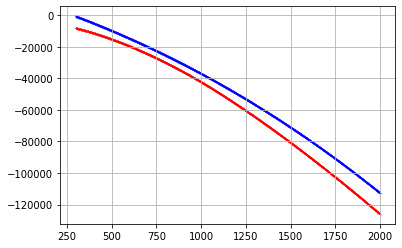

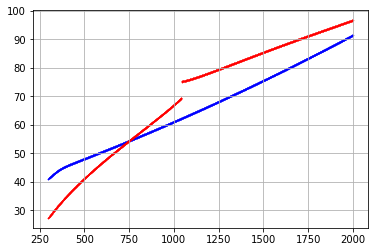

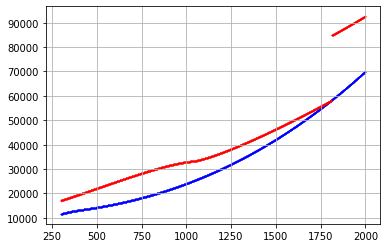

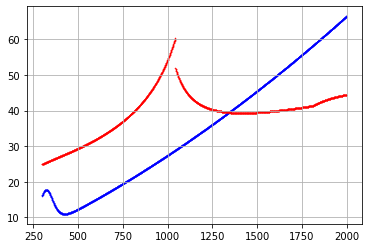

In [10]:
ph = PlotHandler('Laenge')

ph.properties_temp(net, dataset)

In [ ]:
#torch.save(net, 'LaengeNet/Models/model_12_01_22_1535')